In [1]:
## Libraries
import os
import json
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
%%time
df = pd.read_csv("train-new.csv")

<string>:2: DtypeWarning: Columns (2,49) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 11.6 s


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

## Preprocessing

In [4]:
# Constant columns
const_cols = [c for c in df.columns if df[c].nunique(dropna=False)==1 ]
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [5]:
# Searching for missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        rate = df[col].isnull().sum() * 100 / df.shape[0]
        print(f'Column {col} has {rate:.4f}% missing values.')
    if df[col].dtype == 'object':
        if (df[col] == 'not available in demo dataset').sum() > 0:
            rate = (df[col] == 'not available in demo dataset').sum() * 100 / df.shape[0]
            print(f'Column {col} has {rate:.4f}% values not available in dataset.')

Column device.browserSize has 100.0000% values not available in dataset.
Column device.browserVersion has 100.0000% values not available in dataset.
Column device.flashVersion has 100.0000% values not available in dataset.
Column device.language has 100.0000% values not available in dataset.
Column device.mobileDeviceBranding has 100.0000% values not available in dataset.
Column device.mobileDeviceInfo has 100.0000% values not available in dataset.
Column device.mobileDeviceMarketingName has 100.0000% values not available in dataset.
Column device.mobileDeviceModel has 100.0000% values not available in dataset.
Column device.mobileInputSelector has 100.0000% values not available in dataset.
Column device.operatingSystemVersion has 100.0000% values not available in dataset.
Column device.screenColors has 100.0000% values not available in dataset.
Column device.screenResolution has 100.0000% values not available in dataset.
Column geoNetwork.city has 56.2416% values not available in data

In [6]:
## Dropping constant columns
cols_to_drop = const_cols + ['sessionId']

df = df.drop(cols_to_drop, axis=1)

In [7]:
# Searching for missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        rate = df[col].isnull().sum() * 100 / df.shape[0]
        print(f'Column {col} has {rate:.4f}% missing values.')
    if df[col].dtype == 'object':
        if (df[col] == 'not available in demo dataset').sum() > 0:
            rate = (df[col] == 'not available in demo dataset').sum() * 100 / df.shape[0]
            print(f'Column {col} has {rate:.4f}% values not available in dataset.')

Column geoNetwork.city has 56.2416% values not available in dataset.
Column geoNetwork.metro has 56.2416% values not available in dataset.
Column geoNetwork.region has 56.2416% values not available in dataset.
Column totals.bounces has 50.1324% missing values.
Column totals.newVisits has 22.1980% missing values.
Column totals.pageviews has 0.0111% missing values.
Column totals.transactionRevenue has 98.7257% missing values.
Column trafficSource.adContent has 98.7887% missing values.
Column trafficSource.adwordsClickInfo.adNetworkType has 97.6252% missing values.
Column trafficSource.adwordsClickInfo.gclId has 97.6140% missing values.
Column trafficSource.adwordsClickInfo.isVideoAd has 97.6252% missing values.
Column trafficSource.adwordsClickInfo.page has 97.6252% missing values.
Column trafficSource.adwordsClickInfo.slot has 97.6252% missing values.
Column trafficSource.campaignCode has 99.9999% missing values.
Column trafficSource.isTrueDirect has 69.6781% missing values.
Column traf

In [8]:
## Dropping columns for which values cannot be imputed
new_cols_drop=['geoNetwork.city','geoNetwork.metro','geoNetwork.region','trafficSource.adContent',
               'trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.slot','trafficSource.campaignCode',
               'trafficSource.isTrueDirect','trafficSource.keyword','trafficSource.referralPath','visitStartTime']
df = df.drop(new_cols_drop, axis=1)

In [9]:
# Converting y variable to float and filling in missing values
df["totals.transactionRevenue"] = df["totals.transactionRevenue"].astype('float')
df["totals.transactionRevenue"].fillna(0, inplace=True)

In [10]:
##Imputing values for columns based on their characteristics
df['totals.bounces'].fillna(1, inplace=True)
df['totals.newVisits'].fillna(1, inplace=True)
df['totals.pageviews'].fillna(round(df['totals.pageviews'].mean()), inplace=True)
df['trafficSource.adwordsClickInfo.adNetworkType'].fillna('Google Search', inplace=True)
df['trafficSource.adwordsClickInfo.isVideoAd'].fillna('False', inplace=True)
df['trafficSource.adwordsClickInfo.page'].fillna(1, inplace=True)

In [11]:
# Searching for missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        rate = df[col].isnull().sum() * 100 / df.shape[0]
        print(f'Column {col} has {rate:.4f}% missing values.')
    if df[col].dtype == 'object':
        if (df[col] == 'not available in demo dataset').sum() > 0:
            rate = (df[col] == 'not available in demo dataset').sum() * 100 / df.shape[0]
            print(f'Column {col} has {rate:.4f}% values not available in dataset.')
    else:
        print("Data has no missing values!!")

Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!
Data has no missing values!!


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 24 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.continent                            903653 non-null object
geoNetwork.country                              903653 non-null object
geoNetwork.networkDomain                        903653 non-null object
geoNetwork.subContinent                   

In [13]:
# converting numerical columns to float
num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits'] 
for col in num_cols:
    df[col] = df[col].astype(float)

In [14]:
## Description of numeric columns
df9 = df
new_drop = ['date','visitId','fullVisitorId']
df9 = df9.drop(new_drop, axis=1)
df9.describe()

,visitNumber,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.page
count,903653.000000,903653.0,903653.000000,903653.0,903653.000000,9.036530e+05,903653.000000
mean,2.264897,1.0,4.596538,1.0,3.849781,1.704273e+06,1.000193
std,9.283735,0.0,9.641437,0.0,7.024885,5.277866e+07,0.026778
min,1.000000,1.0,1.000000,1.0,1.000000,0.000000e+00,1.000000
25%,1.000000,1.0,1.000000,1.0,1.000000,0.000000e+00,1.000000
50%,1.000000,1.0,2.000000,1.0,1.000000,0.000000e+00,1.000000
75%,1.000000,1.0,4.000000,1.0,4.000000,0.000000e+00,1.000000
max,395.000000,1.0,500.000000,1.0,469.000000,2.312950e+10,14.000000


In [15]:
# New dataframe with scaled numeric columns to use with regression algorithms
df8 = df
scaler = MinMaxScaler()
df8[ ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']] = scaler.fit_transform(df8[ ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']])

In [16]:
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem","device.isMobile",
            "geoNetwork.continent", "geoNetwork.country",
            "geoNetwork.networkDomain", "geoNetwork.subContinent", 
            "trafficSource.adwordsClickInfo.adNetworkType",  
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.campaign","trafficSource.medium", 
            "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd']

In [17]:
### data for catboost with categorical data
df1_dev = df[df['date']<=20170430]
df1_val = df[df['date']>20170430]
df1_dev_y = np.log1p(df1_dev["totals.transactionRevenue"].values)
df1_val_y = np.log1p(df1_val["totals.transactionRevenue"].values)

df1_dev_X = df1_dev[cat_cols + num_cols] 
df1_val_X = df1_val[cat_cols + num_cols]

In [18]:
## Enumerating categorical columns 
cols = df1_dev_X.columns
cat_num_cols = df1_dev_X._get_numeric_data().columns
cat_num_cols
cat_features=list(set(cols) - set(cat_num_cols))
cat_features_index=[]
for i in cat_features:
    number = df1_dev_X.columns.get_loc(i)
    cat_features_index.append(number)

In [19]:
# label encode the categorical variables and convert the numerical variables to float
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[col].values.astype('str')) )
    df[col] = lbl.transform(list(df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
device.isMobile
geoNetwork.continent
geoNetwork.country
geoNetwork.networkDomain
geoNetwork.subContinent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.page
trafficSource.campaign
trafficSource.medium
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd


In [20]:
# Split the train dataset into development and valid based on time 
# df2 for decision trees, xgboost
df2_dev = df[df['date']<=20170430]
df2_val = df[df['date']>20170430]
df2_dev_y = np.log1p(df2_dev["totals.transactionRevenue"].values)
df2_val_y = np.log1p(df2_val["totals.transactionRevenue"].values)

df2_dev_X = df2_dev[cat_cols + num_cols] 
df2_val_X = df2_val[cat_cols + num_cols]

In [21]:
### data for regression models
df3_dev = df8[df8['date']<=20170430]
df3_val = df8[df8['date']>20170430]
df3_dev_y = np.log1p(df3_dev["totals.transactionRevenue"].values)
df3_val_y = np.log1p(df3_val["totals.transactionRevenue"].values)

df3_dev_X = df3_dev[cat_cols + num_cols] 
df3_val_X = df3_val[cat_cols + num_cols]


In [22]:
## data matrix for xgboost linear base learner
import xgboost as xgb
dev_y = pd.DataFrame(df2_dev_y,columns=['totals.transactionRevenue'])
val_y = pd.DataFrame(df2_val_y,columns=['totals.transactionRevenue'])
train1 = pd.concat([df2_dev_X,df2_val_X])
test1 = pd.concat([dev_y,val_y])
data_dmatrix = xgb.DMatrix(data=train1,label=test1)

In [23]:
train_dmatrix = xgb.DMatrix(data=df2_dev_X,label=df2_dev_y)
test_dmatrix = xgb.DMatrix(data=df2_val_X,label=df2_val_y)

In [24]:
## Percantage of test to train data
print(len(df2_val_X)/len(df2_dev_X))

0.2903135066596605


In [25]:
## Evaluation function - using RMSE and R2 score
rmse_test = []
r2 = []
algo = []
time_taken=[]
def rmse(pred_val):
    pred_val[pred_val<0] = 0
    val_pred_df = pd.DataFrame({"fullVisitorId":df2_val["fullVisitorId"].values})
    val_pred_df["transactionRevenue"] = df2_val["totals.transactionRevenue"].values
    val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
    val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
    test_RMSE = np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values)))
    score= r2_score(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))
    rmse_test.append(test_RMSE)
    r2.append(score)
    print('RMSE',test_RMSE)
    print('r2_score',score)

### Model selection

In [26]:
%%time
import time
time_start=time.clock()
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=False)
reg.fit(df3_dev_X, df3_dev_y)
pred_val = reg.predict(df3_val_X)
rmse(pred_val)
algo.append('LinearRegression')
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.0875597443051928
r2_score 0.20471634453357168
Wall time: 1.08 s


In [27]:
%%time
import time
time_start=time.clock()
import xgboost as xgb
model = xgb.XGBRegressor(tree_method = 'gpu_hist')
model.fit(df2_dev_X, df2_dev_y)
pred_val = model.predict(df2_val_X)
rmse(pred_val)
algo.append('Xgboost_gbtree')
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 1.8836941603784785
r2_score 0.3524623678292407
Wall time: 4.63 s


In [28]:
%%time
import time
time_start=time.clock()
params = {"booster":"gblinear","objective":"reg:linear"}
xg_reg = xgb.train(params=params,dtrain=train_dmatrix,num_boost_round=10)
pred_val = xg_reg.predict(test_dmatrix)
rmse(pred_val)
algo.append('Xgboost_gblinear')
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.101441326719654
r2_score 0.19410443162171087
Wall time: 3.96 s


In [29]:
%%time
import time
time_start=time.clock()
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(df2_dev_X, df2_dev_y)
pred_val = reg.predict(df2_val_X)
rmse(pred_val)
algo.append("DecisionTrees")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.0875597443051928
r2_score 0.20471634453357168
Wall time: 2.3 s


In [30]:
%%time
import time
time_start=time.clock()
from sklearn.linear_model import Ridge
reg = Ridge(normalize=False)
reg.fit(df3_dev_X, df3_dev_y)
pred_val = reg.predict(df3_val_X)
rmse(pred_val)
algo.append('RidgeRegression')
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.0892555421857777
r2_score 0.20342374621156412
Wall time: 764 ms


In [31]:
%%time
import time
time_start=time.clock()
from sklearn.linear_model import Lasso
reg = Lasso(normalize=False)
reg.fit(df3_dev_X, df3_dev_y)
pred_val = reg.predict(df3_val_X)
rmse(pred_val)
algo.append("Lasso")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.292647549114657
r2_score 0.04077868500084947
Wall time: 821 ms


In [32]:
%%time
import time
time_start=time.clock()
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(df2_dev_X, df2_dev_y)
pred_val = reg.predict(df2_val_X)
rmse(pred_val)
algo.append("RandomForest")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 1.9700765269631078
r2_score 0.2917111207854721
Wall time: 14.8 s


In [33]:
%%time
import time
time_start=time.clock()
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor()
reg.fit(df2_dev_X, df2_dev_y)
pred_val = reg.predict(df2_val_X)
rmse(pred_val)
algo.append("ExtraTrees")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

RMSE 2.046522855815201
r2_score 0.23567612010928418
Wall time: 10.3 s


In [34]:
%%time
import catboost as cb
import time
time_start=time.clock()
model = cb.CatBoostRegressor(eval_metric="RMSE",task_type = "GPU",)
model.fit(df2_dev_X, df2_dev_y)
pred_val = model.predict(df2_val_X)
rmse(pred_val)
algo.append("Catboost_num")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

0:	learn: 1.9419163	total: 32ms	remaining: 32s
1:	learn: 1.9269218	total: 50.1ms	remaining: 25s
2:	learn: 1.9126850	total: 66.6ms	remaining: 22.1s
3:	learn: 1.8991816	total: 82.6ms	remaining: 20.6s
4:	learn: 1.8863961	total: 99.1ms	remaining: 19.7s
5:	learn: 1.8742232	total: 118ms	remaining: 19.5s
6:	learn: 1.8625964	total: 134ms	remaining: 19.1s
7:	learn: 1.8516280	total: 153ms	remaining: 18.9s
8:	learn: 1.8411779	total: 171ms	remaining: 18.8s
9:	learn: 1.8313535	total: 190ms	remaining: 18.8s
10:	learn: 1.8219387	total: 211ms	remaining: 19s
11:	learn: 1.8131014	total: 230ms	remaining: 18.9s
12:	learn: 1.8047164	total: 250ms	remaining: 19s
13:	learn: 1.7966171	total: 271ms	remaining: 19.1s
14:	learn: 1.7889620	total: 290ms	remaining: 19s
15:	learn: 1.7818007	total: 308ms	remaining: 18.9s
16:	learn: 1.7749364	total: 327ms	remaining: 18.9s
17:	learn: 1.7684762	total: 347ms	remaining: 18.9s
18:	learn: 1.7623653	total: 365ms	remaining: 18.9s
19:	learn: 1.7565222	total: 385ms	remaining: 18.

165:	learn: 1.6242756	total: 2.87s	remaining: 14.4s
166:	learn: 1.6241824	total: 2.89s	remaining: 14.4s
167:	learn: 1.6239718	total: 2.9s	remaining: 14.4s
168:	learn: 1.6238528	total: 2.92s	remaining: 14.4s
169:	learn: 1.6237550	total: 2.94s	remaining: 14.3s
170:	learn: 1.6236867	total: 2.95s	remaining: 14.3s
171:	learn: 1.6234439	total: 2.97s	remaining: 14.3s
172:	learn: 1.6233738	total: 2.99s	remaining: 14.3s
173:	learn: 1.6232379	total: 3s	remaining: 14.3s
174:	learn: 1.6230594	total: 3.02s	remaining: 14.2s
175:	learn: 1.6228683	total: 3.04s	remaining: 14.2s
176:	learn: 1.6227371	total: 3.05s	remaining: 14.2s
177:	learn: 1.6226041	total: 3.07s	remaining: 14.2s
178:	learn: 1.6225183	total: 3.09s	remaining: 14.2s
179:	learn: 1.6223856	total: 3.11s	remaining: 14.2s
180:	learn: 1.6221306	total: 3.12s	remaining: 14.1s
181:	learn: 1.6220503	total: 3.14s	remaining: 14.1s
182:	learn: 1.6218671	total: 3.15s	remaining: 14.1s
183:	learn: 1.6217087	total: 3.17s	remaining: 14.1s
184:	learn: 1.62

324:	learn: 1.6052462	total: 5.49s	remaining: 11.4s
325:	learn: 1.6052082	total: 5.51s	remaining: 11.4s
326:	learn: 1.6051076	total: 5.53s	remaining: 11.4s
327:	learn: 1.6049910	total: 5.54s	remaining: 11.4s
328:	learn: 1.6048382	total: 5.56s	remaining: 11.3s
329:	learn: 1.6046969	total: 5.57s	remaining: 11.3s
330:	learn: 1.6046342	total: 5.59s	remaining: 11.3s
331:	learn: 1.6045226	total: 5.61s	remaining: 11.3s
332:	learn: 1.6043890	total: 5.62s	remaining: 11.3s
333:	learn: 1.6043272	total: 5.64s	remaining: 11.2s
334:	learn: 1.6042169	total: 5.66s	remaining: 11.2s
335:	learn: 1.6041493	total: 5.67s	remaining: 11.2s
336:	learn: 1.6040801	total: 5.69s	remaining: 11.2s
337:	learn: 1.6039996	total: 5.71s	remaining: 11.2s
338:	learn: 1.6038955	total: 5.72s	remaining: 11.2s
339:	learn: 1.6037692	total: 5.74s	remaining: 11.1s
340:	learn: 1.6036673	total: 5.76s	remaining: 11.1s
341:	learn: 1.6035494	total: 5.78s	remaining: 11.1s
342:	learn: 1.6035047	total: 5.79s	remaining: 11.1s
343:	learn: 

494:	learn: 1.5923776	total: 8.32s	remaining: 8.49s
495:	learn: 1.5923515	total: 8.34s	remaining: 8.47s
496:	learn: 1.5922486	total: 8.36s	remaining: 8.46s
497:	learn: 1.5921893	total: 8.37s	remaining: 8.44s
498:	learn: 1.5921365	total: 8.39s	remaining: 8.42s
499:	learn: 1.5920542	total: 8.4s	remaining: 8.4s
500:	learn: 1.5920070	total: 8.42s	remaining: 8.39s
501:	learn: 1.5919155	total: 8.44s	remaining: 8.37s
502:	learn: 1.5918781	total: 8.46s	remaining: 8.36s
503:	learn: 1.5918129	total: 8.47s	remaining: 8.34s
504:	learn: 1.5917628	total: 8.49s	remaining: 8.32s
505:	learn: 1.5917455	total: 8.51s	remaining: 8.3s
506:	learn: 1.5916707	total: 8.52s	remaining: 8.29s
507:	learn: 1.5915959	total: 8.54s	remaining: 8.27s
508:	learn: 1.5915135	total: 8.56s	remaining: 8.25s
509:	learn: 1.5914410	total: 8.57s	remaining: 8.24s
510:	learn: 1.5913603	total: 8.59s	remaining: 8.22s
511:	learn: 1.5912695	total: 8.61s	remaining: 8.2s
512:	learn: 1.5911961	total: 8.63s	remaining: 8.19s
513:	learn: 1.59

655:	learn: 1.5830365	total: 11s	remaining: 5.76s
656:	learn: 1.5830026	total: 11s	remaining: 5.75s
657:	learn: 1.5829851	total: 11s	remaining: 5.73s
658:	learn: 1.5829087	total: 11s	remaining: 5.71s
659:	learn: 1.5828609	total: 11.1s	remaining: 5.7s
660:	learn: 1.5828148	total: 11.1s	remaining: 5.68s
661:	learn: 1.5827895	total: 11.1s	remaining: 5.66s
662:	learn: 1.5827323	total: 11.1s	remaining: 5.64s
663:	learn: 1.5826911	total: 11.1s	remaining: 5.63s
664:	learn: 1.5826350	total: 11.1s	remaining: 5.61s
665:	learn: 1.5825428	total: 11.2s	remaining: 5.59s
666:	learn: 1.5824904	total: 11.2s	remaining: 5.58s
667:	learn: 1.5824040	total: 11.2s	remaining: 5.56s
668:	learn: 1.5823462	total: 11.2s	remaining: 5.54s
669:	learn: 1.5822987	total: 11.2s	remaining: 5.53s
670:	learn: 1.5822633	total: 11.2s	remaining: 5.51s
671:	learn: 1.5822307	total: 11.3s	remaining: 5.49s
672:	learn: 1.5822039	total: 11.3s	remaining: 5.48s
673:	learn: 1.5821485	total: 11.3s	remaining: 5.46s
674:	learn: 1.5820819

825:	learn: 1.5753664	total: 13.8s	remaining: 2.91s
826:	learn: 1.5753131	total: 13.8s	remaining: 2.89s
827:	learn: 1.5752667	total: 13.8s	remaining: 2.87s
828:	learn: 1.5752381	total: 13.9s	remaining: 2.86s
829:	learn: 1.5751877	total: 13.9s	remaining: 2.84s
830:	learn: 1.5751624	total: 13.9s	remaining: 2.82s
831:	learn: 1.5751464	total: 13.9s	remaining: 2.81s
832:	learn: 1.5750550	total: 13.9s	remaining: 2.79s
833:	learn: 1.5750369	total: 13.9s	remaining: 2.77s
834:	learn: 1.5750111	total: 14s	remaining: 2.76s
835:	learn: 1.5749977	total: 14s	remaining: 2.74s
836:	learn: 1.5749368	total: 14s	remaining: 2.72s
837:	learn: 1.5749183	total: 14s	remaining: 2.71s
838:	learn: 1.5748799	total: 14s	remaining: 2.69s
839:	learn: 1.5748481	total: 14s	remaining: 2.67s
840:	learn: 1.5747931	total: 14.1s	remaining: 2.66s
841:	learn: 1.5747321	total: 14.1s	remaining: 2.64s
842:	learn: 1.5746863	total: 14.1s	remaining: 2.62s
843:	learn: 1.5746631	total: 14.1s	remaining: 2.61s
844:	learn: 1.5746217	to

985:	learn: 1.5690131	total: 16.5s	remaining: 234ms
986:	learn: 1.5689847	total: 16.5s	remaining: 217ms
987:	learn: 1.5689129	total: 16.5s	remaining: 200ms
988:	learn: 1.5688825	total: 16.5s	remaining: 184ms
989:	learn: 1.5688316	total: 16.5s	remaining: 167ms
990:	learn: 1.5687707	total: 16.5s	remaining: 150ms
991:	learn: 1.5687391	total: 16.6s	remaining: 134ms
992:	learn: 1.5687033	total: 16.6s	remaining: 117ms
993:	learn: 1.5686730	total: 16.6s	remaining: 100ms
994:	learn: 1.5686568	total: 16.6s	remaining: 83.5ms
995:	learn: 1.5686128	total: 16.6s	remaining: 66.8ms
996:	learn: 1.5685816	total: 16.6s	remaining: 50.1ms
997:	learn: 1.5685256	total: 16.7s	remaining: 33.4ms
998:	learn: 1.5684971	total: 16.7s	remaining: 16.7ms
999:	learn: 1.5684851	total: 16.7s	remaining: 0us
RMSE 1.8570809075189767
r2_score 0.37063022827621217
Wall time: 22.3 s


In [35]:
%%time
import catboost as cb
import time
time_start=time.clock()
clf = cb.CatBoostRegressor(eval_metric="RMSE",task_type = "GPU")
clf.fit(df1_dev_X,df1_dev_y,cat_features= cat_features_index)
pred_val = clf.predict(df1_val_X)
rmse(pred_val)
algo.append("Catboost_cat")
time_elapsed = (time.clock() - time_start)
time_taken.append(time_elapsed)

0:	learn: 1.9417048	total: 270ms	remaining: 4m 29s
1:	learn: 1.9265200	total: 503ms	remaining: 4m 11s
2:	learn: 1.9121069	total: 756ms	remaining: 4m 11s
3:	learn: 1.8984783	total: 980ms	remaining: 4m 3s
4:	learn: 1.8855034	total: 1.23s	remaining: 4m 3s
5:	learn: 1.8731783	total: 1.47s	remaining: 4m 3s
6:	learn: 1.8614530	total: 1.7s	remaining: 4m 1s
7:	learn: 1.8503627	total: 1.93s	remaining: 3m 59s
8:	learn: 1.8397831	total: 2.15s	remaining: 3m 57s
9:	learn: 1.8298945	total: 2.42s	remaining: 3m 59s
10:	learn: 1.8203447	total: 2.65s	remaining: 3m 58s
11:	learn: 1.8113074	total: 2.88s	remaining: 3m 57s
12:	learn: 1.8027587	total: 3.12s	remaining: 3m 56s
13:	learn: 1.7946036	total: 3.35s	remaining: 3m 55s
14:	learn: 1.7869283	total: 3.6s	remaining: 3m 56s
15:	learn: 1.7797552	total: 3.86s	remaining: 3m 57s
16:	learn: 1.7728480	total: 4.13s	remaining: 3m 59s
17:	learn: 1.7662404	total: 4.38s	remaining: 3m 59s
18:	learn: 1.7600767	total: 4.63s	remaining: 3m 58s
19:	learn: 1.7541774	total: 

158:	learn: 1.6229787	total: 37.9s	remaining: 3m 20s
159:	learn: 1.6227947	total: 38.2s	remaining: 3m 20s
160:	learn: 1.6225773	total: 38.4s	remaining: 3m 20s
161:	learn: 1.6224784	total: 38.7s	remaining: 3m 20s
162:	learn: 1.6223998	total: 38.9s	remaining: 3m 19s
163:	learn: 1.6222805	total: 39.2s	remaining: 3m 19s
164:	learn: 1.6222069	total: 39.4s	remaining: 3m 19s
165:	learn: 1.6221460	total: 39.7s	remaining: 3m 19s
166:	learn: 1.6219078	total: 39.9s	remaining: 3m 19s
167:	learn: 1.6217038	total: 40.1s	remaining: 3m 18s
168:	learn: 1.6216363	total: 40.4s	remaining: 3m 18s
169:	learn: 1.6213551	total: 40.6s	remaining: 3m 18s
170:	learn: 1.6212846	total: 40.8s	remaining: 3m 17s
171:	learn: 1.6211394	total: 41s	remaining: 3m 17s
172:	learn: 1.6209360	total: 41.3s	remaining: 3m 17s
173:	learn: 1.6207784	total: 41.5s	remaining: 3m 17s
174:	learn: 1.6206189	total: 41.8s	remaining: 3m 16s
175:	learn: 1.6204510	total: 42s	remaining: 3m 16s
176:	learn: 1.6203775	total: 42.2s	remaining: 3m 1

314:	learn: 1.6062097	total: 1m 14s	remaining: 2m 41s
315:	learn: 1.6060566	total: 1m 14s	remaining: 2m 41s
316:	learn: 1.6059276	total: 1m 14s	remaining: 2m 41s
317:	learn: 1.6058073	total: 1m 15s	remaining: 2m 40s
318:	learn: 1.6057910	total: 1m 15s	remaining: 2m 40s
319:	learn: 1.6057071	total: 1m 15s	remaining: 2m 40s
320:	learn: 1.6056968	total: 1m 15s	remaining: 2m 40s
321:	learn: 1.6056395	total: 1m 16s	remaining: 2m 40s
322:	learn: 1.6056070	total: 1m 16s	remaining: 2m 39s
323:	learn: 1.6055524	total: 1m 16s	remaining: 2m 39s
324:	learn: 1.6054783	total: 1m 16s	remaining: 2m 39s
325:	learn: 1.6053466	total: 1m 16s	remaining: 2m 39s
326:	learn: 1.6052308	total: 1m 17s	remaining: 2m 38s
327:	learn: 1.6051682	total: 1m 17s	remaining: 2m 38s
328:	learn: 1.6051423	total: 1m 17s	remaining: 2m 38s
329:	learn: 1.6049760	total: 1m 17s	remaining: 2m 38s
330:	learn: 1.6048882	total: 1m 18s	remaining: 2m 38s
331:	learn: 1.6048710	total: 1m 18s	remaining: 2m 37s
332:	learn: 1.6048292	total:

467:	learn: 1.5960406	total: 1m 50s	remaining: 2m 5s
468:	learn: 1.5959890	total: 1m 50s	remaining: 2m 5s
469:	learn: 1.5959610	total: 1m 51s	remaining: 2m 5s
470:	learn: 1.5958994	total: 1m 51s	remaining: 2m 4s
471:	learn: 1.5958587	total: 1m 51s	remaining: 2m 4s
472:	learn: 1.5958327	total: 1m 51s	remaining: 2m 4s
473:	learn: 1.5957286	total: 1m 51s	remaining: 2m 4s
474:	learn: 1.5957197	total: 1m 52s	remaining: 2m 3s
475:	learn: 1.5956894	total: 1m 52s	remaining: 2m 3s
476:	learn: 1.5956697	total: 1m 52s	remaining: 2m 3s
477:	learn: 1.5955772	total: 1m 52s	remaining: 2m 3s
478:	learn: 1.5955257	total: 1m 53s	remaining: 2m 3s
479:	learn: 1.5954739	total: 1m 53s	remaining: 2m 2s
480:	learn: 1.5953821	total: 1m 53s	remaining: 2m 2s
481:	learn: 1.5952444	total: 1m 53s	remaining: 2m 2s
482:	learn: 1.5951994	total: 1m 54s	remaining: 2m 2s
483:	learn: 1.5950869	total: 1m 54s	remaining: 2m 1s
484:	learn: 1.5950308	total: 1m 54s	remaining: 2m 1s
485:	learn: 1.5949385	total: 1m 54s	remaining:

621:	learn: 1.5874358	total: 2m 27s	remaining: 1m 29s
622:	learn: 1.5874070	total: 2m 27s	remaining: 1m 29s
623:	learn: 1.5873559	total: 2m 28s	remaining: 1m 29s
624:	learn: 1.5873021	total: 2m 28s	remaining: 1m 29s
625:	learn: 1.5872649	total: 2m 28s	remaining: 1m 28s
626:	learn: 1.5871989	total: 2m 28s	remaining: 1m 28s
627:	learn: 1.5871929	total: 2m 29s	remaining: 1m 28s
628:	learn: 1.5871860	total: 2m 29s	remaining: 1m 28s
629:	learn: 1.5871363	total: 2m 29s	remaining: 1m 27s
630:	learn: 1.5870465	total: 2m 29s	remaining: 1m 27s
631:	learn: 1.5870298	total: 2m 30s	remaining: 1m 27s
632:	learn: 1.5870110	total: 2m 30s	remaining: 1m 27s
633:	learn: 1.5870038	total: 2m 30s	remaining: 1m 26s
634:	learn: 1.5869485	total: 2m 30s	remaining: 1m 26s
635:	learn: 1.5869049	total: 2m 31s	remaining: 1m 26s
636:	learn: 1.5868963	total: 2m 31s	remaining: 1m 26s
637:	learn: 1.5868561	total: 2m 31s	remaining: 1m 25s
638:	learn: 1.5868506	total: 2m 31s	remaining: 1m 25s
639:	learn: 1.5868305	total:

775:	learn: 1.5807375	total: 3m 4s	remaining: 53.4s
776:	learn: 1.5806623	total: 3m 5s	remaining: 53.1s
777:	learn: 1.5806178	total: 3m 5s	remaining: 52.9s
778:	learn: 1.5805456	total: 3m 5s	remaining: 52.7s
779:	learn: 1.5805233	total: 3m 5s	remaining: 52.4s
780:	learn: 1.5805183	total: 3m 6s	remaining: 52.2s
781:	learn: 1.5804995	total: 3m 6s	remaining: 52s
782:	learn: 1.5804663	total: 3m 6s	remaining: 51.7s
783:	learn: 1.5803925	total: 3m 6s	remaining: 51.5s
784:	learn: 1.5803654	total: 3m 7s	remaining: 51.2s
785:	learn: 1.5802868	total: 3m 7s	remaining: 51s
786:	learn: 1.5802654	total: 3m 7s	remaining: 50.8s
787:	learn: 1.5802183	total: 3m 7s	remaining: 50.5s
788:	learn: 1.5801864	total: 3m 8s	remaining: 50.3s
789:	learn: 1.5801607	total: 3m 8s	remaining: 50s
790:	learn: 1.5801183	total: 3m 8s	remaining: 49.8s
791:	learn: 1.5800672	total: 3m 8s	remaining: 49.6s
792:	learn: 1.5800227	total: 3m 9s	remaining: 49.3s
793:	learn: 1.5800028	total: 3m 9s	remaining: 49.1s
794:	learn: 1.5799

931:	learn: 1.5751392	total: 3m 43s	remaining: 16.3s
932:	learn: 1.5751091	total: 3m 43s	remaining: 16.1s
933:	learn: 1.5750651	total: 3m 43s	remaining: 15.8s
934:	learn: 1.5750101	total: 3m 44s	remaining: 15.6s
935:	learn: 1.5749839	total: 3m 44s	remaining: 15.3s
936:	learn: 1.5749415	total: 3m 44s	remaining: 15.1s
937:	learn: 1.5749145	total: 3m 44s	remaining: 14.9s
938:	learn: 1.5748862	total: 3m 45s	remaining: 14.6s
939:	learn: 1.5748378	total: 3m 45s	remaining: 14.4s
940:	learn: 1.5748280	total: 3m 45s	remaining: 14.1s
941:	learn: 1.5747744	total: 3m 45s	remaining: 13.9s
942:	learn: 1.5747575	total: 3m 46s	remaining: 13.7s
943:	learn: 1.5746917	total: 3m 46s	remaining: 13.4s
944:	learn: 1.5746587	total: 3m 46s	remaining: 13.2s
945:	learn: 1.5746369	total: 3m 46s	remaining: 13s
946:	learn: 1.5745856	total: 3m 47s	remaining: 12.7s
947:	learn: 1.5745609	total: 3m 47s	remaining: 12.5s
948:	learn: 1.5745310	total: 3m 47s	remaining: 12.2s
949:	learn: 1.5745107	total: 3m 47s	remaining: 1

In [36]:
dfr = pd.DataFrame()
dfr['model'] = algo
dfr['rmse'] = rmse_test
dfr['r2_score'] = r2
dfr['time'] = time_taken

In [37]:
### Dataframe containing evaluation metrics for model selection
dfr

,model,rmse,r2_score,time
0,LinearRegression,2.087560,0.204716,1.081783
1,Xgboost_gbtree,1.883694,0.352462,4.628553
2,Xgboost_gblinear,2.101441,0.194104,3.960571
3,DecisionTrees,2.087560,0.204716,2.299030
4,RidgeRegression,2.089256,0.203424,0.763452
5,Lasso,2.292648,0.040779,0.821028
6,RandomForest,1.970077,0.291711,14.795270
7,ExtraTrees,2.046523,0.235676,10.311513
8,Catboost_num,1.857081,0.370630,21.053210
9,Catboost_cat,1.857831,0.370122,265.341394


## Modelling with parameter tuning

In [38]:
def rmse1(pred_val):
    pred_val[pred_val<0] = 0
    val_pred_df = pd.DataFrame({"fullVisitorId":df2_val["fullVisitorId"].values})
    val_pred_df["transactionRevenue"] = df2_val["totals.transactionRevenue"].values
    val_pred_df["PredictedRevenue"] = np.expm1(pred_val)
    val_pred_df = val_pred_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
    test_RMSE = np.sqrt(metrics.mean_squared_error(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values)))
    score= r2_score(np.log1p(val_pred_df["transactionRevenue"].values), np.log1p(val_pred_df["PredictedRevenue"].values))
    print('RMSE',test_RMSE)
    print('r2_score',score)

In [58]:
%%time
import catboost as cb
params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15,0.2],
         'l2_leaf_reg': [1,3,4,7,9],
         'iterations': [300]}
cb = cb.CatBoostRegressor(task_type = "GPU",eval_metric="RMSE")
cb_model = GridSearchCV(cb, params, cv = 3)
cb_model.fit(df2_dev_X,df2_dev_y)
print(cb_model.best_params_)

0:	learn: 1.9485362	total: 11.8ms	remaining: 3.54s
1:	learn: 1.9346233	total: 22.9ms	remaining: 3.41s
2:	learn: 1.9215967	total: 32.8ms	remaining: 3.25s
3:	learn: 1.9090960	total: 43ms	remaining: 3.18s
4:	learn: 1.8977401	total: 54.4ms	remaining: 3.21s
5:	learn: 1.8865217	total: 65.2ms	remaining: 3.2s
6:	learn: 1.8762456	total: 75.6ms	remaining: 3.16s
7:	learn: 1.8660058	total: 85.8ms	remaining: 3.13s
8:	learn: 1.8563187	total: 96.2ms	remaining: 3.11s
9:	learn: 1.8474242	total: 107ms	remaining: 3.1s
10:	learn: 1.8386043	total: 118ms	remaining: 3.09s
11:	learn: 1.8302631	total: 129ms	remaining: 3.09s
12:	learn: 1.8225724	total: 140ms	remaining: 3.09s
13:	learn: 1.8153114	total: 151ms	remaining: 3.08s
14:	learn: 1.8080460	total: 162ms	remaining: 3.07s
15:	learn: 1.8011693	total: 172ms	remaining: 3.05s
16:	learn: 1.7946686	total: 183ms	remaining: 3.04s
17:	learn: 1.7884597	total: 196ms	remaining: 3.08s
18:	learn: 1.7827637	total: 209ms	remaining: 3.1s
19:	learn: 1.7772984	total: 221ms	rem

161:	learn: 1.6474356	total: 1.78s	remaining: 1.52s
162:	learn: 1.6472708	total: 1.79s	remaining: 1.51s
163:	learn: 1.6471150	total: 1.8s	remaining: 1.5s
164:	learn: 1.6470511	total: 1.81s	remaining: 1.48s
165:	learn: 1.6468395	total: 1.82s	remaining: 1.47s
166:	learn: 1.6467283	total: 1.83s	remaining: 1.46s
167:	learn: 1.6465820	total: 1.84s	remaining: 1.45s
168:	learn: 1.6464135	total: 1.86s	remaining: 1.44s
169:	learn: 1.6462279	total: 1.87s	remaining: 1.43s
170:	learn: 1.6460247	total: 1.88s	remaining: 1.42s
171:	learn: 1.6458640	total: 1.89s	remaining: 1.4s
172:	learn: 1.6456633	total: 1.9s	remaining: 1.39s
173:	learn: 1.6455106	total: 1.91s	remaining: 1.38s
174:	learn: 1.6453751	total: 1.92s	remaining: 1.37s
175:	learn: 1.6452889	total: 1.93s	remaining: 1.36s
176:	learn: 1.6451059	total: 1.94s	remaining: 1.35s
177:	learn: 1.6450236	total: 1.95s	remaining: 1.33s
178:	learn: 1.6449062	total: 1.96s	remaining: 1.32s
179:	learn: 1.6448320	total: 1.97s	remaining: 1.31s
180:	learn: 1.64

37:	learn: 1.6927372	total: 407ms	remaining: 2.81s
38:	learn: 1.6904043	total: 418ms	remaining: 2.8s
39:	learn: 1.6882104	total: 428ms	remaining: 2.78s
40:	learn: 1.6861633	total: 438ms	remaining: 2.77s
41:	learn: 1.6841707	total: 448ms	remaining: 2.75s
42:	learn: 1.6822330	total: 458ms	remaining: 2.74s
43:	learn: 1.6803653	total: 468ms	remaining: 2.72s
44:	learn: 1.6786735	total: 478ms	remaining: 2.71s
45:	learn: 1.6770588	total: 488ms	remaining: 2.7s
46:	learn: 1.6755368	total: 499ms	remaining: 2.68s
47:	learn: 1.6740427	total: 510ms	remaining: 2.68s
48:	learn: 1.6725768	total: 521ms	remaining: 2.67s
49:	learn: 1.6711614	total: 532ms	remaining: 2.66s
50:	learn: 1.6698563	total: 543ms	remaining: 2.65s
51:	learn: 1.6685626	total: 553ms	remaining: 2.64s
52:	learn: 1.6673649	total: 563ms	remaining: 2.63s
53:	learn: 1.6662163	total: 575ms	remaining: 2.62s
54:	learn: 1.6651881	total: 586ms	remaining: 2.61s
55:	learn: 1.6641179	total: 599ms	remaining: 2.61s
56:	learn: 1.6630511	total: 612ms

204:	learn: 1.6219569	total: 2.2s	remaining: 1.02s
205:	learn: 1.6219100	total: 2.21s	remaining: 1.01s
206:	learn: 1.6217903	total: 2.22s	remaining: 998ms
207:	learn: 1.6217371	total: 2.23s	remaining: 987ms
208:	learn: 1.6216672	total: 2.24s	remaining: 976ms
209:	learn: 1.6215013	total: 2.25s	remaining: 965ms
210:	learn: 1.6213838	total: 2.26s	remaining: 953ms
211:	learn: 1.6212526	total: 2.27s	remaining: 942ms
212:	learn: 1.6212125	total: 2.28s	remaining: 931ms
213:	learn: 1.6211389	total: 2.29s	remaining: 920ms
214:	learn: 1.6210823	total: 2.3s	remaining: 909ms
215:	learn: 1.6208926	total: 2.31s	remaining: 899ms
216:	learn: 1.6208414	total: 2.32s	remaining: 888ms
217:	learn: 1.6207186	total: 2.33s	remaining: 877ms
218:	learn: 1.6205921	total: 2.34s	remaining: 866ms
219:	learn: 1.6204041	total: 2.35s	remaining: 855ms
220:	learn: 1.6202362	total: 2.36s	remaining: 844ms
221:	learn: 1.6200816	total: 2.37s	remaining: 833ms
222:	learn: 1.6199655	total: 2.38s	remaining: 822ms
223:	learn: 1.

74:	learn: 1.6662774	total: 810ms	remaining: 2.43s
75:	learn: 1.6657265	total: 824ms	remaining: 2.43s
76:	learn: 1.6652333	total: 834ms	remaining: 2.41s
77:	learn: 1.6647216	total: 844ms	remaining: 2.4s
78:	learn: 1.6643475	total: 854ms	remaining: 2.39s
79:	learn: 1.6638867	total: 865ms	remaining: 2.38s
80:	learn: 1.6634101	total: 875ms	remaining: 2.37s
81:	learn: 1.6630075	total: 885ms	remaining: 2.35s
82:	learn: 1.6626381	total: 895ms	remaining: 2.34s
83:	learn: 1.6622423	total: 906ms	remaining: 2.33s
84:	learn: 1.6619100	total: 915ms	remaining: 2.31s
85:	learn: 1.6615238	total: 925ms	remaining: 2.3s
86:	learn: 1.6611600	total: 935ms	remaining: 2.29s
87:	learn: 1.6607590	total: 946ms	remaining: 2.28s
88:	learn: 1.6603855	total: 956ms	remaining: 2.27s
89:	learn: 1.6600679	total: 966ms	remaining: 2.25s
90:	learn: 1.6597315	total: 977ms	remaining: 2.24s
91:	learn: 1.6594154	total: 987ms	remaining: 2.23s
92:	learn: 1.6591330	total: 998ms	remaining: 2.22s
93:	learn: 1.6588389	total: 1.01s

244:	learn: 1.6330103	total: 2.57s	remaining: 577ms
245:	learn: 1.6329112	total: 2.58s	remaining: 566ms
246:	learn: 1.6327478	total: 2.59s	remaining: 556ms
247:	learn: 1.6325995	total: 2.6s	remaining: 546ms
248:	learn: 1.6324582	total: 2.61s	remaining: 535ms
249:	learn: 1.6323396	total: 2.62s	remaining: 524ms
250:	learn: 1.6321902	total: 2.63s	remaining: 514ms
251:	learn: 1.6320862	total: 2.64s	remaining: 503ms
252:	learn: 1.6320287	total: 2.65s	remaining: 493ms
253:	learn: 1.6319208	total: 2.66s	remaining: 482ms
254:	learn: 1.6318064	total: 2.67s	remaining: 472ms
255:	learn: 1.6316313	total: 2.68s	remaining: 461ms
256:	learn: 1.6315831	total: 2.69s	remaining: 451ms
257:	learn: 1.6314825	total: 2.7s	remaining: 440ms
258:	learn: 1.6313085	total: 2.71s	remaining: 430ms
259:	learn: 1.6311856	total: 2.72s	remaining: 419ms
260:	learn: 1.6311497	total: 2.73s	remaining: 408ms
261:	learn: 1.6310374	total: 2.74s	remaining: 398ms
262:	learn: 1.6308859	total: 2.75s	remaining: 387ms
263:	learn: 1.

109:	learn: 1.6248792	total: 1.19s	remaining: 2.05s
110:	learn: 1.6243924	total: 1.2s	remaining: 2.04s
111:	learn: 1.6240165	total: 1.21s	remaining: 2.03s
112:	learn: 1.6238880	total: 1.22s	remaining: 2.02s
113:	learn: 1.6236093	total: 1.23s	remaining: 2.01s
114:	learn: 1.6235059	total: 1.24s	remaining: 2s
115:	learn: 1.6233494	total: 1.25s	remaining: 1.98s
116:	learn: 1.6231489	total: 1.26s	remaining: 1.97s
117:	learn: 1.6228687	total: 1.27s	remaining: 1.96s
118:	learn: 1.6226673	total: 1.28s	remaining: 1.95s
119:	learn: 1.6223745	total: 1.29s	remaining: 1.94s
120:	learn: 1.6221050	total: 1.3s	remaining: 1.92s
121:	learn: 1.6218292	total: 1.31s	remaining: 1.91s
122:	learn: 1.6216128	total: 1.32s	remaining: 1.9s
123:	learn: 1.6212807	total: 1.33s	remaining: 1.89s
124:	learn: 1.6210939	total: 1.34s	remaining: 1.88s
125:	learn: 1.6208400	total: 1.35s	remaining: 1.86s
126:	learn: 1.6206556	total: 1.36s	remaining: 1.85s
127:	learn: 1.6203497	total: 1.37s	remaining: 1.84s
128:	learn: 1.6202

278:	learn: 1.5972760	total: 2.99s	remaining: 225ms
279:	learn: 1.5971674	total: 3s	remaining: 214ms
280:	learn: 1.5970837	total: 3.01s	remaining: 204ms
281:	learn: 1.5970011	total: 3.02s	remaining: 193ms
282:	learn: 1.5969151	total: 3.03s	remaining: 182ms
283:	learn: 1.5968468	total: 3.04s	remaining: 171ms
284:	learn: 1.5967685	total: 3.05s	remaining: 161ms
285:	learn: 1.5966997	total: 3.06s	remaining: 150ms
286:	learn: 1.5965264	total: 3.07s	remaining: 139ms
287:	learn: 1.5964360	total: 3.08s	remaining: 128ms
288:	learn: 1.5963353	total: 3.09s	remaining: 118ms
289:	learn: 1.5962402	total: 3.1s	remaining: 107ms
290:	learn: 1.5962076	total: 3.11s	remaining: 96.3ms
291:	learn: 1.5961248	total: 3.12s	remaining: 85.6ms
292:	learn: 1.5960554	total: 3.13s	remaining: 74.9ms
293:	learn: 1.5958971	total: 3.14s	remaining: 64.2ms
294:	learn: 1.5957340	total: 3.15s	remaining: 53.5ms
295:	learn: 1.5956548	total: 3.17s	remaining: 42.8ms
296:	learn: 1.5955859	total: 3.17s	remaining: 32.1ms
297:	lear

147:	learn: 1.5969371	total: 1.8s	remaining: 1.85s
148:	learn: 1.5968288	total: 1.81s	remaining: 1.84s
149:	learn: 1.5967099	total: 1.82s	remaining: 1.82s
150:	learn: 1.5965075	total: 1.83s	remaining: 1.81s
151:	learn: 1.5964018	total: 1.84s	remaining: 1.8s
152:	learn: 1.5963134	total: 1.85s	remaining: 1.78s
153:	learn: 1.5961535	total: 1.86s	remaining: 1.77s
154:	learn: 1.5960245	total: 1.88s	remaining: 1.75s
155:	learn: 1.5957887	total: 1.89s	remaining: 1.74s
156:	learn: 1.5956921	total: 1.9s	remaining: 1.73s
157:	learn: 1.5955667	total: 1.91s	remaining: 1.71s
158:	learn: 1.5954189	total: 1.92s	remaining: 1.7s
159:	learn: 1.5952754	total: 1.93s	remaining: 1.69s
160:	learn: 1.5951205	total: 1.94s	remaining: 1.67s
161:	learn: 1.5949555	total: 1.95s	remaining: 1.66s
162:	learn: 1.5948919	total: 1.96s	remaining: 1.64s
163:	learn: 1.5947559	total: 1.97s	remaining: 1.63s
164:	learn: 1.5945587	total: 1.98s	remaining: 1.62s
165:	learn: 1.5944865	total: 1.99s	remaining: 1.6s
166:	learn: 1.594

18:	learn: 1.6717922	total: 208ms	remaining: 3.08s
19:	learn: 1.6695217	total: 224ms	remaining: 3.14s
20:	learn: 1.6676054	total: 237ms	remaining: 3.15s
21:	learn: 1.6657516	total: 248ms	remaining: 3.13s
22:	learn: 1.6641860	total: 259ms	remaining: 3.11s
23:	learn: 1.6625936	total: 270ms	remaining: 3.1s
24:	learn: 1.6613438	total: 281ms	remaining: 3.09s
25:	learn: 1.6601631	total: 292ms	remaining: 3.08s
26:	learn: 1.6589608	total: 302ms	remaining: 3.05s
27:	learn: 1.6577061	total: 312ms	remaining: 3.03s
28:	learn: 1.6565998	total: 325ms	remaining: 3.03s
29:	learn: 1.6557680	total: 336ms	remaining: 3.03s
30:	learn: 1.6548821	total: 347ms	remaining: 3.01s
31:	learn: 1.6540980	total: 358ms	remaining: 3s
32:	learn: 1.6530462	total: 370ms	remaining: 3s
33:	learn: 1.6525108	total: 382ms	remaining: 2.98s
34:	learn: 1.6517695	total: 393ms	remaining: 2.97s
35:	learn: 1.6511800	total: 406ms	remaining: 2.98s
36:	learn: 1.6504278	total: 419ms	remaining: 2.98s
37:	learn: 1.6497999	total: 432ms	rema

183:	learn: 1.6073905	total: 1.99s	remaining: 1.26s
184:	learn: 1.6072974	total: 2s	remaining: 1.25s
185:	learn: 1.6072148	total: 2.02s	remaining: 1.24s
186:	learn: 1.6070693	total: 2.02s	remaining: 1.22s
187:	learn: 1.6068292	total: 2.03s	remaining: 1.21s
188:	learn: 1.6066070	total: 2.04s	remaining: 1.2s
189:	learn: 1.6064987	total: 2.05s	remaining: 1.19s
190:	learn: 1.6063953	total: 2.06s	remaining: 1.18s
191:	learn: 1.6062901	total: 2.07s	remaining: 1.17s
192:	learn: 1.6060539	total: 2.08s	remaining: 1.16s
193:	learn: 1.6058425	total: 2.1s	remaining: 1.15s
194:	learn: 1.6056559	total: 2.11s	remaining: 1.13s
195:	learn: 1.6055409	total: 2.12s	remaining: 1.12s
196:	learn: 1.6054968	total: 2.13s	remaining: 1.11s
197:	learn: 1.6053554	total: 2.14s	remaining: 1.1s
198:	learn: 1.6051733	total: 2.15s	remaining: 1.09s
199:	learn: 1.6050616	total: 2.16s	remaining: 1.08s
200:	learn: 1.6049000	total: 2.17s	remaining: 1.07s
201:	learn: 1.6047517	total: 2.18s	remaining: 1.06s
202:	learn: 1.6045

54:	learn: 1.6317335	total: 595ms	remaining: 2.65s
55:	learn: 1.6313399	total: 607ms	remaining: 2.64s
56:	learn: 1.6308919	total: 617ms	remaining: 2.63s
57:	learn: 1.6300062	total: 627ms	remaining: 2.62s
58:	learn: 1.6297251	total: 637ms	remaining: 2.6s
59:	learn: 1.6291600	total: 646ms	remaining: 2.58s
60:	learn: 1.6287719	total: 657ms	remaining: 2.57s
61:	learn: 1.6284244	total: 668ms	remaining: 2.56s
62:	learn: 1.6278188	total: 677ms	remaining: 2.55s
63:	learn: 1.6273359	total: 687ms	remaining: 2.53s
64:	learn: 1.6267896	total: 697ms	remaining: 2.52s
65:	learn: 1.6262538	total: 707ms	remaining: 2.51s
66:	learn: 1.6260356	total: 718ms	remaining: 2.5s
67:	learn: 1.6257322	total: 728ms	remaining: 2.48s
68:	learn: 1.6252079	total: 738ms	remaining: 2.47s
69:	learn: 1.6249604	total: 747ms	remaining: 2.46s
70:	learn: 1.6244769	total: 758ms	remaining: 2.44s
71:	learn: 1.6242973	total: 767ms	remaining: 2.43s
72:	learn: 1.6240899	total: 777ms	remaining: 2.42s
73:	learn: 1.6237544	total: 787ms

225:	learn: 1.5910684	total: 2.37s	remaining: 775ms
226:	learn: 1.5908918	total: 2.38s	remaining: 764ms
227:	learn: 1.5908209	total: 2.39s	remaining: 754ms
228:	learn: 1.5907198	total: 2.4s	remaining: 743ms
229:	learn: 1.5904895	total: 2.41s	remaining: 733ms
230:	learn: 1.5903664	total: 2.42s	remaining: 722ms
231:	learn: 1.5901886	total: 2.43s	remaining: 712ms
232:	learn: 1.5901204	total: 2.44s	remaining: 701ms
233:	learn: 1.5898912	total: 2.45s	remaining: 691ms
234:	learn: 1.5896482	total: 2.46s	remaining: 680ms
235:	learn: 1.5895214	total: 2.47s	remaining: 670ms
236:	learn: 1.5893931	total: 2.48s	remaining: 659ms
237:	learn: 1.5892545	total: 2.49s	remaining: 649ms
238:	learn: 1.5890942	total: 2.5s	remaining: 638ms
239:	learn: 1.5890113	total: 2.51s	remaining: 627ms
240:	learn: 1.5888638	total: 2.52s	remaining: 617ms
241:	learn: 1.5887377	total: 2.53s	remaining: 606ms
242:	learn: 1.5885974	total: 2.54s	remaining: 596ms
243:	learn: 1.5885215	total: 2.55s	remaining: 585ms
244:	learn: 1.

95:	learn: 1.5985233	total: 1.01s	remaining: 2.16s
96:	learn: 1.5983001	total: 1.02s	remaining: 2.15s
97:	learn: 1.5981336	total: 1.04s	remaining: 2.14s
98:	learn: 1.5979838	total: 1.05s	remaining: 2.13s
99:	learn: 1.5976682	total: 1.06s	remaining: 2.12s
100:	learn: 1.5973887	total: 1.07s	remaining: 2.11s
101:	learn: 1.5970386	total: 1.08s	remaining: 2.09s
102:	learn: 1.5967796	total: 1.09s	remaining: 2.08s
103:	learn: 1.5962469	total: 1.1s	remaining: 2.07s
104:	learn: 1.5959197	total: 1.11s	remaining: 2.06s
105:	learn: 1.5956352	total: 1.12s	remaining: 2.05s
106:	learn: 1.5953033	total: 1.13s	remaining: 2.04s
107:	learn: 1.5951269	total: 1.14s	remaining: 2.03s
108:	learn: 1.5947860	total: 1.15s	remaining: 2.02s
109:	learn: 1.5945349	total: 1.16s	remaining: 2s
110:	learn: 1.5943468	total: 1.17s	remaining: 1.99s
111:	learn: 1.5941257	total: 1.18s	remaining: 1.98s
112:	learn: 1.5939897	total: 1.19s	remaining: 1.97s
113:	learn: 1.5937161	total: 1.2s	remaining: 1.96s
114:	learn: 1.5932529	

260:	learn: 1.5676483	total: 2.77s	remaining: 413ms
261:	learn: 1.5675191	total: 2.78s	remaining: 403ms
262:	learn: 1.5674777	total: 2.79s	remaining: 392ms
263:	learn: 1.5672599	total: 2.8s	remaining: 382ms
264:	learn: 1.5671194	total: 2.81s	remaining: 371ms
265:	learn: 1.5669207	total: 2.82s	remaining: 360ms
266:	learn: 1.5668205	total: 2.83s	remaining: 350ms
267:	learn: 1.5666892	total: 2.84s	remaining: 339ms
268:	learn: 1.5666083	total: 2.85s	remaining: 328ms
269:	learn: 1.5665099	total: 2.86s	remaining: 318ms
270:	learn: 1.5664563	total: 2.87s	remaining: 307ms
271:	learn: 1.5662844	total: 2.88s	remaining: 297ms
272:	learn: 1.5661478	total: 2.89s	remaining: 286ms
273:	learn: 1.5660398	total: 2.9s	remaining: 276ms
274:	learn: 1.5659264	total: 2.91s	remaining: 265ms
275:	learn: 1.5658208	total: 2.92s	remaining: 254ms
276:	learn: 1.5655512	total: 2.94s	remaining: 244ms
277:	learn: 1.5654419	total: 2.94s	remaining: 233ms
278:	learn: 1.5653161	total: 2.96s	remaining: 223ms
279:	learn: 1.

133:	learn: 1.6034412	total: 1.42s	remaining: 1.76s
134:	learn: 1.6033225	total: 1.44s	remaining: 1.75s
135:	learn: 1.6031689	total: 1.45s	remaining: 1.74s
136:	learn: 1.6029062	total: 1.46s	remaining: 1.73s
137:	learn: 1.6028407	total: 1.47s	remaining: 1.72s
138:	learn: 1.6027468	total: 1.48s	remaining: 1.71s
139:	learn: 1.6025612	total: 1.49s	remaining: 1.7s
140:	learn: 1.6022215	total: 1.5s	remaining: 1.69s
141:	learn: 1.6020832	total: 1.51s	remaining: 1.68s
142:	learn: 1.6018883	total: 1.52s	remaining: 1.67s
143:	learn: 1.6018296	total: 1.53s	remaining: 1.66s
144:	learn: 1.6016023	total: 1.54s	remaining: 1.65s
145:	learn: 1.6013940	total: 1.55s	remaining: 1.63s
146:	learn: 1.6011431	total: 1.56s	remaining: 1.62s
147:	learn: 1.6008444	total: 1.57s	remaining: 1.61s
148:	learn: 1.6006416	total: 1.58s	remaining: 1.6s
149:	learn: 1.6005374	total: 1.59s	remaining: 1.59s
150:	learn: 1.6004025	total: 1.6s	remaining: 1.58s
151:	learn: 1.6000993	total: 1.61s	remaining: 1.57s
152:	learn: 1.59

0:	learn: 1.8720092	total: 10.9ms	remaining: 3.27s
1:	learn: 1.8118944	total: 20.7ms	remaining: 3.09s
2:	learn: 1.7687596	total: 31.5ms	remaining: 3.12s
3:	learn: 1.7380037	total: 42.3ms	remaining: 3.13s
4:	learn: 1.7167658	total: 52.6ms	remaining: 3.11s
5:	learn: 1.7016970	total: 62.7ms	remaining: 3.07s
6:	learn: 1.6900736	total: 73.3ms	remaining: 3.07s
7:	learn: 1.6821574	total: 83.9ms	remaining: 3.06s
8:	learn: 1.6758020	total: 94.7ms	remaining: 3.06s
9:	learn: 1.6714278	total: 105ms	remaining: 3.03s
10:	learn: 1.6678038	total: 116ms	remaining: 3.04s
11:	learn: 1.6648340	total: 126ms	remaining: 3.02s
12:	learn: 1.6626342	total: 136ms	remaining: 3s
13:	learn: 1.6601178	total: 146ms	remaining: 2.99s
14:	learn: 1.6581479	total: 156ms	remaining: 2.97s
15:	learn: 1.6570534	total: 166ms	remaining: 2.95s
16:	learn: 1.6555256	total: 176ms	remaining: 2.93s
17:	learn: 1.6538495	total: 186ms	remaining: 2.92s
18:	learn: 1.6524896	total: 196ms	remaining: 2.9s
19:	learn: 1.6515158	total: 209ms	re

174:	learn: 1.5898274	total: 1.82s	remaining: 1.3s
175:	learn: 1.5896740	total: 1.83s	remaining: 1.29s
176:	learn: 1.5894437	total: 1.84s	remaining: 1.28s
177:	learn: 1.5892846	total: 1.85s	remaining: 1.27s
178:	learn: 1.5892120	total: 1.86s	remaining: 1.26s
179:	learn: 1.5890686	total: 1.87s	remaining: 1.25s
180:	learn: 1.5889462	total: 1.88s	remaining: 1.24s
181:	learn: 1.5886327	total: 1.89s	remaining: 1.23s
182:	learn: 1.5884736	total: 1.9s	remaining: 1.22s
183:	learn: 1.5883118	total: 1.91s	remaining: 1.21s
184:	learn: 1.5881506	total: 1.92s	remaining: 1.2s
185:	learn: 1.5879393	total: 1.93s	remaining: 1.19s
186:	learn: 1.5877837	total: 1.94s	remaining: 1.17s
187:	learn: 1.5875723	total: 1.95s	remaining: 1.16s
188:	learn: 1.5872681	total: 1.96s	remaining: 1.15s
189:	learn: 1.5871538	total: 1.97s	remaining: 1.14s
190:	learn: 1.5870248	total: 1.99s	remaining: 1.13s
191:	learn: 1.5868658	total: 2s	remaining: 1.12s
192:	learn: 1.5867563	total: 2s	remaining: 1.11s
193:	learn: 1.5865162

38:	learn: 1.6138818	total: 422ms	remaining: 2.82s
39:	learn: 1.6130976	total: 438ms	remaining: 2.85s
40:	learn: 1.6126532	total: 451ms	remaining: 2.85s
41:	learn: 1.6122395	total: 463ms	remaining: 2.84s
42:	learn: 1.6115933	total: 474ms	remaining: 2.83s
43:	learn: 1.6111325	total: 485ms	remaining: 2.82s
44:	learn: 1.6100963	total: 496ms	remaining: 2.81s
45:	learn: 1.6094698	total: 507ms	remaining: 2.8s
46:	learn: 1.6089044	total: 519ms	remaining: 2.79s
47:	learn: 1.6085030	total: 529ms	remaining: 2.78s
48:	learn: 1.6081530	total: 541ms	remaining: 2.77s
49:	learn: 1.6074331	total: 551ms	remaining: 2.75s
50:	learn: 1.6069057	total: 562ms	remaining: 2.74s
51:	learn: 1.6064489	total: 573ms	remaining: 2.73s
52:	learn: 1.6058339	total: 584ms	remaining: 2.72s
53:	learn: 1.6051831	total: 594ms	remaining: 2.71s
54:	learn: 1.6046408	total: 605ms	remaining: 2.69s
55:	learn: 1.6043351	total: 615ms	remaining: 2.68s
56:	learn: 1.6038907	total: 628ms	remaining: 2.68s
57:	learn: 1.6036744	total: 639m

210:	learn: 1.5661479	total: 2.22s	remaining: 937ms
211:	learn: 1.5660253	total: 2.23s	remaining: 927ms
212:	learn: 1.5659317	total: 2.25s	remaining: 917ms
213:	learn: 1.5657623	total: 2.25s	remaining: 906ms
214:	learn: 1.5656072	total: 2.27s	remaining: 896ms
215:	learn: 1.5654771	total: 2.27s	remaining: 885ms
216:	learn: 1.5653053	total: 2.29s	remaining: 874ms
217:	learn: 1.5650569	total: 2.29s	remaining: 863ms
218:	learn: 1.5649554	total: 2.3s	remaining: 852ms
219:	learn: 1.5648701	total: 2.31s	remaining: 842ms
220:	learn: 1.5647963	total: 2.33s	remaining: 831ms
221:	learn: 1.5646738	total: 2.33s	remaining: 820ms
222:	learn: 1.5645213	total: 2.34s	remaining: 810ms
223:	learn: 1.5643566	total: 2.35s	remaining: 799ms
224:	learn: 1.5642782	total: 2.36s	remaining: 788ms
225:	learn: 1.5640610	total: 2.37s	remaining: 777ms
226:	learn: 1.5639408	total: 2.38s	remaining: 767ms
227:	learn: 1.5637252	total: 2.4s	remaining: 756ms
228:	learn: 1.5636927	total: 2.4s	remaining: 746ms
229:	learn: 1.5

74:	learn: 1.6127771	total: 825ms	remaining: 2.48s
75:	learn: 1.6121845	total: 837ms	remaining: 2.47s
76:	learn: 1.6118281	total: 847ms	remaining: 2.45s
77:	learn: 1.6112189	total: 857ms	remaining: 2.44s
78:	learn: 1.6107989	total: 867ms	remaining: 2.42s
79:	learn: 1.6106005	total: 876ms	remaining: 2.41s
80:	learn: 1.6104984	total: 886ms	remaining: 2.4s
81:	learn: 1.6101628	total: 896ms	remaining: 2.38s
82:	learn: 1.6100174	total: 906ms	remaining: 2.37s
83:	learn: 1.6095612	total: 916ms	remaining: 2.35s
84:	learn: 1.6094543	total: 926ms	remaining: 2.34s
85:	learn: 1.6091874	total: 935ms	remaining: 2.33s
86:	learn: 1.6087769	total: 947ms	remaining: 2.32s
87:	learn: 1.6084402	total: 957ms	remaining: 2.3s
88:	learn: 1.6082891	total: 967ms	remaining: 2.29s
89:	learn: 1.6080021	total: 977ms	remaining: 2.28s
90:	learn: 1.6076944	total: 987ms	remaining: 2.27s
91:	learn: 1.6075019	total: 997ms	remaining: 2.25s
92:	learn: 1.6069587	total: 1.01s	remaining: 2.24s
93:	learn: 1.6066378	total: 1.01s

249:	learn: 1.5766130	total: 2.63s	remaining: 525ms
250:	learn: 1.5765004	total: 2.64s	remaining: 515ms
251:	learn: 1.5763940	total: 2.65s	remaining: 505ms
252:	learn: 1.5763323	total: 2.66s	remaining: 494ms
253:	learn: 1.5762081	total: 2.67s	remaining: 483ms
254:	learn: 1.5761547	total: 2.68s	remaining: 473ms
255:	learn: 1.5760613	total: 2.69s	remaining: 462ms
256:	learn: 1.5759674	total: 2.7s	remaining: 451ms
257:	learn: 1.5756991	total: 2.71s	remaining: 441ms
258:	learn: 1.5756457	total: 2.72s	remaining: 430ms
259:	learn: 1.5755651	total: 2.73s	remaining: 420ms
260:	learn: 1.5755274	total: 2.74s	remaining: 409ms
261:	learn: 1.5753155	total: 2.75s	remaining: 399ms
262:	learn: 1.5751906	total: 2.76s	remaining: 388ms
263:	learn: 1.5751330	total: 2.77s	remaining: 378ms
264:	learn: 1.5749121	total: 2.78s	remaining: 367ms
265:	learn: 1.5748008	total: 2.79s	remaining: 356ms
266:	learn: 1.5747248	total: 2.8s	remaining: 346ms
267:	learn: 1.5744622	total: 2.81s	remaining: 335ms
268:	learn: 1.

127:	learn: 1.6532345	total: 1.4s	remaining: 1.89s
128:	learn: 1.6530264	total: 1.42s	remaining: 1.88s
129:	learn: 1.6528397	total: 1.43s	remaining: 1.86s
130:	learn: 1.6525885	total: 1.44s	remaining: 1.85s
131:	learn: 1.6523661	total: 1.45s	remaining: 1.84s
132:	learn: 1.6521134	total: 1.46s	remaining: 1.83s
133:	learn: 1.6520239	total: 1.47s	remaining: 1.82s
134:	learn: 1.6518674	total: 1.48s	remaining: 1.81s
135:	learn: 1.6516968	total: 1.49s	remaining: 1.8s
136:	learn: 1.6515278	total: 1.5s	remaining: 1.78s
137:	learn: 1.6513567	total: 1.51s	remaining: 1.77s
138:	learn: 1.6512100	total: 1.52s	remaining: 1.76s
139:	learn: 1.6509245	total: 1.53s	remaining: 1.75s
140:	learn: 1.6507443	total: 1.54s	remaining: 1.74s
141:	learn: 1.6505613	total: 1.55s	remaining: 1.72s
142:	learn: 1.6503587	total: 1.56s	remaining: 1.71s
143:	learn: 1.6502198	total: 1.57s	remaining: 1.7s
144:	learn: 1.6501136	total: 1.58s	remaining: 1.69s
145:	learn: 1.6500350	total: 1.59s	remaining: 1.68s
146:	learn: 1.64

0:	learn: 1.9302639	total: 13.4ms	remaining: 4s
1:	learn: 1.9166194	total: 25.1ms	remaining: 3.74s
2:	learn: 1.9037522	total: 35.9ms	remaining: 3.55s
3:	learn: 1.8912306	total: 46.2ms	remaining: 3.42s
4:	learn: 1.8796040	total: 56.8ms	remaining: 3.35s
5:	learn: 1.8683461	total: 67.4ms	remaining: 3.3s
6:	learn: 1.8576331	total: 77.5ms	remaining: 3.25s
7:	learn: 1.8475422	total: 89.1ms	remaining: 3.25s
8:	learn: 1.8379837	total: 99.3ms	remaining: 3.21s
9:	learn: 1.8289042	total: 109ms	remaining: 3.17s
10:	learn: 1.8201537	total: 120ms	remaining: 3.14s
11:	learn: 1.8118564	total: 130ms	remaining: 3.12s
12:	learn: 1.8041091	total: 140ms	remaining: 3.09s
13:	learn: 1.7966455	total: 151ms	remaining: 3.07s
14:	learn: 1.7893351	total: 161ms	remaining: 3.06s
15:	learn: 1.7825540	total: 171ms	remaining: 3.03s
16:	learn: 1.7759639	total: 181ms	remaining: 3.01s
17:	learn: 1.7698609	total: 191ms	remaining: 2.99s
18:	learn: 1.7640393	total: 202ms	remaining: 2.99s
19:	learn: 1.7583185	total: 215ms	re

170:	learn: 1.6267352	total: 1.81s	remaining: 1.36s
171:	learn: 1.6264854	total: 1.82s	remaining: 1.36s
172:	learn: 1.6263348	total: 1.83s	remaining: 1.35s
173:	learn: 1.6262897	total: 1.84s	remaining: 1.33s
174:	learn: 1.6260616	total: 1.85s	remaining: 1.32s
175:	learn: 1.6258915	total: 1.86s	remaining: 1.31s
176:	learn: 1.6257539	total: 1.88s	remaining: 1.3s
177:	learn: 1.6256783	total: 1.89s	remaining: 1.29s
178:	learn: 1.6256042	total: 1.9s	remaining: 1.28s
179:	learn: 1.6254111	total: 1.91s	remaining: 1.27s
180:	learn: 1.6253615	total: 1.92s	remaining: 1.26s
181:	learn: 1.6251767	total: 1.93s	remaining: 1.25s
182:	learn: 1.6250027	total: 1.94s	remaining: 1.24s
183:	learn: 1.6247723	total: 1.95s	remaining: 1.23s
184:	learn: 1.6246901	total: 1.96s	remaining: 1.22s
185:	learn: 1.6245896	total: 1.97s	remaining: 1.21s
186:	learn: 1.6244338	total: 1.98s	remaining: 1.19s
187:	learn: 1.6242553	total: 1.99s	remaining: 1.18s
188:	learn: 1.6240924	total: 2s	remaining: 1.17s
189:	learn: 1.623

35:	learn: 1.7137630	total: 396ms	remaining: 2.9s
36:	learn: 1.7111876	total: 409ms	remaining: 2.91s
37:	learn: 1.7087109	total: 421ms	remaining: 2.9s
38:	learn: 1.7063495	total: 434ms	remaining: 2.9s
39:	learn: 1.7041417	total: 445ms	remaining: 2.89s
40:	learn: 1.7020511	total: 457ms	remaining: 2.88s
41:	learn: 1.7000926	total: 469ms	remaining: 2.88s
42:	learn: 1.6982506	total: 480ms	remaining: 2.87s
43:	learn: 1.6963752	total: 492ms	remaining: 2.86s
44:	learn: 1.6946735	total: 504ms	remaining: 2.85s
45:	learn: 1.6929289	total: 516ms	remaining: 2.85s
46:	learn: 1.6913142	total: 527ms	remaining: 2.83s
47:	learn: 1.6897345	total: 538ms	remaining: 2.82s
48:	learn: 1.6883478	total: 549ms	remaining: 2.81s
49:	learn: 1.6869180	total: 562ms	remaining: 2.81s
50:	learn: 1.6855930	total: 574ms	remaining: 2.8s
51:	learn: 1.6843594	total: 584ms	remaining: 2.79s
52:	learn: 1.6831537	total: 596ms	remaining: 2.78s
53:	learn: 1.6820614	total: 609ms	remaining: 2.78s
54:	learn: 1.6809599	total: 621ms	r

208:	learn: 1.6385826	total: 2.21s	remaining: 960ms
209:	learn: 1.6383553	total: 2.22s	remaining: 950ms
210:	learn: 1.6382297	total: 2.23s	remaining: 940ms
211:	learn: 1.6380369	total: 2.24s	remaining: 929ms
212:	learn: 1.6378582	total: 2.25s	remaining: 919ms
213:	learn: 1.6378087	total: 2.26s	remaining: 908ms
214:	learn: 1.6377665	total: 2.27s	remaining: 898ms
215:	learn: 1.6376753	total: 2.28s	remaining: 887ms
216:	learn: 1.6375874	total: 2.29s	remaining: 876ms
217:	learn: 1.6373983	total: 2.3s	remaining: 866ms
218:	learn: 1.6372842	total: 2.31s	remaining: 855ms
219:	learn: 1.6371651	total: 2.32s	remaining: 845ms
220:	learn: 1.6370157	total: 2.33s	remaining: 834ms
221:	learn: 1.6369041	total: 2.34s	remaining: 823ms
222:	learn: 1.6367730	total: 2.35s	remaining: 813ms
223:	learn: 1.6367362	total: 2.36s	remaining: 802ms
224:	learn: 1.6365589	total: 2.37s	remaining: 791ms
225:	learn: 1.6364456	total: 2.38s	remaining: 781ms
226:	learn: 1.6363553	total: 2.39s	remaining: 770ms
227:	learn: 1

77:	learn: 1.6350785	total: 827ms	remaining: 2.35s
78:	learn: 1.6348635	total: 839ms	remaining: 2.35s
79:	learn: 1.6344131	total: 850ms	remaining: 2.34s
80:	learn: 1.6341739	total: 860ms	remaining: 2.33s
81:	learn: 1.6339016	total: 871ms	remaining: 2.31s
82:	learn: 1.6335204	total: 880ms	remaining: 2.3s
83:	learn: 1.6333105	total: 891ms	remaining: 2.29s
84:	learn: 1.6327640	total: 901ms	remaining: 2.28s
85:	learn: 1.6324969	total: 912ms	remaining: 2.27s
86:	learn: 1.6320947	total: 922ms	remaining: 2.26s
87:	learn: 1.6316707	total: 932ms	remaining: 2.24s
88:	learn: 1.6314635	total: 942ms	remaining: 2.23s
89:	learn: 1.6311016	total: 952ms	remaining: 2.22s
90:	learn: 1.6306699	total: 961ms	remaining: 2.21s
91:	learn: 1.6303676	total: 971ms	remaining: 2.19s
92:	learn: 1.6298054	total: 982ms	remaining: 2.18s
93:	learn: 1.6293469	total: 992ms	remaining: 2.17s
94:	learn: 1.6290164	total: 1s	remaining: 2.16s
95:	learn: 1.6287333	total: 1.01s	remaining: 2.15s
96:	learn: 1.6284244	total: 1.02s	r

246:	learn: 1.6025691	total: 2.58s	remaining: 554ms
247:	learn: 1.6024835	total: 2.59s	remaining: 544ms
248:	learn: 1.6023888	total: 2.6s	remaining: 534ms
249:	learn: 1.6022648	total: 2.61s	remaining: 523ms
250:	learn: 1.6022126	total: 2.62s	remaining: 512ms
251:	learn: 1.6021258	total: 2.63s	remaining: 502ms
252:	learn: 1.6020013	total: 2.64s	remaining: 491ms
253:	learn: 1.6019530	total: 2.65s	remaining: 481ms
254:	learn: 1.6018290	total: 2.67s	remaining: 470ms
255:	learn: 1.6017216	total: 2.67s	remaining: 460ms
256:	learn: 1.6016232	total: 2.69s	remaining: 449ms
257:	learn: 1.6015048	total: 2.7s	remaining: 439ms
258:	learn: 1.6014351	total: 2.71s	remaining: 428ms
259:	learn: 1.6013626	total: 2.71s	remaining: 418ms
260:	learn: 1.6012009	total: 2.73s	remaining: 407ms
261:	learn: 1.6010766	total: 2.74s	remaining: 397ms
262:	learn: 1.6009878	total: 2.75s	remaining: 386ms
263:	learn: 1.6008501	total: 2.76s	remaining: 376ms
264:	learn: 1.6007662	total: 2.77s	remaining: 366ms
265:	learn: 1.

111:	learn: 1.6049891	total: 1.19s	remaining: 2s
112:	learn: 1.6047159	total: 1.2s	remaining: 1.99s
113:	learn: 1.6044590	total: 1.22s	remaining: 1.98s
114:	learn: 1.6042117	total: 1.23s	remaining: 1.97s
115:	learn: 1.6039001	total: 1.24s	remaining: 1.96s
116:	learn: 1.6036130	total: 1.25s	remaining: 1.95s
117:	learn: 1.6033847	total: 1.25s	remaining: 1.94s
118:	learn: 1.6030655	total: 1.26s	remaining: 1.92s
119:	learn: 1.6028790	total: 1.27s	remaining: 1.91s
120:	learn: 1.6025931	total: 1.28s	remaining: 1.9s
121:	learn: 1.6023739	total: 1.29s	remaining: 1.89s
122:	learn: 1.6022065	total: 1.3s	remaining: 1.88s
123:	learn: 1.6020635	total: 1.31s	remaining: 1.87s
124:	learn: 1.6017435	total: 1.32s	remaining: 1.85s
125:	learn: 1.6016143	total: 1.33s	remaining: 1.84s
126:	learn: 1.6014631	total: 1.34s	remaining: 1.83s
127:	learn: 1.6013475	total: 1.35s	remaining: 1.82s
128:	learn: 1.6011899	total: 1.36s	remaining: 1.81s
129:	learn: 1.6010376	total: 1.38s	remaining: 1.8s
130:	learn: 1.60088

285:	learn: 1.5807265	total: 2.98s	remaining: 146ms
286:	learn: 1.5806582	total: 2.99s	remaining: 136ms
287:	learn: 1.5805262	total: 3s	remaining: 125ms
288:	learn: 1.5803952	total: 3.01s	remaining: 115ms
289:	learn: 1.5802866	total: 3.02s	remaining: 104ms
290:	learn: 1.5802101	total: 3.03s	remaining: 93.8ms
291:	learn: 1.5801337	total: 3.04s	remaining: 83.4ms
292:	learn: 1.5800651	total: 3.05s	remaining: 72.9ms
293:	learn: 1.5798763	total: 3.06s	remaining: 62.5ms
294:	learn: 1.5798396	total: 3.07s	remaining: 52.1ms
295:	learn: 1.5797815	total: 3.08s	remaining: 41.7ms
296:	learn: 1.5797453	total: 3.09s	remaining: 31.3ms
297:	learn: 1.5797111	total: 3.1s	remaining: 20.8ms
298:	learn: 1.5796236	total: 3.11s	remaining: 10.4ms
299:	learn: 1.5795703	total: 3.12s	remaining: 0us
0:	learn: 1.9178089	total: 12.4ms	remaining: 3.72s
1:	learn: 1.8775878	total: 23.2ms	remaining: 3.45s
2:	learn: 1.8443991	total: 33.4ms	remaining: 3.31s
3:	learn: 1.8168473	total: 45.8ms	remaining: 3.39s
4:	learn: 1.7

149:	learn: 1.6135218	total: 1.59s	remaining: 1.59s
150:	learn: 1.6134166	total: 1.61s	remaining: 1.58s
151:	learn: 1.6131915	total: 1.62s	remaining: 1.57s
152:	learn: 1.6129814	total: 1.63s	remaining: 1.56s
153:	learn: 1.6127941	total: 1.64s	remaining: 1.55s
154:	learn: 1.6126766	total: 1.65s	remaining: 1.54s
155:	learn: 1.6124310	total: 1.66s	remaining: 1.53s
156:	learn: 1.6122339	total: 1.67s	remaining: 1.52s
157:	learn: 1.6121741	total: 1.68s	remaining: 1.51s
158:	learn: 1.6120688	total: 1.69s	remaining: 1.5s
159:	learn: 1.6118981	total: 1.7s	remaining: 1.49s
160:	learn: 1.6117595	total: 1.71s	remaining: 1.48s
161:	learn: 1.6117007	total: 1.72s	remaining: 1.46s
162:	learn: 1.6116508	total: 1.73s	remaining: 1.45s
163:	learn: 1.6114641	total: 1.74s	remaining: 1.44s
164:	learn: 1.6113119	total: 1.75s	remaining: 1.43s
165:	learn: 1.6110431	total: 1.76s	remaining: 1.42s
166:	learn: 1.6108989	total: 1.77s	remaining: 1.41s
167:	learn: 1.6107696	total: 1.78s	remaining: 1.4s
168:	learn: 1.6

17:	learn: 1.6616636	total: 193ms	remaining: 3.03s
18:	learn: 1.6603047	total: 206ms	remaining: 3.05s
19:	learn: 1.6587947	total: 217ms	remaining: 3.04s
20:	learn: 1.6578478	total: 228ms	remaining: 3.03s
21:	learn: 1.6561722	total: 239ms	remaining: 3.02s
22:	learn: 1.6547003	total: 250ms	remaining: 3.01s
23:	learn: 1.6529985	total: 261ms	remaining: 3s
24:	learn: 1.6523342	total: 271ms	remaining: 2.98s
25:	learn: 1.6513015	total: 281ms	remaining: 2.96s
26:	learn: 1.6507596	total: 291ms	remaining: 2.94s
27:	learn: 1.6497197	total: 301ms	remaining: 2.93s
28:	learn: 1.6486219	total: 312ms	remaining: 2.92s
29:	learn: 1.6482666	total: 324ms	remaining: 2.92s
30:	learn: 1.6477663	total: 335ms	remaining: 2.9s
31:	learn: 1.6471052	total: 346ms	remaining: 2.9s
32:	learn: 1.6465605	total: 357ms	remaining: 2.89s
33:	learn: 1.6462162	total: 368ms	remaining: 2.88s
34:	learn: 1.6451801	total: 378ms	remaining: 2.86s
35:	learn: 1.6445752	total: 390ms	remaining: 2.86s
36:	learn: 1.6438503	total: 405ms	re

189:	learn: 1.5992423	total: 2s	remaining: 1.16s
190:	learn: 1.5990899	total: 2.01s	remaining: 1.15s
191:	learn: 1.5990198	total: 2.02s	remaining: 1.14s
192:	learn: 1.5987932	total: 2.04s	remaining: 1.13s
193:	learn: 1.5987024	total: 2.04s	remaining: 1.12s
194:	learn: 1.5985069	total: 2.06s	remaining: 1.11s
195:	learn: 1.5983103	total: 2.07s	remaining: 1.1s
196:	learn: 1.5980512	total: 2.08s	remaining: 1.09s
197:	learn: 1.5979624	total: 2.09s	remaining: 1.07s
198:	learn: 1.5978338	total: 2.1s	remaining: 1.06s
199:	learn: 1.5977239	total: 2.11s	remaining: 1.05s
200:	learn: 1.5976328	total: 2.12s	remaining: 1.04s
201:	learn: 1.5974899	total: 2.13s	remaining: 1.03s
202:	learn: 1.5972728	total: 2.14s	remaining: 1.02s
203:	learn: 1.5971410	total: 2.15s	remaining: 1.01s
204:	learn: 1.5970535	total: 2.16s	remaining: 1s
205:	learn: 1.5968802	total: 2.17s	remaining: 990ms
206:	learn: 1.5967434	total: 2.18s	remaining: 980ms
207:	learn: 1.5966075	total: 2.19s	remaining: 969ms
208:	learn: 1.596464

54:	learn: 1.6142778	total: 598ms	remaining: 2.66s
55:	learn: 1.6135105	total: 612ms	remaining: 2.67s
56:	learn: 1.6128251	total: 623ms	remaining: 2.66s
57:	learn: 1.6121723	total: 634ms	remaining: 2.64s
58:	learn: 1.6118922	total: 644ms	remaining: 2.63s
59:	learn: 1.6115286	total: 654ms	remaining: 2.61s
60:	learn: 1.6110136	total: 664ms	remaining: 2.6s
61:	learn: 1.6107730	total: 674ms	remaining: 2.59s
62:	learn: 1.6102401	total: 685ms	remaining: 2.58s
63:	learn: 1.6096980	total: 695ms	remaining: 2.56s
64:	learn: 1.6093581	total: 706ms	remaining: 2.55s
65:	learn: 1.6090703	total: 716ms	remaining: 2.54s
66:	learn: 1.6084640	total: 727ms	remaining: 2.53s
67:	learn: 1.6080784	total: 736ms	remaining: 2.51s
68:	learn: 1.6076558	total: 746ms	remaining: 2.5s
69:	learn: 1.6072526	total: 756ms	remaining: 2.48s
70:	learn: 1.6067323	total: 766ms	remaining: 2.47s
71:	learn: 1.6064622	total: 777ms	remaining: 2.46s
72:	learn: 1.6061226	total: 786ms	remaining: 2.44s
73:	learn: 1.6057092	total: 799ms

228:	learn: 1.5733018	total: 2.39s	remaining: 743ms
229:	learn: 1.5732356	total: 2.41s	remaining: 733ms
230:	learn: 1.5730731	total: 2.42s	remaining: 723ms
231:	learn: 1.5729502	total: 2.43s	remaining: 712ms
232:	learn: 1.5727665	total: 2.44s	remaining: 702ms
233:	learn: 1.5726664	total: 2.45s	remaining: 691ms
234:	learn: 1.5725639	total: 2.46s	remaining: 681ms
235:	learn: 1.5724493	total: 2.47s	remaining: 670ms
236:	learn: 1.5722879	total: 2.48s	remaining: 660ms
237:	learn: 1.5721479	total: 2.49s	remaining: 649ms
238:	learn: 1.5720532	total: 2.5s	remaining: 638ms
239:	learn: 1.5719947	total: 2.51s	remaining: 628ms
240:	learn: 1.5719377	total: 2.52s	remaining: 617ms
241:	learn: 1.5718400	total: 2.53s	remaining: 607ms
242:	learn: 1.5717120	total: 2.54s	remaining: 596ms
243:	learn: 1.5715160	total: 2.55s	remaining: 586ms
244:	learn: 1.5713461	total: 2.56s	remaining: 575ms
245:	learn: 1.5711848	total: 2.57s	remaining: 565ms
246:	learn: 1.5710580	total: 2.58s	remaining: 555ms
247:	learn: 1

92:	learn: 1.6154069	total: 983ms	remaining: 2.19s
93:	learn: 1.6152466	total: 996ms	remaining: 2.18s
94:	learn: 1.6151096	total: 1s	remaining: 2.17s
95:	learn: 1.6148305	total: 1.01s	remaining: 2.16s
96:	learn: 1.6144430	total: 1.02s	remaining: 2.15s
97:	learn: 1.6142513	total: 1.03s	remaining: 2.13s
98:	learn: 1.6140072	total: 1.04s	remaining: 2.12s
99:	learn: 1.6137863	total: 1.06s	remaining: 2.11s
100:	learn: 1.6137233	total: 1.07s	remaining: 2.1s
101:	learn: 1.6133565	total: 1.08s	remaining: 2.09s
102:	learn: 1.6131535	total: 1.09s	remaining: 2.08s
103:	learn: 1.6127292	total: 1.1s	remaining: 2.07s
104:	learn: 1.6125246	total: 1.11s	remaining: 2.06s
105:	learn: 1.6123672	total: 1.12s	remaining: 2.05s
106:	learn: 1.6122829	total: 1.13s	remaining: 2.04s
107:	learn: 1.6119829	total: 1.14s	remaining: 2.03s
108:	learn: 1.6118157	total: 1.15s	remaining: 2.02s
109:	learn: 1.6116700	total: 1.17s	remaining: 2.01s
110:	learn: 1.6113339	total: 1.18s	remaining: 2s
111:	learn: 1.6109482	total:

263:	learn: 1.5871267	total: 2.77s	remaining: 378ms
264:	learn: 1.5870312	total: 2.78s	remaining: 367ms
265:	learn: 1.5869920	total: 2.79s	remaining: 357ms
266:	learn: 1.5868605	total: 2.81s	remaining: 347ms
267:	learn: 1.5868246	total: 2.82s	remaining: 336ms
268:	learn: 1.5866938	total: 2.83s	remaining: 326ms
269:	learn: 1.5865346	total: 2.84s	remaining: 315ms
270:	learn: 1.5863890	total: 2.85s	remaining: 305ms
271:	learn: 1.5862687	total: 2.86s	remaining: 294ms
272:	learn: 1.5861997	total: 2.87s	remaining: 284ms
273:	learn: 1.5861651	total: 2.88s	remaining: 273ms
274:	learn: 1.5860844	total: 2.89s	remaining: 262ms
275:	learn: 1.5859486	total: 2.9s	remaining: 252ms
276:	learn: 1.5858523	total: 2.91s	remaining: 241ms
277:	learn: 1.5857641	total: 2.92s	remaining: 231ms
278:	learn: 1.5855452	total: 2.93s	remaining: 220ms
279:	learn: 1.5853207	total: 2.94s	remaining: 210ms
280:	learn: 1.5851864	total: 2.95s	remaining: 199ms
281:	learn: 1.5849977	total: 2.96s	remaining: 189ms
282:	learn: 1

126:	learn: 1.6025016	total: 1.35s	remaining: 1.84s
127:	learn: 1.6021660	total: 1.36s	remaining: 1.83s
128:	learn: 1.6019694	total: 1.38s	remaining: 1.82s
129:	learn: 1.6017159	total: 1.39s	remaining: 1.81s
130:	learn: 1.6015577	total: 1.4s	remaining: 1.8s
131:	learn: 1.6014413	total: 1.41s	remaining: 1.79s
132:	learn: 1.6010612	total: 1.42s	remaining: 1.78s
133:	learn: 1.6009198	total: 1.43s	remaining: 1.76s
134:	learn: 1.6007239	total: 1.44s	remaining: 1.75s
135:	learn: 1.6003266	total: 1.44s	remaining: 1.74s
136:	learn: 1.6000899	total: 1.45s	remaining: 1.73s
137:	learn: 1.5999417	total: 1.47s	remaining: 1.72s
138:	learn: 1.5997182	total: 1.48s	remaining: 1.71s
139:	learn: 1.5992822	total: 1.49s	remaining: 1.7s
140:	learn: 1.5990231	total: 1.5s	remaining: 1.69s
141:	learn: 1.5987330	total: 1.51s	remaining: 1.68s
142:	learn: 1.5984226	total: 1.52s	remaining: 1.67s
143:	learn: 1.5982472	total: 1.53s	remaining: 1.65s
144:	learn: 1.5981369	total: 1.54s	remaining: 1.64s
145:	learn: 1.59

296:	learn: 1.5741923	total: 3.14s	remaining: 31.7ms
297:	learn: 1.5740633	total: 3.15s	remaining: 21.2ms
298:	learn: 1.5739905	total: 3.16s	remaining: 10.6ms
299:	learn: 1.5738903	total: 3.17s	remaining: 0us
0:	learn: 1.8540206	total: 11.2ms	remaining: 3.35s
1:	learn: 1.7925014	total: 23.6ms	remaining: 3.51s
2:	learn: 1.7493108	total: 35.8ms	remaining: 3.54s
3:	learn: 1.7199438	total: 46.4ms	remaining: 3.43s
4:	learn: 1.6972247	total: 57.5ms	remaining: 3.4s
5:	learn: 1.6814663	total: 68.5ms	remaining: 3.35s
6:	learn: 1.6701006	total: 78.2ms	remaining: 3.27s
7:	learn: 1.6620652	total: 89.5ms	remaining: 3.27s
8:	learn: 1.6563050	total: 101ms	remaining: 3.26s
9:	learn: 1.6517533	total: 111ms	remaining: 3.21s
10:	learn: 1.6482701	total: 121ms	remaining: 3.19s
11:	learn: 1.6453739	total: 132ms	remaining: 3.16s
12:	learn: 1.6426691	total: 142ms	remaining: 3.14s
13:	learn: 1.6412428	total: 152ms	remaining: 3.11s
14:	learn: 1.6389054	total: 163ms	remaining: 3.09s
15:	learn: 1.6373992	total: 1

170:	learn: 1.5750244	total: 1.8s	remaining: 1.36s
171:	learn: 1.5746630	total: 1.81s	remaining: 1.35s
172:	learn: 1.5744901	total: 1.82s	remaining: 1.34s
173:	learn: 1.5742964	total: 1.83s	remaining: 1.33s
174:	learn: 1.5740202	total: 1.84s	remaining: 1.32s
175:	learn: 1.5737700	total: 1.85s	remaining: 1.31s
176:	learn: 1.5736873	total: 1.86s	remaining: 1.3s
177:	learn: 1.5734694	total: 1.88s	remaining: 1.28s
178:	learn: 1.5733855	total: 1.89s	remaining: 1.27s
179:	learn: 1.5731571	total: 1.9s	remaining: 1.26s
180:	learn: 1.5730024	total: 1.91s	remaining: 1.25s
181:	learn: 1.5727182	total: 1.92s	remaining: 1.24s
182:	learn: 1.5726276	total: 1.93s	remaining: 1.23s
183:	learn: 1.5725632	total: 1.94s	remaining: 1.22s
184:	learn: 1.5725011	total: 1.95s	remaining: 1.21s
185:	learn: 1.5723720	total: 1.96s	remaining: 1.2s
186:	learn: 1.5722595	total: 1.97s	remaining: 1.19s
187:	learn: 1.5720979	total: 1.98s	remaining: 1.18s
188:	learn: 1.5719416	total: 1.99s	remaining: 1.17s
189:	learn: 1.57

37:	learn: 1.6320584	total: 416ms	remaining: 2.87s
38:	learn: 1.6309490	total: 426ms	remaining: 2.85s
39:	learn: 1.6303913	total: 436ms	remaining: 2.83s
40:	learn: 1.6300797	total: 445ms	remaining: 2.81s
41:	learn: 1.6293952	total: 455ms	remaining: 2.8s
42:	learn: 1.6288056	total: 465ms	remaining: 2.78s
43:	learn: 1.6283169	total: 476ms	remaining: 2.77s
44:	learn: 1.6280390	total: 486ms	remaining: 2.75s
45:	learn: 1.6275516	total: 496ms	remaining: 2.74s
46:	learn: 1.6265905	total: 507ms	remaining: 2.73s
47:	learn: 1.6258140	total: 517ms	remaining: 2.72s
48:	learn: 1.6252849	total: 527ms	remaining: 2.7s
49:	learn: 1.6248347	total: 537ms	remaining: 2.68s
50:	learn: 1.6246841	total: 546ms	remaining: 2.67s
51:	learn: 1.6238228	total: 557ms	remaining: 2.65s
52:	learn: 1.6234193	total: 567ms	remaining: 2.64s
53:	learn: 1.6228349	total: 578ms	remaining: 2.63s
54:	learn: 1.6225036	total: 589ms	remaining: 2.62s
55:	learn: 1.6222739	total: 599ms	remaining: 2.61s
56:	learn: 1.6213961	total: 610ms

205:	learn: 1.5860787	total: 2.17s	remaining: 989ms
206:	learn: 1.5858834	total: 2.18s	remaining: 979ms
207:	learn: 1.5857961	total: 2.19s	remaining: 969ms
208:	learn: 1.5856340	total: 2.2s	remaining: 958ms
209:	learn: 1.5855482	total: 2.21s	remaining: 947ms
210:	learn: 1.5854822	total: 2.22s	remaining: 936ms
211:	learn: 1.5854058	total: 2.23s	remaining: 926ms
212:	learn: 1.5852992	total: 2.24s	remaining: 915ms
213:	learn: 1.5851996	total: 2.25s	remaining: 904ms
214:	learn: 1.5849889	total: 2.26s	remaining: 893ms
215:	learn: 1.5849129	total: 2.27s	remaining: 883ms
216:	learn: 1.5848688	total: 2.28s	remaining: 872ms
217:	learn: 1.5848052	total: 2.29s	remaining: 861ms
218:	learn: 1.5847439	total: 2.3s	remaining: 851ms
219:	learn: 1.5846262	total: 2.31s	remaining: 840ms
220:	learn: 1.5843748	total: 2.32s	remaining: 829ms
221:	learn: 1.5840052	total: 2.33s	remaining: 819ms
222:	learn: 1.5838107	total: 2.34s	remaining: 808ms
223:	learn: 1.5837371	total: 2.35s	remaining: 797ms
224:	learn: 1.

70:	learn: 1.6712275	total: 782ms	remaining: 2.52s
71:	learn: 1.6706801	total: 795ms	remaining: 2.52s
72:	learn: 1.6701547	total: 807ms	remaining: 2.51s
73:	learn: 1.6695894	total: 819ms	remaining: 2.5s
74:	learn: 1.6690387	total: 831ms	remaining: 2.49s
75:	learn: 1.6685250	total: 842ms	remaining: 2.48s
76:	learn: 1.6679731	total: 852ms	remaining: 2.47s
77:	learn: 1.6674985	total: 863ms	remaining: 2.46s
78:	learn: 1.6670511	total: 873ms	remaining: 2.44s
79:	learn: 1.6665927	total: 884ms	remaining: 2.43s
80:	learn: 1.6661190	total: 894ms	remaining: 2.42s
81:	learn: 1.6656991	total: 905ms	remaining: 2.4s
82:	learn: 1.6652310	total: 915ms	remaining: 2.39s
83:	learn: 1.6648171	total: 925ms	remaining: 2.38s
84:	learn: 1.6644355	total: 935ms	remaining: 2.37s
85:	learn: 1.6640249	total: 945ms	remaining: 2.35s
86:	learn: 1.6636381	total: 955ms	remaining: 2.34s
87:	learn: 1.6632289	total: 965ms	remaining: 2.33s
88:	learn: 1.6628705	total: 979ms	remaining: 2.32s
89:	learn: 1.6624795	total: 990ms

243:	learn: 1.6372857	total: 2.58s	remaining: 592ms
244:	learn: 1.6370980	total: 2.59s	remaining: 582ms
245:	learn: 1.6369914	total: 2.6s	remaining: 571ms
246:	learn: 1.6368281	total: 2.61s	remaining: 561ms
247:	learn: 1.6367063	total: 2.62s	remaining: 550ms
248:	learn: 1.6366398	total: 2.63s	remaining: 539ms
249:	learn: 1.6364771	total: 2.64s	remaining: 528ms
250:	learn: 1.6364280	total: 2.65s	remaining: 518ms
251:	learn: 1.6363116	total: 2.66s	remaining: 507ms
252:	learn: 1.6361875	total: 2.67s	remaining: 497ms
253:	learn: 1.6360582	total: 2.68s	remaining: 486ms
254:	learn: 1.6359972	total: 2.69s	remaining: 475ms
255:	learn: 1.6358959	total: 2.7s	remaining: 465ms
256:	learn: 1.6357164	total: 2.71s	remaining: 454ms
257:	learn: 1.6355734	total: 2.72s	remaining: 444ms
258:	learn: 1.6354818	total: 2.73s	remaining: 433ms
259:	learn: 1.6353594	total: 2.74s	remaining: 422ms
260:	learn: 1.6352910	total: 2.75s	remaining: 412ms
261:	learn: 1.6352444	total: 2.76s	remaining: 401ms
262:	learn: 1.

113:	learn: 1.6365147	total: 1.21s	remaining: 1.98s
114:	learn: 1.6363470	total: 1.23s	remaining: 1.97s
115:	learn: 1.6360830	total: 1.24s	remaining: 1.96s
116:	learn: 1.6357942	total: 1.25s	remaining: 1.95s
117:	learn: 1.6355149	total: 1.26s	remaining: 1.94s
118:	learn: 1.6354031	total: 1.27s	remaining: 1.93s
119:	learn: 1.6350937	total: 1.28s	remaining: 1.92s
120:	learn: 1.6349855	total: 1.29s	remaining: 1.91s
121:	learn: 1.6348251	total: 1.3s	remaining: 1.9s
122:	learn: 1.6346113	total: 1.31s	remaining: 1.89s
123:	learn: 1.6343495	total: 1.32s	remaining: 1.87s
124:	learn: 1.6341151	total: 1.33s	remaining: 1.86s
125:	learn: 1.6338701	total: 1.34s	remaining: 1.85s
126:	learn: 1.6337538	total: 1.35s	remaining: 1.84s
127:	learn: 1.6336635	total: 1.36s	remaining: 1.83s
128:	learn: 1.6334888	total: 1.37s	remaining: 1.82s
129:	learn: 1.6332045	total: 1.38s	remaining: 1.81s
130:	learn: 1.6331024	total: 1.39s	remaining: 1.8s
131:	learn: 1.6328460	total: 1.4s	remaining: 1.79s
132:	learn: 1.63

287:	learn: 1.6132272	total: 3.02s	remaining: 126ms
288:	learn: 1.6131801	total: 3.03s	remaining: 115ms
289:	learn: 1.6131448	total: 3.04s	remaining: 105ms
290:	learn: 1.6130974	total: 3.05s	remaining: 94.5ms
291:	learn: 1.6130074	total: 3.06s	remaining: 84ms
292:	learn: 1.6129093	total: 3.08s	remaining: 73.5ms
293:	learn: 1.6128531	total: 3.08s	remaining: 63ms
294:	learn: 1.6127248	total: 3.1s	remaining: 52.5ms
295:	learn: 1.6126579	total: 3.1s	remaining: 42ms
296:	learn: 1.6125766	total: 3.12s	remaining: 31.5ms
297:	learn: 1.6124455	total: 3.13s	remaining: 21ms
298:	learn: 1.6123704	total: 3.14s	remaining: 10.5ms
299:	learn: 1.6122747	total: 3.15s	remaining: 0us
0:	learn: 1.9504707	total: 12ms	remaining: 3.58s
1:	learn: 1.9366663	total: 22.9ms	remaining: 3.42s
2:	learn: 1.9231893	total: 33.3ms	remaining: 3.3s
3:	learn: 1.9104220	total: 43.5ms	remaining: 3.22s
4:	learn: 1.8987556	total: 53.5ms	remaining: 3.15s
5:	learn: 1.8874516	total: 63.7ms	remaining: 3.12s
6:	learn: 1.8767539	tota

148:	learn: 1.6468383	total: 1.62s	remaining: 1.64s
149:	learn: 1.6467387	total: 1.63s	remaining: 1.63s
150:	learn: 1.6464560	total: 1.64s	remaining: 1.62s
151:	learn: 1.6463786	total: 1.65s	remaining: 1.61s
152:	learn: 1.6462067	total: 1.66s	remaining: 1.6s
153:	learn: 1.6459602	total: 1.67s	remaining: 1.58s
154:	learn: 1.6458548	total: 1.68s	remaining: 1.57s
155:	learn: 1.6457103	total: 1.69s	remaining: 1.56s
156:	learn: 1.6456514	total: 1.7s	remaining: 1.55s
157:	learn: 1.6454223	total: 1.71s	remaining: 1.54s
158:	learn: 1.6452323	total: 1.72s	remaining: 1.53s
159:	learn: 1.6451628	total: 1.73s	remaining: 1.51s
160:	learn: 1.6450255	total: 1.74s	remaining: 1.5s
161:	learn: 1.6449123	total: 1.75s	remaining: 1.49s
162:	learn: 1.6448198	total: 1.76s	remaining: 1.48s
163:	learn: 1.6446947	total: 1.77s	remaining: 1.47s
164:	learn: 1.6445953	total: 1.78s	remaining: 1.46s
165:	learn: 1.6444711	total: 1.79s	remaining: 1.45s
166:	learn: 1.6443290	total: 1.8s	remaining: 1.44s
167:	learn: 1.64

18:	learn: 1.6754068	total: 202ms	remaining: 2.99s
19:	learn: 1.6732173	total: 214ms	remaining: 3s
20:	learn: 1.6709494	total: 226ms	remaining: 3.01s
21:	learn: 1.6691389	total: 237ms	remaining: 2.99s
22:	learn: 1.6674569	total: 249ms	remaining: 2.99s
23:	learn: 1.6660129	total: 259ms	remaining: 2.98s
24:	learn: 1.6647528	total: 269ms	remaining: 2.95s
25:	learn: 1.6633725	total: 279ms	remaining: 2.94s
26:	learn: 1.6618433	total: 289ms	remaining: 2.92s
27:	learn: 1.6609199	total: 299ms	remaining: 2.91s
28:	learn: 1.6598489	total: 310ms	remaining: 2.89s
29:	learn: 1.6588367	total: 319ms	remaining: 2.88s
30:	learn: 1.6580937	total: 330ms	remaining: 2.86s
31:	learn: 1.6573182	total: 340ms	remaining: 2.85s
32:	learn: 1.6563744	total: 351ms	remaining: 2.84s
33:	learn: 1.6553384	total: 360ms	remaining: 2.82s
34:	learn: 1.6548876	total: 370ms	remaining: 2.81s
35:	learn: 1.6543166	total: 381ms	remaining: 2.79s
36:	learn: 1.6535633	total: 392ms	remaining: 2.78s
37:	learn: 1.6524972	total: 403ms	

190:	learn: 1.6106798	total: 2s	remaining: 1.14s
191:	learn: 1.6105293	total: 2.01s	remaining: 1.13s
192:	learn: 1.6104554	total: 2.02s	remaining: 1.12s
193:	learn: 1.6104131	total: 2.03s	remaining: 1.11s
194:	learn: 1.6102923	total: 2.04s	remaining: 1.1s
195:	learn: 1.6100532	total: 2.05s	remaining: 1.09s
196:	learn: 1.6098661	total: 2.06s	remaining: 1.08s
197:	learn: 1.6097889	total: 2.07s	remaining: 1.07s
198:	learn: 1.6096356	total: 2.08s	remaining: 1.06s
199:	learn: 1.6095204	total: 2.09s	remaining: 1.05s
200:	learn: 1.6093442	total: 2.1s	remaining: 1.04s
201:	learn: 1.6092420	total: 2.11s	remaining: 1.03s
202:	learn: 1.6090254	total: 2.13s	remaining: 1.01s
203:	learn: 1.6088565	total: 2.13s	remaining: 1s
204:	learn: 1.6087515	total: 2.15s	remaining: 994ms
205:	learn: 1.6086053	total: 2.15s	remaining: 983ms
206:	learn: 1.6084430	total: 2.17s	remaining: 973ms
207:	learn: 1.6082836	total: 2.17s	remaining: 962ms
208:	learn: 1.6080848	total: 2.19s	remaining: 953ms
209:	learn: 1.608024

57:	learn: 1.6234411	total: 606ms	remaining: 2.53s
58:	learn: 1.6228882	total: 620ms	remaining: 2.53s
59:	learn: 1.6225267	total: 633ms	remaining: 2.53s
60:	learn: 1.6219540	total: 645ms	remaining: 2.53s
61:	learn: 1.6215857	total: 657ms	remaining: 2.52s
62:	learn: 1.6212238	total: 669ms	remaining: 2.52s
63:	learn: 1.6206922	total: 681ms	remaining: 2.51s
64:	learn: 1.6203802	total: 691ms	remaining: 2.5s
65:	learn: 1.6198104	total: 701ms	remaining: 2.49s
66:	learn: 1.6193385	total: 712ms	remaining: 2.47s
67:	learn: 1.6191750	total: 721ms	remaining: 2.46s
68:	learn: 1.6190481	total: 731ms	remaining: 2.45s
69:	learn: 1.6187592	total: 741ms	remaining: 2.44s
70:	learn: 1.6184407	total: 752ms	remaining: 2.42s
71:	learn: 1.6179110	total: 761ms	remaining: 2.41s
72:	learn: 1.6175871	total: 770ms	remaining: 2.4s
73:	learn: 1.6174156	total: 780ms	remaining: 2.38s
74:	learn: 1.6170202	total: 791ms	remaining: 2.37s
75:	learn: 1.6166629	total: 801ms	remaining: 2.36s
76:	learn: 1.6161877	total: 813ms

231:	learn: 1.5871726	total: 2.41s	remaining: 708ms
232:	learn: 1.5871449	total: 2.43s	remaining: 698ms
233:	learn: 1.5871006	total: 2.44s	remaining: 688ms
234:	learn: 1.5868504	total: 2.45s	remaining: 677ms
235:	learn: 1.5866493	total: 2.46s	remaining: 667ms
236:	learn: 1.5865159	total: 2.47s	remaining: 656ms
237:	learn: 1.5862846	total: 2.48s	remaining: 646ms
238:	learn: 1.5861524	total: 2.49s	remaining: 635ms
239:	learn: 1.5859405	total: 2.5s	remaining: 625ms
240:	learn: 1.5858486	total: 2.51s	remaining: 614ms
241:	learn: 1.5857431	total: 2.52s	remaining: 604ms
242:	learn: 1.5856128	total: 2.53s	remaining: 593ms
243:	learn: 1.5854684	total: 2.54s	remaining: 583ms
244:	learn: 1.5854332	total: 2.55s	remaining: 573ms
245:	learn: 1.5853750	total: 2.56s	remaining: 562ms
246:	learn: 1.5852708	total: 2.57s	remaining: 551ms
247:	learn: 1.5851879	total: 2.58s	remaining: 541ms
248:	learn: 1.5850319	total: 2.59s	remaining: 531ms
249:	learn: 1.5849378	total: 2.6s	remaining: 520ms
250:	learn: 1.

96:	learn: 1.6254688	total: 1.03s	remaining: 2.16s
97:	learn: 1.6252811	total: 1.04s	remaining: 2.15s
98:	learn: 1.6249511	total: 1.05s	remaining: 2.14s
99:	learn: 1.6248425	total: 1.06s	remaining: 2.13s
100:	learn: 1.6245902	total: 1.07s	remaining: 2.12s
101:	learn: 1.6244553	total: 1.08s	remaining: 2.11s
102:	learn: 1.6241348	total: 1.1s	remaining: 2.1s
103:	learn: 1.6239323	total: 1.11s	remaining: 2.08s
104:	learn: 1.6236442	total: 1.12s	remaining: 2.07s
105:	learn: 1.6233808	total: 1.13s	remaining: 2.06s
106:	learn: 1.6230840	total: 1.14s	remaining: 2.05s
107:	learn: 1.6229023	total: 1.15s	remaining: 2.04s
108:	learn: 1.6227429	total: 1.16s	remaining: 2.02s
109:	learn: 1.6225859	total: 1.17s	remaining: 2.01s
110:	learn: 1.6225045	total: 1.18s	remaining: 2s
111:	learn: 1.6221976	total: 1.19s	remaining: 1.99s
112:	learn: 1.6220378	total: 1.2s	remaining: 1.98s
113:	learn: 1.6218453	total: 1.21s	remaining: 1.97s
114:	learn: 1.6216027	total: 1.22s	remaining: 1.95s
115:	learn: 1.6212517	

268:	learn: 1.5987643	total: 2.83s	remaining: 326ms
269:	learn: 1.5986488	total: 2.84s	remaining: 315ms
270:	learn: 1.5984997	total: 2.85s	remaining: 305ms
271:	learn: 1.5984237	total: 2.86s	remaining: 294ms
272:	learn: 1.5983412	total: 2.87s	remaining: 284ms
273:	learn: 1.5982150	total: 2.88s	remaining: 273ms
274:	learn: 1.5981207	total: 2.89s	remaining: 263ms
275:	learn: 1.5979960	total: 2.9s	remaining: 252ms
276:	learn: 1.5978684	total: 2.91s	remaining: 242ms
277:	learn: 1.5976929	total: 2.92s	remaining: 231ms
278:	learn: 1.5975138	total: 2.93s	remaining: 221ms
279:	learn: 1.5974657	total: 2.94s	remaining: 210ms
280:	learn: 1.5973168	total: 2.95s	remaining: 199ms
281:	learn: 1.5972411	total: 2.96s	remaining: 189ms
282:	learn: 1.5970809	total: 2.97s	remaining: 178ms
283:	learn: 1.5969593	total: 2.98s	remaining: 168ms
284:	learn: 1.5968764	total: 2.99s	remaining: 158ms
285:	learn: 1.5968498	total: 3s	remaining: 147ms
286:	learn: 1.5968094	total: 3.01s	remaining: 136ms
287:	learn: 1.59

132:	learn: 1.6094315	total: 1.42s	remaining: 1.78s
133:	learn: 1.6092193	total: 1.43s	remaining: 1.77s
134:	learn: 1.6090957	total: 1.44s	remaining: 1.76s
135:	learn: 1.6090045	total: 1.45s	remaining: 1.75s
136:	learn: 1.6088536	total: 1.46s	remaining: 1.74s
137:	learn: 1.6085540	total: 1.47s	remaining: 1.73s
138:	learn: 1.6083950	total: 1.48s	remaining: 1.72s
139:	learn: 1.6082226	total: 1.49s	remaining: 1.71s
140:	learn: 1.6079620	total: 1.5s	remaining: 1.7s
141:	learn: 1.6077671	total: 1.51s	remaining: 1.68s
142:	learn: 1.6075624	total: 1.52s	remaining: 1.67s
143:	learn: 1.6074361	total: 1.53s	remaining: 1.66s
144:	learn: 1.6071507	total: 1.54s	remaining: 1.65s
145:	learn: 1.6069015	total: 1.55s	remaining: 1.64s
146:	learn: 1.6066108	total: 1.56s	remaining: 1.63s
147:	learn: 1.6063327	total: 1.57s	remaining: 1.62s
148:	learn: 1.6060807	total: 1.58s	remaining: 1.61s
149:	learn: 1.6057993	total: 1.59s	remaining: 1.59s
150:	learn: 1.6057110	total: 1.6s	remaining: 1.58s
151:	learn: 1.6

0:	learn: 1.8752634	total: 13.7ms	remaining: 4.1s
1:	learn: 1.8234644	total: 25.3ms	remaining: 3.77s
2:	learn: 1.7830356	total: 36.2ms	remaining: 3.58s
3:	learn: 1.7524664	total: 46.4ms	remaining: 3.44s
4:	learn: 1.7280612	total: 56.6ms	remaining: 3.34s
5:	learn: 1.7094416	total: 67.1ms	remaining: 3.29s
6:	learn: 1.6950764	total: 77.1ms	remaining: 3.23s
7:	learn: 1.6846894	total: 89.4ms	remaining: 3.26s
8:	learn: 1.6753541	total: 102ms	remaining: 3.28s
9:	learn: 1.6677065	total: 112ms	remaining: 3.26s
10:	learn: 1.6619597	total: 123ms	remaining: 3.24s
11:	learn: 1.6573539	total: 134ms	remaining: 3.22s
12:	learn: 1.6536285	total: 143ms	remaining: 3.17s
13:	learn: 1.6507354	total: 153ms	remaining: 3.13s
14:	learn: 1.6480771	total: 164ms	remaining: 3.11s
15:	learn: 1.6459076	total: 173ms	remaining: 3.07s
16:	learn: 1.6445640	total: 183ms	remaining: 3.04s
17:	learn: 1.6425920	total: 196ms	remaining: 3.07s
18:	learn: 1.6414073	total: 209ms	remaining: 3.09s
19:	learn: 1.6401600	total: 220ms	

167:	learn: 1.5841828	total: 1.78s	remaining: 1.4s
168:	learn: 1.5840041	total: 1.8s	remaining: 1.39s
169:	learn: 1.5838531	total: 1.81s	remaining: 1.38s
170:	learn: 1.5837152	total: 1.82s	remaining: 1.37s
171:	learn: 1.5836158	total: 1.83s	remaining: 1.36s
172:	learn: 1.5835718	total: 1.84s	remaining: 1.35s
173:	learn: 1.5833598	total: 1.85s	remaining: 1.34s
174:	learn: 1.5832094	total: 1.86s	remaining: 1.33s
175:	learn: 1.5831437	total: 1.87s	remaining: 1.32s
176:	learn: 1.5830734	total: 1.88s	remaining: 1.3s
177:	learn: 1.5830223	total: 1.89s	remaining: 1.29s
178:	learn: 1.5829705	total: 1.9s	remaining: 1.28s
179:	learn: 1.5828067	total: 1.91s	remaining: 1.27s
180:	learn: 1.5826555	total: 1.92s	remaining: 1.26s
181:	learn: 1.5825829	total: 1.93s	remaining: 1.25s
182:	learn: 1.5824204	total: 1.94s	remaining: 1.24s
183:	learn: 1.5821117	total: 1.95s	remaining: 1.23s
184:	learn: 1.5820880	total: 1.96s	remaining: 1.22s
185:	learn: 1.5818649	total: 1.97s	remaining: 1.21s
186:	learn: 1.58

38:	learn: 1.6390653	total: 404ms	remaining: 2.7s
39:	learn: 1.6386365	total: 415ms	remaining: 2.69s
40:	learn: 1.6383603	total: 426ms	remaining: 2.69s
41:	learn: 1.6374624	total: 435ms	remaining: 2.67s
42:	learn: 1.6364844	total: 444ms	remaining: 2.65s
43:	learn: 1.6358083	total: 454ms	remaining: 2.64s
44:	learn: 1.6352410	total: 464ms	remaining: 2.63s
45:	learn: 1.6344886	total: 474ms	remaining: 2.62s
46:	learn: 1.6342360	total: 484ms	remaining: 2.6s
47:	learn: 1.6337316	total: 494ms	remaining: 2.59s
48:	learn: 1.6332720	total: 504ms	remaining: 2.58s
49:	learn: 1.6324458	total: 514ms	remaining: 2.57s
50:	learn: 1.6318178	total: 526ms	remaining: 2.57s
51:	learn: 1.6314031	total: 536ms	remaining: 2.56s
52:	learn: 1.6308561	total: 548ms	remaining: 2.55s
53:	learn: 1.6303569	total: 557ms	remaining: 2.54s
54:	learn: 1.6299338	total: 568ms	remaining: 2.53s
55:	learn: 1.6291180	total: 580ms	remaining: 2.52s
56:	learn: 1.6288286	total: 591ms	remaining: 2.52s
57:	learn: 1.6284313	total: 603ms

207:	learn: 1.5942275	total: 2.19s	remaining: 967ms
208:	learn: 1.5940855	total: 2.2s	remaining: 957ms
209:	learn: 1.5940533	total: 2.21s	remaining: 947ms
210:	learn: 1.5938208	total: 2.22s	remaining: 936ms
211:	learn: 1.5937951	total: 2.23s	remaining: 925ms
212:	learn: 1.5936713	total: 2.24s	remaining: 915ms
213:	learn: 1.5935607	total: 2.25s	remaining: 904ms
214:	learn: 1.5933831	total: 2.26s	remaining: 893ms
215:	learn: 1.5931691	total: 2.27s	remaining: 882ms
216:	learn: 1.5931182	total: 2.28s	remaining: 872ms
217:	learn: 1.5930827	total: 2.29s	remaining: 861ms
218:	learn: 1.5928963	total: 2.3s	remaining: 851ms
219:	learn: 1.5927302	total: 2.31s	remaining: 840ms
220:	learn: 1.5925923	total: 2.32s	remaining: 830ms
221:	learn: 1.5924070	total: 2.33s	remaining: 819ms
222:	learn: 1.5923322	total: 2.34s	remaining: 809ms
223:	learn: 1.5922582	total: 2.35s	remaining: 798ms
224:	learn: 1.5920935	total: 2.36s	remaining: 787ms
225:	learn: 1.5920190	total: 2.37s	remaining: 777ms
226:	learn: 1.

75:	learn: 1.6167680	total: 805ms	remaining: 2.37s
76:	learn: 1.6162035	total: 818ms	remaining: 2.37s
77:	learn: 1.6157367	total: 828ms	remaining: 2.36s
78:	learn: 1.6154039	total: 837ms	remaining: 2.34s
79:	learn: 1.6150223	total: 848ms	remaining: 2.33s
80:	learn: 1.6148983	total: 858ms	remaining: 2.32s
81:	learn: 1.6146812	total: 868ms	remaining: 2.31s
82:	learn: 1.6141807	total: 878ms	remaining: 2.3s
83:	learn: 1.6137480	total: 888ms	remaining: 2.28s
84:	learn: 1.6133734	total: 898ms	remaining: 2.27s
85:	learn: 1.6130232	total: 908ms	remaining: 2.26s
86:	learn: 1.6128276	total: 918ms	remaining: 2.25s
87:	learn: 1.6126904	total: 928ms	remaining: 2.23s
88:	learn: 1.6122961	total: 939ms	remaining: 2.23s
89:	learn: 1.6119404	total: 949ms	remaining: 2.21s
90:	learn: 1.6116036	total: 959ms	remaining: 2.2s
91:	learn: 1.6114445	total: 969ms	remaining: 2.19s
92:	learn: 1.6111120	total: 979ms	remaining: 2.18s
93:	learn: 1.6106761	total: 990ms	remaining: 2.17s
94:	learn: 1.6103076	total: 999ms

248:	learn: 1.5827534	total: 2.6s	remaining: 534ms
249:	learn: 1.5825335	total: 2.62s	remaining: 524ms
250:	learn: 1.5823705	total: 2.63s	remaining: 513ms
251:	learn: 1.5822269	total: 2.64s	remaining: 503ms
252:	learn: 1.5821315	total: 2.65s	remaining: 492ms
253:	learn: 1.5818320	total: 2.66s	remaining: 482ms
254:	learn: 1.5815936	total: 2.67s	remaining: 471ms
255:	learn: 1.5815628	total: 2.68s	remaining: 460ms
256:	learn: 1.5814624	total: 2.69s	remaining: 450ms
257:	learn: 1.5813758	total: 2.7s	remaining: 439ms
258:	learn: 1.5812377	total: 2.71s	remaining: 429ms
259:	learn: 1.5811565	total: 2.72s	remaining: 418ms
260:	learn: 1.5809507	total: 2.73s	remaining: 408ms
261:	learn: 1.5809095	total: 2.74s	remaining: 397ms
262:	learn: 1.5808335	total: 2.75s	remaining: 387ms
263:	learn: 1.5807315	total: 2.76s	remaining: 376ms
264:	learn: 1.5806164	total: 2.77s	remaining: 366ms
265:	learn: 1.5804230	total: 2.78s	remaining: 355ms
266:	learn: 1.5802292	total: 2.79s	remaining: 345ms
267:	learn: 1.

110:	learn: 1.5874906	total: 1.18s	remaining: 2.01s
111:	learn: 1.5872563	total: 1.19s	remaining: 2s
112:	learn: 1.5871408	total: 1.2s	remaining: 1.99s
113:	learn: 1.5868447	total: 1.22s	remaining: 1.98s
114:	learn: 1.5866790	total: 1.23s	remaining: 1.97s
115:	learn: 1.5865363	total: 1.23s	remaining: 1.96s
116:	learn: 1.5863988	total: 1.24s	remaining: 1.95s
117:	learn: 1.5859519	total: 1.25s	remaining: 1.94s
118:	learn: 1.5857751	total: 1.26s	remaining: 1.92s
119:	learn: 1.5856259	total: 1.27s	remaining: 1.91s
120:	learn: 1.5851059	total: 1.28s	remaining: 1.9s
121:	learn: 1.5849561	total: 1.29s	remaining: 1.89s
122:	learn: 1.5846753	total: 1.31s	remaining: 1.88s
123:	learn: 1.5845037	total: 1.31s	remaining: 1.87s
124:	learn: 1.5843177	total: 1.32s	remaining: 1.85s
125:	learn: 1.5839616	total: 1.33s	remaining: 1.84s
126:	learn: 1.5838682	total: 1.34s	remaining: 1.83s
127:	learn: 1.5835611	total: 1.35s	remaining: 1.82s
128:	learn: 1.5834626	total: 1.36s	remaining: 1.81s
129:	learn: 1.583

285:	learn: 1.5613289	total: 2.99s	remaining: 146ms
286:	learn: 1.5612359	total: 3s	remaining: 136ms
287:	learn: 1.5611435	total: 3.01s	remaining: 125ms
288:	learn: 1.5610874	total: 3.02s	remaining: 115ms
289:	learn: 1.5609630	total: 3.03s	remaining: 104ms
290:	learn: 1.5608631	total: 3.04s	remaining: 94ms
291:	learn: 1.5607536	total: 3.05s	remaining: 83.6ms
292:	learn: 1.5606323	total: 3.06s	remaining: 73.1ms
293:	learn: 1.5605254	total: 3.07s	remaining: 62.7ms
294:	learn: 1.5603898	total: 3.08s	remaining: 52.2ms
295:	learn: 1.5602523	total: 3.09s	remaining: 41.8ms
296:	learn: 1.5601823	total: 3.1s	remaining: 31.3ms
297:	learn: 1.5600549	total: 3.11s	remaining: 20.9ms
298:	learn: 1.5598562	total: 3.12s	remaining: 10.4ms
299:	learn: 1.5596521	total: 3.13s	remaining: 0us
0:	learn: 1.8766704	total: 13.8ms	remaining: 4.11s
1:	learn: 1.8117789	total: 27.4ms	remaining: 4.08s
2:	learn: 1.7698273	total: 38.7ms	remaining: 3.83s
3:	learn: 1.7383369	total: 50.6ms	remaining: 3.75s
4:	learn: 1.716

149:	learn: 1.5962948	total: 1.61s	remaining: 1.61s
150:	learn: 1.5960878	total: 1.62s	remaining: 1.6s
151:	learn: 1.5957461	total: 1.63s	remaining: 1.59s
152:	learn: 1.5956221	total: 1.64s	remaining: 1.57s
153:	learn: 1.5953109	total: 1.65s	remaining: 1.56s
154:	learn: 1.5951830	total: 1.66s	remaining: 1.55s
155:	learn: 1.5947994	total: 1.67s	remaining: 1.54s
156:	learn: 1.5946288	total: 1.68s	remaining: 1.53s
157:	learn: 1.5945922	total: 1.69s	remaining: 1.52s
158:	learn: 1.5944397	total: 1.7s	remaining: 1.51s
159:	learn: 1.5943959	total: 1.71s	remaining: 1.5s
160:	learn: 1.5942095	total: 1.72s	remaining: 1.49s
161:	learn: 1.5940185	total: 1.73s	remaining: 1.48s
162:	learn: 1.5939370	total: 1.74s	remaining: 1.46s
163:	learn: 1.5938826	total: 1.75s	remaining: 1.45s
164:	learn: 1.5937581	total: 1.76s	remaining: 1.44s
165:	learn: 1.5934665	total: 1.77s	remaining: 1.43s
166:	learn: 1.5933811	total: 1.78s	remaining: 1.42s
167:	learn: 1.5930235	total: 1.79s	remaining: 1.41s
168:	learn: 1.5

19:	learn: 1.7770167	total: 216ms	remaining: 3.02s
20:	learn: 1.7718154	total: 228ms	remaining: 3.03s
21:	learn: 1.7667954	total: 239ms	remaining: 3.02s
22:	learn: 1.7621109	total: 249ms	remaining: 3s
23:	learn: 1.7575031	total: 259ms	remaining: 2.98s
24:	learn: 1.7532683	total: 269ms	remaining: 2.96s
25:	learn: 1.7490694	total: 279ms	remaining: 2.94s
26:	learn: 1.7451395	total: 290ms	remaining: 2.93s
27:	learn: 1.7412473	total: 300ms	remaining: 2.91s
28:	learn: 1.7376146	total: 310ms	remaining: 2.9s
29:	learn: 1.7343215	total: 322ms	remaining: 2.89s
30:	learn: 1.7310591	total: 332ms	remaining: 2.88s
31:	learn: 1.7277707	total: 343ms	remaining: 2.87s
32:	learn: 1.7247631	total: 356ms	remaining: 2.88s
33:	learn: 1.7218525	total: 366ms	remaining: 2.87s
34:	learn: 1.7190829	total: 376ms	remaining: 2.84s
35:	learn: 1.7165732	total: 385ms	remaining: 2.82s
36:	learn: 1.7140106	total: 395ms	remaining: 2.81s
37:	learn: 1.7116064	total: 407ms	remaining: 2.81s
38:	learn: 1.7093772	total: 421ms	r

188:	learn: 1.6442814	total: 1.99s	remaining: 1.17s
189:	learn: 1.6442297	total: 2s	remaining: 1.16s
190:	learn: 1.6441682	total: 2.02s	remaining: 1.15s
191:	learn: 1.6440329	total: 2.03s	remaining: 1.14s
192:	learn: 1.6439316	total: 2.04s	remaining: 1.13s
193:	learn: 1.6437400	total: 2.05s	remaining: 1.12s
194:	learn: 1.6436488	total: 2.06s	remaining: 1.11s
195:	learn: 1.6434182	total: 2.07s	remaining: 1.1s
196:	learn: 1.6432640	total: 2.08s	remaining: 1.09s
197:	learn: 1.6432073	total: 2.09s	remaining: 1.07s
198:	learn: 1.6431330	total: 2.1s	remaining: 1.06s
199:	learn: 1.6430363	total: 2.11s	remaining: 1.05s
200:	learn: 1.6428915	total: 2.12s	remaining: 1.04s
201:	learn: 1.6426984	total: 2.13s	remaining: 1.03s
202:	learn: 1.6425700	total: 2.14s	remaining: 1.02s
203:	learn: 1.6424298	total: 2.15s	remaining: 1.01s
204:	learn: 1.6423386	total: 2.16s	remaining: 1000ms
205:	learn: 1.6421605	total: 2.17s	remaining: 989ms
206:	learn: 1.6420903	total: 2.18s	remaining: 979ms
207:	learn: 1.64

53:	learn: 1.6663438	total: 580ms	remaining: 2.64s
54:	learn: 1.6652644	total: 592ms	remaining: 2.64s
55:	learn: 1.6641531	total: 604ms	remaining: 2.63s
56:	learn: 1.6631106	total: 616ms	remaining: 2.62s
57:	learn: 1.6621290	total: 627ms	remaining: 2.62s
58:	learn: 1.6611477	total: 639ms	remaining: 2.61s
59:	learn: 1.6602279	total: 651ms	remaining: 2.6s
60:	learn: 1.6594019	total: 661ms	remaining: 2.59s
61:	learn: 1.6585868	total: 672ms	remaining: 2.58s
62:	learn: 1.6577721	total: 684ms	remaining: 2.57s
63:	learn: 1.6569290	total: 694ms	remaining: 2.56s
64:	learn: 1.6562421	total: 705ms	remaining: 2.55s
65:	learn: 1.6555372	total: 716ms	remaining: 2.54s
66:	learn: 1.6548040	total: 727ms	remaining: 2.53s
67:	learn: 1.6541766	total: 737ms	remaining: 2.51s
68:	learn: 1.6535329	total: 748ms	remaining: 2.5s
69:	learn: 1.6528810	total: 757ms	remaining: 2.49s
70:	learn: 1.6523035	total: 768ms	remaining: 2.48s
71:	learn: 1.6517373	total: 781ms	remaining: 2.47s
72:	learn: 1.6511996	total: 792ms

223:	learn: 1.6210290	total: 2.36s	remaining: 802ms
224:	learn: 1.6208974	total: 2.37s	remaining: 792ms
225:	learn: 1.6207257	total: 2.38s	remaining: 781ms
226:	learn: 1.6206651	total: 2.4s	remaining: 770ms
227:	learn: 1.6205364	total: 2.4s	remaining: 760ms
228:	learn: 1.6204842	total: 2.42s	remaining: 749ms
229:	learn: 1.6203550	total: 2.42s	remaining: 738ms
230:	learn: 1.6201850	total: 2.44s	remaining: 728ms
231:	learn: 1.6200412	total: 2.45s	remaining: 717ms
232:	learn: 1.6199614	total: 2.46s	remaining: 706ms
233:	learn: 1.6199082	total: 2.47s	remaining: 696ms
234:	learn: 1.6198181	total: 2.48s	remaining: 685ms
235:	learn: 1.6196840	total: 2.49s	remaining: 674ms
236:	learn: 1.6195305	total: 2.5s	remaining: 664ms
237:	learn: 1.6195108	total: 2.51s	remaining: 653ms
238:	learn: 1.6193867	total: 2.52s	remaining: 643ms
239:	learn: 1.6193131	total: 2.53s	remaining: 632ms
240:	learn: 1.6191932	total: 2.54s	remaining: 621ms
241:	learn: 1.6191497	total: 2.55s	remaining: 611ms
242:	learn: 1.6

94:	learn: 1.6581836	total: 1.01s	remaining: 2.19s
95:	learn: 1.6579276	total: 1.02s	remaining: 2.18s
96:	learn: 1.6576318	total: 1.04s	remaining: 2.17s
97:	learn: 1.6573273	total: 1.05s	remaining: 2.16s
98:	learn: 1.6570223	total: 1.06s	remaining: 2.14s
99:	learn: 1.6567480	total: 1.07s	remaining: 2.13s
100:	learn: 1.6564977	total: 1.08s	remaining: 2.12s
101:	learn: 1.6563081	total: 1.09s	remaining: 2.11s
102:	learn: 1.6559645	total: 1.1s	remaining: 2.1s
103:	learn: 1.6557534	total: 1.11s	remaining: 2.09s
104:	learn: 1.6555532	total: 1.12s	remaining: 2.08s
105:	learn: 1.6551953	total: 1.13s	remaining: 2.06s
106:	learn: 1.6549951	total: 1.14s	remaining: 2.05s
107:	learn: 1.6547186	total: 1.15s	remaining: 2.04s
108:	learn: 1.6543384	total: 1.16s	remaining: 2.03s
109:	learn: 1.6541375	total: 1.17s	remaining: 2.02s
110:	learn: 1.6539313	total: 1.18s	remaining: 2.01s
111:	learn: 1.6536610	total: 1.19s	remaining: 2s
112:	learn: 1.6533834	total: 1.2s	remaining: 1.98s
113:	learn: 1.6531664	to

266:	learn: 1.6325869	total: 2.79s	remaining: 345ms
267:	learn: 1.6325211	total: 2.8s	remaining: 335ms
268:	learn: 1.6323768	total: 2.81s	remaining: 324ms
269:	learn: 1.6322116	total: 2.82s	remaining: 314ms
270:	learn: 1.6320534	total: 2.83s	remaining: 303ms
271:	learn: 1.6319336	total: 2.84s	remaining: 293ms
272:	learn: 1.6318459	total: 2.85s	remaining: 282ms
273:	learn: 1.6317996	total: 2.86s	remaining: 272ms
274:	learn: 1.6316715	total: 2.87s	remaining: 261ms
275:	learn: 1.6315669	total: 2.88s	remaining: 251ms
276:	learn: 1.6314634	total: 2.89s	remaining: 240ms
277:	learn: 1.6313778	total: 2.9s	remaining: 230ms
278:	learn: 1.6313403	total: 2.91s	remaining: 219ms
279:	learn: 1.6312548	total: 2.92s	remaining: 209ms
280:	learn: 1.6311999	total: 2.93s	remaining: 198ms
281:	learn: 1.6311782	total: 2.94s	remaining: 188ms
282:	learn: 1.6311029	total: 2.95s	remaining: 177ms
283:	learn: 1.6309866	total: 2.96s	remaining: 167ms
284:	learn: 1.6309392	total: 2.97s	remaining: 157ms
285:	learn: 1.

131:	learn: 1.6221975	total: 1.4s	remaining: 1.78s
132:	learn: 1.6220888	total: 1.42s	remaining: 1.78s
133:	learn: 1.6219771	total: 1.43s	remaining: 1.77s
134:	learn: 1.6217722	total: 1.44s	remaining: 1.75s
135:	learn: 1.6216770	total: 1.45s	remaining: 1.74s
136:	learn: 1.6215575	total: 1.46s	remaining: 1.73s
137:	learn: 1.6212813	total: 1.47s	remaining: 1.72s
138:	learn: 1.6210024	total: 1.48s	remaining: 1.71s
139:	learn: 1.6208695	total: 1.49s	remaining: 1.7s
140:	learn: 1.6205333	total: 1.5s	remaining: 1.69s
141:	learn: 1.6204448	total: 1.51s	remaining: 1.68s
142:	learn: 1.6200607	total: 1.52s	remaining: 1.67s
143:	learn: 1.6197823	total: 1.53s	remaining: 1.66s
144:	learn: 1.6196113	total: 1.54s	remaining: 1.65s
145:	learn: 1.6195224	total: 1.55s	remaining: 1.63s
146:	learn: 1.6192513	total: 1.56s	remaining: 1.62s
147:	learn: 1.6189897	total: 1.57s	remaining: 1.61s
148:	learn: 1.6186492	total: 1.58s	remaining: 1.6s
149:	learn: 1.6184310	total: 1.59s	remaining: 1.59s
150:	learn: 1.61

0:	learn: 1.8973466	total: 11.9ms	remaining: 3.57s
1:	learn: 1.8585818	total: 23.2ms	remaining: 3.46s
2:	learn: 1.8257164	total: 33.7ms	remaining: 3.33s
3:	learn: 1.7983253	total: 44.4ms	remaining: 3.28s
4:	learn: 1.7747597	total: 54.3ms	remaining: 3.2s
5:	learn: 1.7548928	total: 64.7ms	remaining: 3.17s
6:	learn: 1.7381801	total: 74.9ms	remaining: 3.13s
7:	learn: 1.7244554	total: 85.9ms	remaining: 3.14s
8:	learn: 1.7119364	total: 96.3ms	remaining: 3.11s
9:	learn: 1.7018335	total: 107ms	remaining: 3.12s
10:	learn: 1.6931257	total: 118ms	remaining: 3.1s
11:	learn: 1.6858035	total: 128ms	remaining: 3.07s
12:	learn: 1.6789007	total: 138ms	remaining: 3.06s
13:	learn: 1.6732260	total: 149ms	remaining: 3.04s
14:	learn: 1.6687449	total: 159ms	remaining: 3.02s
15:	learn: 1.6647602	total: 169ms	remaining: 3s
16:	learn: 1.6612086	total: 179ms	remaining: 2.98s
17:	learn: 1.6585282	total: 189ms	remaining: 2.97s
18:	learn: 1.6561779	total: 201ms	remaining: 2.97s
19:	learn: 1.6539932	total: 213ms	rem

167:	learn: 1.5954479	total: 1.82s	remaining: 1.43s
168:	learn: 1.5952560	total: 1.83s	remaining: 1.42s
169:	learn: 1.5949788	total: 1.84s	remaining: 1.41s
170:	learn: 1.5949040	total: 1.85s	remaining: 1.4s
171:	learn: 1.5947057	total: 1.86s	remaining: 1.39s
172:	learn: 1.5946249	total: 1.88s	remaining: 1.38s
173:	learn: 1.5944242	total: 1.88s	remaining: 1.36s
174:	learn: 1.5941449	total: 1.9s	remaining: 1.35s
175:	learn: 1.5938861	total: 1.91s	remaining: 1.34s
176:	learn: 1.5937484	total: 1.92s	remaining: 1.33s
177:	learn: 1.5935941	total: 1.93s	remaining: 1.32s
178:	learn: 1.5935172	total: 1.94s	remaining: 1.31s
179:	learn: 1.5933292	total: 1.95s	remaining: 1.3s
180:	learn: 1.5932051	total: 1.96s	remaining: 1.29s
181:	learn: 1.5931238	total: 1.97s	remaining: 1.27s
182:	learn: 1.5930663	total: 1.98s	remaining: 1.26s
183:	learn: 1.5928081	total: 1.99s	remaining: 1.25s
184:	learn: 1.5925636	total: 2s	remaining: 1.24s
185:	learn: 1.5925173	total: 2.01s	remaining: 1.23s
186:	learn: 1.5923

38:	learn: 1.6496136	total: 412ms	remaining: 2.75s
39:	learn: 1.6490939	total: 424ms	remaining: 2.76s
40:	learn: 1.6488615	total: 437ms	remaining: 2.76s
41:	learn: 1.6483236	total: 448ms	remaining: 2.75s
42:	learn: 1.6477669	total: 460ms	remaining: 2.75s
43:	learn: 1.6473105	total: 471ms	remaining: 2.74s
44:	learn: 1.6467927	total: 481ms	remaining: 2.73s
45:	learn: 1.6462986	total: 491ms	remaining: 2.71s
46:	learn: 1.6458727	total: 501ms	remaining: 2.7s
47:	learn: 1.6452016	total: 512ms	remaining: 2.69s
48:	learn: 1.6449388	total: 522ms	remaining: 2.67s
49:	learn: 1.6443899	total: 532ms	remaining: 2.66s
50:	learn: 1.6437664	total: 543ms	remaining: 2.65s
51:	learn: 1.6435289	total: 553ms	remaining: 2.63s
52:	learn: 1.6426519	total: 563ms	remaining: 2.62s
53:	learn: 1.6422803	total: 573ms	remaining: 2.61s
54:	learn: 1.6419206	total: 583ms	remaining: 2.6s
55:	learn: 1.6414386	total: 593ms	remaining: 2.58s
56:	learn: 1.6409395	total: 608ms	remaining: 2.59s
57:	learn: 1.6402510	total: 619ms

207:	learn: 1.6066402	total: 2.17s	remaining: 962ms
208:	learn: 1.6065519	total: 2.19s	remaining: 952ms
209:	learn: 1.6064073	total: 2.2s	remaining: 942ms
210:	learn: 1.6062664	total: 2.21s	remaining: 931ms
211:	learn: 1.6061293	total: 2.22s	remaining: 921ms
212:	learn: 1.6059872	total: 2.23s	remaining: 910ms
213:	learn: 1.6058248	total: 2.24s	remaining: 900ms
214:	learn: 1.6057327	total: 2.25s	remaining: 889ms
215:	learn: 1.6055678	total: 2.26s	remaining: 879ms
216:	learn: 1.6055263	total: 2.27s	remaining: 868ms
217:	learn: 1.6053965	total: 2.28s	remaining: 857ms
218:	learn: 1.6052909	total: 2.29s	remaining: 847ms
219:	learn: 1.6052322	total: 2.3s	remaining: 836ms
220:	learn: 1.6051062	total: 2.31s	remaining: 826ms
221:	learn: 1.6050433	total: 2.32s	remaining: 815ms
222:	learn: 1.6048377	total: 2.33s	remaining: 804ms
223:	learn: 1.6047743	total: 2.34s	remaining: 794ms
224:	learn: 1.6045948	total: 2.35s	remaining: 783ms
225:	learn: 1.6044808	total: 2.36s	remaining: 773ms
226:	learn: 1.

74:	learn: 1.6262242	total: 787ms	remaining: 2.36s
75:	learn: 1.6257146	total: 801ms	remaining: 2.36s
76:	learn: 1.6252746	total: 813ms	remaining: 2.35s
77:	learn: 1.6247766	total: 825ms	remaining: 2.35s
78:	learn: 1.6244398	total: 835ms	remaining: 2.34s
79:	learn: 1.6242523	total: 846ms	remaining: 2.33s
80:	learn: 1.6238879	total: 857ms	remaining: 2.32s
81:	learn: 1.6231650	total: 867ms	remaining: 2.31s
82:	learn: 1.6229856	total: 879ms	remaining: 2.3s
83:	learn: 1.6227187	total: 890ms	remaining: 2.29s
84:	learn: 1.6225615	total: 902ms	remaining: 2.28s
85:	learn: 1.6221658	total: 912ms	remaining: 2.27s
86:	learn: 1.6218237	total: 923ms	remaining: 2.26s
87:	learn: 1.6216707	total: 935ms	remaining: 2.25s
88:	learn: 1.6215115	total: 947ms	remaining: 2.24s
89:	learn: 1.6213481	total: 960ms	remaining: 2.24s
90:	learn: 1.6210355	total: 974ms	remaining: 2.24s
91:	learn: 1.6208734	total: 989ms	remaining: 2.23s
92:	learn: 1.6202623	total: 1s	remaining: 2.23s
93:	learn: 1.6200899	total: 1.01s	r

244:	learn: 1.5942096	total: 2.58s	remaining: 579ms
245:	learn: 1.5940661	total: 2.59s	remaining: 569ms
246:	learn: 1.5940106	total: 2.6s	remaining: 558ms
247:	learn: 1.5939121	total: 2.61s	remaining: 548ms
248:	learn: 1.5937762	total: 2.62s	remaining: 537ms
249:	learn: 1.5935973	total: 2.63s	remaining: 526ms
250:	learn: 1.5934799	total: 2.64s	remaining: 516ms
251:	learn: 1.5933375	total: 2.65s	remaining: 505ms
252:	learn: 1.5931877	total: 2.66s	remaining: 495ms
253:	learn: 1.5930311	total: 2.67s	remaining: 484ms
254:	learn: 1.5929682	total: 2.68s	remaining: 474ms
255:	learn: 1.5928451	total: 2.69s	remaining: 463ms
256:	learn: 1.5927022	total: 2.7s	remaining: 452ms
257:	learn: 1.5925986	total: 2.71s	remaining: 442ms
258:	learn: 1.5925467	total: 2.72s	remaining: 431ms
259:	learn: 1.5924296	total: 2.73s	remaining: 421ms
260:	learn: 1.5922878	total: 2.74s	remaining: 410ms
261:	learn: 1.5921330	total: 2.75s	remaining: 400ms
262:	learn: 1.5920705	total: 2.77s	remaining: 389ms
263:	learn: 1.

111:	learn: 1.5963301	total: 1.21s	remaining: 2.02s
112:	learn: 1.5962247	total: 1.22s	remaining: 2.01s
113:	learn: 1.5960601	total: 1.23s	remaining: 2.01s
114:	learn: 1.5958083	total: 1.24s	remaining: 2s
115:	learn: 1.5954919	total: 1.25s	remaining: 1.98s
116:	learn: 1.5953171	total: 1.26s	remaining: 1.98s
117:	learn: 1.5950497	total: 1.27s	remaining: 1.97s
118:	learn: 1.5948029	total: 1.29s	remaining: 1.96s
119:	learn: 1.5945346	total: 1.3s	remaining: 1.95s
120:	learn: 1.5941145	total: 1.31s	remaining: 1.94s
121:	learn: 1.5939440	total: 1.32s	remaining: 1.93s
122:	learn: 1.5938578	total: 1.33s	remaining: 1.92s
123:	learn: 1.5935885	total: 1.34s	remaining: 1.9s
124:	learn: 1.5932167	total: 1.35s	remaining: 1.89s
125:	learn: 1.5928177	total: 1.36s	remaining: 1.88s
126:	learn: 1.5926583	total: 1.37s	remaining: 1.87s
127:	learn: 1.5923157	total: 1.38s	remaining: 1.86s
128:	learn: 1.5920312	total: 1.39s	remaining: 1.85s
129:	learn: 1.5918256	total: 1.41s	remaining: 1.84s
130:	learn: 1.591

278:	learn: 1.5711079	total: 3s	remaining: 226ms
279:	learn: 1.5710590	total: 3.01s	remaining: 215ms
280:	learn: 1.5709709	total: 3.02s	remaining: 204ms
281:	learn: 1.5708545	total: 3.03s	remaining: 193ms
282:	learn: 1.5708033	total: 3.04s	remaining: 183ms
283:	learn: 1.5707342	total: 3.05s	remaining: 172ms
284:	learn: 1.5706301	total: 3.06s	remaining: 161ms
285:	learn: 1.5705856	total: 3.07s	remaining: 150ms
286:	learn: 1.5705221	total: 3.08s	remaining: 140ms
287:	learn: 1.5704755	total: 3.09s	remaining: 129ms
288:	learn: 1.5703608	total: 3.1s	remaining: 118ms
289:	learn: 1.5702000	total: 3.11s	remaining: 107ms
290:	learn: 1.5699707	total: 3.12s	remaining: 96.6ms
291:	learn: 1.5699291	total: 3.13s	remaining: 85.8ms
292:	learn: 1.5698060	total: 3.14s	remaining: 75.1ms
293:	learn: 1.5697604	total: 3.15s	remaining: 64.3ms
294:	learn: 1.5695982	total: 3.16s	remaining: 53.6ms
295:	learn: 1.5695480	total: 3.17s	remaining: 42.9ms
296:	learn: 1.5694917	total: 3.18s	remaining: 32.1ms
297:	lear

152:	learn: 1.6050271	total: 1.61s	remaining: 1.55s
153:	learn: 1.6049469	total: 1.62s	remaining: 1.54s
154:	learn: 1.6047333	total: 1.63s	remaining: 1.53s
155:	learn: 1.6044101	total: 1.64s	remaining: 1.52s
156:	learn: 1.6041978	total: 1.65s	remaining: 1.51s
157:	learn: 1.6039670	total: 1.66s	remaining: 1.5s
158:	learn: 1.6037574	total: 1.67s	remaining: 1.48s
159:	learn: 1.6036857	total: 1.68s	remaining: 1.47s
160:	learn: 1.6036116	total: 1.69s	remaining: 1.46s
161:	learn: 1.6034031	total: 1.7s	remaining: 1.45s
162:	learn: 1.6033575	total: 1.71s	remaining: 1.44s
163:	learn: 1.6030982	total: 1.72s	remaining: 1.43s
164:	learn: 1.6030323	total: 1.73s	remaining: 1.42s
165:	learn: 1.6029048	total: 1.74s	remaining: 1.41s
166:	learn: 1.6026309	total: 1.75s	remaining: 1.4s
167:	learn: 1.6024507	total: 1.76s	remaining: 1.39s
168:	learn: 1.6021997	total: 1.77s	remaining: 1.38s
169:	learn: 1.6021504	total: 1.78s	remaining: 1.36s
170:	learn: 1.6019482	total: 1.79s	remaining: 1.35s
171:	learn: 1.6

18:	learn: 1.6514868	total: 207ms	remaining: 3.06s
19:	learn: 1.6509410	total: 220ms	remaining: 3.08s
20:	learn: 1.6502992	total: 233ms	remaining: 3.09s
21:	learn: 1.6490783	total: 242ms	remaining: 3.06s
22:	learn: 1.6486841	total: 253ms	remaining: 3.04s
23:	learn: 1.6476023	total: 265ms	remaining: 3.05s
24:	learn: 1.6458940	total: 275ms	remaining: 3.03s
25:	learn: 1.6452170	total: 286ms	remaining: 3.01s
26:	learn: 1.6441516	total: 296ms	remaining: 2.99s
27:	learn: 1.6431281	total: 306ms	remaining: 2.97s
28:	learn: 1.6420289	total: 316ms	remaining: 2.95s
29:	learn: 1.6413214	total: 327ms	remaining: 2.94s
30:	learn: 1.6411750	total: 336ms	remaining: 2.92s
31:	learn: 1.6402769	total: 347ms	remaining: 2.9s
32:	learn: 1.6396914	total: 359ms	remaining: 2.9s
33:	learn: 1.6387865	total: 370ms	remaining: 2.9s
34:	learn: 1.6385018	total: 380ms	remaining: 2.88s
35:	learn: 1.6374957	total: 391ms	remaining: 2.87s
36:	learn: 1.6365086	total: 402ms	remaining: 2.85s
37:	learn: 1.6358012	total: 417ms	

187:	learn: 1.5927283	total: 1.98s	remaining: 1.18s
188:	learn: 1.5926579	total: 1.99s	remaining: 1.17s
189:	learn: 1.5924678	total: 2s	remaining: 1.16s
190:	learn: 1.5923202	total: 2.01s	remaining: 1.15s
191:	learn: 1.5921055	total: 2.02s	remaining: 1.14s
192:	learn: 1.5919156	total: 2.03s	remaining: 1.13s
193:	learn: 1.5916925	total: 2.04s	remaining: 1.11s
194:	learn: 1.5916398	total: 2.05s	remaining: 1.1s
195:	learn: 1.5914277	total: 2.06s	remaining: 1.09s
196:	learn: 1.5913198	total: 2.07s	remaining: 1.08s
197:	learn: 1.5912527	total: 2.08s	remaining: 1.07s
198:	learn: 1.5909757	total: 2.09s	remaining: 1.06s
199:	learn: 1.5907292	total: 2.1s	remaining: 1.05s
200:	learn: 1.5904478	total: 2.11s	remaining: 1.04s
201:	learn: 1.5902814	total: 2.12s	remaining: 1.03s
202:	learn: 1.5901446	total: 2.13s	remaining: 1.02s
203:	learn: 1.5899429	total: 2.14s	remaining: 1.01s
204:	learn: 1.5898794	total: 2.15s	remaining: 998ms
205:	learn: 1.5897359	total: 2.16s	remaining: 987ms
206:	learn: 1.589

54:	learn: 1.6068615	total: 585ms	remaining: 2.61s
55:	learn: 1.6064988	total: 598ms	remaining: 2.61s
56:	learn: 1.6058989	total: 611ms	remaining: 2.61s
57:	learn: 1.6055902	total: 622ms	remaining: 2.59s
58:	learn: 1.6053082	total: 632ms	remaining: 2.58s
59:	learn: 1.6047005	total: 643ms	remaining: 2.57s
60:	learn: 1.6045961	total: 653ms	remaining: 2.56s
61:	learn: 1.6040605	total: 664ms	remaining: 2.55s
62:	learn: 1.6037787	total: 675ms	remaining: 2.54s
63:	learn: 1.6033638	total: 686ms	remaining: 2.53s
64:	learn: 1.6028865	total: 696ms	remaining: 2.52s
65:	learn: 1.6022783	total: 707ms	remaining: 2.5s
66:	learn: 1.6016776	total: 717ms	remaining: 2.49s
67:	learn: 1.6015518	total: 728ms	remaining: 2.48s
68:	learn: 1.6012659	total: 737ms	remaining: 2.47s
69:	learn: 1.6005449	total: 747ms	remaining: 2.46s
70:	learn: 1.6001726	total: 757ms	remaining: 2.44s
71:	learn: 1.5998739	total: 768ms	remaining: 2.43s
72:	learn: 1.5996631	total: 778ms	remaining: 2.42s
73:	learn: 1.5994051	total: 790m

226:	learn: 1.5707266	total: 2.38s	remaining: 765ms
227:	learn: 1.5706590	total: 2.39s	remaining: 755ms
228:	learn: 1.5705771	total: 2.4s	remaining: 744ms
229:	learn: 1.5702692	total: 2.41s	remaining: 734ms
230:	learn: 1.5701895	total: 2.42s	remaining: 723ms
231:	learn: 1.5699627	total: 2.43s	remaining: 713ms
232:	learn: 1.5697577	total: 2.44s	remaining: 702ms
233:	learn: 1.5697079	total: 2.45s	remaining: 691ms
234:	learn: 1.5696142	total: 2.46s	remaining: 681ms
235:	learn: 1.5695116	total: 2.47s	remaining: 671ms
236:	learn: 1.5694271	total: 2.48s	remaining: 660ms
237:	learn: 1.5693368	total: 2.49s	remaining: 650ms
238:	learn: 1.5691664	total: 2.5s	remaining: 639ms
239:	learn: 1.5690912	total: 2.51s	remaining: 628ms
240:	learn: 1.5689726	total: 2.52s	remaining: 618ms
241:	learn: 1.5688858	total: 2.53s	remaining: 607ms
242:	learn: 1.5688074	total: 2.54s	remaining: 597ms
243:	learn: 1.5687492	total: 2.55s	remaining: 586ms
244:	learn: 1.5684894	total: 2.56s	remaining: 576ms
245:	learn: 1.

90:	learn: 1.6107061	total: 984ms	remaining: 2.26s
91:	learn: 1.6104416	total: 997ms	remaining: 2.25s
92:	learn: 1.6101188	total: 1.01s	remaining: 2.24s
93:	learn: 1.6098542	total: 1.02s	remaining: 2.23s
94:	learn: 1.6096702	total: 1.03s	remaining: 2.22s
95:	learn: 1.6093763	total: 1.04s	remaining: 2.2s
96:	learn: 1.6092705	total: 1.05s	remaining: 2.19s
97:	learn: 1.6088756	total: 1.06s	remaining: 2.18s
98:	learn: 1.6086076	total: 1.07s	remaining: 2.17s
99:	learn: 1.6081006	total: 1.08s	remaining: 2.16s
100:	learn: 1.6078838	total: 1.09s	remaining: 2.14s
101:	learn: 1.6075604	total: 1.1s	remaining: 2.13s
102:	learn: 1.6070917	total: 1.11s	remaining: 2.12s
103:	learn: 1.6069630	total: 1.12s	remaining: 2.11s
104:	learn: 1.6067920	total: 1.13s	remaining: 2.1s
105:	learn: 1.6066471	total: 1.14s	remaining: 2.08s
106:	learn: 1.6061941	total: 1.15s	remaining: 2.07s
107:	learn: 1.6058409	total: 1.16s	remaining: 2.06s
108:	learn: 1.6056908	total: 1.17s	remaining: 2.05s
109:	learn: 1.6053292	tot

263:	learn: 1.5807991	total: 2.76s	remaining: 377ms
264:	learn: 1.5807179	total: 2.77s	remaining: 366ms
265:	learn: 1.5805727	total: 2.78s	remaining: 356ms
266:	learn: 1.5805458	total: 2.79s	remaining: 345ms
267:	learn: 1.5804150	total: 2.8s	remaining: 335ms
268:	learn: 1.5802564	total: 2.81s	remaining: 324ms
269:	learn: 1.5801309	total: 2.82s	remaining: 314ms
270:	learn: 1.5800961	total: 2.83s	remaining: 303ms
271:	learn: 1.5799966	total: 2.85s	remaining: 293ms
272:	learn: 1.5798968	total: 2.85s	remaining: 282ms
273:	learn: 1.5798558	total: 2.86s	remaining: 272ms
274:	learn: 1.5797426	total: 2.87s	remaining: 261ms
275:	learn: 1.5795867	total: 2.88s	remaining: 251ms
276:	learn: 1.5795503	total: 2.89s	remaining: 240ms
277:	learn: 1.5794892	total: 2.9s	remaining: 230ms
278:	learn: 1.5794167	total: 2.91s	remaining: 219ms
279:	learn: 1.5793574	total: 2.92s	remaining: 209ms
280:	learn: 1.5791321	total: 2.93s	remaining: 198ms
281:	learn: 1.5789140	total: 2.94s	remaining: 188ms
282:	learn: 1.

130:	learn: 1.6530631	total: 1.42s	remaining: 1.83s
131:	learn: 1.6528419	total: 1.43s	remaining: 1.82s
132:	learn: 1.6526833	total: 1.44s	remaining: 1.81s
133:	learn: 1.6524156	total: 1.45s	remaining: 1.79s
134:	learn: 1.6523829	total: 1.46s	remaining: 1.78s
135:	learn: 1.6522306	total: 1.47s	remaining: 1.77s
136:	learn: 1.6520037	total: 1.48s	remaining: 1.76s
137:	learn: 1.6518124	total: 1.49s	remaining: 1.75s
138:	learn: 1.6516435	total: 1.5s	remaining: 1.74s
139:	learn: 1.6515749	total: 1.51s	remaining: 1.73s
140:	learn: 1.6514851	total: 1.52s	remaining: 1.72s
141:	learn: 1.6514202	total: 1.53s	remaining: 1.7s
142:	learn: 1.6512533	total: 1.54s	remaining: 1.69s
143:	learn: 1.6511889	total: 1.55s	remaining: 1.68s
144:	learn: 1.6510278	total: 1.56s	remaining: 1.67s
145:	learn: 1.6508633	total: 1.57s	remaining: 1.66s
146:	learn: 1.6506401	total: 1.58s	remaining: 1.65s
147:	learn: 1.6504847	total: 1.59s	remaining: 1.64s
148:	learn: 1.6502894	total: 1.6s	remaining: 1.63s
149:	learn: 1.6

0:	learn: 1.9305938	total: 12.2ms	remaining: 3.64s
1:	learn: 1.9167008	total: 24.3ms	remaining: 3.61s
2:	learn: 1.9035342	total: 35.7ms	remaining: 3.54s
3:	learn: 1.8909899	total: 47.4ms	remaining: 3.51s
4:	learn: 1.8795290	total: 58.7ms	remaining: 3.46s
5:	learn: 1.8682648	total: 70.8ms	remaining: 3.47s
6:	learn: 1.8575426	total: 81.8ms	remaining: 3.42s
7:	learn: 1.8474812	total: 92.8ms	remaining: 3.39s
8:	learn: 1.8379830	total: 104ms	remaining: 3.37s
9:	learn: 1.8288187	total: 115ms	remaining: 3.34s
10:	learn: 1.8202212	total: 126ms	remaining: 3.31s
11:	learn: 1.8118313	total: 136ms	remaining: 3.27s
12:	learn: 1.8040722	total: 147ms	remaining: 3.25s
13:	learn: 1.7966580	total: 158ms	remaining: 3.22s
14:	learn: 1.7894830	total: 168ms	remaining: 3.2s
15:	learn: 1.7827866	total: 178ms	remaining: 3.17s
16:	learn: 1.7764125	total: 188ms	remaining: 3.14s
17:	learn: 1.7704572	total: 200ms	remaining: 3.13s
18:	learn: 1.7647161	total: 212ms	remaining: 3.13s
19:	learn: 1.7591307	total: 223ms	

170:	learn: 1.6272718	total: 1.82s	remaining: 1.37s
171:	learn: 1.6271922	total: 1.83s	remaining: 1.36s
172:	learn: 1.6270647	total: 1.84s	remaining: 1.35s
173:	learn: 1.6269315	total: 1.85s	remaining: 1.34s
174:	learn: 1.6268769	total: 1.86s	remaining: 1.33s
175:	learn: 1.6268041	total: 1.87s	remaining: 1.32s
176:	learn: 1.6267338	total: 1.88s	remaining: 1.31s
177:	learn: 1.6265530	total: 1.89s	remaining: 1.29s
178:	learn: 1.6265016	total: 1.9s	remaining: 1.28s
179:	learn: 1.6263785	total: 1.91s	remaining: 1.27s
180:	learn: 1.6262553	total: 1.92s	remaining: 1.26s
181:	learn: 1.6261383	total: 1.93s	remaining: 1.25s
182:	learn: 1.6260556	total: 1.94s	remaining: 1.24s
183:	learn: 1.6259756	total: 1.95s	remaining: 1.23s
184:	learn: 1.6257589	total: 1.96s	remaining: 1.22s
185:	learn: 1.6255676	total: 1.97s	remaining: 1.21s
186:	learn: 1.6253696	total: 1.98s	remaining: 1.2s
187:	learn: 1.6251561	total: 1.99s	remaining: 1.19s
188:	learn: 1.6250331	total: 2s	remaining: 1.18s
189:	learn: 1.624

35:	learn: 1.7139501	total: 392ms	remaining: 2.87s
36:	learn: 1.7113955	total: 402ms	remaining: 2.86s
37:	learn: 1.7091455	total: 412ms	remaining: 2.84s
38:	learn: 1.7068791	total: 423ms	remaining: 2.83s
39:	learn: 1.7047056	total: 433ms	remaining: 2.81s
40:	learn: 1.7027103	total: 443ms	remaining: 2.8s
41:	learn: 1.7006651	total: 453ms	remaining: 2.79s
42:	learn: 1.6986769	total: 463ms	remaining: 2.77s
43:	learn: 1.6968151	total: 473ms	remaining: 2.75s
44:	learn: 1.6951275	total: 483ms	remaining: 2.74s
45:	learn: 1.6934356	total: 494ms	remaining: 2.73s
46:	learn: 1.6917767	total: 505ms	remaining: 2.72s
47:	learn: 1.6902359	total: 517ms	remaining: 2.71s
48:	learn: 1.6888243	total: 529ms	remaining: 2.71s
49:	learn: 1.6874205	total: 540ms	remaining: 2.7s
50:	learn: 1.6860825	total: 551ms	remaining: 2.69s
51:	learn: 1.6847990	total: 563ms	remaining: 2.69s
52:	learn: 1.6836033	total: 575ms	remaining: 2.68s
53:	learn: 1.6824288	total: 589ms	remaining: 2.68s
54:	learn: 1.6812813	total: 601ms

202:	learn: 1.6390306	total: 2.17s	remaining: 1.04s
203:	learn: 1.6389171	total: 2.19s	remaining: 1.03s
204:	learn: 1.6387306	total: 2.2s	remaining: 1.02s
205:	learn: 1.6386237	total: 2.21s	remaining: 1.01s
206:	learn: 1.6384849	total: 2.22s	remaining: 996ms
207:	learn: 1.6383588	total: 2.23s	remaining: 985ms
208:	learn: 1.6382652	total: 2.24s	remaining: 974ms
209:	learn: 1.6380795	total: 2.25s	remaining: 963ms
210:	learn: 1.6379931	total: 2.26s	remaining: 952ms
211:	learn: 1.6379413	total: 2.27s	remaining: 941ms
212:	learn: 1.6379042	total: 2.28s	remaining: 930ms
213:	learn: 1.6378394	total: 2.29s	remaining: 919ms
214:	learn: 1.6377937	total: 2.3s	remaining: 908ms
215:	learn: 1.6376118	total: 2.31s	remaining: 898ms
216:	learn: 1.6375287	total: 2.32s	remaining: 887ms
217:	learn: 1.6374616	total: 2.33s	remaining: 876ms
218:	learn: 1.6373690	total: 2.34s	remaining: 865ms
219:	learn: 1.6372765	total: 2.35s	remaining: 854ms
220:	learn: 1.6370740	total: 2.36s	remaining: 844ms
221:	learn: 1.

74:	learn: 1.6368117	total: 800ms	remaining: 2.4s
75:	learn: 1.6364580	total: 813ms	remaining: 2.4s
76:	learn: 1.6362516	total: 823ms	remaining: 2.38s
77:	learn: 1.6359936	total: 834ms	remaining: 2.37s
78:	learn: 1.6359304	total: 844ms	remaining: 2.36s
79:	learn: 1.6354890	total: 853ms	remaining: 2.35s
80:	learn: 1.6350436	total: 863ms	remaining: 2.33s
81:	learn: 1.6346000	total: 873ms	remaining: 2.32s
82:	learn: 1.6344353	total: 883ms	remaining: 2.31s
83:	learn: 1.6339917	total: 893ms	remaining: 2.3s
84:	learn: 1.6336299	total: 904ms	remaining: 2.29s
85:	learn: 1.6333571	total: 913ms	remaining: 2.27s
86:	learn: 1.6331449	total: 923ms	remaining: 2.26s
87:	learn: 1.6330301	total: 933ms	remaining: 2.25s
88:	learn: 1.6326228	total: 943ms	remaining: 2.23s
89:	learn: 1.6323861	total: 953ms	remaining: 2.22s
90:	learn: 1.6320617	total: 963ms	remaining: 2.21s
91:	learn: 1.6319056	total: 973ms	remaining: 2.2s
92:	learn: 1.6317425	total: 983ms	remaining: 2.19s
93:	learn: 1.6314437	total: 993ms	r

243:	learn: 1.6060752	total: 2.54s	remaining: 584ms
244:	learn: 1.6059155	total: 2.55s	remaining: 574ms
245:	learn: 1.6058503	total: 2.56s	remaining: 563ms
246:	learn: 1.6058134	total: 2.58s	remaining: 553ms
247:	learn: 1.6056177	total: 2.59s	remaining: 542ms
248:	learn: 1.6055452	total: 2.6s	remaining: 532ms
249:	learn: 1.6054269	total: 2.61s	remaining: 521ms
250:	learn: 1.6053204	total: 2.62s	remaining: 511ms
251:	learn: 1.6051975	total: 2.63s	remaining: 500ms
252:	learn: 1.6051355	total: 2.64s	remaining: 490ms
253:	learn: 1.6050862	total: 2.65s	remaining: 479ms
254:	learn: 1.6050285	total: 2.65s	remaining: 469ms
255:	learn: 1.6049832	total: 2.67s	remaining: 458ms
256:	learn: 1.6048486	total: 2.68s	remaining: 448ms
257:	learn: 1.6047466	total: 2.69s	remaining: 437ms
258:	learn: 1.6046034	total: 2.7s	remaining: 427ms
259:	learn: 1.6045810	total: 2.71s	remaining: 416ms
260:	learn: 1.6045158	total: 2.72s	remaining: 406ms
261:	learn: 1.6043335	total: 2.73s	remaining: 395ms
262:	learn: 1.

120:	learn: 1.6050536	total: 1.44s	remaining: 2.13s
121:	learn: 1.6047913	total: 1.45s	remaining: 2.12s
122:	learn: 1.6047423	total: 1.46s	remaining: 2.11s
123:	learn: 1.6044880	total: 1.48s	remaining: 2.1s
124:	learn: 1.6043864	total: 1.5s	remaining: 2.1s
125:	learn: 1.6042874	total: 1.51s	remaining: 2.09s
126:	learn: 1.6040079	total: 1.52s	remaining: 2.08s
127:	learn: 1.6036515	total: 1.53s	remaining: 2.06s
128:	learn: 1.6035483	total: 1.55s	remaining: 2.05s
129:	learn: 1.6032332	total: 1.56s	remaining: 2.04s
130:	learn: 1.6031700	total: 1.57s	remaining: 2.03s
131:	learn: 1.6029846	total: 1.58s	remaining: 2.01s
132:	learn: 1.6026751	total: 1.59s	remaining: 2s
133:	learn: 1.6025854	total: 1.6s	remaining: 1.98s
134:	learn: 1.6023452	total: 1.61s	remaining: 1.97s
135:	learn: 1.6021059	total: 1.62s	remaining: 1.95s
136:	learn: 1.6020594	total: 1.63s	remaining: 1.94s
137:	learn: 1.6018321	total: 1.64s	remaining: 1.93s
138:	learn: 1.6016228	total: 1.66s	remaining: 1.92s
139:	learn: 1.60125

289:	learn: 1.5836324	total: 3.2s	remaining: 111ms
290:	learn: 1.5835627	total: 3.22s	remaining: 99.5ms
291:	learn: 1.5834988	total: 3.23s	remaining: 88.4ms
292:	learn: 1.5833825	total: 3.24s	remaining: 77.4ms
293:	learn: 1.5832126	total: 3.25s	remaining: 66.3ms
294:	learn: 1.5831338	total: 3.26s	remaining: 55.2ms
295:	learn: 1.5829304	total: 3.27s	remaining: 44.2ms
296:	learn: 1.5828287	total: 3.28s	remaining: 33.1ms
297:	learn: 1.5826936	total: 3.29s	remaining: 22.1ms
298:	learn: 1.5826123	total: 3.3s	remaining: 11ms
299:	learn: 1.5824948	total: 3.31s	remaining: 0us
0:	learn: 1.9178545	total: 11.8ms	remaining: 3.52s
1:	learn: 1.8774923	total: 23ms	remaining: 3.43s
2:	learn: 1.8442163	total: 33.6ms	remaining: 3.33s
3:	learn: 1.8152258	total: 44ms	remaining: 3.25s
4:	learn: 1.7916492	total: 54.7ms	remaining: 3.22s
5:	learn: 1.7717385	total: 64.8ms	remaining: 3.18s
6:	learn: 1.7545352	total: 74.7ms	remaining: 3.13s
7:	learn: 1.7400019	total: 85.2ms	remaining: 3.11s
8:	learn: 1.7282403	t

151:	learn: 1.6157993	total: 1.61s	remaining: 1.56s
152:	learn: 1.6155939	total: 1.62s	remaining: 1.55s
153:	learn: 1.6153985	total: 1.63s	remaining: 1.54s
154:	learn: 1.6152803	total: 1.64s	remaining: 1.53s
155:	learn: 1.6150157	total: 1.65s	remaining: 1.52s
156:	learn: 1.6147873	total: 1.66s	remaining: 1.51s
157:	learn: 1.6146836	total: 1.67s	remaining: 1.5s
158:	learn: 1.6144707	total: 1.68s	remaining: 1.49s
159:	learn: 1.6143248	total: 1.69s	remaining: 1.48s
160:	learn: 1.6141638	total: 1.7s	remaining: 1.47s
161:	learn: 1.6140786	total: 1.71s	remaining: 1.46s
162:	learn: 1.6139880	total: 1.72s	remaining: 1.45s
163:	learn: 1.6138517	total: 1.73s	remaining: 1.44s
164:	learn: 1.6136843	total: 1.74s	remaining: 1.43s
165:	learn: 1.6133892	total: 1.75s	remaining: 1.41s
166:	learn: 1.6132429	total: 1.76s	remaining: 1.4s
167:	learn: 1.6130868	total: 1.77s	remaining: 1.39s
168:	learn: 1.6128330	total: 1.78s	remaining: 1.38s
169:	learn: 1.6127233	total: 1.79s	remaining: 1.37s
170:	learn: 1.6

18:	learn: 1.6602881	total: 207ms	remaining: 3.06s
19:	learn: 1.6591726	total: 221ms	remaining: 3.09s
20:	learn: 1.6575904	total: 231ms	remaining: 3.07s
21:	learn: 1.6569081	total: 242ms	remaining: 3.06s
22:	learn: 1.6559114	total: 253ms	remaining: 3.04s
23:	learn: 1.6552142	total: 263ms	remaining: 3.03s
24:	learn: 1.6539304	total: 273ms	remaining: 3s
25:	learn: 1.6530627	total: 283ms	remaining: 2.98s
26:	learn: 1.6518720	total: 294ms	remaining: 2.97s
27:	learn: 1.6514059	total: 304ms	remaining: 2.96s
28:	learn: 1.6507192	total: 314ms	remaining: 2.94s
29:	learn: 1.6496166	total: 325ms	remaining: 2.92s
30:	learn: 1.6483458	total: 335ms	remaining: 2.9s
31:	learn: 1.6476420	total: 345ms	remaining: 2.88s
32:	learn: 1.6473137	total: 354ms	remaining: 2.87s
33:	learn: 1.6467324	total: 364ms	remaining: 2.85s
34:	learn: 1.6463879	total: 374ms	remaining: 2.83s
35:	learn: 1.6461772	total: 385ms	remaining: 2.82s
36:	learn: 1.6449698	total: 395ms	remaining: 2.81s
37:	learn: 1.6446344	total: 406ms	r

189:	learn: 1.6020370	total: 2.02s	remaining: 1.17s
190:	learn: 1.6019182	total: 2.03s	remaining: 1.16s
191:	learn: 1.6018106	total: 2.04s	remaining: 1.15s
192:	learn: 1.6015080	total: 2.05s	remaining: 1.14s
193:	learn: 1.6012357	total: 2.06s	remaining: 1.13s
194:	learn: 1.6009500	total: 2.07s	remaining: 1.12s
195:	learn: 1.6007408	total: 2.08s	remaining: 1.1s
196:	learn: 1.6005862	total: 2.09s	remaining: 1.09s
197:	learn: 1.6003430	total: 2.1s	remaining: 1.08s
198:	learn: 1.6001978	total: 2.11s	remaining: 1.07s
199:	learn: 1.5999246	total: 2.12s	remaining: 1.06s
200:	learn: 1.5998653	total: 2.13s	remaining: 1.05s
201:	learn: 1.5998036	total: 2.14s	remaining: 1.04s
202:	learn: 1.5997454	total: 2.15s	remaining: 1.03s
203:	learn: 1.5996946	total: 2.16s	remaining: 1.02s
204:	learn: 1.5996319	total: 2.17s	remaining: 1.01s
205:	learn: 1.5995679	total: 2.18s	remaining: 997ms
206:	learn: 1.5993791	total: 2.19s	remaining: 986ms
207:	learn: 1.5993564	total: 2.21s	remaining: 976ms
208:	learn: 1.

56:	learn: 1.6141144	total: 599ms	remaining: 2.55s
57:	learn: 1.6135502	total: 613ms	remaining: 2.56s
58:	learn: 1.6132528	total: 624ms	remaining: 2.55s
59:	learn: 1.6130973	total: 636ms	remaining: 2.54s
60:	learn: 1.6124960	total: 647ms	remaining: 2.53s
61:	learn: 1.6119482	total: 658ms	remaining: 2.53s
62:	learn: 1.6117975	total: 669ms	remaining: 2.52s
63:	learn: 1.6110831	total: 682ms	remaining: 2.51s
64:	learn: 1.6107366	total: 692ms	remaining: 2.5s
65:	learn: 1.6104472	total: 704ms	remaining: 2.5s
66:	learn: 1.6099839	total: 716ms	remaining: 2.49s
67:	learn: 1.6097274	total: 727ms	remaining: 2.48s
68:	learn: 1.6095942	total: 738ms	remaining: 2.47s
69:	learn: 1.6094698	total: 750ms	remaining: 2.46s
70:	learn: 1.6089582	total: 761ms	remaining: 2.45s
71:	learn: 1.6086265	total: 772ms	remaining: 2.44s
72:	learn: 1.6081958	total: 788ms	remaining: 2.45s
73:	learn: 1.6077448	total: 800ms	remaining: 2.44s
74:	learn: 1.6073910	total: 811ms	remaining: 2.43s
75:	learn: 1.6070201	total: 821ms

218:	learn: 1.5792026	total: 2.35s	remaining: 869ms
219:	learn: 1.5791301	total: 2.36s	remaining: 858ms
220:	learn: 1.5790827	total: 2.37s	remaining: 848ms
221:	learn: 1.5788976	total: 2.38s	remaining: 837ms
222:	learn: 1.5788664	total: 2.39s	remaining: 826ms
223:	learn: 1.5787620	total: 2.4s	remaining: 815ms
224:	learn: 1.5786061	total: 2.41s	remaining: 804ms
225:	learn: 1.5784612	total: 2.42s	remaining: 793ms
226:	learn: 1.5783822	total: 2.43s	remaining: 782ms
227:	learn: 1.5783493	total: 2.44s	remaining: 771ms
228:	learn: 1.5782306	total: 2.45s	remaining: 761ms
229:	learn: 1.5781986	total: 2.46s	remaining: 750ms
230:	learn: 1.5781268	total: 2.47s	remaining: 739ms
231:	learn: 1.5780750	total: 2.48s	remaining: 728ms
232:	learn: 1.5780048	total: 2.49s	remaining: 717ms
233:	learn: 1.5779828	total: 2.5s	remaining: 706ms
234:	learn: 1.5776816	total: 2.51s	remaining: 695ms
235:	learn: 1.5775028	total: 2.52s	remaining: 684ms
236:	learn: 1.5773415	total: 2.53s	remaining: 673ms
237:	learn: 1.

94:	learn: 1.6169651	total: 1.01s	remaining: 2.17s
95:	learn: 1.6167299	total: 1.02s	remaining: 2.16s
96:	learn: 1.6164384	total: 1.03s	remaining: 2.15s
97:	learn: 1.6161042	total: 1.04s	remaining: 2.14s
98:	learn: 1.6160131	total: 1.05s	remaining: 2.13s
99:	learn: 1.6159571	total: 1.06s	remaining: 2.12s
100:	learn: 1.6154676	total: 1.07s	remaining: 2.11s
101:	learn: 1.6151377	total: 1.08s	remaining: 2.1s
102:	learn: 1.6150279	total: 1.09s	remaining: 2.08s
103:	learn: 1.6146638	total: 1.1s	remaining: 2.07s
104:	learn: 1.6142569	total: 1.11s	remaining: 2.06s
105:	learn: 1.6141208	total: 1.12s	remaining: 2.05s
106:	learn: 1.6137860	total: 1.13s	remaining: 2.04s
107:	learn: 1.6135515	total: 1.14s	remaining: 2.03s
108:	learn: 1.6132053	total: 1.15s	remaining: 2.02s
109:	learn: 1.6128764	total: 1.16s	remaining: 2s
110:	learn: 1.6125483	total: 1.17s	remaining: 1.99s
111:	learn: 1.6123153	total: 1.18s	remaining: 1.98s
112:	learn: 1.6120754	total: 1.19s	remaining: 1.97s
113:	learn: 1.6119577	t

269:	learn: 1.5890423	total: 2.8s	remaining: 311ms
270:	learn: 1.5889114	total: 2.81s	remaining: 301ms
271:	learn: 1.5887576	total: 2.82s	remaining: 291ms
272:	learn: 1.5886267	total: 2.83s	remaining: 280ms
273:	learn: 1.5885926	total: 2.84s	remaining: 270ms
274:	learn: 1.5885308	total: 2.85s	remaining: 259ms
275:	learn: 1.5884230	total: 2.86s	remaining: 249ms
276:	learn: 1.5883748	total: 2.87s	remaining: 239ms
277:	learn: 1.5882766	total: 2.88s	remaining: 228ms
278:	learn: 1.5880729	total: 2.89s	remaining: 218ms
279:	learn: 1.5879156	total: 2.9s	remaining: 207ms
280:	learn: 1.5877437	total: 2.91s	remaining: 197ms
281:	learn: 1.5875823	total: 2.92s	remaining: 187ms
282:	learn: 1.5874864	total: 2.93s	remaining: 176ms
283:	learn: 1.5874125	total: 2.94s	remaining: 166ms
284:	learn: 1.5874012	total: 2.95s	remaining: 155ms
285:	learn: 1.5872949	total: 2.96s	remaining: 145ms
286:	learn: 1.5872107	total: 2.97s	remaining: 135ms
287:	learn: 1.5870618	total: 2.98s	remaining: 124ms
288:	learn: 1.

147:	learn: 1.6006446	total: 1.58s	remaining: 1.62s
148:	learn: 1.6005931	total: 1.59s	remaining: 1.61s
149:	learn: 1.6003281	total: 1.6s	remaining: 1.6s
150:	learn: 1.6002348	total: 1.61s	remaining: 1.59s
151:	learn: 1.5999287	total: 1.62s	remaining: 1.58s
152:	learn: 1.5997394	total: 1.63s	remaining: 1.57s
153:	learn: 1.5996062	total: 1.64s	remaining: 1.56s
154:	learn: 1.5994279	total: 1.66s	remaining: 1.55s
155:	learn: 1.5993738	total: 1.67s	remaining: 1.54s
156:	learn: 1.5991529	total: 1.68s	remaining: 1.52s
157:	learn: 1.5989986	total: 1.69s	remaining: 1.51s
158:	learn: 1.5989225	total: 1.7s	remaining: 1.5s
159:	learn: 1.5983276	total: 1.71s	remaining: 1.49s
160:	learn: 1.5981959	total: 1.72s	remaining: 1.48s
161:	learn: 1.5980998	total: 1.73s	remaining: 1.47s
162:	learn: 1.5980218	total: 1.74s	remaining: 1.46s
163:	learn: 1.5978941	total: 1.75s	remaining: 1.45s
164:	learn: 1.5976756	total: 1.76s	remaining: 1.44s
165:	learn: 1.5974057	total: 1.77s	remaining: 1.43s
166:	learn: 1.59

19:	learn: 1.6334335	total: 207ms	remaining: 2.9s
20:	learn: 1.6329248	total: 222ms	remaining: 2.95s
21:	learn: 1.6320285	total: 234ms	remaining: 2.96s
22:	learn: 1.6305910	total: 245ms	remaining: 2.95s
23:	learn: 1.6301065	total: 256ms	remaining: 2.94s
24:	learn: 1.6289095	total: 267ms	remaining: 2.94s
25:	learn: 1.6286110	total: 277ms	remaining: 2.92s
26:	learn: 1.6271889	total: 288ms	remaining: 2.91s
27:	learn: 1.6266504	total: 299ms	remaining: 2.9s
28:	learn: 1.6254378	total: 309ms	remaining: 2.89s
29:	learn: 1.6250501	total: 320ms	remaining: 2.88s
30:	learn: 1.6235780	total: 330ms	remaining: 2.87s
31:	learn: 1.6223534	total: 341ms	remaining: 2.85s
32:	learn: 1.6213180	total: 352ms	remaining: 2.85s
33:	learn: 1.6204317	total: 365ms	remaining: 2.86s
34:	learn: 1.6196066	total: 377ms	remaining: 2.86s
35:	learn: 1.6194696	total: 390ms	remaining: 2.86s
36:	learn: 1.6185489	total: 405ms	remaining: 2.88s
37:	learn: 1.6181812	total: 418ms	remaining: 2.88s
38:	learn: 1.6174496	total: 431ms

190:	learn: 1.5755212	total: 2.01s	remaining: 1.15s
191:	learn: 1.5753404	total: 2.02s	remaining: 1.14s
192:	learn: 1.5750755	total: 2.03s	remaining: 1.13s
193:	learn: 1.5749834	total: 2.04s	remaining: 1.12s
194:	learn: 1.5748611	total: 2.05s	remaining: 1.11s
195:	learn: 1.5746519	total: 2.06s	remaining: 1.09s
196:	learn: 1.5745624	total: 2.08s	remaining: 1.08s
197:	learn: 1.5744082	total: 2.08s	remaining: 1.07s
198:	learn: 1.5742823	total: 2.1s	remaining: 1.06s
199:	learn: 1.5742207	total: 2.1s	remaining: 1.05s
200:	learn: 1.5740557	total: 2.12s	remaining: 1.04s
201:	learn: 1.5738880	total: 2.13s	remaining: 1.03s
202:	learn: 1.5738571	total: 2.14s	remaining: 1.02s
203:	learn: 1.5736574	total: 2.15s	remaining: 1.01s
204:	learn: 1.5735284	total: 2.16s	remaining: 999ms
205:	learn: 1.5734955	total: 2.17s	remaining: 989ms
206:	learn: 1.5734149	total: 2.18s	remaining: 978ms
207:	learn: 1.5731918	total: 2.19s	remaining: 968ms
208:	learn: 1.5730289	total: 2.2s	remaining: 957ms
209:	learn: 1.5

54:	learn: 1.6225328	total: 587ms	remaining: 2.61s
55:	learn: 1.6222959	total: 598ms	remaining: 2.61s
56:	learn: 1.6220625	total: 609ms	remaining: 2.6s
57:	learn: 1.6216241	total: 620ms	remaining: 2.59s
58:	learn: 1.6212074	total: 630ms	remaining: 2.57s
59:	learn: 1.6206162	total: 640ms	remaining: 2.56s
60:	learn: 1.6202086	total: 650ms	remaining: 2.54s
61:	learn: 1.6200256	total: 659ms	remaining: 2.53s
62:	learn: 1.6198176	total: 669ms	remaining: 2.52s
63:	learn: 1.6194528	total: 679ms	remaining: 2.5s
64:	learn: 1.6192849	total: 690ms	remaining: 2.5s
65:	learn: 1.6187065	total: 702ms	remaining: 2.49s
66:	learn: 1.6182089	total: 714ms	remaining: 2.48s
67:	learn: 1.6174974	total: 724ms	remaining: 2.47s
68:	learn: 1.6171805	total: 734ms	remaining: 2.46s
69:	learn: 1.6170853	total: 744ms	remaining: 2.44s
70:	learn: 1.6166613	total: 754ms	remaining: 2.43s
71:	learn: 1.6163346	total: 764ms	remaining: 2.42s
72:	learn: 1.6157741	total: 778ms	remaining: 2.42s
73:	learn: 1.6156333	total: 788ms	

226:	learn: 1.5863990	total: 2.36s	remaining: 759ms
227:	learn: 1.5863858	total: 2.37s	remaining: 748ms
228:	learn: 1.5863258	total: 2.38s	remaining: 738ms
229:	learn: 1.5862917	total: 2.39s	remaining: 728ms
230:	learn: 1.5862530	total: 2.4s	remaining: 717ms
231:	learn: 1.5861367	total: 2.41s	remaining: 707ms
232:	learn: 1.5861195	total: 2.42s	remaining: 696ms
233:	learn: 1.5860651	total: 2.43s	remaining: 686ms
234:	learn: 1.5860000	total: 2.44s	remaining: 675ms
235:	learn: 1.5858862	total: 2.45s	remaining: 665ms
236:	learn: 1.5857637	total: 2.46s	remaining: 654ms
237:	learn: 1.5855842	total: 2.47s	remaining: 644ms
238:	learn: 1.5853416	total: 2.48s	remaining: 634ms
239:	learn: 1.5852830	total: 2.49s	remaining: 623ms
240:	learn: 1.5850052	total: 2.5s	remaining: 613ms
241:	learn: 1.5848784	total: 2.51s	remaining: 602ms
242:	learn: 1.5847264	total: 2.52s	remaining: 592ms
243:	learn: 1.5846682	total: 2.53s	remaining: 581ms
244:	learn: 1.5845506	total: 2.54s	remaining: 571ms
245:	learn: 1.

90:	learn: 1.6401726	total: 1.47s	remaining: 3.38s
91:	learn: 1.6397464	total: 1.49s	remaining: 3.37s
92:	learn: 1.6393360	total: 1.51s	remaining: 3.35s
93:	learn: 1.6389803	total: 1.52s	remaining: 3.33s
94:	learn: 1.6385549	total: 1.54s	remaining: 3.31s
95:	learn: 1.6381516	total: 1.55s	remaining: 3.3s
96:	learn: 1.6377865	total: 1.57s	remaining: 3.28s
97:	learn: 1.6373272	total: 1.58s	remaining: 3.26s
98:	learn: 1.6369264	total: 1.6s	remaining: 3.25s
99:	learn: 1.6365431	total: 1.61s	remaining: 3.23s
100:	learn: 1.6362123	total: 1.63s	remaining: 3.21s
101:	learn: 1.6358407	total: 1.64s	remaining: 3.19s
102:	learn: 1.6355075	total: 1.66s	remaining: 3.17s
103:	learn: 1.6351270	total: 1.68s	remaining: 3.16s
104:	learn: 1.6347557	total: 1.69s	remaining: 3.14s
105:	learn: 1.6344354	total: 1.71s	remaining: 3.12s
106:	learn: 1.6341426	total: 1.72s	remaining: 3.1s
107:	learn: 1.6338071	total: 1.74s	remaining: 3.09s
108:	learn: 1.6334667	total: 1.75s	remaining: 3.07s
109:	learn: 1.6331633	tot

253:	learn: 1.6030977	total: 3.98s	remaining: 721ms
254:	learn: 1.6030129	total: 3.99s	remaining: 705ms
255:	learn: 1.6028241	total: 4.01s	remaining: 689ms
256:	learn: 1.6027219	total: 4.02s	remaining: 673ms
257:	learn: 1.6025272	total: 4.04s	remaining: 657ms
258:	learn: 1.6023815	total: 4.05s	remaining: 642ms
259:	learn: 1.6022262	total: 4.07s	remaining: 626ms
260:	learn: 1.6020186	total: 4.08s	remaining: 610ms
261:	learn: 1.6018105	total: 4.1s	remaining: 594ms
262:	learn: 1.6017319	total: 4.11s	remaining: 579ms
263:	learn: 1.6016163	total: 4.13s	remaining: 563ms
264:	learn: 1.6014390	total: 4.14s	remaining: 547ms
265:	learn: 1.6013194	total: 4.16s	remaining: 531ms
266:	learn: 1.6012160	total: 4.17s	remaining: 516ms
267:	learn: 1.6010112	total: 4.19s	remaining: 500ms
268:	learn: 1.6008338	total: 4.2s	remaining: 484ms
269:	learn: 1.6006791	total: 4.22s	remaining: 469ms
270:	learn: 1.6004755	total: 4.23s	remaining: 453ms
271:	learn: 1.6003679	total: 4.25s	remaining: 437ms
272:	learn: 1.

120:	learn: 1.6100356	total: 1.94s	remaining: 2.88s
121:	learn: 1.6096901	total: 1.96s	remaining: 2.86s
122:	learn: 1.6094814	total: 1.98s	remaining: 2.84s
123:	learn: 1.6091583	total: 1.99s	remaining: 2.83s
124:	learn: 1.6088957	total: 2s	remaining: 2.81s
125:	learn: 1.6085934	total: 2.02s	remaining: 2.79s
126:	learn: 1.6083412	total: 2.04s	remaining: 2.77s
127:	learn: 1.6080564	total: 2.05s	remaining: 2.75s
128:	learn: 1.6078056	total: 2.06s	remaining: 2.74s
129:	learn: 1.6075902	total: 2.08s	remaining: 2.72s
130:	learn: 1.6072916	total: 2.1s	remaining: 2.7s
131:	learn: 1.6069920	total: 2.11s	remaining: 2.69s
132:	learn: 1.6067113	total: 2.13s	remaining: 2.67s
133:	learn: 1.6065407	total: 2.14s	remaining: 2.65s
134:	learn: 1.6063505	total: 2.16s	remaining: 2.64s
135:	learn: 1.6060492	total: 2.17s	remaining: 2.62s
136:	learn: 1.6057615	total: 2.19s	remaining: 2.6s
137:	learn: 1.6055589	total: 2.2s	remaining: 2.59s
138:	learn: 1.6053843	total: 2.22s	remaining: 2.57s
139:	learn: 1.60507

283:	learn: 1.5796462	total: 4.47s	remaining: 252ms
284:	learn: 1.5794955	total: 4.49s	remaining: 236ms
285:	learn: 1.5793001	total: 4.5s	remaining: 221ms
286:	learn: 1.5791723	total: 4.52s	remaining: 205ms
287:	learn: 1.5790458	total: 4.54s	remaining: 189ms
288:	learn: 1.5789645	total: 4.55s	remaining: 173ms
289:	learn: 1.5788929	total: 4.57s	remaining: 157ms
290:	learn: 1.5788080	total: 4.58s	remaining: 142ms
291:	learn: 1.5786377	total: 4.6s	remaining: 126ms
292:	learn: 1.5784595	total: 4.61s	remaining: 110ms
293:	learn: 1.5783663	total: 4.63s	remaining: 94.4ms
294:	learn: 1.5782191	total: 4.64s	remaining: 78.7ms
295:	learn: 1.5780664	total: 4.66s	remaining: 62.9ms
296:	learn: 1.5779972	total: 4.67s	remaining: 47.2ms
297:	learn: 1.5778423	total: 4.69s	remaining: 31.5ms
298:	learn: 1.5777156	total: 4.71s	remaining: 15.7ms
299:	learn: 1.5776546	total: 4.72s	remaining: 0us
0:	learn: 1.9487300	total: 18ms	remaining: 5.38s
1:	learn: 1.9332432	total: 33.9ms	remaining: 5.05s
2:	learn: 1.91

144:	learn: 1.6208397	total: 2.31s	remaining: 2.47s
145:	learn: 1.6205673	total: 2.32s	remaining: 2.45s
146:	learn: 1.6203404	total: 2.34s	remaining: 2.43s
147:	learn: 1.6201634	total: 2.35s	remaining: 2.42s
148:	learn: 1.6200048	total: 2.37s	remaining: 2.4s
149:	learn: 1.6197945	total: 2.38s	remaining: 2.38s
150:	learn: 1.6195805	total: 2.4s	remaining: 2.37s
151:	learn: 1.6192951	total: 2.42s	remaining: 2.35s
152:	learn: 1.6191182	total: 2.43s	remaining: 2.33s
153:	learn: 1.6188460	total: 2.45s	remaining: 2.32s
154:	learn: 1.6186835	total: 2.46s	remaining: 2.3s
155:	learn: 1.6183406	total: 2.48s	remaining: 2.29s
156:	learn: 1.6181496	total: 2.49s	remaining: 2.27s
157:	learn: 1.6179360	total: 2.51s	remaining: 2.25s
158:	learn: 1.6177253	total: 2.53s	remaining: 2.24s
159:	learn: 1.6175536	total: 2.54s	remaining: 2.22s
160:	learn: 1.6174284	total: 2.56s	remaining: 2.21s
161:	learn: 1.6172344	total: 2.57s	remaining: 2.19s
162:	learn: 1.6170580	total: 2.59s	remaining: 2.17s
163:	learn: 1.6

12:	learn: 1.6785766	total: 209ms	remaining: 4.62s
13:	learn: 1.6733881	total: 227ms	remaining: 4.64s
14:	learn: 1.6686496	total: 243ms	remaining: 4.61s
15:	learn: 1.6646990	total: 258ms	remaining: 4.58s
16:	learn: 1.6612621	total: 273ms	remaining: 4.54s
17:	learn: 1.6582833	total: 289ms	remaining: 4.54s
18:	learn: 1.6555637	total: 304ms	remaining: 4.5s
19:	learn: 1.6534139	total: 320ms	remaining: 4.48s
20:	learn: 1.6510209	total: 335ms	remaining: 4.45s
21:	learn: 1.6487257	total: 350ms	remaining: 4.42s
22:	learn: 1.6469432	total: 365ms	remaining: 4.39s
23:	learn: 1.6452545	total: 380ms	remaining: 4.37s
24:	learn: 1.6436438	total: 394ms	remaining: 4.34s
25:	learn: 1.6420536	total: 411ms	remaining: 4.33s
26:	learn: 1.6405346	total: 427ms	remaining: 4.32s
27:	learn: 1.6390418	total: 441ms	remaining: 4.29s
28:	learn: 1.6378868	total: 456ms	remaining: 4.26s
29:	learn: 1.6366695	total: 471ms	remaining: 4.24s
30:	learn: 1.6354437	total: 485ms	remaining: 4.21s
31:	learn: 1.6341669	total: 499m

174:	learn: 1.5672069	total: 2.73s	remaining: 1.95s
175:	learn: 1.5669386	total: 2.75s	remaining: 1.94s
176:	learn: 1.5664493	total: 2.76s	remaining: 1.92s
177:	learn: 1.5663171	total: 2.78s	remaining: 1.9s
178:	learn: 1.5659479	total: 2.79s	remaining: 1.89s
179:	learn: 1.5655710	total: 2.81s	remaining: 1.87s
180:	learn: 1.5652807	total: 2.82s	remaining: 1.86s
181:	learn: 1.5649575	total: 2.84s	remaining: 1.84s
182:	learn: 1.5646467	total: 2.85s	remaining: 1.82s
183:	learn: 1.5645034	total: 2.87s	remaining: 1.81s
184:	learn: 1.5641873	total: 2.88s	remaining: 1.79s
185:	learn: 1.5639759	total: 2.9s	remaining: 1.78s
186:	learn: 1.5637796	total: 2.91s	remaining: 1.76s
187:	learn: 1.5636694	total: 2.93s	remaining: 1.75s
188:	learn: 1.5633148	total: 2.95s	remaining: 1.73s
189:	learn: 1.5630568	total: 2.96s	remaining: 1.72s
190:	learn: 1.5629016	total: 2.98s	remaining: 1.7s
191:	learn: 1.5625218	total: 2.99s	remaining: 1.68s
192:	learn: 1.5623032	total: 3.01s	remaining: 1.67s
193:	learn: 1.5

39:	learn: 1.6066740	total: 648ms	remaining: 4.21s
40:	learn: 1.6057971	total: 665ms	remaining: 4.2s
41:	learn: 1.6052311	total: 680ms	remaining: 4.17s
42:	learn: 1.6045785	total: 695ms	remaining: 4.15s
43:	learn: 1.6040150	total: 710ms	remaining: 4.13s
44:	learn: 1.6034212	total: 725ms	remaining: 4.11s
45:	learn: 1.6031131	total: 738ms	remaining: 4.08s
46:	learn: 1.6022271	total: 754ms	remaining: 4.06s
47:	learn: 1.6017956	total: 770ms	remaining: 4.04s
48:	learn: 1.6013158	total: 783ms	remaining: 4.01s
49:	learn: 1.6005658	total: 799ms	remaining: 3.99s
50:	learn: 1.5998561	total: 814ms	remaining: 3.97s
51:	learn: 1.5990238	total: 829ms	remaining: 3.95s
52:	learn: 1.5981207	total: 843ms	remaining: 3.93s
53:	learn: 1.5972902	total: 862ms	remaining: 3.92s
54:	learn: 1.5968886	total: 877ms	remaining: 3.91s
55:	learn: 1.5964272	total: 893ms	remaining: 3.89s
56:	learn: 1.5958759	total: 908ms	remaining: 3.87s
57:	learn: 1.5951583	total: 923ms	remaining: 3.85s
58:	learn: 1.5947694	total: 938m

202:	learn: 1.5409766	total: 3.16s	remaining: 1.51s
203:	learn: 1.5405178	total: 3.18s	remaining: 1.49s
204:	learn: 1.5402953	total: 3.19s	remaining: 1.48s
205:	learn: 1.5400757	total: 3.21s	remaining: 1.46s
206:	learn: 1.5398040	total: 3.22s	remaining: 1.45s
207:	learn: 1.5395460	total: 3.23s	remaining: 1.43s
208:	learn: 1.5394234	total: 3.25s	remaining: 1.42s
209:	learn: 1.5393290	total: 3.27s	remaining: 1.4s
210:	learn: 1.5391779	total: 3.28s	remaining: 1.38s
211:	learn: 1.5388452	total: 3.29s	remaining: 1.37s
212:	learn: 1.5385296	total: 3.31s	remaining: 1.35s
213:	learn: 1.5381828	total: 3.33s	remaining: 1.34s
214:	learn: 1.5379119	total: 3.34s	remaining: 1.32s
215:	learn: 1.5376329	total: 3.36s	remaining: 1.3s
216:	learn: 1.5372271	total: 3.38s	remaining: 1.29s
217:	learn: 1.5369114	total: 3.39s	remaining: 1.27s
218:	learn: 1.5366728	total: 3.41s	remaining: 1.26s
219:	learn: 1.5364375	total: 3.42s	remaining: 1.24s
220:	learn: 1.5360130	total: 3.44s	remaining: 1.23s
221:	learn: 1.

67:	learn: 1.6052030	total: 1.07s	remaining: 3.67s
68:	learn: 1.6045641	total: 1.09s	remaining: 3.65s
69:	learn: 1.6038406	total: 1.1s	remaining: 3.63s
70:	learn: 1.6032838	total: 1.12s	remaining: 3.62s
71:	learn: 1.6028120	total: 1.14s	remaining: 3.6s
72:	learn: 1.6023775	total: 1.15s	remaining: 3.58s
73:	learn: 1.6018466	total: 1.17s	remaining: 3.56s
74:	learn: 1.6013316	total: 1.18s	remaining: 3.54s
75:	learn: 1.6007854	total: 1.2s	remaining: 3.53s
76:	learn: 1.6001600	total: 1.21s	remaining: 3.51s
77:	learn: 1.5994369	total: 1.23s	remaining: 3.49s
78:	learn: 1.5987207	total: 1.24s	remaining: 3.47s
79:	learn: 1.5984415	total: 1.25s	remaining: 3.45s
80:	learn: 1.5981013	total: 1.27s	remaining: 3.43s
81:	learn: 1.5978016	total: 1.29s	remaining: 3.42s
82:	learn: 1.5971930	total: 1.3s	remaining: 3.41s
83:	learn: 1.5966210	total: 1.32s	remaining: 3.39s
84:	learn: 1.5962140	total: 1.33s	remaining: 3.37s
85:	learn: 1.5957396	total: 1.35s	remaining: 3.36s
86:	learn: 1.5951767	total: 1.36s	r

233:	learn: 1.5468122	total: 3.61s	remaining: 1.02s
234:	learn: 1.5466301	total: 3.63s	remaining: 1s
235:	learn: 1.5463757	total: 3.64s	remaining: 988ms
236:	learn: 1.5461135	total: 3.66s	remaining: 972ms
237:	learn: 1.5459970	total: 3.67s	remaining: 956ms
238:	learn: 1.5457675	total: 3.69s	remaining: 941ms
239:	learn: 1.5455819	total: 3.7s	remaining: 925ms
240:	learn: 1.5452234	total: 3.71s	remaining: 910ms
241:	learn: 1.5451496	total: 3.73s	remaining: 894ms
242:	learn: 1.5448714	total: 3.75s	remaining: 878ms
243:	learn: 1.5447469	total: 3.76s	remaining: 863ms
244:	learn: 1.5444659	total: 3.77s	remaining: 847ms
245:	learn: 1.5442845	total: 3.79s	remaining: 832ms
246:	learn: 1.5441410	total: 3.81s	remaining: 817ms
247:	learn: 1.5439498	total: 3.82s	remaining: 802ms
248:	learn: 1.5436433	total: 3.84s	remaining: 786ms
249:	learn: 1.5434291	total: 3.85s	remaining: 771ms
250:	learn: 1.5432445	total: 3.87s	remaining: 755ms
251:	learn: 1.5430280	total: 3.88s	remaining: 740ms
252:	learn: 1.54

105:	learn: 1.5723372	total: 1.68s	remaining: 3.08s
106:	learn: 1.5719823	total: 1.7s	remaining: 3.07s
107:	learn: 1.5714400	total: 1.72s	remaining: 3.05s
108:	learn: 1.5710838	total: 1.73s	remaining: 3.03s
109:	learn: 1.5706198	total: 1.75s	remaining: 3.02s
110:	learn: 1.5701170	total: 1.76s	remaining: 3s
111:	learn: 1.5697554	total: 1.78s	remaining: 2.98s
112:	learn: 1.5691784	total: 1.79s	remaining: 2.96s
113:	learn: 1.5686618	total: 1.81s	remaining: 2.95s
114:	learn: 1.5681094	total: 1.82s	remaining: 2.93s
115:	learn: 1.5676668	total: 1.84s	remaining: 2.91s
116:	learn: 1.5671894	total: 1.85s	remaining: 2.9s
117:	learn: 1.5668553	total: 1.87s	remaining: 2.88s
118:	learn: 1.5662804	total: 1.88s	remaining: 2.86s
119:	learn: 1.5657114	total: 1.9s	remaining: 2.85s
120:	learn: 1.5653576	total: 1.92s	remaining: 2.83s
121:	learn: 1.5650115	total: 1.93s	remaining: 2.82s
122:	learn: 1.5646359	total: 1.95s	remaining: 2.8s
123:	learn: 1.5643523	total: 1.96s	remaining: 2.78s
124:	learn: 1.56398

266:	learn: 1.5164786	total: 4.17s	remaining: 516ms
267:	learn: 1.5163072	total: 4.19s	remaining: 500ms
268:	learn: 1.5160525	total: 4.21s	remaining: 485ms
269:	learn: 1.5159026	total: 4.22s	remaining: 469ms
270:	learn: 1.5155056	total: 4.23s	remaining: 453ms
271:	learn: 1.5152258	total: 4.25s	remaining: 438ms
272:	learn: 1.5149174	total: 4.26s	remaining: 422ms
273:	learn: 1.5147766	total: 4.28s	remaining: 406ms
274:	learn: 1.5144486	total: 4.3s	remaining: 391ms
275:	learn: 1.5140557	total: 4.31s	remaining: 375ms
276:	learn: 1.5136151	total: 4.33s	remaining: 359ms
277:	learn: 1.5132813	total: 4.34s	remaining: 344ms
278:	learn: 1.5128370	total: 4.36s	remaining: 328ms
279:	learn: 1.5127048	total: 4.38s	remaining: 313ms
280:	learn: 1.5124505	total: 4.4s	remaining: 297ms
281:	learn: 1.5123705	total: 4.41s	remaining: 282ms
282:	learn: 1.5121432	total: 4.43s	remaining: 266ms
283:	learn: 1.5118643	total: 4.45s	remaining: 251ms
284:	learn: 1.5116395	total: 4.46s	remaining: 235ms
285:	learn: 1.

128:	learn: 1.5412909	total: 2.09s	remaining: 2.77s
129:	learn: 1.5409583	total: 2.11s	remaining: 2.76s
130:	learn: 1.5408167	total: 2.12s	remaining: 2.74s
131:	learn: 1.5402608	total: 2.14s	remaining: 2.72s
132:	learn: 1.5397525	total: 2.15s	remaining: 2.71s
133:	learn: 1.5395053	total: 2.17s	remaining: 2.69s
134:	learn: 1.5390105	total: 2.19s	remaining: 2.67s
135:	learn: 1.5386122	total: 2.2s	remaining: 2.65s
136:	learn: 1.5383920	total: 2.22s	remaining: 2.64s
137:	learn: 1.5379286	total: 2.23s	remaining: 2.62s
138:	learn: 1.5374390	total: 2.25s	remaining: 2.6s
139:	learn: 1.5370316	total: 2.26s	remaining: 2.58s
140:	learn: 1.5367089	total: 2.27s	remaining: 2.56s
141:	learn: 1.5363927	total: 2.29s	remaining: 2.55s
142:	learn: 1.5358955	total: 2.31s	remaining: 2.53s
143:	learn: 1.5355303	total: 2.32s	remaining: 2.52s
144:	learn: 1.5350974	total: 2.34s	remaining: 2.5s
145:	learn: 1.5349086	total: 2.35s	remaining: 2.48s
146:	learn: 1.5343569	total: 2.37s	remaining: 2.46s
147:	learn: 1.5

291:	learn: 1.4900239	total: 4.61s	remaining: 126ms
292:	learn: 1.4897618	total: 4.63s	remaining: 111ms
293:	learn: 1.4895384	total: 4.64s	remaining: 94.8ms
294:	learn: 1.4891145	total: 4.66s	remaining: 79ms
295:	learn: 1.4888246	total: 4.67s	remaining: 63.2ms
296:	learn: 1.4884721	total: 4.69s	remaining: 47.4ms
297:	learn: 1.4881238	total: 4.71s	remaining: 31.6ms
298:	learn: 1.4880036	total: 4.72s	remaining: 15.8ms
299:	learn: 1.4878324	total: 4.74s	remaining: 0us
0:	learn: 1.8874273	total: 17.3ms	remaining: 5.16s
1:	learn: 1.8284509	total: 33.6ms	remaining: 5s
2:	learn: 1.7843710	total: 49.4ms	remaining: 4.89s
3:	learn: 1.7509393	total: 64.4ms	remaining: 4.76s
4:	learn: 1.7254952	total: 79.3ms	remaining: 4.68s
5:	learn: 1.7061624	total: 95.4ms	remaining: 4.67s
6:	learn: 1.6919341	total: 111ms	remaining: 4.66s
7:	learn: 1.6802003	total: 146ms	remaining: 5.33s
8:	learn: 1.6712766	total: 165ms	remaining: 5.32s
9:	learn: 1.6647416	total: 179ms	remaining: 5.2s
10:	learn: 1.6589238	total: 

153:	learn: 1.5477014	total: 2.51s	remaining: 2.38s
154:	learn: 1.5474143	total: 2.53s	remaining: 2.37s
155:	learn: 1.5470243	total: 2.54s	remaining: 2.35s
156:	learn: 1.5467752	total: 2.56s	remaining: 2.33s
157:	learn: 1.5463484	total: 2.57s	remaining: 2.31s
158:	learn: 1.5461550	total: 2.59s	remaining: 2.3s
159:	learn: 1.5458474	total: 2.6s	remaining: 2.28s
160:	learn: 1.5456103	total: 2.62s	remaining: 2.26s
161:	learn: 1.5454282	total: 2.63s	remaining: 2.24s
162:	learn: 1.5449821	total: 2.65s	remaining: 2.23s
163:	learn: 1.5446235	total: 2.66s	remaining: 2.21s
164:	learn: 1.5444135	total: 2.68s	remaining: 2.19s
165:	learn: 1.5442277	total: 2.69s	remaining: 2.17s
166:	learn: 1.5436428	total: 2.71s	remaining: 2.16s
167:	learn: 1.5431775	total: 2.73s	remaining: 2.14s
168:	learn: 1.5429505	total: 2.74s	remaining: 2.13s
169:	learn: 1.5426438	total: 2.76s	remaining: 2.11s
170:	learn: 1.5422412	total: 2.77s	remaining: 2.09s
171:	learn: 1.5419030	total: 2.79s	remaining: 2.07s
172:	learn: 1.

13:	learn: 1.6382265	total: 228ms	remaining: 4.66s
14:	learn: 1.6356214	total: 248ms	remaining: 4.72s
15:	learn: 1.6328819	total: 264ms	remaining: 4.68s
16:	learn: 1.6315253	total: 279ms	remaining: 4.64s
17:	learn: 1.6297069	total: 294ms	remaining: 4.61s
18:	learn: 1.6281259	total: 310ms	remaining: 4.58s
19:	learn: 1.6259054	total: 325ms	remaining: 4.55s
20:	learn: 1.6239217	total: 340ms	remaining: 4.51s
21:	learn: 1.6223496	total: 355ms	remaining: 4.49s
22:	learn: 1.6206689	total: 372ms	remaining: 4.47s
23:	learn: 1.6191919	total: 387ms	remaining: 4.45s
24:	learn: 1.6179465	total: 402ms	remaining: 4.43s
25:	learn: 1.6164733	total: 418ms	remaining: 4.41s
26:	learn: 1.6151189	total: 434ms	remaining: 4.39s
27:	learn: 1.6140480	total: 448ms	remaining: 4.35s
28:	learn: 1.6124252	total: 462ms	remaining: 4.32s
29:	learn: 1.6115780	total: 478ms	remaining: 4.3s
30:	learn: 1.6110048	total: 492ms	remaining: 4.27s
31:	learn: 1.6094489	total: 507ms	remaining: 4.24s
32:	learn: 1.6080546	total: 522m

174:	learn: 1.5279174	total: 2.72s	remaining: 1.95s
175:	learn: 1.5277699	total: 2.74s	remaining: 1.93s
176:	learn: 1.5272560	total: 2.76s	remaining: 1.92s
177:	learn: 1.5268466	total: 2.77s	remaining: 1.9s
178:	learn: 1.5267331	total: 2.79s	remaining: 1.88s
179:	learn: 1.5261915	total: 2.8s	remaining: 1.87s
180:	learn: 1.5257571	total: 2.81s	remaining: 1.85s
181:	learn: 1.5255108	total: 2.83s	remaining: 1.83s
182:	learn: 1.5250300	total: 2.85s	remaining: 1.82s
183:	learn: 1.5248044	total: 2.86s	remaining: 1.8s
184:	learn: 1.5239591	total: 2.88s	remaining: 1.79s
185:	learn: 1.5233232	total: 2.89s	remaining: 1.77s
186:	learn: 1.5228745	total: 2.9s	remaining: 1.75s
187:	learn: 1.5226161	total: 2.92s	remaining: 1.74s
188:	learn: 1.5221993	total: 2.94s	remaining: 1.73s
189:	learn: 1.5214264	total: 2.95s	remaining: 1.71s
190:	learn: 1.5213079	total: 2.97s	remaining: 1.69s
191:	learn: 1.5209823	total: 2.98s	remaining: 1.68s
192:	learn: 1.5204331	total: 3s	remaining: 1.66s
193:	learn: 1.51993

39:	learn: 1.5834934	total: 651ms	remaining: 4.23s
40:	learn: 1.5824309	total: 667ms	remaining: 4.21s
41:	learn: 1.5813437	total: 682ms	remaining: 4.19s
42:	learn: 1.5805965	total: 696ms	remaining: 4.16s
43:	learn: 1.5796417	total: 711ms	remaining: 4.14s
44:	learn: 1.5786030	total: 727ms	remaining: 4.12s
45:	learn: 1.5777387	total: 741ms	remaining: 4.09s
46:	learn: 1.5767369	total: 756ms	remaining: 4.07s
47:	learn: 1.5761433	total: 771ms	remaining: 4.05s
48:	learn: 1.5747008	total: 785ms	remaining: 4.02s
49:	learn: 1.5743359	total: 800ms	remaining: 4s
50:	learn: 1.5737868	total: 816ms	remaining: 3.98s
51:	learn: 1.5728098	total: 831ms	remaining: 3.96s
52:	learn: 1.5724990	total: 848ms	remaining: 3.95s
53:	learn: 1.5720544	total: 864ms	remaining: 3.94s
54:	learn: 1.5711977	total: 879ms	remaining: 3.91s
55:	learn: 1.5707099	total: 894ms	remaining: 3.89s
56:	learn: 1.5699488	total: 909ms	remaining: 3.87s
57:	learn: 1.5686878	total: 923ms	remaining: 3.85s
58:	learn: 1.5676363	total: 941ms	

201:	learn: 1.4984083	total: 3.15s	remaining: 1.53s
202:	learn: 1.4980854	total: 3.16s	remaining: 1.51s
203:	learn: 1.4975781	total: 3.18s	remaining: 1.5s
204:	learn: 1.4974600	total: 3.19s	remaining: 1.48s
205:	learn: 1.4972133	total: 3.21s	remaining: 1.46s
206:	learn: 1.4964297	total: 3.23s	remaining: 1.45s
207:	learn: 1.4962483	total: 3.24s	remaining: 1.43s
208:	learn: 1.4961207	total: 3.25s	remaining: 1.42s
209:	learn: 1.4958755	total: 3.27s	remaining: 1.4s
210:	learn: 1.4954332	total: 3.29s	remaining: 1.39s
211:	learn: 1.4951362	total: 3.3s	remaining: 1.37s
212:	learn: 1.4947058	total: 3.31s	remaining: 1.35s
213:	learn: 1.4941889	total: 3.33s	remaining: 1.34s
214:	learn: 1.4938577	total: 3.35s	remaining: 1.32s
215:	learn: 1.4932969	total: 3.36s	remaining: 1.31s
216:	learn: 1.4928349	total: 3.38s	remaining: 1.29s
217:	learn: 1.4924359	total: 3.4s	remaining: 1.28s
218:	learn: 1.4921758	total: 3.41s	remaining: 1.26s
219:	learn: 1.4916351	total: 3.43s	remaining: 1.25s
220:	learn: 1.49

66:	learn: 1.5770951	total: 1.07s	remaining: 3.71s
67:	learn: 1.5763519	total: 1.08s	remaining: 3.7s
68:	learn: 1.5753614	total: 1.1s	remaining: 3.68s
69:	learn: 1.5747414	total: 1.11s	remaining: 3.66s
70:	learn: 1.5740870	total: 1.13s	remaining: 3.65s
71:	learn: 1.5731405	total: 1.15s	remaining: 3.63s
72:	learn: 1.5722803	total: 1.16s	remaining: 3.61s
73:	learn: 1.5719237	total: 1.18s	remaining: 3.6s
74:	learn: 1.5712031	total: 1.2s	remaining: 3.59s
75:	learn: 1.5703988	total: 1.21s	remaining: 3.57s
76:	learn: 1.5700700	total: 1.23s	remaining: 3.55s
77:	learn: 1.5695314	total: 1.24s	remaining: 3.54s
78:	learn: 1.5688710	total: 1.27s	remaining: 3.55s
79:	learn: 1.5685033	total: 1.28s	remaining: 3.53s
80:	learn: 1.5677933	total: 1.3s	remaining: 3.51s
81:	learn: 1.5670501	total: 1.31s	remaining: 3.5s
82:	learn: 1.5664615	total: 1.33s	remaining: 3.48s
83:	learn: 1.5657341	total: 1.35s	remaining: 3.46s
84:	learn: 1.5650763	total: 1.36s	remaining: 3.44s
85:	learn: 1.5643956	total: 1.38s	rem

239:	learn: 1.4973011	total: 3.76s	remaining: 940ms
240:	learn: 1.4969400	total: 3.77s	remaining: 924ms
241:	learn: 1.4966843	total: 3.79s	remaining: 908ms
242:	learn: 1.4965034	total: 3.8s	remaining: 893ms
243:	learn: 1.4962186	total: 3.82s	remaining: 876ms
244:	learn: 1.4959911	total: 3.83s	remaining: 861ms
245:	learn: 1.4957374	total: 3.85s	remaining: 845ms
246:	learn: 1.4953083	total: 3.86s	remaining: 829ms
247:	learn: 1.4950675	total: 3.88s	remaining: 813ms
248:	learn: 1.4948025	total: 3.89s	remaining: 797ms
249:	learn: 1.4944930	total: 3.91s	remaining: 781ms
250:	learn: 1.4940198	total: 3.92s	remaining: 766ms
251:	learn: 1.4938167	total: 3.94s	remaining: 750ms
252:	learn: 1.4933333	total: 3.95s	remaining: 734ms
253:	learn: 1.4928441	total: 3.97s	remaining: 719ms
254:	learn: 1.4924523	total: 3.98s	remaining: 703ms
255:	learn: 1.4920518	total: 4s	remaining: 688ms
256:	learn: 1.4916058	total: 4.02s	remaining: 672ms
257:	learn: 1.4912371	total: 4.03s	remaining: 656ms
258:	learn: 1.49

107:	learn: 1.6346777	total: 1.72s	remaining: 3.06s
108:	learn: 1.6343263	total: 1.73s	remaining: 3.04s
109:	learn: 1.6340116	total: 1.75s	remaining: 3.02s
110:	learn: 1.6336955	total: 1.76s	remaining: 3s
111:	learn: 1.6333700	total: 1.78s	remaining: 2.98s
112:	learn: 1.6330243	total: 1.79s	remaining: 2.97s
113:	learn: 1.6327111	total: 1.81s	remaining: 2.95s
114:	learn: 1.6324506	total: 1.82s	remaining: 2.94s
115:	learn: 1.6321995	total: 1.84s	remaining: 2.92s
116:	learn: 1.6319541	total: 1.85s	remaining: 2.9s
117:	learn: 1.6316040	total: 1.87s	remaining: 2.88s
118:	learn: 1.6313312	total: 1.88s	remaining: 2.87s
119:	learn: 1.6311858	total: 1.9s	remaining: 2.85s
120:	learn: 1.6309461	total: 1.91s	remaining: 2.83s
121:	learn: 1.6306628	total: 1.93s	remaining: 2.82s
122:	learn: 1.6303382	total: 1.95s	remaining: 2.8s
123:	learn: 1.6300382	total: 1.96s	remaining: 2.78s
124:	learn: 1.6296869	total: 1.98s	remaining: 2.77s
125:	learn: 1.6293988	total: 1.99s	remaining: 2.75s
126:	learn: 1.6291

272:	learn: 1.6035067	total: 4.25s	remaining: 421ms
273:	learn: 1.6034439	total: 4.27s	remaining: 405ms
274:	learn: 1.6033327	total: 4.28s	remaining: 389ms
275:	learn: 1.6032660	total: 4.3s	remaining: 374ms
276:	learn: 1.6031986	total: 4.31s	remaining: 358ms
277:	learn: 1.6029877	total: 4.33s	remaining: 342ms
278:	learn: 1.6029331	total: 4.34s	remaining: 327ms
279:	learn: 1.6028022	total: 4.36s	remaining: 311ms
280:	learn: 1.6027107	total: 4.37s	remaining: 296ms
281:	learn: 1.6025453	total: 4.39s	remaining: 280ms
282:	learn: 1.6024718	total: 4.4s	remaining: 265ms
283:	learn: 1.6023023	total: 4.42s	remaining: 249ms
284:	learn: 1.6021151	total: 4.43s	remaining: 233ms
285:	learn: 1.6020451	total: 4.45s	remaining: 218ms
286:	learn: 1.6019790	total: 4.46s	remaining: 202ms
287:	learn: 1.6018779	total: 4.48s	remaining: 187ms
288:	learn: 1.6017710	total: 4.5s	remaining: 171ms
289:	learn: 1.6015912	total: 4.51s	remaining: 156ms
290:	learn: 1.6014638	total: 4.53s	remaining: 140ms
291:	learn: 1.6

143:	learn: 1.6051409	total: 2.29s	remaining: 2.48s
144:	learn: 1.6048807	total: 2.31s	remaining: 2.46s
145:	learn: 1.6046259	total: 2.32s	remaining: 2.45s
146:	learn: 1.6043530	total: 2.33s	remaining: 2.43s
147:	learn: 1.6040954	total: 2.35s	remaining: 2.41s
148:	learn: 1.6039276	total: 2.37s	remaining: 2.4s
149:	learn: 1.6037163	total: 2.38s	remaining: 2.38s
150:	learn: 1.6035553	total: 2.4s	remaining: 2.37s
151:	learn: 1.6032748	total: 2.41s	remaining: 2.35s
152:	learn: 1.6031071	total: 2.43s	remaining: 2.33s
153:	learn: 1.6028759	total: 2.44s	remaining: 2.31s
154:	learn: 1.6026238	total: 2.46s	remaining: 2.3s
155:	learn: 1.6023718	total: 2.47s	remaining: 2.28s
156:	learn: 1.6022105	total: 2.49s	remaining: 2.27s
157:	learn: 1.6019802	total: 2.5s	remaining: 2.25s
158:	learn: 1.6017483	total: 2.52s	remaining: 2.23s
159:	learn: 1.6015864	total: 2.53s	remaining: 2.22s
160:	learn: 1.6013601	total: 2.55s	remaining: 2.2s
161:	learn: 1.6012398	total: 2.57s	remaining: 2.19s
162:	learn: 1.601

12:	learn: 1.8073844	total: 213ms	remaining: 4.7s
13:	learn: 1.7991928	total: 230ms	remaining: 4.7s
14:	learn: 1.7913759	total: 247ms	remaining: 4.69s
15:	learn: 1.7839624	total: 263ms	remaining: 4.66s
16:	learn: 1.7769137	total: 278ms	remaining: 4.62s
17:	learn: 1.7702277	total: 293ms	remaining: 4.59s
18:	learn: 1.7639637	total: 308ms	remaining: 4.56s
19:	learn: 1.7580447	total: 324ms	remaining: 4.54s
20:	learn: 1.7523764	total: 340ms	remaining: 4.51s
21:	learn: 1.7470142	total: 355ms	remaining: 4.49s
22:	learn: 1.7419014	total: 371ms	remaining: 4.47s
23:	learn: 1.7370760	total: 387ms	remaining: 4.45s
24:	learn: 1.7324599	total: 402ms	remaining: 4.42s
25:	learn: 1.7280705	total: 422ms	remaining: 4.44s
26:	learn: 1.7239343	total: 440ms	remaining: 4.45s
27:	learn: 1.7200372	total: 454ms	remaining: 4.41s
28:	learn: 1.7162956	total: 473ms	remaining: 4.42s
29:	learn: 1.7127663	total: 491ms	remaining: 4.42s
30:	learn: 1.7093418	total: 508ms	remaining: 4.41s
31:	learn: 1.7061415	total: 527ms

184:	learn: 1.6140635	total: 2.9s	remaining: 1.8s
185:	learn: 1.6138375	total: 2.92s	remaining: 1.79s
186:	learn: 1.6136637	total: 2.93s	remaining: 1.77s
187:	learn: 1.6134627	total: 2.95s	remaining: 1.75s
188:	learn: 1.6133059	total: 2.96s	remaining: 1.74s
189:	learn: 1.6131157	total: 2.98s	remaining: 1.72s
190:	learn: 1.6130172	total: 2.99s	remaining: 1.71s
191:	learn: 1.6129084	total: 3.01s	remaining: 1.69s
192:	learn: 1.6127780	total: 3.02s	remaining: 1.68s
193:	learn: 1.6126237	total: 3.04s	remaining: 1.66s
194:	learn: 1.6124991	total: 3.05s	remaining: 1.64s
195:	learn: 1.6123235	total: 3.07s	remaining: 1.63s
196:	learn: 1.6121552	total: 3.09s	remaining: 1.61s
197:	learn: 1.6119789	total: 3.11s	remaining: 1.6s
198:	learn: 1.6119084	total: 3.12s	remaining: 1.58s
199:	learn: 1.6117443	total: 3.14s	remaining: 1.57s
200:	learn: 1.6115786	total: 3.15s	remaining: 1.55s
201:	learn: 1.6114356	total: 3.17s	remaining: 1.54s
202:	learn: 1.6112594	total: 3.18s	remaining: 1.52s
203:	learn: 1.6

50:	learn: 1.6195079	total: 853ms	remaining: 4.17s
51:	learn: 1.6187267	total: 869ms	remaining: 4.14s
52:	learn: 1.6181213	total: 884ms	remaining: 4.12s
53:	learn: 1.6175743	total: 899ms	remaining: 4.1s
54:	learn: 1.6171451	total: 914ms	remaining: 4.07s
55:	learn: 1.6163644	total: 928ms	remaining: 4.04s
56:	learn: 1.6157716	total: 943ms	remaining: 4.02s
57:	learn: 1.6153414	total: 959ms	remaining: 4s
58:	learn: 1.6148151	total: 972ms	remaining: 3.97s
59:	learn: 1.6140376	total: 988ms	remaining: 3.95s
60:	learn: 1.6134871	total: 1s	remaining: 3.93s
61:	learn: 1.6129367	total: 1.02s	remaining: 3.91s
62:	learn: 1.6125840	total: 1.03s	remaining: 3.89s
63:	learn: 1.6118106	total: 1.05s	remaining: 3.88s
64:	learn: 1.6115784	total: 1.07s	remaining: 3.86s
65:	learn: 1.6112719	total: 1.08s	remaining: 3.84s
66:	learn: 1.6107071	total: 1.1s	remaining: 3.81s
67:	learn: 1.6102533	total: 1.11s	remaining: 3.79s
68:	learn: 1.6100186	total: 1.13s	remaining: 3.77s
69:	learn: 1.6096485	total: 1.14s	remai

212:	learn: 1.5635059	total: 3.34s	remaining: 1.36s
213:	learn: 1.5633392	total: 3.35s	remaining: 1.35s
214:	learn: 1.5631188	total: 3.37s	remaining: 1.33s
215:	learn: 1.5628536	total: 3.38s	remaining: 1.31s
216:	learn: 1.5624936	total: 3.4s	remaining: 1.3s
217:	learn: 1.5622053	total: 3.41s	remaining: 1.28s
218:	learn: 1.5619915	total: 3.43s	remaining: 1.27s
219:	learn: 1.5616846	total: 3.44s	remaining: 1.25s
220:	learn: 1.5615035	total: 3.46s	remaining: 1.24s
221:	learn: 1.5611812	total: 3.47s	remaining: 1.22s
222:	learn: 1.5608999	total: 3.49s	remaining: 1.21s
223:	learn: 1.5605645	total: 3.51s	remaining: 1.19s
224:	learn: 1.5604474	total: 3.52s	remaining: 1.17s
225:	learn: 1.5603075	total: 3.54s	remaining: 1.16s
226:	learn: 1.5602509	total: 3.55s	remaining: 1.14s
227:	learn: 1.5600875	total: 3.57s	remaining: 1.13s
228:	learn: 1.5599200	total: 3.58s	remaining: 1.11s
229:	learn: 1.5597457	total: 3.6s	remaining: 1.09s
230:	learn: 1.5595841	total: 3.61s	remaining: 1.08s
231:	learn: 1.5

72:	learn: 1.5882392	total: 1.25s	remaining: 3.89s
73:	learn: 1.5878735	total: 1.27s	remaining: 3.88s
74:	learn: 1.5873635	total: 1.28s	remaining: 3.85s
75:	learn: 1.5871478	total: 1.3s	remaining: 3.83s
76:	learn: 1.5868297	total: 1.32s	remaining: 3.81s
77:	learn: 1.5865543	total: 1.33s	remaining: 3.79s
78:	learn: 1.5862507	total: 1.35s	remaining: 3.77s
79:	learn: 1.5859539	total: 1.36s	remaining: 3.74s
80:	learn: 1.5852932	total: 1.38s	remaining: 3.73s
81:	learn: 1.5846278	total: 1.4s	remaining: 3.71s
82:	learn: 1.5841943	total: 1.41s	remaining: 3.69s
83:	learn: 1.5835423	total: 1.43s	remaining: 3.67s
84:	learn: 1.5830169	total: 1.45s	remaining: 3.66s
85:	learn: 1.5824840	total: 1.47s	remaining: 3.65s
86:	learn: 1.5818971	total: 1.49s	remaining: 3.64s
87:	learn: 1.5812320	total: 1.5s	remaining: 3.62s
88:	learn: 1.5807000	total: 1.52s	remaining: 3.61s
89:	learn: 1.5803262	total: 1.54s	remaining: 3.59s
90:	learn: 1.5798222	total: 1.55s	remaining: 3.57s
91:	learn: 1.5792228	total: 1.57s	

242:	learn: 1.5380150	total: 3.96s	remaining: 930ms
243:	learn: 1.5378753	total: 3.98s	remaining: 913ms
244:	learn: 1.5375897	total: 4s	remaining: 897ms
245:	learn: 1.5373363	total: 4.01s	remaining: 880ms
246:	learn: 1.5371629	total: 4.03s	remaining: 864ms
247:	learn: 1.5367839	total: 4.04s	remaining: 847ms
248:	learn: 1.5365980	total: 4.05s	remaining: 830ms
249:	learn: 1.5362183	total: 4.07s	remaining: 814ms
250:	learn: 1.5361051	total: 4.08s	remaining: 797ms
251:	learn: 1.5359408	total: 4.1s	remaining: 781ms
252:	learn: 1.5358205	total: 4.12s	remaining: 765ms
253:	learn: 1.5355318	total: 4.13s	remaining: 749ms
254:	learn: 1.5352676	total: 4.15s	remaining: 732ms
255:	learn: 1.5351483	total: 4.17s	remaining: 716ms
256:	learn: 1.5347974	total: 4.18s	remaining: 700ms
257:	learn: 1.5345207	total: 4.2s	remaining: 684ms
258:	learn: 1.5342882	total: 4.21s	remaining: 667ms
259:	learn: 1.5340977	total: 4.23s	remaining: 651ms
260:	learn: 1.5338421	total: 4.25s	remaining: 634ms
261:	learn: 1.533

105:	learn: 1.5908174	total: 1.67s	remaining: 3.06s
106:	learn: 1.5904033	total: 1.69s	remaining: 3.05s
107:	learn: 1.5901594	total: 1.7s	remaining: 3.03s
108:	learn: 1.5898999	total: 1.72s	remaining: 3.01s
109:	learn: 1.5893843	total: 1.73s	remaining: 2.99s
110:	learn: 1.5890658	total: 1.75s	remaining: 2.98s
111:	learn: 1.5887454	total: 1.76s	remaining: 2.96s
112:	learn: 1.5884872	total: 1.78s	remaining: 2.94s
113:	learn: 1.5882630	total: 1.79s	remaining: 2.92s
114:	learn: 1.5878014	total: 1.81s	remaining: 2.9s
115:	learn: 1.5874005	total: 1.82s	remaining: 2.89s
116:	learn: 1.5871809	total: 1.84s	remaining: 2.87s
117:	learn: 1.5868223	total: 1.85s	remaining: 2.85s
118:	learn: 1.5865440	total: 1.87s	remaining: 2.84s
119:	learn: 1.5860929	total: 1.88s	remaining: 2.83s
120:	learn: 1.5856192	total: 1.9s	remaining: 2.81s
121:	learn: 1.5851218	total: 1.92s	remaining: 2.79s
122:	learn: 1.5848017	total: 1.93s	remaining: 2.78s
123:	learn: 1.5844200	total: 1.95s	remaining: 2.76s
124:	learn: 1.5

269:	learn: 1.5459899	total: 4.18s	remaining: 465ms
270:	learn: 1.5456514	total: 4.2s	remaining: 450ms
271:	learn: 1.5454834	total: 4.22s	remaining: 434ms
272:	learn: 1.5453322	total: 4.23s	remaining: 419ms
273:	learn: 1.5451163	total: 4.25s	remaining: 403ms
274:	learn: 1.5449860	total: 4.26s	remaining: 388ms
275:	learn: 1.5447062	total: 4.28s	remaining: 372ms
276:	learn: 1.5444421	total: 4.29s	remaining: 356ms
277:	learn: 1.5443038	total: 4.31s	remaining: 341ms
278:	learn: 1.5440696	total: 4.32s	remaining: 325ms
279:	learn: 1.5438222	total: 4.34s	remaining: 310ms
280:	learn: 1.5436687	total: 4.35s	remaining: 294ms
281:	learn: 1.5434797	total: 4.37s	remaining: 279ms
282:	learn: 1.5432578	total: 4.38s	remaining: 263ms
283:	learn: 1.5431917	total: 4.4s	remaining: 248ms
284:	learn: 1.5430973	total: 4.42s	remaining: 233ms
285:	learn: 1.5429253	total: 4.43s	remaining: 217ms
286:	learn: 1.5427714	total: 4.45s	remaining: 201ms
287:	learn: 1.5425855	total: 4.46s	remaining: 186ms
288:	learn: 1.

134:	learn: 1.5676991	total: 2.13s	remaining: 2.6s
135:	learn: 1.5672379	total: 2.14s	remaining: 2.58s
136:	learn: 1.5668101	total: 2.16s	remaining: 2.56s
137:	learn: 1.5665505	total: 2.17s	remaining: 2.55s
138:	learn: 1.5661205	total: 2.19s	remaining: 2.53s
139:	learn: 1.5656617	total: 2.2s	remaining: 2.52s
140:	learn: 1.5652785	total: 2.21s	remaining: 2.5s
141:	learn: 1.5647013	total: 2.23s	remaining: 2.48s
142:	learn: 1.5644365	total: 2.25s	remaining: 2.47s
143:	learn: 1.5640497	total: 2.26s	remaining: 2.45s
144:	learn: 1.5638825	total: 2.28s	remaining: 2.44s
145:	learn: 1.5634530	total: 2.29s	remaining: 2.42s
146:	learn: 1.5632678	total: 2.31s	remaining: 2.4s
147:	learn: 1.5629553	total: 2.33s	remaining: 2.39s
148:	learn: 1.5627968	total: 2.34s	remaining: 2.37s
149:	learn: 1.5624265	total: 2.36s	remaining: 2.36s
150:	learn: 1.5622122	total: 2.37s	remaining: 2.34s
151:	learn: 1.5616702	total: 2.39s	remaining: 2.32s
152:	learn: 1.5615196	total: 2.4s	remaining: 2.31s
153:	learn: 1.561

296:	learn: 1.5232603	total: 4.63s	remaining: 46.7ms
297:	learn: 1.5230857	total: 4.64s	remaining: 31.1ms
298:	learn: 1.5228754	total: 4.66s	remaining: 15.6ms
299:	learn: 1.5225776	total: 4.67s	remaining: 0us
0:	learn: 1.8680951	total: 17.7ms	remaining: 5.29s
1:	learn: 1.8098574	total: 34.3ms	remaining: 5.11s
2:	learn: 1.7662048	total: 50.1ms	remaining: 4.96s
3:	learn: 1.7329238	total: 65.9ms	remaining: 4.88s
4:	learn: 1.7086964	total: 81.9ms	remaining: 4.83s
5:	learn: 1.6894579	total: 97.5ms	remaining: 4.78s
6:	learn: 1.6753316	total: 114ms	remaining: 4.75s
7:	learn: 1.6643687	total: 129ms	remaining: 4.72s
8:	learn: 1.6554113	total: 145ms	remaining: 4.68s
9:	learn: 1.6482425	total: 159ms	remaining: 4.62s
10:	learn: 1.6428764	total: 173ms	remaining: 4.55s
11:	learn: 1.6383506	total: 189ms	remaining: 4.53s
12:	learn: 1.6344796	total: 204ms	remaining: 4.51s
13:	learn: 1.6314752	total: 223ms	remaining: 4.56s
14:	learn: 1.6287109	total: 241ms	remaining: 4.58s
15:	learn: 1.6258172	total: 25

160:	learn: 1.5368576	total: 2.48s	remaining: 2.14s
161:	learn: 1.5365803	total: 2.5s	remaining: 2.13s
162:	learn: 1.5364170	total: 2.51s	remaining: 2.11s
163:	learn: 1.5362758	total: 2.53s	remaining: 2.1s
164:	learn: 1.5359707	total: 2.54s	remaining: 2.08s
165:	learn: 1.5356353	total: 2.56s	remaining: 2.07s
166:	learn: 1.5354368	total: 2.58s	remaining: 2.05s
167:	learn: 1.5351493	total: 2.59s	remaining: 2.04s
168:	learn: 1.5346104	total: 2.6s	remaining: 2.02s
169:	learn: 1.5342841	total: 2.62s	remaining: 2s
170:	learn: 1.5338709	total: 2.63s	remaining: 1.99s
171:	learn: 1.5335762	total: 2.65s	remaining: 1.97s
172:	learn: 1.5334228	total: 2.66s	remaining: 1.96s
173:	learn: 1.5329000	total: 2.68s	remaining: 1.94s
174:	learn: 1.5325306	total: 2.7s	remaining: 1.93s
175:	learn: 1.5319969	total: 2.71s	remaining: 1.91s
176:	learn: 1.5316002	total: 2.73s	remaining: 1.9s
177:	learn: 1.5313049	total: 2.75s	remaining: 1.88s
178:	learn: 1.5310286	total: 2.76s	remaining: 1.86s
179:	learn: 1.530826

26:	learn: 1.6235851	total: 427ms	remaining: 4.31s
27:	learn: 1.6225459	total: 441ms	remaining: 4.29s
28:	learn: 1.6216719	total: 456ms	remaining: 4.26s
29:	learn: 1.6208827	total: 471ms	remaining: 4.24s
30:	learn: 1.6199554	total: 487ms	remaining: 4.23s
31:	learn: 1.6190009	total: 502ms	remaining: 4.2s
32:	learn: 1.6184992	total: 517ms	remaining: 4.19s
33:	learn: 1.6175890	total: 533ms	remaining: 4.17s
34:	learn: 1.6166624	total: 547ms	remaining: 4.14s
35:	learn: 1.6159804	total: 563ms	remaining: 4.13s
36:	learn: 1.6151477	total: 578ms	remaining: 4.11s
37:	learn: 1.6139835	total: 594ms	remaining: 4.1s
38:	learn: 1.6134540	total: 609ms	remaining: 4.08s
39:	learn: 1.6125506	total: 624ms	remaining: 4.06s
40:	learn: 1.6116832	total: 642ms	remaining: 4.05s
41:	learn: 1.6109627	total: 659ms	remaining: 4.05s
42:	learn: 1.6099016	total: 675ms	remaining: 4.04s
43:	learn: 1.6091999	total: 693ms	remaining: 4.03s
44:	learn: 1.6086365	total: 711ms	remaining: 4.03s
45:	learn: 1.6074883	total: 730ms

189:	learn: 1.5442345	total: 2.98s	remaining: 1.73s
190:	learn: 1.5438369	total: 3s	remaining: 1.71s
191:	learn: 1.5433611	total: 3.02s	remaining: 1.7s
192:	learn: 1.5432097	total: 3.03s	remaining: 1.68s
193:	learn: 1.5429824	total: 3.05s	remaining: 1.66s
194:	learn: 1.5428628	total: 3.06s	remaining: 1.65s
195:	learn: 1.5424002	total: 3.08s	remaining: 1.63s
196:	learn: 1.5419332	total: 3.09s	remaining: 1.62s
197:	learn: 1.5417969	total: 3.11s	remaining: 1.6s
198:	learn: 1.5414225	total: 3.12s	remaining: 1.58s
199:	learn: 1.5411551	total: 3.14s	remaining: 1.57s
200:	learn: 1.5408700	total: 3.15s	remaining: 1.55s
201:	learn: 1.5407524	total: 3.17s	remaining: 1.54s
202:	learn: 1.5404177	total: 3.19s	remaining: 1.52s
203:	learn: 1.5400870	total: 3.2s	remaining: 1.51s
204:	learn: 1.5397534	total: 3.21s	remaining: 1.49s
205:	learn: 1.5395480	total: 3.23s	remaining: 1.47s
206:	learn: 1.5390774	total: 3.25s	remaining: 1.46s
207:	learn: 1.5389059	total: 3.26s	remaining: 1.44s
208:	learn: 1.5386

51:	learn: 1.5938721	total: 830ms	remaining: 3.96s
52:	learn: 1.5926437	total: 846ms	remaining: 3.94s
53:	learn: 1.5921171	total: 861ms	remaining: 3.92s
54:	learn: 1.5913430	total: 875ms	remaining: 3.9s
55:	learn: 1.5908126	total: 891ms	remaining: 3.88s
56:	learn: 1.5900063	total: 906ms	remaining: 3.86s
57:	learn: 1.5896794	total: 921ms	remaining: 3.84s
58:	learn: 1.5893916	total: 936ms	remaining: 3.82s
59:	learn: 1.5884313	total: 952ms	remaining: 3.81s
60:	learn: 1.5876959	total: 966ms	remaining: 3.79s
61:	learn: 1.5872382	total: 981ms	remaining: 3.77s
62:	learn: 1.5866219	total: 997ms	remaining: 3.75s
63:	learn: 1.5859166	total: 1.01s	remaining: 3.73s
64:	learn: 1.5849193	total: 1.03s	remaining: 3.71s
65:	learn: 1.5845919	total: 1.04s	remaining: 3.71s
66:	learn: 1.5841741	total: 1.06s	remaining: 3.69s
67:	learn: 1.5830460	total: 1.07s	remaining: 3.67s
68:	learn: 1.5821013	total: 1.09s	remaining: 3.65s
69:	learn: 1.5815940	total: 1.1s	remaining: 3.63s
70:	learn: 1.5813602	total: 1.12s

216:	learn: 1.5240462	total: 3.36s	remaining: 1.28s
217:	learn: 1.5237838	total: 3.38s	remaining: 1.27s
218:	learn: 1.5233343	total: 3.39s	remaining: 1.25s
219:	learn: 1.5228595	total: 3.41s	remaining: 1.24s
220:	learn: 1.5226492	total: 3.42s	remaining: 1.22s
221:	learn: 1.5224622	total: 3.44s	remaining: 1.21s
222:	learn: 1.5222763	total: 3.45s	remaining: 1.19s
223:	learn: 1.5220357	total: 3.47s	remaining: 1.18s
224:	learn: 1.5218416	total: 3.48s	remaining: 1.16s
225:	learn: 1.5217615	total: 3.5s	remaining: 1.15s
226:	learn: 1.5212023	total: 3.51s	remaining: 1.13s
227:	learn: 1.5211418	total: 3.53s	remaining: 1.11s
228:	learn: 1.5209502	total: 3.54s	remaining: 1.1s
229:	learn: 1.5206387	total: 3.56s	remaining: 1.08s
230:	learn: 1.5203113	total: 3.58s	remaining: 1.07s
231:	learn: 1.5201583	total: 3.59s	remaining: 1.05s
232:	learn: 1.5198959	total: 3.61s	remaining: 1.04s
233:	learn: 1.5195625	total: 3.62s	remaining: 1.02s
234:	learn: 1.5191108	total: 3.64s	remaining: 1.01s
235:	learn: 1.

79:	learn: 1.5564337	total: 1.25s	remaining: 3.45s
80:	learn: 1.5555661	total: 1.27s	remaining: 3.44s
81:	learn: 1.5552861	total: 1.29s	remaining: 3.42s
82:	learn: 1.5547716	total: 1.3s	remaining: 3.4s
83:	learn: 1.5546473	total: 1.32s	remaining: 3.39s
84:	learn: 1.5541271	total: 1.33s	remaining: 3.37s
85:	learn: 1.5537770	total: 1.35s	remaining: 3.35s
86:	learn: 1.5535746	total: 1.36s	remaining: 3.34s
87:	learn: 1.5531695	total: 1.38s	remaining: 3.32s
88:	learn: 1.5525734	total: 1.39s	remaining: 3.31s
89:	learn: 1.5516424	total: 1.41s	remaining: 3.29s
90:	learn: 1.5510450	total: 1.42s	remaining: 3.27s
91:	learn: 1.5506464	total: 1.44s	remaining: 3.25s
92:	learn: 1.5502995	total: 1.46s	remaining: 3.25s
93:	learn: 1.5493002	total: 1.47s	remaining: 3.23s
94:	learn: 1.5487742	total: 1.49s	remaining: 3.21s
95:	learn: 1.5482678	total: 1.5s	remaining: 3.2s
96:	learn: 1.5477667	total: 1.52s	remaining: 3.18s
97:	learn: 1.5472215	total: 1.53s	remaining: 3.17s
98:	learn: 1.5470633	total: 1.55s	r

240:	learn: 1.4976476	total: 3.79s	remaining: 929ms
241:	learn: 1.4975422	total: 3.81s	remaining: 914ms
242:	learn: 1.4974767	total: 3.83s	remaining: 898ms
243:	learn: 1.4972810	total: 3.84s	remaining: 882ms
244:	learn: 1.4969315	total: 3.86s	remaining: 867ms
245:	learn: 1.4968326	total: 3.88s	remaining: 851ms
246:	learn: 1.4965327	total: 3.89s	remaining: 835ms
247:	learn: 1.4961170	total: 3.91s	remaining: 819ms
248:	learn: 1.4956045	total: 3.92s	remaining: 803ms
249:	learn: 1.4951784	total: 3.94s	remaining: 788ms
250:	learn: 1.4949716	total: 3.95s	remaining: 772ms
251:	learn: 1.4946882	total: 3.97s	remaining: 756ms
252:	learn: 1.4944334	total: 3.98s	remaining: 740ms
253:	learn: 1.4938568	total: 4s	remaining: 724ms
254:	learn: 1.4936753	total: 4.01s	remaining: 709ms
255:	learn: 1.4935177	total: 4.03s	remaining: 693ms
256:	learn: 1.4929897	total: 4.04s	remaining: 677ms
257:	learn: 1.4925625	total: 4.06s	remaining: 661ms
258:	learn: 1.4920126	total: 4.07s	remaining: 645ms
259:	learn: 1.4

109:	learn: 1.5585849	total: 1.71s	remaining: 2.96s
110:	learn: 1.5580680	total: 1.73s	remaining: 2.95s
111:	learn: 1.5579452	total: 1.75s	remaining: 2.93s
112:	learn: 1.5577271	total: 1.76s	remaining: 2.91s
113:	learn: 1.5573529	total: 1.78s	remaining: 2.9s
114:	learn: 1.5568817	total: 1.79s	remaining: 2.88s
115:	learn: 1.5563458	total: 1.81s	remaining: 2.87s
116:	learn: 1.5555511	total: 1.82s	remaining: 2.85s
117:	learn: 1.5552030	total: 1.84s	remaining: 2.83s
118:	learn: 1.5549804	total: 1.85s	remaining: 2.82s
119:	learn: 1.5546359	total: 1.87s	remaining: 2.8s
120:	learn: 1.5544948	total: 1.88s	remaining: 2.78s
121:	learn: 1.5539393	total: 1.9s	remaining: 2.77s
122:	learn: 1.5537542	total: 1.92s	remaining: 2.75s
123:	learn: 1.5529916	total: 1.93s	remaining: 2.74s
124:	learn: 1.5525970	total: 1.95s	remaining: 2.72s
125:	learn: 1.5523178	total: 1.96s	remaining: 2.71s
126:	learn: 1.5517582	total: 1.98s	remaining: 2.69s
127:	learn: 1.5513422	total: 1.99s	remaining: 2.67s
128:	learn: 1.5

271:	learn: 1.5028800	total: 4.21s	remaining: 433ms
272:	learn: 1.5026727	total: 4.22s	remaining: 418ms
273:	learn: 1.5026008	total: 4.24s	remaining: 402ms
274:	learn: 1.5023649	total: 4.25s	remaining: 387ms
275:	learn: 1.5018744	total: 4.27s	remaining: 371ms
276:	learn: 1.5016079	total: 4.28s	remaining: 356ms
277:	learn: 1.5014441	total: 4.3s	remaining: 340ms
278:	learn: 1.5012713	total: 4.31s	remaining: 325ms
279:	learn: 1.5010707	total: 4.33s	remaining: 309ms
280:	learn: 1.5008911	total: 4.34s	remaining: 294ms
281:	learn: 1.5003987	total: 4.36s	remaining: 278ms
282:	learn: 1.4998813	total: 4.37s	remaining: 263ms
283:	learn: 1.4995202	total: 4.39s	remaining: 247ms
284:	learn: 1.4993609	total: 4.4s	remaining: 232ms
285:	learn: 1.4990144	total: 4.42s	remaining: 217ms
286:	learn: 1.4986851	total: 4.44s	remaining: 201ms
287:	learn: 1.4983446	total: 4.45s	remaining: 186ms
288:	learn: 1.4978881	total: 4.47s	remaining: 170ms
289:	learn: 1.4972832	total: 4.49s	remaining: 155ms
290:	learn: 1.

144:	learn: 1.6252015	total: 2.31s	remaining: 2.47s
145:	learn: 1.6249886	total: 2.33s	remaining: 2.46s
146:	learn: 1.6247576	total: 2.34s	remaining: 2.44s
147:	learn: 1.6245327	total: 2.36s	remaining: 2.42s
148:	learn: 1.6242882	total: 2.37s	remaining: 2.4s
149:	learn: 1.6240925	total: 2.39s	remaining: 2.39s
150:	learn: 1.6237975	total: 2.4s	remaining: 2.37s
151:	learn: 1.6236191	total: 2.42s	remaining: 2.35s
152:	learn: 1.6233909	total: 2.43s	remaining: 2.34s
153:	learn: 1.6231813	total: 2.45s	remaining: 2.32s
154:	learn: 1.6230622	total: 2.46s	remaining: 2.3s
155:	learn: 1.6228449	total: 2.48s	remaining: 2.29s
156:	learn: 1.6227232	total: 2.49s	remaining: 2.27s
157:	learn: 1.6224564	total: 2.51s	remaining: 2.25s
158:	learn: 1.6222020	total: 2.52s	remaining: 2.24s
159:	learn: 1.6219948	total: 2.54s	remaining: 2.22s
160:	learn: 1.6218379	total: 2.56s	remaining: 2.21s
161:	learn: 1.6217159	total: 2.57s	remaining: 2.19s
162:	learn: 1.6214767	total: 2.59s	remaining: 2.17s
163:	learn: 1.6

12:	learn: 1.7893293	total: 216ms	remaining: 4.77s
13:	learn: 1.7811890	total: 234ms	remaining: 4.78s
14:	learn: 1.7734722	total: 249ms	remaining: 4.74s
15:	learn: 1.7660728	total: 265ms	remaining: 4.7s
16:	learn: 1.7591429	total: 280ms	remaining: 4.66s
17:	learn: 1.7525321	total: 296ms	remaining: 4.63s
18:	learn: 1.7462607	total: 311ms	remaining: 4.61s
19:	learn: 1.7403291	total: 328ms	remaining: 4.59s
20:	learn: 1.7347302	total: 343ms	remaining: 4.56s
21:	learn: 1.7294089	total: 360ms	remaining: 4.54s
22:	learn: 1.7243713	total: 375ms	remaining: 4.52s
23:	learn: 1.7196120	total: 390ms	remaining: 4.48s
24:	learn: 1.7150848	total: 407ms	remaining: 4.48s
25:	learn: 1.7107701	total: 425ms	remaining: 4.48s
26:	learn: 1.7067093	total: 442ms	remaining: 4.47s
27:	learn: 1.7028224	total: 458ms	remaining: 4.45s
28:	learn: 1.6991622	total: 475ms	remaining: 4.44s
29:	learn: 1.6956590	total: 493ms	remaining: 4.43s
30:	learn: 1.6923873	total: 512ms	remaining: 4.44s
31:	learn: 1.6891877	total: 531m

175:	learn: 1.5999033	total: 2.76s	remaining: 1.95s
176:	learn: 1.5996944	total: 2.78s	remaining: 1.93s
177:	learn: 1.5994029	total: 2.79s	remaining: 1.91s
178:	learn: 1.5991779	total: 2.81s	remaining: 1.9s
179:	learn: 1.5988948	total: 2.82s	remaining: 1.88s
180:	learn: 1.5987908	total: 2.84s	remaining: 1.86s
181:	learn: 1.5986409	total: 2.85s	remaining: 1.85s
182:	learn: 1.5984950	total: 2.87s	remaining: 1.83s
183:	learn: 1.5983709	total: 2.88s	remaining: 1.82s
184:	learn: 1.5982784	total: 2.9s	remaining: 1.8s
185:	learn: 1.5980656	total: 2.91s	remaining: 1.78s
186:	learn: 1.5978144	total: 2.93s	remaining: 1.77s
187:	learn: 1.5977274	total: 2.94s	remaining: 1.75s
188:	learn: 1.5975520	total: 2.96s	remaining: 1.74s
189:	learn: 1.5973062	total: 2.98s	remaining: 1.72s
190:	learn: 1.5970358	total: 2.99s	remaining: 1.71s
191:	learn: 1.5968197	total: 3.01s	remaining: 1.69s
192:	learn: 1.5967108	total: 3.02s	remaining: 1.68s
193:	learn: 1.5966088	total: 3.04s	remaining: 1.66s
194:	learn: 1.5

38:	learn: 1.6875813	total: 640ms	remaining: 4.28s
39:	learn: 1.6853783	total: 656ms	remaining: 4.27s
40:	learn: 1.6833332	total: 672ms	remaining: 4.24s
41:	learn: 1.6813761	total: 690ms	remaining: 4.24s
42:	learn: 1.6795214	total: 707ms	remaining: 4.22s
43:	learn: 1.6776672	total: 723ms	remaining: 4.21s
44:	learn: 1.6758934	total: 740ms	remaining: 4.19s
45:	learn: 1.6742043	total: 758ms	remaining: 4.18s
46:	learn: 1.6725563	total: 777ms	remaining: 4.18s
47:	learn: 1.6710781	total: 796ms	remaining: 4.18s
48:	learn: 1.6696287	total: 816ms	remaining: 4.18s
49:	learn: 1.6681966	total: 837ms	remaining: 4.19s
50:	learn: 1.6667591	total: 857ms	remaining: 4.18s
51:	learn: 1.6655530	total: 875ms	remaining: 4.17s
52:	learn: 1.6643282	total: 894ms	remaining: 4.16s
53:	learn: 1.6631602	total: 910ms	remaining: 4.14s
54:	learn: 1.6620003	total: 926ms	remaining: 4.12s
55:	learn: 1.6608997	total: 942ms	remaining: 4.1s
56:	learn: 1.6598096	total: 958ms	remaining: 4.08s
57:	learn: 1.6588362	total: 974m

209:	learn: 1.6108067	total: 3.33s	remaining: 1.43s
210:	learn: 1.6106459	total: 3.35s	remaining: 1.41s
211:	learn: 1.6105603	total: 3.37s	remaining: 1.4s
212:	learn: 1.6103914	total: 3.38s	remaining: 1.38s
213:	learn: 1.6102179	total: 3.4s	remaining: 1.36s
214:	learn: 1.6101687	total: 3.41s	remaining: 1.35s
215:	learn: 1.6100910	total: 3.43s	remaining: 1.33s
216:	learn: 1.6099103	total: 3.44s	remaining: 1.32s
217:	learn: 1.6097768	total: 3.46s	remaining: 1.3s
218:	learn: 1.6096620	total: 3.47s	remaining: 1.28s
219:	learn: 1.6095597	total: 3.49s	remaining: 1.27s
220:	learn: 1.6093818	total: 3.5s	remaining: 1.25s
221:	learn: 1.6093244	total: 3.52s	remaining: 1.24s
222:	learn: 1.6092191	total: 3.53s	remaining: 1.22s
223:	learn: 1.6090006	total: 3.55s	remaining: 1.2s
224:	learn: 1.6088605	total: 3.56s	remaining: 1.19s
225:	learn: 1.6088131	total: 3.58s	remaining: 1.17s
226:	learn: 1.6086983	total: 3.59s	remaining: 1.16s
227:	learn: 1.6084610	total: 3.61s	remaining: 1.14s
228:	learn: 1.608

79:	learn: 1.6041150	total: 1.26s	remaining: 3.48s
80:	learn: 1.6035681	total: 1.28s	remaining: 3.46s
81:	learn: 1.6029897	total: 1.3s	remaining: 3.45s
82:	learn: 1.6026473	total: 1.31s	remaining: 3.43s
83:	learn: 1.6023762	total: 1.33s	remaining: 3.41s
84:	learn: 1.6019071	total: 1.34s	remaining: 3.39s
85:	learn: 1.6017496	total: 1.36s	remaining: 3.38s
86:	learn: 1.6012285	total: 1.37s	remaining: 3.36s
87:	learn: 1.6008462	total: 1.39s	remaining: 3.34s
88:	learn: 1.6002438	total: 1.4s	remaining: 3.32s
89:	learn: 1.5997041	total: 1.42s	remaining: 3.31s
90:	learn: 1.5990414	total: 1.43s	remaining: 3.29s
91:	learn: 1.5986388	total: 1.45s	remaining: 3.27s
92:	learn: 1.5984425	total: 1.46s	remaining: 3.26s
93:	learn: 1.5980243	total: 1.48s	remaining: 3.25s
94:	learn: 1.5977033	total: 1.5s	remaining: 3.23s
95:	learn: 1.5972276	total: 1.51s	remaining: 3.21s
96:	learn: 1.5969076	total: 1.53s	remaining: 3.2s
97:	learn: 1.5967063	total: 1.54s	remaining: 3.18s
98:	learn: 1.5961620	total: 1.56s	r

242:	learn: 1.5584362	total: 3.77s	remaining: 885ms
243:	learn: 1.5582835	total: 3.79s	remaining: 870ms
244:	learn: 1.5580838	total: 3.8s	remaining: 854ms
245:	learn: 1.5578935	total: 3.82s	remaining: 838ms
246:	learn: 1.5575353	total: 3.83s	remaining: 823ms
247:	learn: 1.5573162	total: 3.85s	remaining: 807ms
248:	learn: 1.5571912	total: 3.87s	remaining: 792ms
249:	learn: 1.5571048	total: 3.88s	remaining: 776ms
250:	learn: 1.5570319	total: 3.9s	remaining: 761ms
251:	learn: 1.5569182	total: 3.91s	remaining: 745ms
252:	learn: 1.5568187	total: 3.93s	remaining: 730ms
253:	learn: 1.5566048	total: 3.94s	remaining: 714ms
254:	learn: 1.5563339	total: 3.96s	remaining: 699ms
255:	learn: 1.5562118	total: 3.98s	remaining: 683ms
256:	learn: 1.5560523	total: 3.99s	remaining: 668ms
257:	learn: 1.5558725	total: 4s	remaining: 652ms
258:	learn: 1.5557559	total: 4.02s	remaining: 637ms
259:	learn: 1.5554637	total: 4.04s	remaining: 621ms
260:	learn: 1.5553767	total: 4.05s	remaining: 605ms
261:	learn: 1.555

107:	learn: 1.5753932	total: 1.71s	remaining: 3.04s
108:	learn: 1.5752239	total: 1.73s	remaining: 3.02s
109:	learn: 1.5748017	total: 1.74s	remaining: 3.01s
110:	learn: 1.5742337	total: 1.75s	remaining: 2.99s
111:	learn: 1.5737201	total: 1.77s	remaining: 2.97s
112:	learn: 1.5732351	total: 1.78s	remaining: 2.96s
113:	learn: 1.5730678	total: 1.8s	remaining: 2.94s
114:	learn: 1.5726289	total: 1.82s	remaining: 2.92s
115:	learn: 1.5721360	total: 1.83s	remaining: 2.9s
116:	learn: 1.5717738	total: 1.84s	remaining: 2.88s
117:	learn: 1.5716248	total: 1.86s	remaining: 2.87s
118:	learn: 1.5713071	total: 1.87s	remaining: 2.85s
119:	learn: 1.5709419	total: 1.89s	remaining: 2.83s
120:	learn: 1.5707896	total: 1.91s	remaining: 2.82s
121:	learn: 1.5705891	total: 1.93s	remaining: 2.81s
122:	learn: 1.5702744	total: 1.94s	remaining: 2.79s
123:	learn: 1.5699815	total: 1.96s	remaining: 2.78s
124:	learn: 1.5697195	total: 1.97s	remaining: 2.76s
125:	learn: 1.5694472	total: 1.99s	remaining: 2.75s
126:	learn: 1.

271:	learn: 1.5354896	total: 4.23s	remaining: 436ms
272:	learn: 1.5352713	total: 4.25s	remaining: 420ms
273:	learn: 1.5350179	total: 4.26s	remaining: 405ms
274:	learn: 1.5348903	total: 4.28s	remaining: 389ms
275:	learn: 1.5346754	total: 4.29s	remaining: 373ms
276:	learn: 1.5345710	total: 4.31s	remaining: 358ms
277:	learn: 1.5344621	total: 4.32s	remaining: 342ms
278:	learn: 1.5342851	total: 4.34s	remaining: 326ms
279:	learn: 1.5340457	total: 4.35s	remaining: 311ms
280:	learn: 1.5337456	total: 4.37s	remaining: 295ms
281:	learn: 1.5334457	total: 4.38s	remaining: 280ms
282:	learn: 1.5334014	total: 4.4s	remaining: 264ms
283:	learn: 1.5331792	total: 4.41s	remaining: 249ms
284:	learn: 1.5330029	total: 4.43s	remaining: 233ms
285:	learn: 1.5327661	total: 4.45s	remaining: 218ms
286:	learn: 1.5323698	total: 4.46s	remaining: 202ms
287:	learn: 1.5321719	total: 4.48s	remaining: 187ms
288:	learn: 1.5320998	total: 4.49s	remaining: 171ms
289:	learn: 1.5318313	total: 4.5s	remaining: 155ms
290:	learn: 1.

132:	learn: 1.5828065	total: 2.09s	remaining: 2.62s
133:	learn: 1.5825554	total: 2.1s	remaining: 2.6s
134:	learn: 1.5822525	total: 2.12s	remaining: 2.59s
135:	learn: 1.5819265	total: 2.13s	remaining: 2.57s
136:	learn: 1.5816800	total: 2.15s	remaining: 2.56s
137:	learn: 1.5812615	total: 2.16s	remaining: 2.54s
138:	learn: 1.5808019	total: 2.18s	remaining: 2.52s
139:	learn: 1.5806419	total: 2.19s	remaining: 2.51s
140:	learn: 1.5801849	total: 2.21s	remaining: 2.49s
141:	learn: 1.5798563	total: 2.22s	remaining: 2.48s
142:	learn: 1.5795258	total: 2.24s	remaining: 2.46s
143:	learn: 1.5793700	total: 2.25s	remaining: 2.44s
144:	learn: 1.5789536	total: 2.27s	remaining: 2.43s
145:	learn: 1.5785876	total: 2.29s	remaining: 2.41s
146:	learn: 1.5781946	total: 2.3s	remaining: 2.4s
147:	learn: 1.5779100	total: 2.32s	remaining: 2.38s
148:	learn: 1.5778338	total: 2.33s	remaining: 2.37s
149:	learn: 1.5777284	total: 2.35s	remaining: 2.35s
150:	learn: 1.5773983	total: 2.37s	remaining: 2.33s
151:	learn: 1.57

0:	learn: 1.8869163	total: 17.1ms	remaining: 5.12s
1:	learn: 1.8288228	total: 33ms	remaining: 4.92s
2:	learn: 1.7851361	total: 48.7ms	remaining: 4.82s
3:	learn: 1.7519985	total: 63.8ms	remaining: 4.72s
4:	learn: 1.7273579	total: 79.6ms	remaining: 4.69s
5:	learn: 1.7084987	total: 96.1ms	remaining: 4.71s
6:	learn: 1.6938745	total: 112ms	remaining: 4.68s
7:	learn: 1.6826525	total: 128ms	remaining: 4.66s
8:	learn: 1.6740748	total: 142ms	remaining: 4.6s
9:	learn: 1.6674744	total: 157ms	remaining: 4.54s
10:	learn: 1.6621530	total: 172ms	remaining: 4.51s
11:	learn: 1.6575537	total: 187ms	remaining: 4.49s
12:	learn: 1.6532877	total: 202ms	remaining: 4.46s
13:	learn: 1.6499947	total: 220ms	remaining: 4.5s
14:	learn: 1.6469407	total: 238ms	remaining: 4.53s
15:	learn: 1.6445529	total: 254ms	remaining: 4.51s
16:	learn: 1.6424123	total: 270ms	remaining: 4.5s
17:	learn: 1.6402833	total: 285ms	remaining: 4.46s
18:	learn: 1.6381766	total: 300ms	remaining: 4.43s
19:	learn: 1.6359891	total: 316ms	remain

174:	learn: 1.5573364	total: 2.73s	remaining: 1.95s
175:	learn: 1.5569997	total: 2.74s	remaining: 1.93s
176:	learn: 1.5568597	total: 2.76s	remaining: 1.92s
177:	learn: 1.5565446	total: 2.77s	remaining: 1.9s
178:	learn: 1.5561940	total: 2.79s	remaining: 1.88s
179:	learn: 1.5559918	total: 2.8s	remaining: 1.87s
180:	learn: 1.5554839	total: 2.82s	remaining: 1.85s
181:	learn: 1.5550720	total: 2.83s	remaining: 1.83s
182:	learn: 1.5547458	total: 2.85s	remaining: 1.82s
183:	learn: 1.5545700	total: 2.86s	remaining: 1.8s
184:	learn: 1.5540620	total: 2.88s	remaining: 1.79s
185:	learn: 1.5537334	total: 2.89s	remaining: 1.77s
186:	learn: 1.5534576	total: 2.91s	remaining: 1.76s
187:	learn: 1.5530631	total: 2.92s	remaining: 1.74s
188:	learn: 1.5528885	total: 2.94s	remaining: 1.73s
189:	learn: 1.5524738	total: 2.96s	remaining: 1.71s
190:	learn: 1.5522900	total: 2.97s	remaining: 1.7s
191:	learn: 1.5519714	total: 2.99s	remaining: 1.68s
192:	learn: 1.5514762	total: 3.01s	remaining: 1.67s
193:	learn: 1.55

36:	learn: 1.5981227	total: 636ms	remaining: 4.52s
37:	learn: 1.5975419	total: 654ms	remaining: 4.51s
38:	learn: 1.5972481	total: 670ms	remaining: 4.48s
39:	learn: 1.5961525	total: 686ms	remaining: 4.46s
40:	learn: 1.5949245	total: 701ms	remaining: 4.43s
41:	learn: 1.5941787	total: 716ms	remaining: 4.4s
42:	learn: 1.5939104	total: 732ms	remaining: 4.37s
43:	learn: 1.5928626	total: 746ms	remaining: 4.34s
44:	learn: 1.5917778	total: 761ms	remaining: 4.31s
45:	learn: 1.5910617	total: 775ms	remaining: 4.28s
46:	learn: 1.5902460	total: 791ms	remaining: 4.25s
47:	learn: 1.5894361	total: 805ms	remaining: 4.23s
48:	learn: 1.5889258	total: 820ms	remaining: 4.2s
49:	learn: 1.5882076	total: 838ms	remaining: 4.19s
50:	learn: 1.5878125	total: 853ms	remaining: 4.16s
51:	learn: 1.5871530	total: 868ms	remaining: 4.14s
52:	learn: 1.5866168	total: 883ms	remaining: 4.12s
53:	learn: 1.5860871	total: 898ms	remaining: 4.09s
54:	learn: 1.5856981	total: 912ms	remaining: 4.06s
55:	learn: 1.5848207	total: 926ms

198:	learn: 1.5293155	total: 3.13s	remaining: 1.59s
199:	learn: 1.5290723	total: 3.15s	remaining: 1.58s
200:	learn: 1.5288308	total: 3.17s	remaining: 1.56s
201:	learn: 1.5286644	total: 3.18s	remaining: 1.54s
202:	learn: 1.5284365	total: 3.2s	remaining: 1.53s
203:	learn: 1.5282910	total: 3.21s	remaining: 1.51s
204:	learn: 1.5278530	total: 3.23s	remaining: 1.5s
205:	learn: 1.5277116	total: 3.24s	remaining: 1.48s
206:	learn: 1.5275356	total: 3.26s	remaining: 1.46s
207:	learn: 1.5274157	total: 3.27s	remaining: 1.45s
208:	learn: 1.5272247	total: 3.29s	remaining: 1.43s
209:	learn: 1.5270217	total: 3.31s	remaining: 1.42s
210:	learn: 1.5267298	total: 3.32s	remaining: 1.4s
211:	learn: 1.5264014	total: 3.34s	remaining: 1.39s
212:	learn: 1.5262498	total: 3.36s	remaining: 1.37s
213:	learn: 1.5257959	total: 3.37s	remaining: 1.35s
214:	learn: 1.5256912	total: 3.39s	remaining: 1.34s
215:	learn: 1.5253175	total: 3.41s	remaining: 1.32s
216:	learn: 1.5252554	total: 3.42s	remaining: 1.31s
217:	learn: 1.5

65:	learn: 1.5962031	total: 1.07s	remaining: 3.81s
66:	learn: 1.5957981	total: 1.09s	remaining: 3.79s
67:	learn: 1.5951376	total: 1.1s	remaining: 3.77s
68:	learn: 1.5944767	total: 1.12s	remaining: 3.75s
69:	learn: 1.5941981	total: 1.14s	remaining: 3.73s
70:	learn: 1.5934705	total: 1.15s	remaining: 3.71s
71:	learn: 1.5926729	total: 1.16s	remaining: 3.69s
72:	learn: 1.5920550	total: 1.18s	remaining: 3.67s
73:	learn: 1.5916257	total: 1.19s	remaining: 3.65s
74:	learn: 1.5908327	total: 1.21s	remaining: 3.63s
75:	learn: 1.5898334	total: 1.23s	remaining: 3.61s
76:	learn: 1.5891269	total: 1.24s	remaining: 3.59s
77:	learn: 1.5884162	total: 1.26s	remaining: 3.58s
78:	learn: 1.5883259	total: 1.27s	remaining: 3.56s
79:	learn: 1.5875140	total: 1.29s	remaining: 3.54s
80:	learn: 1.5865391	total: 1.3s	remaining: 3.53s
81:	learn: 1.5858767	total: 1.32s	remaining: 3.51s
82:	learn: 1.5850872	total: 1.33s	remaining: 3.49s
83:	learn: 1.5846477	total: 1.35s	remaining: 3.47s
84:	learn: 1.5839041	total: 1.36s

224:	learn: 1.5376581	total: 3.6s	remaining: 1.2s
225:	learn: 1.5375516	total: 3.62s	remaining: 1.18s
226:	learn: 1.5370947	total: 3.63s	remaining: 1.17s
227:	learn: 1.5368098	total: 3.65s	remaining: 1.15s
228:	learn: 1.5367412	total: 3.66s	remaining: 1.14s
229:	learn: 1.5365688	total: 3.68s	remaining: 1.12s
230:	learn: 1.5361633	total: 3.69s	remaining: 1.1s
231:	learn: 1.5357165	total: 3.71s	remaining: 1.09s
232:	learn: 1.5354294	total: 3.72s	remaining: 1.07s
233:	learn: 1.5350121	total: 3.74s	remaining: 1.05s
234:	learn: 1.5346508	total: 3.75s	remaining: 1.04s
235:	learn: 1.5343687	total: 3.77s	remaining: 1.02s
236:	learn: 1.5342982	total: 3.78s	remaining: 1.01s
237:	learn: 1.5340546	total: 3.8s	remaining: 990ms
238:	learn: 1.5336909	total: 3.82s	remaining: 975ms
239:	learn: 1.5335724	total: 3.84s	remaining: 959ms
240:	learn: 1.5333889	total: 3.85s	remaining: 943ms
241:	learn: 1.5331185	total: 3.87s	remaining: 927ms
242:	learn: 1.5329527	total: 3.88s	remaining: 911ms
243:	learn: 1.53

91:	learn: 1.5714386	total: 1.45s	remaining: 3.29s
92:	learn: 1.5706915	total: 1.47s	remaining: 3.27s
93:	learn: 1.5700701	total: 1.48s	remaining: 3.25s
94:	learn: 1.5699411	total: 1.5s	remaining: 3.23s
95:	learn: 1.5690876	total: 1.51s	remaining: 3.22s
96:	learn: 1.5685276	total: 1.53s	remaining: 3.2s
97:	learn: 1.5681014	total: 1.54s	remaining: 3.18s
98:	learn: 1.5678758	total: 1.56s	remaining: 3.16s
99:	learn: 1.5676985	total: 1.57s	remaining: 3.15s
100:	learn: 1.5670792	total: 1.59s	remaining: 3.13s
101:	learn: 1.5668943	total: 1.6s	remaining: 3.11s
102:	learn: 1.5663875	total: 1.62s	remaining: 3.1s
103:	learn: 1.5659184	total: 1.63s	remaining: 3.08s
104:	learn: 1.5657233	total: 1.65s	remaining: 3.06s
105:	learn: 1.5655821	total: 1.67s	remaining: 3.05s
106:	learn: 1.5650504	total: 1.68s	remaining: 3.03s
107:	learn: 1.5645813	total: 1.7s	remaining: 3.02s
108:	learn: 1.5640965	total: 1.71s	remaining: 3s
109:	learn: 1.5635232	total: 1.73s	remaining: 2.98s
110:	learn: 1.5633225	total: 

252:	learn: 1.5172545	total: 3.95s	remaining: 733ms
253:	learn: 1.5169680	total: 3.96s	remaining: 718ms
254:	learn: 1.5167584	total: 3.98s	remaining: 702ms
255:	learn: 1.5166449	total: 3.99s	remaining: 686ms
256:	learn: 1.5162900	total: 4.01s	remaining: 671ms
257:	learn: 1.5158710	total: 4.02s	remaining: 655ms
258:	learn: 1.5156529	total: 4.04s	remaining: 640ms
259:	learn: 1.5154984	total: 4.05s	remaining: 624ms
260:	learn: 1.5151394	total: 4.07s	remaining: 608ms
261:	learn: 1.5149064	total: 4.08s	remaining: 592ms
262:	learn: 1.5145720	total: 4.1s	remaining: 577ms
263:	learn: 1.5140184	total: 4.11s	remaining: 561ms
264:	learn: 1.5138246	total: 4.13s	remaining: 545ms
265:	learn: 1.5135718	total: 4.14s	remaining: 530ms
266:	learn: 1.5135139	total: 4.16s	remaining: 515ms
267:	learn: 1.5131755	total: 4.18s	remaining: 499ms
268:	learn: 1.5126458	total: 4.19s	remaining: 483ms
269:	learn: 1.5123728	total: 4.21s	remaining: 468ms
270:	learn: 1.5121291	total: 4.22s	remaining: 452ms
271:	learn: 1

118:	learn: 1.5409501	total: 1.88s	remaining: 2.86s
119:	learn: 1.5408093	total: 1.9s	remaining: 2.85s
120:	learn: 1.5405615	total: 1.91s	remaining: 2.83s
121:	learn: 1.5402670	total: 1.93s	remaining: 2.81s
122:	learn: 1.5396463	total: 1.94s	remaining: 2.8s
123:	learn: 1.5394614	total: 1.96s	remaining: 2.78s
124:	learn: 1.5388206	total: 1.97s	remaining: 2.76s
125:	learn: 1.5384673	total: 1.99s	remaining: 2.75s
126:	learn: 1.5379538	total: 2s	remaining: 2.73s
127:	learn: 1.5377058	total: 2.02s	remaining: 2.71s
128:	learn: 1.5373862	total: 2.03s	remaining: 2.7s
129:	learn: 1.5367955	total: 2.05s	remaining: 2.68s
130:	learn: 1.5365468	total: 2.06s	remaining: 2.66s
131:	learn: 1.5361988	total: 2.08s	remaining: 2.65s
132:	learn: 1.5359964	total: 2.1s	remaining: 2.63s
133:	learn: 1.5354570	total: 2.11s	remaining: 2.62s
134:	learn: 1.5349022	total: 2.13s	remaining: 2.6s
135:	learn: 1.5345524	total: 2.14s	remaining: 2.58s
136:	learn: 1.5341102	total: 2.16s	remaining: 2.57s
137:	learn: 1.533794

279:	learn: 1.4898262	total: 4.38s	remaining: 313ms
280:	learn: 1.4897529	total: 4.39s	remaining: 297ms
281:	learn: 1.4895610	total: 4.41s	remaining: 281ms
282:	learn: 1.4892622	total: 4.42s	remaining: 266ms
283:	learn: 1.4891406	total: 4.44s	remaining: 250ms
284:	learn: 1.4890502	total: 4.45s	remaining: 234ms
285:	learn: 1.4887000	total: 4.47s	remaining: 219ms
286:	learn: 1.4885775	total: 4.48s	remaining: 203ms
287:	learn: 1.4880969	total: 4.5s	remaining: 187ms
288:	learn: 1.4879109	total: 4.51s	remaining: 172ms
289:	learn: 1.4878508	total: 4.53s	remaining: 156ms
290:	learn: 1.4873970	total: 4.54s	remaining: 141ms
291:	learn: 1.4871719	total: 4.56s	remaining: 125ms
292:	learn: 1.4870745	total: 4.57s	remaining: 109ms
293:	learn: 1.4869409	total: 4.59s	remaining: 93.7ms
294:	learn: 1.4866639	total: 4.61s	remaining: 78.1ms
295:	learn: 1.4864130	total: 4.62s	remaining: 62.5ms
296:	learn: 1.4862453	total: 4.64s	remaining: 46.8ms
297:	learn: 1.4860821	total: 4.65s	remaining: 31.2ms
298:	lea

147:	learn: 1.5463059	total: 2.32s	remaining: 2.38s
148:	learn: 1.5458559	total: 2.33s	remaining: 2.36s
149:	learn: 1.5454851	total: 2.35s	remaining: 2.35s
150:	learn: 1.5450646	total: 2.36s	remaining: 2.33s
151:	learn: 1.5448132	total: 2.38s	remaining: 2.31s
152:	learn: 1.5446115	total: 2.39s	remaining: 2.3s
153:	learn: 1.5440570	total: 2.41s	remaining: 2.28s
154:	learn: 1.5435179	total: 2.42s	remaining: 2.27s
155:	learn: 1.5433593	total: 2.44s	remaining: 2.25s
156:	learn: 1.5430687	total: 2.45s	remaining: 2.23s
157:	learn: 1.5425125	total: 2.47s	remaining: 2.22s
158:	learn: 1.5419874	total: 2.48s	remaining: 2.2s
159:	learn: 1.5417833	total: 2.5s	remaining: 2.19s
160:	learn: 1.5413753	total: 2.52s	remaining: 2.17s
161:	learn: 1.5408690	total: 2.53s	remaining: 2.16s
162:	learn: 1.5407146	total: 2.55s	remaining: 2.14s
163:	learn: 1.5403057	total: 2.56s	remaining: 2.13s
164:	learn: 1.5396795	total: 2.58s	remaining: 2.11s
165:	learn: 1.5390572	total: 2.59s	remaining: 2.09s
166:	learn: 1.5

12:	learn: 1.8083711	total: 215ms	remaining: 4.74s
13:	learn: 1.8002305	total: 233ms	remaining: 4.76s
14:	learn: 1.7925924	total: 251ms	remaining: 4.77s
15:	learn: 1.7853396	total: 267ms	remaining: 4.74s
16:	learn: 1.7783914	total: 284ms	remaining: 4.73s
17:	learn: 1.7719322	total: 301ms	remaining: 4.72s
18:	learn: 1.7656453	total: 317ms	remaining: 4.69s
19:	learn: 1.7598255	total: 333ms	remaining: 4.66s
20:	learn: 1.7542513	total: 349ms	remaining: 4.64s
21:	learn: 1.7489789	total: 366ms	remaining: 4.62s
22:	learn: 1.7439814	total: 380ms	remaining: 4.58s
23:	learn: 1.7390783	total: 397ms	remaining: 4.57s
24:	learn: 1.7345120	total: 416ms	remaining: 4.58s
25:	learn: 1.7302507	total: 434ms	remaining: 4.57s
26:	learn: 1.7262099	total: 452ms	remaining: 4.57s
27:	learn: 1.7223187	total: 469ms	remaining: 4.56s
28:	learn: 1.7185924	total: 487ms	remaining: 4.55s
29:	learn: 1.7150146	total: 507ms	remaining: 4.56s
30:	learn: 1.7116440	total: 525ms	remaining: 4.55s
31:	learn: 1.7084445	total: 542

184:	learn: 1.6192619	total: 2.9s	remaining: 1.8s
185:	learn: 1.6191552	total: 2.92s	remaining: 1.79s
186:	learn: 1.6190017	total: 2.93s	remaining: 1.77s
187:	learn: 1.6188220	total: 2.94s	remaining: 1.75s
188:	learn: 1.6186394	total: 2.96s	remaining: 1.74s
189:	learn: 1.6185030	total: 2.97s	remaining: 1.72s
190:	learn: 1.6183736	total: 2.99s	remaining: 1.71s
191:	learn: 1.6182116	total: 3s	remaining: 1.69s
192:	learn: 1.6180577	total: 3.02s	remaining: 1.67s
193:	learn: 1.6179035	total: 3.04s	remaining: 1.66s
194:	learn: 1.6177903	total: 3.05s	remaining: 1.64s
195:	learn: 1.6176651	total: 3.06s	remaining: 1.63s
196:	learn: 1.6174717	total: 3.08s	remaining: 1.61s
197:	learn: 1.6173673	total: 3.1s	remaining: 1.59s
198:	learn: 1.6171717	total: 3.11s	remaining: 1.58s
199:	learn: 1.6169626	total: 3.13s	remaining: 1.56s
200:	learn: 1.6167972	total: 3.14s	remaining: 1.55s
201:	learn: 1.6166792	total: 3.16s	remaining: 1.53s
202:	learn: 1.6166073	total: 3.17s	remaining: 1.51s
203:	learn: 1.6164

52:	learn: 1.6482699	total: 872ms	remaining: 4.06s
53:	learn: 1.6471800	total: 893ms	remaining: 4.07s
54:	learn: 1.6459971	total: 910ms	remaining: 4.05s
55:	learn: 1.6449572	total: 928ms	remaining: 4.04s
56:	learn: 1.6439263	total: 945ms	remaining: 4.03s
57:	learn: 1.6429277	total: 961ms	remaining: 4.01s
58:	learn: 1.6418783	total: 978ms	remaining: 3.99s
59:	learn: 1.6408816	total: 993ms	remaining: 3.97s
60:	learn: 1.6399865	total: 1.01s	remaining: 3.96s
61:	learn: 1.6391185	total: 1.02s	remaining: 3.93s
62:	learn: 1.6382190	total: 1.04s	remaining: 3.91s
63:	learn: 1.6374394	total: 1.05s	remaining: 3.89s
64:	learn: 1.6366383	total: 1.07s	remaining: 3.87s
65:	learn: 1.6358845	total: 1.09s	remaining: 3.86s
66:	learn: 1.6351850	total: 1.1s	remaining: 3.84s
67:	learn: 1.6344559	total: 1.12s	remaining: 3.81s
68:	learn: 1.6336791	total: 1.13s	remaining: 3.79s
69:	learn: 1.6329322	total: 1.15s	remaining: 3.77s
70:	learn: 1.6322926	total: 1.16s	remaining: 3.75s
71:	learn: 1.6315808	total: 1.18

216:	learn: 1.5940006	total: 3.42s	remaining: 1.31s
217:	learn: 1.5938293	total: 3.43s	remaining: 1.29s
218:	learn: 1.5936558	total: 3.45s	remaining: 1.28s
219:	learn: 1.5935845	total: 3.47s	remaining: 1.26s
220:	learn: 1.5934195	total: 3.49s	remaining: 1.25s
221:	learn: 1.5932760	total: 3.5s	remaining: 1.23s
222:	learn: 1.5932039	total: 3.52s	remaining: 1.21s
223:	learn: 1.5931018	total: 3.53s	remaining: 1.2s
224:	learn: 1.5930242	total: 3.55s	remaining: 1.18s
225:	learn: 1.5929546	total: 3.56s	remaining: 1.17s
226:	learn: 1.5928730	total: 3.58s	remaining: 1.15s
227:	learn: 1.5926337	total: 3.59s	remaining: 1.13s
228:	learn: 1.5924813	total: 3.61s	remaining: 1.12s
229:	learn: 1.5924302	total: 3.62s	remaining: 1.1s
230:	learn: 1.5922291	total: 3.64s	remaining: 1.09s
231:	learn: 1.5920597	total: 3.65s	remaining: 1.07s
232:	learn: 1.5919322	total: 3.67s	remaining: 1.05s
233:	learn: 1.5918124	total: 3.69s	remaining: 1.04s
234:	learn: 1.5916254	total: 3.7s	remaining: 1.02s
235:	learn: 1.59

77:	learn: 1.6445688	total: 1.26s	remaining: 3.58s
78:	learn: 1.6440671	total: 1.27s	remaining: 3.56s
79:	learn: 1.6435451	total: 1.29s	remaining: 3.54s
80:	learn: 1.6430535	total: 1.3s	remaining: 3.52s
81:	learn: 1.6426399	total: 1.32s	remaining: 3.5s
82:	learn: 1.6421642	total: 1.33s	remaining: 3.48s
83:	learn: 1.6416360	total: 1.35s	remaining: 3.46s
84:	learn: 1.6411258	total: 1.36s	remaining: 3.44s
85:	learn: 1.6406985	total: 1.38s	remaining: 3.43s
86:	learn: 1.6402532	total: 1.39s	remaining: 3.41s
87:	learn: 1.6397774	total: 1.41s	remaining: 3.39s
88:	learn: 1.6392841	total: 1.42s	remaining: 3.37s
89:	learn: 1.6388284	total: 1.44s	remaining: 3.35s
90:	learn: 1.6383543	total: 1.45s	remaining: 3.33s
91:	learn: 1.6379343	total: 1.47s	remaining: 3.32s
92:	learn: 1.6374393	total: 1.49s	remaining: 3.31s
93:	learn: 1.6370261	total: 1.5s	remaining: 3.29s
94:	learn: 1.6366098	total: 1.51s	remaining: 3.27s
95:	learn: 1.6362040	total: 1.53s	remaining: 3.25s
96:	learn: 1.6357572	total: 1.54s	

243:	learn: 1.6076455	total: 3.78s	remaining: 867ms
244:	learn: 1.6075993	total: 3.79s	remaining: 852ms
245:	learn: 1.6074552	total: 3.81s	remaining: 836ms
246:	learn: 1.6074003	total: 3.82s	remaining: 821ms
247:	learn: 1.6072728	total: 3.84s	remaining: 805ms
248:	learn: 1.6070294	total: 3.85s	remaining: 789ms
249:	learn: 1.6067970	total: 3.87s	remaining: 774ms
250:	learn: 1.6066576	total: 3.88s	remaining: 758ms
251:	learn: 1.6065780	total: 3.9s	remaining: 742ms
252:	learn: 1.6064210	total: 3.91s	remaining: 727ms
253:	learn: 1.6063477	total: 3.93s	remaining: 711ms
254:	learn: 1.6061412	total: 3.94s	remaining: 696ms
255:	learn: 1.6059779	total: 3.96s	remaining: 680ms
256:	learn: 1.6059423	total: 3.97s	remaining: 665ms
257:	learn: 1.6057950	total: 3.99s	remaining: 650ms
258:	learn: 1.6055843	total: 4.01s	remaining: 634ms
259:	learn: 1.6054219	total: 4.02s	remaining: 619ms
260:	learn: 1.6052383	total: 4.04s	remaining: 603ms
261:	learn: 1.6050709	total: 4.05s	remaining: 588ms
262:	learn: 1

106:	learn: 1.5983643	total: 1.69s	remaining: 3.05s
107:	learn: 1.5979108	total: 1.71s	remaining: 3.03s
108:	learn: 1.5977900	total: 1.72s	remaining: 3.02s
109:	learn: 1.5973924	total: 1.74s	remaining: 3s
110:	learn: 1.5971268	total: 1.75s	remaining: 2.98s
111:	learn: 1.5970178	total: 1.77s	remaining: 2.96s
112:	learn: 1.5966201	total: 1.78s	remaining: 2.95s
113:	learn: 1.5961218	total: 1.8s	remaining: 2.93s
114:	learn: 1.5958807	total: 1.81s	remaining: 2.92s
115:	learn: 1.5955295	total: 1.83s	remaining: 2.9s
116:	learn: 1.5949693	total: 1.84s	remaining: 2.88s
117:	learn: 1.5946622	total: 1.86s	remaining: 2.87s
118:	learn: 1.5942589	total: 1.87s	remaining: 2.85s
119:	learn: 1.5941164	total: 1.89s	remaining: 2.83s
120:	learn: 1.5936385	total: 1.91s	remaining: 2.82s
121:	learn: 1.5935436	total: 1.92s	remaining: 2.8s
122:	learn: 1.5930691	total: 1.94s	remaining: 2.79s
123:	learn: 1.5926412	total: 1.95s	remaining: 2.77s
124:	learn: 1.5921619	total: 1.97s	remaining: 2.75s
125:	learn: 1.5916

267:	learn: 1.5600305	total: 4.16s	remaining: 497ms
268:	learn: 1.5598514	total: 4.18s	remaining: 482ms
269:	learn: 1.5596412	total: 4.2s	remaining: 466ms
270:	learn: 1.5594512	total: 4.21s	remaining: 450ms
271:	learn: 1.5593389	total: 4.22s	remaining: 435ms
272:	learn: 1.5591314	total: 4.24s	remaining: 419ms
273:	learn: 1.5590828	total: 4.25s	remaining: 404ms
274:	learn: 1.5589620	total: 4.27s	remaining: 388ms
275:	learn: 1.5588366	total: 4.29s	remaining: 373ms
276:	learn: 1.5586364	total: 4.3s	remaining: 357ms
277:	learn: 1.5584777	total: 4.32s	remaining: 341ms
278:	learn: 1.5583076	total: 4.33s	remaining: 326ms
279:	learn: 1.5580959	total: 4.34s	remaining: 310ms
280:	learn: 1.5578273	total: 4.36s	remaining: 295ms
281:	learn: 1.5577207	total: 4.38s	remaining: 279ms
282:	learn: 1.5574773	total: 4.39s	remaining: 264ms
283:	learn: 1.5573384	total: 4.41s	remaining: 248ms
284:	learn: 1.5571123	total: 4.42s	remaining: 233ms
285:	learn: 1.5569694	total: 4.44s	remaining: 217ms
286:	learn: 1.

133:	learn: 1.5698827	total: 2.09s	remaining: 2.59s
134:	learn: 1.5696075	total: 2.11s	remaining: 2.58s
135:	learn: 1.5693967	total: 2.12s	remaining: 2.56s
136:	learn: 1.5692474	total: 2.14s	remaining: 2.54s
137:	learn: 1.5691149	total: 2.15s	remaining: 2.52s
138:	learn: 1.5687121	total: 2.17s	remaining: 2.51s
139:	learn: 1.5683984	total: 2.18s	remaining: 2.49s
140:	learn: 1.5681865	total: 2.2s	remaining: 2.48s
141:	learn: 1.5680828	total: 2.21s	remaining: 2.46s
142:	learn: 1.5674944	total: 2.23s	remaining: 2.44s
143:	learn: 1.5674001	total: 2.24s	remaining: 2.43s
144:	learn: 1.5670995	total: 2.25s	remaining: 2.41s
145:	learn: 1.5667629	total: 2.27s	remaining: 2.39s
146:	learn: 1.5664973	total: 2.28s	remaining: 2.38s
147:	learn: 1.5659781	total: 2.3s	remaining: 2.36s
148:	learn: 1.5658393	total: 2.32s	remaining: 2.35s
149:	learn: 1.5657219	total: 2.33s	remaining: 2.33s
150:	learn: 1.5656322	total: 2.35s	remaining: 2.32s
151:	learn: 1.5653228	total: 2.36s	remaining: 2.3s
152:	learn: 1.5

0:	learn: 1.9124859	total: 18ms	remaining: 5.37s
1:	learn: 1.8685417	total: 34.7ms	remaining: 5.17s
2:	learn: 1.8316879	total: 50.5ms	remaining: 5s
3:	learn: 1.8014121	total: 67.3ms	remaining: 4.98s
4:	learn: 1.7758189	total: 83.2ms	remaining: 4.91s
5:	learn: 1.7544557	total: 101ms	remaining: 4.94s
6:	learn: 1.7367009	total: 116ms	remaining: 4.86s
7:	learn: 1.7218799	total: 133ms	remaining: 4.86s
8:	learn: 1.7095302	total: 149ms	remaining: 4.83s
9:	learn: 1.6991131	total: 164ms	remaining: 4.76s
10:	learn: 1.6904401	total: 179ms	remaining: 4.71s
11:	learn: 1.6830347	total: 195ms	remaining: 4.67s
12:	learn: 1.6767236	total: 215ms	remaining: 4.75s
13:	learn: 1.6713525	total: 232ms	remaining: 4.74s
14:	learn: 1.6667439	total: 248ms	remaining: 4.71s
15:	learn: 1.6625404	total: 263ms	remaining: 4.67s
16:	learn: 1.6590796	total: 278ms	remaining: 4.63s
17:	learn: 1.6558595	total: 293ms	remaining: 4.59s
18:	learn: 1.6533125	total: 309ms	remaining: 4.57s
19:	learn: 1.6507855	total: 324ms	remaini

171:	learn: 1.5758914	total: 2.69s	remaining: 2s
172:	learn: 1.5755729	total: 2.71s	remaining: 1.99s
173:	learn: 1.5753398	total: 2.73s	remaining: 1.97s
174:	learn: 1.5752136	total: 2.74s	remaining: 1.96s
175:	learn: 1.5751249	total: 2.75s	remaining: 1.94s
176:	learn: 1.5748570	total: 2.77s	remaining: 1.93s
177:	learn: 1.5746514	total: 2.78s	remaining: 1.91s
178:	learn: 1.5744015	total: 2.8s	remaining: 1.89s
179:	learn: 1.5742656	total: 2.81s	remaining: 1.88s
180:	learn: 1.5740557	total: 2.83s	remaining: 1.86s
181:	learn: 1.5738383	total: 2.84s	remaining: 1.84s
182:	learn: 1.5735953	total: 2.86s	remaining: 1.83s
183:	learn: 1.5734009	total: 2.88s	remaining: 1.81s
184:	learn: 1.5730757	total: 2.89s	remaining: 1.8s
185:	learn: 1.5726606	total: 2.91s	remaining: 1.78s
186:	learn: 1.5725235	total: 2.92s	remaining: 1.77s
187:	learn: 1.5724350	total: 2.94s	remaining: 1.75s
188:	learn: 1.5722110	total: 2.95s	remaining: 1.73s
189:	learn: 1.5720629	total: 2.97s	remaining: 1.72s
190:	learn: 1.571

37:	learn: 1.6167849	total: 629ms	remaining: 4.33s
38:	learn: 1.6159636	total: 645ms	remaining: 4.32s
39:	learn: 1.6156038	total: 661ms	remaining: 4.3s
40:	learn: 1.6152106	total: 675ms	remaining: 4.27s
41:	learn: 1.6146331	total: 690ms	remaining: 4.24s
42:	learn: 1.6142801	total: 705ms	remaining: 4.21s
43:	learn: 1.6138332	total: 720ms	remaining: 4.19s
44:	learn: 1.6132461	total: 735ms	remaining: 4.16s
45:	learn: 1.6127836	total: 750ms	remaining: 4.14s
46:	learn: 1.6122530	total: 764ms	remaining: 4.11s
47:	learn: 1.6112712	total: 778ms	remaining: 4.09s
48:	learn: 1.6104116	total: 793ms	remaining: 4.06s
49:	learn: 1.6101119	total: 808ms	remaining: 4.04s
50:	learn: 1.6091566	total: 823ms	remaining: 4.02s
51:	learn: 1.6087141	total: 840ms	remaining: 4.01s
52:	learn: 1.6082599	total: 856ms	remaining: 3.99s
53:	learn: 1.6072024	total: 873ms	remaining: 3.97s
54:	learn: 1.6067173	total: 888ms	remaining: 3.95s
55:	learn: 1.6061156	total: 903ms	remaining: 3.93s
56:	learn: 1.6058480	total: 918m

199:	learn: 1.5566090	total: 3.12s	remaining: 1.56s
200:	learn: 1.5564509	total: 3.13s	remaining: 1.54s
201:	learn: 1.5561959	total: 3.15s	remaining: 1.53s
202:	learn: 1.5559506	total: 3.16s	remaining: 1.51s
203:	learn: 1.5558206	total: 3.18s	remaining: 1.5s
204:	learn: 1.5555103	total: 3.19s	remaining: 1.48s
205:	learn: 1.5552836	total: 3.21s	remaining: 1.46s
206:	learn: 1.5549381	total: 3.22s	remaining: 1.45s
207:	learn: 1.5545817	total: 3.24s	remaining: 1.43s
208:	learn: 1.5544704	total: 3.25s	remaining: 1.42s
209:	learn: 1.5543821	total: 3.27s	remaining: 1.4s
210:	learn: 1.5538398	total: 3.28s	remaining: 1.39s
211:	learn: 1.5535366	total: 3.3s	remaining: 1.37s
212:	learn: 1.5532580	total: 3.32s	remaining: 1.35s
213:	learn: 1.5532050	total: 3.33s	remaining: 1.34s
214:	learn: 1.5530250	total: 3.35s	remaining: 1.32s
215:	learn: 1.5526480	total: 3.36s	remaining: 1.31s
216:	learn: 1.5524334	total: 3.38s	remaining: 1.29s
217:	learn: 1.5521190	total: 3.39s	remaining: 1.28s
218:	learn: 1.5

65:	learn: 1.5794759	total: 1.06s	remaining: 3.75s
66:	learn: 1.5792168	total: 1.07s	remaining: 3.73s
67:	learn: 1.5785486	total: 1.09s	remaining: 3.71s
68:	learn: 1.5781789	total: 1.1s	remaining: 3.7s
69:	learn: 1.5779941	total: 1.12s	remaining: 3.68s
70:	learn: 1.5774518	total: 1.14s	remaining: 3.66s
71:	learn: 1.5771125	total: 1.15s	remaining: 3.64s
72:	learn: 1.5767889	total: 1.16s	remaining: 3.62s
73:	learn: 1.5763878	total: 1.18s	remaining: 3.6s
74:	learn: 1.5758413	total: 1.19s	remaining: 3.58s
75:	learn: 1.5755467	total: 1.21s	remaining: 3.56s
76:	learn: 1.5749409	total: 1.22s	remaining: 3.55s
77:	learn: 1.5747125	total: 1.24s	remaining: 3.53s
78:	learn: 1.5741296	total: 1.26s	remaining: 3.52s
79:	learn: 1.5736879	total: 1.27s	remaining: 3.5s
80:	learn: 1.5727077	total: 1.29s	remaining: 3.48s
81:	learn: 1.5721197	total: 1.3s	remaining: 3.46s
82:	learn: 1.5716911	total: 1.32s	remaining: 3.45s
83:	learn: 1.5713809	total: 1.33s	remaining: 3.43s
84:	learn: 1.5711154	total: 1.35s	re

227:	learn: 1.5295600	total: 3.55s	remaining: 1.12s
228:	learn: 1.5294121	total: 3.57s	remaining: 1.11s
229:	learn: 1.5290054	total: 3.58s	remaining: 1.09s
230:	learn: 1.5289092	total: 3.6s	remaining: 1.07s
231:	learn: 1.5288029	total: 3.61s	remaining: 1.06s
232:	learn: 1.5286684	total: 3.63s	remaining: 1.04s
233:	learn: 1.5282310	total: 3.64s	remaining: 1.03s
234:	learn: 1.5280138	total: 3.66s	remaining: 1.01s
235:	learn: 1.5276761	total: 3.67s	remaining: 996ms
236:	learn: 1.5275509	total: 3.69s	remaining: 981ms
237:	learn: 1.5273497	total: 3.7s	remaining: 965ms
238:	learn: 1.5271899	total: 3.72s	remaining: 950ms
239:	learn: 1.5271076	total: 3.73s	remaining: 934ms
240:	learn: 1.5270321	total: 3.75s	remaining: 919ms
241:	learn: 1.5268893	total: 3.77s	remaining: 904ms
242:	learn: 1.5265229	total: 3.79s	remaining: 888ms
243:	learn: 1.5263522	total: 3.8s	remaining: 872ms
244:	learn: 1.5260036	total: 3.81s	remaining: 856ms
245:	learn: 1.5257566	total: 3.83s	remaining: 841ms
246:	learn: 1.5

93:	learn: 1.5848238	total: 1.47s	remaining: 3.22s
94:	learn: 1.5844066	total: 1.48s	remaining: 3.2s
95:	learn: 1.5842414	total: 1.5s	remaining: 3.19s
96:	learn: 1.5838404	total: 1.51s	remaining: 3.17s
97:	learn: 1.5833391	total: 1.53s	remaining: 3.15s
98:	learn: 1.5830805	total: 1.54s	remaining: 3.13s
99:	learn: 1.5824638	total: 1.56s	remaining: 3.12s
100:	learn: 1.5820680	total: 1.57s	remaining: 3.1s
101:	learn: 1.5813887	total: 1.59s	remaining: 3.09s
102:	learn: 1.5808720	total: 1.61s	remaining: 3.08s
103:	learn: 1.5807117	total: 1.62s	remaining: 3.06s
104:	learn: 1.5804367	total: 1.64s	remaining: 3.04s
105:	learn: 1.5800023	total: 1.65s	remaining: 3.03s
106:	learn: 1.5798408	total: 1.67s	remaining: 3.02s
107:	learn: 1.5796647	total: 1.69s	remaining: 3s
108:	learn: 1.5794102	total: 1.7s	remaining: 2.98s
109:	learn: 1.5793597	total: 1.72s	remaining: 2.97s
110:	learn: 1.5789919	total: 1.73s	remaining: 2.95s
111:	learn: 1.5783020	total: 1.75s	remaining: 2.93s
112:	learn: 1.5779197	tota

259:	learn: 1.5368840	total: 4s	remaining: 616ms
260:	learn: 1.5366650	total: 4.02s	remaining: 601ms
261:	learn: 1.5362995	total: 4.03s	remaining: 585ms
262:	learn: 1.5361244	total: 4.05s	remaining: 570ms
263:	learn: 1.5357917	total: 4.06s	remaining: 554ms
264:	learn: 1.5356328	total: 4.08s	remaining: 539ms
265:	learn: 1.5352177	total: 4.09s	remaining: 523ms
266:	learn: 1.5349153	total: 4.11s	remaining: 508ms
267:	learn: 1.5348450	total: 4.12s	remaining: 492ms
268:	learn: 1.5345067	total: 4.14s	remaining: 477ms
269:	learn: 1.5342886	total: 4.15s	remaining: 462ms
270:	learn: 1.5340828	total: 4.17s	remaining: 446ms
271:	learn: 1.5340340	total: 4.18s	remaining: 431ms
272:	learn: 1.5338159	total: 4.2s	remaining: 416ms
273:	learn: 1.5335496	total: 4.22s	remaining: 400ms
274:	learn: 1.5333602	total: 4.23s	remaining: 385ms
275:	learn: 1.5332153	total: 4.25s	remaining: 369ms
276:	learn: 1.5329580	total: 4.26s	remaining: 354ms
277:	learn: 1.5325948	total: 4.28s	remaining: 339ms
278:	learn: 1.53

119:	learn: 1.5655259	total: 1.88s	remaining: 2.83s
120:	learn: 1.5653247	total: 1.9s	remaining: 2.81s
121:	learn: 1.5645942	total: 1.92s	remaining: 2.79s
122:	learn: 1.5641498	total: 1.93s	remaining: 2.78s
123:	learn: 1.5637172	total: 1.95s	remaining: 2.76s
124:	learn: 1.5635801	total: 1.96s	remaining: 2.75s
125:	learn: 1.5630119	total: 1.98s	remaining: 2.73s
126:	learn: 1.5628602	total: 1.99s	remaining: 2.71s
127:	learn: 1.5627586	total: 2.01s	remaining: 2.69s
128:	learn: 1.5625677	total: 2.02s	remaining: 2.68s
129:	learn: 1.5624970	total: 2.04s	remaining: 2.66s
130:	learn: 1.5623565	total: 2.05s	remaining: 2.64s
131:	learn: 1.5621957	total: 2.06s	remaining: 2.63s
132:	learn: 1.5619738	total: 2.08s	remaining: 2.61s
133:	learn: 1.5618397	total: 2.1s	remaining: 2.6s
134:	learn: 1.5614828	total: 2.11s	remaining: 2.58s
135:	learn: 1.5610808	total: 2.13s	remaining: 2.57s
136:	learn: 1.5606060	total: 2.14s	remaining: 2.55s
137:	learn: 1.5600532	total: 2.16s	remaining: 2.53s
138:	learn: 1.5

279:	learn: 1.5205405	total: 4.37s	remaining: 312ms
280:	learn: 1.5200554	total: 4.39s	remaining: 297ms
281:	learn: 1.5195323	total: 4.4s	remaining: 281ms
282:	learn: 1.5192990	total: 4.42s	remaining: 265ms
283:	learn: 1.5189452	total: 4.43s	remaining: 250ms
284:	learn: 1.5187224	total: 4.45s	remaining: 234ms
285:	learn: 1.5185605	total: 4.46s	remaining: 219ms
286:	learn: 1.5181718	total: 4.48s	remaining: 203ms
287:	learn: 1.5180278	total: 4.49s	remaining: 187ms
288:	learn: 1.5177710	total: 4.51s	remaining: 172ms
289:	learn: 1.5176079	total: 4.52s	remaining: 156ms
290:	learn: 1.5173100	total: 4.54s	remaining: 140ms
291:	learn: 1.5170142	total: 4.55s	remaining: 125ms
292:	learn: 1.5168325	total: 4.57s	remaining: 109ms
293:	learn: 1.5163902	total: 4.59s	remaining: 93.6ms
294:	learn: 1.5162620	total: 4.6s	remaining: 78ms
295:	learn: 1.5159623	total: 4.62s	remaining: 62.4ms
296:	learn: 1.5154423	total: 4.63s	remaining: 46.8ms
297:	learn: 1.5153505	total: 4.65s	remaining: 31.2ms
298:	learn:

145:	learn: 1.5355435	total: 2.29s	remaining: 2.42s
146:	learn: 1.5351424	total: 2.31s	remaining: 2.4s
147:	learn: 1.5347677	total: 2.33s	remaining: 2.39s
148:	learn: 1.5345142	total: 2.34s	remaining: 2.37s
149:	learn: 1.5343385	total: 2.36s	remaining: 2.36s
150:	learn: 1.5338256	total: 2.37s	remaining: 2.34s
151:	learn: 1.5337462	total: 2.39s	remaining: 2.32s
152:	learn: 1.5333356	total: 2.4s	remaining: 2.31s
153:	learn: 1.5330120	total: 2.42s	remaining: 2.29s
154:	learn: 1.5326008	total: 2.43s	remaining: 2.27s
155:	learn: 1.5324150	total: 2.45s	remaining: 2.26s
156:	learn: 1.5321190	total: 2.46s	remaining: 2.24s
157:	learn: 1.5317887	total: 2.48s	remaining: 2.23s
158:	learn: 1.5313346	total: 2.5s	remaining: 2.21s
159:	learn: 1.5310489	total: 2.51s	remaining: 2.2s
160:	learn: 1.5308272	total: 2.53s	remaining: 2.18s
161:	learn: 1.5305356	total: 2.54s	remaining: 2.17s
162:	learn: 1.5303462	total: 2.56s	remaining: 2.15s
163:	learn: 1.5300291	total: 2.57s	remaining: 2.13s
164:	learn: 1.52

13:	learn: 1.6368624	total: 220ms	remaining: 4.5s
14:	learn: 1.6340464	total: 235ms	remaining: 4.46s
15:	learn: 1.6324644	total: 250ms	remaining: 4.43s
16:	learn: 1.6309020	total: 266ms	remaining: 4.43s
17:	learn: 1.6293604	total: 282ms	remaining: 4.41s
18:	learn: 1.6273568	total: 297ms	remaining: 4.4s
19:	learn: 1.6261235	total: 312ms	remaining: 4.37s
20:	learn: 1.6241580	total: 328ms	remaining: 4.36s
21:	learn: 1.6227946	total: 343ms	remaining: 4.33s
22:	learn: 1.6224075	total: 357ms	remaining: 4.3s
23:	learn: 1.6210003	total: 375ms	remaining: 4.31s
24:	learn: 1.6197843	total: 390ms	remaining: 4.28s
25:	learn: 1.6187215	total: 406ms	remaining: 4.28s
26:	learn: 1.6177868	total: 424ms	remaining: 4.29s
27:	learn: 1.6172849	total: 448ms	remaining: 4.35s
28:	learn: 1.6159444	total: 468ms	remaining: 4.37s
29:	learn: 1.6152538	total: 486ms	remaining: 4.37s
30:	learn: 1.6144339	total: 502ms	remaining: 4.36s
31:	learn: 1.6140724	total: 517ms	remaining: 4.33s
32:	learn: 1.6128051	total: 533ms	

184:	learn: 1.5419556	total: 2.92s	remaining: 1.82s
185:	learn: 1.5414818	total: 2.94s	remaining: 1.8s
186:	learn: 1.5412585	total: 2.96s	remaining: 1.78s
187:	learn: 1.5409943	total: 2.97s	remaining: 1.77s
188:	learn: 1.5408274	total: 2.99s	remaining: 1.75s
189:	learn: 1.5406153	total: 3s	remaining: 1.74s
190:	learn: 1.5404408	total: 3.02s	remaining: 1.72s
191:	learn: 1.5403657	total: 3.03s	remaining: 1.71s
192:	learn: 1.5398768	total: 3.05s	remaining: 1.69s
193:	learn: 1.5397469	total: 3.06s	remaining: 1.67s
194:	learn: 1.5395110	total: 3.08s	remaining: 1.66s
195:	learn: 1.5393087	total: 3.09s	remaining: 1.64s
196:	learn: 1.5391041	total: 3.11s	remaining: 1.62s
197:	learn: 1.5386391	total: 3.12s	remaining: 1.61s
198:	learn: 1.5383304	total: 3.14s	remaining: 1.59s
199:	learn: 1.5378904	total: 3.16s	remaining: 1.58s
200:	learn: 1.5374565	total: 3.17s	remaining: 1.56s
201:	learn: 1.5372564	total: 3.19s	remaining: 1.55s
202:	learn: 1.5368597	total: 3.2s	remaining: 1.53s
203:	learn: 1.536

50:	learn: 1.6700450	total: 872ms	remaining: 4.26s
51:	learn: 1.6687754	total: 890ms	remaining: 4.24s
52:	learn: 1.6675912	total: 907ms	remaining: 4.23s
53:	learn: 1.6664478	total: 924ms	remaining: 4.21s
54:	learn: 1.6653540	total: 940ms	remaining: 4.19s
55:	learn: 1.6643020	total: 956ms	remaining: 4.17s
56:	learn: 1.6633097	total: 973ms	remaining: 4.15s
57:	learn: 1.6623472	total: 988ms	remaining: 4.12s
58:	learn: 1.6614017	total: 1s	remaining: 4.1s
59:	learn: 1.6604708	total: 1.02s	remaining: 4.07s
60:	learn: 1.6595958	total: 1.03s	remaining: 4.05s
61:	learn: 1.6586416	total: 1.05s	remaining: 4.03s
62:	learn: 1.6577979	total: 1.06s	remaining: 4s
63:	learn: 1.6570136	total: 1.08s	remaining: 3.99s
64:	learn: 1.6562506	total: 1.1s	remaining: 3.97s
65:	learn: 1.6555418	total: 1.11s	remaining: 3.95s
66:	learn: 1.6547838	total: 1.13s	remaining: 3.93s
67:	learn: 1.6540945	total: 1.15s	remaining: 3.91s
68:	learn: 1.6533793	total: 1.16s	remaining: 3.89s
69:	learn: 1.6527295	total: 1.18s	remai

215:	learn: 1.6149365	total: 3.41s	remaining: 1.33s
216:	learn: 1.6148639	total: 3.43s	remaining: 1.31s
217:	learn: 1.6146918	total: 3.44s	remaining: 1.29s
218:	learn: 1.6145741	total: 3.46s	remaining: 1.28s
219:	learn: 1.6144072	total: 3.47s	remaining: 1.26s
220:	learn: 1.6143206	total: 3.49s	remaining: 1.25s
221:	learn: 1.6142054	total: 3.5s	remaining: 1.23s
222:	learn: 1.6141098	total: 3.52s	remaining: 1.22s
223:	learn: 1.6139654	total: 3.53s	remaining: 1.2s
224:	learn: 1.6138720	total: 3.55s	remaining: 1.18s
225:	learn: 1.6136599	total: 3.56s	remaining: 1.17s
226:	learn: 1.6134573	total: 3.58s	remaining: 1.15s
227:	learn: 1.6133015	total: 3.59s	remaining: 1.13s
228:	learn: 1.6131214	total: 3.61s	remaining: 1.12s
229:	learn: 1.6130153	total: 3.63s	remaining: 1.1s
230:	learn: 1.6128719	total: 3.64s	remaining: 1.09s
231:	learn: 1.6127867	total: 3.66s	remaining: 1.07s
232:	learn: 1.6127198	total: 3.67s	remaining: 1.06s
233:	learn: 1.6126097	total: 3.69s	remaining: 1.04s
234:	learn: 1.6

76:	learn: 1.6288541	total: 1.25s	remaining: 3.61s
77:	learn: 1.6283393	total: 1.26s	remaining: 3.59s
78:	learn: 1.6278284	total: 1.28s	remaining: 3.58s
79:	learn: 1.6272800	total: 1.29s	remaining: 3.56s
80:	learn: 1.6267633	total: 1.31s	remaining: 3.54s
81:	learn: 1.6262120	total: 1.32s	remaining: 3.52s
82:	learn: 1.6257102	total: 1.34s	remaining: 3.5s
83:	learn: 1.6252317	total: 1.35s	remaining: 3.48s
84:	learn: 1.6247817	total: 1.37s	remaining: 3.46s
85:	learn: 1.6243280	total: 1.38s	remaining: 3.44s
86:	learn: 1.6238623	total: 1.4s	remaining: 3.42s
87:	learn: 1.6234246	total: 1.41s	remaining: 3.4s
88:	learn: 1.6229237	total: 1.43s	remaining: 3.39s
89:	learn: 1.6224874	total: 1.45s	remaining: 3.39s
90:	learn: 1.6219894	total: 1.47s	remaining: 3.37s
91:	learn: 1.6215749	total: 1.48s	remaining: 3.35s
92:	learn: 1.6212016	total: 1.5s	remaining: 3.33s
93:	learn: 1.6208088	total: 1.51s	remaining: 3.31s
94:	learn: 1.6204005	total: 1.53s	remaining: 3.29s
95:	learn: 1.6200359	total: 1.54s	r

236:	learn: 1.5925775	total: 3.73s	remaining: 991ms
237:	learn: 1.5924199	total: 3.74s	remaining: 976ms
238:	learn: 1.5922963	total: 3.76s	remaining: 960ms
239:	learn: 1.5921695	total: 3.77s	remaining: 944ms
240:	learn: 1.5920988	total: 3.79s	remaining: 928ms
241:	learn: 1.5919111	total: 3.8s	remaining: 912ms
242:	learn: 1.5917697	total: 3.82s	remaining: 896ms
243:	learn: 1.5916789	total: 3.83s	remaining: 880ms
244:	learn: 1.5916113	total: 3.85s	remaining: 864ms
245:	learn: 1.5914611	total: 3.87s	remaining: 848ms
246:	learn: 1.5914012	total: 3.88s	remaining: 833ms
247:	learn: 1.5912885	total: 3.9s	remaining: 817ms
248:	learn: 1.5912188	total: 3.91s	remaining: 801ms
249:	learn: 1.5910632	total: 3.93s	remaining: 786ms
250:	learn: 1.5909235	total: 3.95s	remaining: 770ms
251:	learn: 1.5908855	total: 3.96s	remaining: 755ms
252:	learn: 1.5907252	total: 3.98s	remaining: 739ms
253:	learn: 1.5906689	total: 3.99s	remaining: 723ms
254:	learn: 1.5904974	total: 4s	remaining: 707ms
255:	learn: 1.590

105:	learn: 1.6326822	total: 1.69s	remaining: 3.08s
106:	learn: 1.6323479	total: 1.7s	remaining: 3.07s
107:	learn: 1.6320487	total: 1.72s	remaining: 3.05s
108:	learn: 1.6318033	total: 1.73s	remaining: 3.04s
109:	learn: 1.6315011	total: 1.75s	remaining: 3.02s
110:	learn: 1.6311831	total: 1.76s	remaining: 3s
111:	learn: 1.6308974	total: 1.77s	remaining: 2.98s
112:	learn: 1.6306196	total: 1.79s	remaining: 2.96s
113:	learn: 1.6303319	total: 1.81s	remaining: 2.95s
114:	learn: 1.6300531	total: 1.82s	remaining: 2.93s
115:	learn: 1.6297931	total: 1.84s	remaining: 2.91s
116:	learn: 1.6294986	total: 1.85s	remaining: 2.89s
117:	learn: 1.6292072	total: 1.86s	remaining: 2.88s
118:	learn: 1.6289084	total: 1.88s	remaining: 2.86s
119:	learn: 1.6286841	total: 1.9s	remaining: 2.85s
120:	learn: 1.6283863	total: 1.91s	remaining: 2.83s
121:	learn: 1.6280689	total: 1.93s	remaining: 2.81s
122:	learn: 1.6277872	total: 1.94s	remaining: 2.79s
123:	learn: 1.6274199	total: 1.96s	remaining: 2.78s
124:	learn: 1.627

271:	learn: 1.6050486	total: 4.21s	remaining: 433ms
272:	learn: 1.6048725	total: 4.22s	remaining: 418ms
273:	learn: 1.6047194	total: 4.24s	remaining: 402ms
274:	learn: 1.6045945	total: 4.25s	remaining: 387ms
275:	learn: 1.6044838	total: 4.27s	remaining: 371ms
276:	learn: 1.6043492	total: 4.28s	remaining: 356ms
277:	learn: 1.6042513	total: 4.3s	remaining: 340ms
278:	learn: 1.6040594	total: 4.31s	remaining: 325ms
279:	learn: 1.6039826	total: 4.33s	remaining: 309ms
280:	learn: 1.6038024	total: 4.34s	remaining: 294ms
281:	learn: 1.6037696	total: 4.36s	remaining: 278ms
282:	learn: 1.6037082	total: 4.37s	remaining: 263ms
283:	learn: 1.6036674	total: 4.39s	remaining: 247ms
284:	learn: 1.6036212	total: 4.4s	remaining: 232ms
285:	learn: 1.6035039	total: 4.42s	remaining: 216ms
286:	learn: 1.6034616	total: 4.43s	remaining: 201ms
287:	learn: 1.6033972	total: 4.45s	remaining: 185ms
288:	learn: 1.6032838	total: 4.46s	remaining: 170ms
289:	learn: 1.6032346	total: 4.48s	remaining: 154ms
290:	learn: 1.

145:	learn: 1.5867292	total: 2.28s	remaining: 2.41s
146:	learn: 1.5865072	total: 2.3s	remaining: 2.39s
147:	learn: 1.5864052	total: 2.31s	remaining: 2.37s
148:	learn: 1.5862389	total: 2.33s	remaining: 2.36s
149:	learn: 1.5861585	total: 2.34s	remaining: 2.34s
150:	learn: 1.5860347	total: 2.36s	remaining: 2.32s
151:	learn: 1.5856115	total: 2.37s	remaining: 2.31s
152:	learn: 1.5853218	total: 2.39s	remaining: 2.29s
153:	learn: 1.5850330	total: 2.4s	remaining: 2.28s
154:	learn: 1.5847767	total: 2.42s	remaining: 2.26s
155:	learn: 1.5846510	total: 2.43s	remaining: 2.25s
156:	learn: 1.5843867	total: 2.45s	remaining: 2.23s
157:	learn: 1.5841308	total: 2.46s	remaining: 2.21s
158:	learn: 1.5838586	total: 2.48s	remaining: 2.2s
159:	learn: 1.5837712	total: 2.5s	remaining: 2.18s
160:	learn: 1.5833999	total: 2.51s	remaining: 2.17s
161:	learn: 1.5831388	total: 2.53s	remaining: 2.15s
162:	learn: 1.5829602	total: 2.54s	remaining: 2.14s
163:	learn: 1.5828403	total: 2.56s	remaining: 2.12s
164:	learn: 1.58

13:	learn: 1.6549893	total: 232ms	remaining: 4.74s
14:	learn: 1.6503892	total: 249ms	remaining: 4.73s
15:	learn: 1.6460825	total: 265ms	remaining: 4.7s
16:	learn: 1.6425112	total: 281ms	remaining: 4.68s
17:	learn: 1.6394901	total: 296ms	remaining: 4.63s
18:	learn: 1.6367971	total: 310ms	remaining: 4.58s
19:	learn: 1.6341401	total: 325ms	remaining: 4.55s
20:	learn: 1.6317952	total: 341ms	remaining: 4.52s
21:	learn: 1.6299464	total: 357ms	remaining: 4.51s
22:	learn: 1.6281663	total: 371ms	remaining: 4.47s
23:	learn: 1.6263158	total: 386ms	remaining: 4.43s
24:	learn: 1.6246983	total: 400ms	remaining: 4.4s
25:	learn: 1.6231988	total: 417ms	remaining: 4.4s
26:	learn: 1.6216852	total: 437ms	remaining: 4.42s
27:	learn: 1.6202599	total: 455ms	remaining: 4.42s
28:	learn: 1.6191477	total: 470ms	remaining: 4.4s
29:	learn: 1.6180395	total: 485ms	remaining: 4.36s
30:	learn: 1.6169899	total: 500ms	remaining: 4.33s
31:	learn: 1.6161569	total: 517ms	remaining: 4.33s
32:	learn: 1.6152886	total: 534ms	r

177:	learn: 1.5612583	total: 2.78s	remaining: 1.91s
178:	learn: 1.5611791	total: 2.79s	remaining: 1.89s
179:	learn: 1.5609558	total: 2.81s	remaining: 1.87s
180:	learn: 1.5608903	total: 2.82s	remaining: 1.86s
181:	learn: 1.5608237	total: 2.84s	remaining: 1.84s
182:	learn: 1.5607516	total: 2.85s	remaining: 1.82s
183:	learn: 1.5606901	total: 2.87s	remaining: 1.81s
184:	learn: 1.5606214	total: 2.88s	remaining: 1.79s
185:	learn: 1.5604296	total: 2.9s	remaining: 1.78s
186:	learn: 1.5603570	total: 2.91s	remaining: 1.76s
187:	learn: 1.5602138	total: 2.93s	remaining: 1.74s
188:	learn: 1.5600761	total: 2.94s	remaining: 1.73s
189:	learn: 1.5599233	total: 2.96s	remaining: 1.71s
190:	learn: 1.5597198	total: 2.97s	remaining: 1.7s
191:	learn: 1.5594296	total: 2.99s	remaining: 1.68s
192:	learn: 1.5590272	total: 3.01s	remaining: 1.67s
193:	learn: 1.5586698	total: 3.02s	remaining: 1.65s
194:	learn: 1.5584876	total: 3.04s	remaining: 1.64s
195:	learn: 1.5583913	total: 3.05s	remaining: 1.62s
196:	learn: 1.

39:	learn: 1.6248182	total: 646ms	remaining: 4.2s
40:	learn: 1.6240634	total: 662ms	remaining: 4.18s
41:	learn: 1.6235646	total: 677ms	remaining: 4.16s
42:	learn: 1.6229240	total: 692ms	remaining: 4.13s
43:	learn: 1.6222895	total: 707ms	remaining: 4.11s
44:	learn: 1.6220184	total: 721ms	remaining: 4.09s
45:	learn: 1.6214853	total: 736ms	remaining: 4.06s
46:	learn: 1.6209204	total: 752ms	remaining: 4.05s
47:	learn: 1.6205648	total: 767ms	remaining: 4.03s
48:	learn: 1.6200657	total: 782ms	remaining: 4s
49:	learn: 1.6193820	total: 796ms	remaining: 3.98s
50:	learn: 1.6188734	total: 810ms	remaining: 3.96s
51:	learn: 1.6185956	total: 825ms	remaining: 3.94s
52:	learn: 1.6181481	total: 841ms	remaining: 3.92s
53:	learn: 1.6178016	total: 860ms	remaining: 3.92s
54:	learn: 1.6171603	total: 875ms	remaining: 3.9s
55:	learn: 1.6165564	total: 890ms	remaining: 3.88s
56:	learn: 1.6161882	total: 905ms	remaining: 3.86s
57:	learn: 1.6158958	total: 919ms	remaining: 3.83s
58:	learn: 1.6153370	total: 934ms	re

204:	learn: 1.5715935	total: 3.17s	remaining: 1.47s
205:	learn: 1.5712598	total: 3.19s	remaining: 1.45s
206:	learn: 1.5711333	total: 3.2s	remaining: 1.44s
207:	learn: 1.5708355	total: 3.22s	remaining: 1.42s
208:	learn: 1.5704950	total: 3.23s	remaining: 1.41s
209:	learn: 1.5703123	total: 3.25s	remaining: 1.39s
210:	learn: 1.5699649	total: 3.26s	remaining: 1.38s
211:	learn: 1.5699046	total: 3.28s	remaining: 1.36s
212:	learn: 1.5696759	total: 3.29s	remaining: 1.34s
213:	learn: 1.5694748	total: 3.31s	remaining: 1.33s
214:	learn: 1.5694163	total: 3.33s	remaining: 1.31s
215:	learn: 1.5693298	total: 3.34s	remaining: 1.3s
216:	learn: 1.5692400	total: 3.35s	remaining: 1.28s
217:	learn: 1.5690653	total: 3.37s	remaining: 1.27s
218:	learn: 1.5688734	total: 3.39s	remaining: 1.25s
219:	learn: 1.5686942	total: 3.4s	remaining: 1.24s
220:	learn: 1.5686413	total: 3.42s	remaining: 1.22s
221:	learn: 1.5684756	total: 3.43s	remaining: 1.21s
222:	learn: 1.5684236	total: 3.45s	remaining: 1.19s
223:	learn: 1.5

65:	learn: 1.6034769	total: 1.05s	remaining: 3.73s
66:	learn: 1.6031552	total: 1.07s	remaining: 3.71s
67:	learn: 1.6024304	total: 1.08s	remaining: 3.7s
68:	learn: 1.6018688	total: 1.1s	remaining: 3.68s
69:	learn: 1.6016258	total: 1.11s	remaining: 3.66s
70:	learn: 1.6005790	total: 1.13s	remaining: 3.64s
71:	learn: 1.6002153	total: 1.14s	remaining: 3.62s
72:	learn: 1.5994473	total: 1.16s	remaining: 3.6s
73:	learn: 1.5984863	total: 1.17s	remaining: 3.59s
74:	learn: 1.5982141	total: 1.19s	remaining: 3.57s
75:	learn: 1.5976634	total: 1.2s	remaining: 3.55s
76:	learn: 1.5973526	total: 1.22s	remaining: 3.53s
77:	learn: 1.5971777	total: 1.23s	remaining: 3.51s
78:	learn: 1.5966489	total: 1.25s	remaining: 3.49s
79:	learn: 1.5959558	total: 1.27s	remaining: 3.48s
80:	learn: 1.5954910	total: 1.28s	remaining: 3.47s
81:	learn: 1.5951442	total: 1.3s	remaining: 3.45s
82:	learn: 1.5943994	total: 1.31s	remaining: 3.43s
83:	learn: 1.5937142	total: 1.33s	remaining: 3.41s
84:	learn: 1.5932122	total: 1.34s	re

228:	learn: 1.5515349	total: 3.56s	remaining: 1.1s
229:	learn: 1.5513620	total: 3.58s	remaining: 1.09s
230:	learn: 1.5513012	total: 3.59s	remaining: 1.07s
231:	learn: 1.5511438	total: 3.6s	remaining: 1.06s
232:	learn: 1.5507098	total: 3.62s	remaining: 1.04s
233:	learn: 1.5504016	total: 3.64s	remaining: 1.02s
234:	learn: 1.5502089	total: 3.65s	remaining: 1.01s
235:	learn: 1.5499784	total: 3.67s	remaining: 995ms
236:	learn: 1.5499315	total: 3.68s	remaining: 979ms
237:	learn: 1.5497842	total: 3.7s	remaining: 963ms
238:	learn: 1.5496829	total: 3.71s	remaining: 948ms
239:	learn: 1.5496353	total: 3.73s	remaining: 932ms
240:	learn: 1.5494893	total: 3.74s	remaining: 917ms
241:	learn: 1.5492749	total: 3.76s	remaining: 902ms
242:	learn: 1.5491809	total: 3.78s	remaining: 886ms
243:	learn: 1.5491331	total: 3.79s	remaining: 871ms
244:	learn: 1.5488967	total: 3.81s	remaining: 855ms
245:	learn: 1.5487848	total: 3.82s	remaining: 839ms
246:	learn: 1.5486412	total: 3.84s	remaining: 824ms
247:	learn: 1.5

94:	learn: 1.5690990	total: 1.5s	remaining: 3.23s
95:	learn: 1.5685952	total: 1.51s	remaining: 3.21s
96:	learn: 1.5680282	total: 1.52s	remaining: 3.19s
97:	learn: 1.5675121	total: 1.54s	remaining: 3.18s
98:	learn: 1.5672171	total: 1.55s	remaining: 3.16s
99:	learn: 1.5670299	total: 1.57s	remaining: 3.14s
100:	learn: 1.5664691	total: 1.59s	remaining: 3.13s
101:	learn: 1.5661412	total: 1.6s	remaining: 3.11s
102:	learn: 1.5659325	total: 1.62s	remaining: 3.09s
103:	learn: 1.5653636	total: 1.63s	remaining: 3.08s
104:	learn: 1.5650193	total: 1.65s	remaining: 3.06s
105:	learn: 1.5648714	total: 1.66s	remaining: 3.04s
106:	learn: 1.5648118	total: 1.68s	remaining: 3.02s
107:	learn: 1.5644046	total: 1.69s	remaining: 3.01s
108:	learn: 1.5639169	total: 1.71s	remaining: 3s
109:	learn: 1.5636911	total: 1.73s	remaining: 2.98s
110:	learn: 1.5633335	total: 1.74s	remaining: 2.97s
111:	learn: 1.5629117	total: 1.76s	remaining: 2.95s
112:	learn: 1.5627792	total: 1.77s	remaining: 2.93s
113:	learn: 1.5621679	t

256:	learn: 1.5258713	total: 3.99s	remaining: 668ms
257:	learn: 1.5258231	total: 4.01s	remaining: 653ms
258:	learn: 1.5255585	total: 4.03s	remaining: 637ms
259:	learn: 1.5252247	total: 4.04s	remaining: 622ms
260:	learn: 1.5250267	total: 4.05s	remaining: 606ms
261:	learn: 1.5247808	total: 4.07s	remaining: 590ms
262:	learn: 1.5245633	total: 4.08s	remaining: 575ms
263:	learn: 1.5244954	total: 4.1s	remaining: 559ms
264:	learn: 1.5243785	total: 4.11s	remaining: 543ms
265:	learn: 1.5241374	total: 4.13s	remaining: 528ms
266:	learn: 1.5237477	total: 4.14s	remaining: 512ms
267:	learn: 1.5234968	total: 4.16s	remaining: 497ms
268:	learn: 1.5233946	total: 4.17s	remaining: 481ms
269:	learn: 1.5230666	total: 4.19s	remaining: 466ms
270:	learn: 1.5228770	total: 4.21s	remaining: 450ms
271:	learn: 1.5228052	total: 4.22s	remaining: 435ms
272:	learn: 1.5226444	total: 4.24s	remaining: 419ms
273:	learn: 1.5223721	total: 4.25s	remaining: 404ms
274:	learn: 1.5218735	total: 4.27s	remaining: 388ms
275:	learn: 1

121:	learn: 1.5763482	total: 1.9s	remaining: 2.77s
122:	learn: 1.5760102	total: 1.92s	remaining: 2.76s
123:	learn: 1.5755856	total: 1.93s	remaining: 2.74s
124:	learn: 1.5752351	total: 1.95s	remaining: 2.73s
125:	learn: 1.5749242	total: 1.96s	remaining: 2.71s
126:	learn: 1.5747447	total: 1.98s	remaining: 2.69s
127:	learn: 1.5742488	total: 1.99s	remaining: 2.68s
128:	learn: 1.5740019	total: 2.01s	remaining: 2.66s
129:	learn: 1.5737436	total: 2.02s	remaining: 2.64s
130:	learn: 1.5730695	total: 2.04s	remaining: 2.63s
131:	learn: 1.5723446	total: 2.05s	remaining: 2.61s
132:	learn: 1.5718477	total: 2.07s	remaining: 2.6s
133:	learn: 1.5717279	total: 2.08s	remaining: 2.58s
134:	learn: 1.5710910	total: 2.1s	remaining: 2.57s
135:	learn: 1.5707176	total: 2.12s	remaining: 2.55s
136:	learn: 1.5704211	total: 2.13s	remaining: 2.54s
137:	learn: 1.5702390	total: 2.15s	remaining: 2.52s
138:	learn: 1.5699043	total: 2.16s	remaining: 2.51s
139:	learn: 1.5698359	total: 2.18s	remaining: 2.49s
140:	learn: 1.5

283:	learn: 1.5359486	total: 4.39s	remaining: 247ms
284:	learn: 1.5355729	total: 4.41s	remaining: 232ms
285:	learn: 1.5353336	total: 4.42s	remaining: 217ms
286:	learn: 1.5352862	total: 4.44s	remaining: 201ms
287:	learn: 1.5352436	total: 4.45s	remaining: 186ms
288:	learn: 1.5350804	total: 4.47s	remaining: 170ms
289:	learn: 1.5349567	total: 4.48s	remaining: 155ms
290:	learn: 1.5346027	total: 4.5s	remaining: 139ms
291:	learn: 1.5345597	total: 4.51s	remaining: 124ms
292:	learn: 1.5344814	total: 4.53s	remaining: 108ms
293:	learn: 1.5342069	total: 4.54s	remaining: 92.7ms
294:	learn: 1.5341226	total: 4.56s	remaining: 77.3ms
295:	learn: 1.5338839	total: 4.57s	remaining: 61.8ms
296:	learn: 1.5336259	total: 4.59s	remaining: 46.3ms
297:	learn: 1.5335666	total: 4.61s	remaining: 30.9ms
298:	learn: 1.5335352	total: 4.62s	remaining: 15.5ms
299:	learn: 1.5332392	total: 4.64s	remaining: 0us
0:	learn: 1.8644050	total: 16.7ms	remaining: 4.99s
1:	learn: 1.7961268	total: 32.7ms	remaining: 4.87s
2:	learn: 1

144:	learn: 1.5631316	total: 2.27s	remaining: 2.42s
145:	learn: 1.5629313	total: 2.28s	remaining: 2.41s
146:	learn: 1.5625641	total: 2.3s	remaining: 2.39s
147:	learn: 1.5618549	total: 2.31s	remaining: 2.37s
148:	learn: 1.5616908	total: 2.33s	remaining: 2.36s
149:	learn: 1.5610108	total: 2.34s	remaining: 2.34s
150:	learn: 1.5606756	total: 2.35s	remaining: 2.32s
151:	learn: 1.5604027	total: 2.37s	remaining: 2.31s
152:	learn: 1.5601581	total: 2.38s	remaining: 2.29s
153:	learn: 1.5597004	total: 2.4s	remaining: 2.27s
154:	learn: 1.5593587	total: 2.41s	remaining: 2.26s
155:	learn: 1.5588916	total: 2.43s	remaining: 2.24s
156:	learn: 1.5585962	total: 2.44s	remaining: 2.23s
157:	learn: 1.5581036	total: 2.46s	remaining: 2.21s
158:	learn: 1.5579484	total: 2.48s	remaining: 2.2s
159:	learn: 1.5576960	total: 2.49s	remaining: 2.18s
160:	learn: 1.5573218	total: 2.51s	remaining: 2.16s
161:	learn: 1.5568667	total: 2.52s	remaining: 2.15s
162:	learn: 1.5564639	total: 2.54s	remaining: 2.13s
163:	learn: 1.5

12:	learn: 1.6221582	total: 212ms	remaining: 4.68s
13:	learn: 1.6197238	total: 228ms	remaining: 4.66s
14:	learn: 1.6172900	total: 243ms	remaining: 4.62s
15:	learn: 1.6153287	total: 259ms	remaining: 4.59s
16:	learn: 1.6136175	total: 273ms	remaining: 4.54s
17:	learn: 1.6118842	total: 286ms	remaining: 4.48s
18:	learn: 1.6106435	total: 301ms	remaining: 4.45s
19:	learn: 1.6084467	total: 316ms	remaining: 4.42s
20:	learn: 1.6069280	total: 334ms	remaining: 4.43s
21:	learn: 1.6061127	total: 348ms	remaining: 4.4s
22:	learn: 1.6041312	total: 364ms	remaining: 4.38s
23:	learn: 1.6027173	total: 379ms	remaining: 4.36s
24:	learn: 1.6023993	total: 395ms	remaining: 4.34s
25:	learn: 1.6010359	total: 410ms	remaining: 4.32s
26:	learn: 1.6004156	total: 429ms	remaining: 4.34s
27:	learn: 1.5997165	total: 448ms	remaining: 4.35s
28:	learn: 1.5992197	total: 465ms	remaining: 4.34s
29:	learn: 1.5979064	total: 481ms	remaining: 4.33s
30:	learn: 1.5965319	total: 499ms	remaining: 4.33s
31:	learn: 1.5949871	total: 515m

174:	learn: 1.5325905	total: 2.75s	remaining: 1.97s
175:	learn: 1.5323406	total: 2.77s	remaining: 1.95s
176:	learn: 1.5320231	total: 2.78s	remaining: 1.93s
177:	learn: 1.5316821	total: 2.8s	remaining: 1.92s
178:	learn: 1.5314998	total: 2.81s	remaining: 1.9s
179:	learn: 1.5310749	total: 2.83s	remaining: 1.89s
180:	learn: 1.5307506	total: 2.84s	remaining: 1.87s
181:	learn: 1.5305923	total: 2.86s	remaining: 1.85s
182:	learn: 1.5304162	total: 2.87s	remaining: 1.84s
183:	learn: 1.5302762	total: 2.89s	remaining: 1.82s
184:	learn: 1.5300719	total: 2.9s	remaining: 1.8s
185:	learn: 1.5298375	total: 2.92s	remaining: 1.79s
186:	learn: 1.5297643	total: 2.93s	remaining: 1.77s
187:	learn: 1.5295845	total: 2.95s	remaining: 1.75s
188:	learn: 1.5291634	total: 2.96s	remaining: 1.74s
189:	learn: 1.5289082	total: 2.98s	remaining: 1.72s
190:	learn: 1.5283144	total: 3s	remaining: 1.71s
191:	learn: 1.5282592	total: 3.01s	remaining: 1.69s
192:	learn: 1.5279631	total: 3.02s	remaining: 1.68s
193:	learn: 1.52781

38:	learn: 1.6060468	total: 646ms	remaining: 4.32s
39:	learn: 1.6053030	total: 663ms	remaining: 4.31s
40:	learn: 1.6044299	total: 678ms	remaining: 4.29s
41:	learn: 1.6032544	total: 695ms	remaining: 4.27s
42:	learn: 1.6026098	total: 710ms	remaining: 4.24s
43:	learn: 1.6014843	total: 726ms	remaining: 4.22s
44:	learn: 1.6008360	total: 741ms	remaining: 4.2s
45:	learn: 1.6004492	total: 755ms	remaining: 4.17s
46:	learn: 1.5995982	total: 769ms	remaining: 4.14s
47:	learn: 1.5989941	total: 785ms	remaining: 4.12s
48:	learn: 1.5982303	total: 799ms	remaining: 4.09s
49:	learn: 1.5975099	total: 814ms	remaining: 4.07s
50:	learn: 1.5970857	total: 829ms	remaining: 4.04s
51:	learn: 1.5964431	total: 845ms	remaining: 4.03s
52:	learn: 1.5953988	total: 863ms	remaining: 4.02s
53:	learn: 1.5943872	total: 879ms	remaining: 4s
54:	learn: 1.5934902	total: 894ms	remaining: 3.98s
55:	learn: 1.5927352	total: 909ms	remaining: 3.96s
56:	learn: 1.5924445	total: 923ms	remaining: 3.94s
57:	learn: 1.5921960	total: 938ms	r

201:	learn: 1.5389041	total: 3.15s	remaining: 1.53s
202:	learn: 1.5385120	total: 3.16s	remaining: 1.51s
203:	learn: 1.5380780	total: 3.18s	remaining: 1.5s
204:	learn: 1.5379588	total: 3.19s	remaining: 1.48s
205:	learn: 1.5375976	total: 3.21s	remaining: 1.46s
206:	learn: 1.5371509	total: 3.22s	remaining: 1.45s
207:	learn: 1.5367607	total: 3.24s	remaining: 1.43s
208:	learn: 1.5366458	total: 3.25s	remaining: 1.42s
209:	learn: 1.5365040	total: 3.27s	remaining: 1.4s
210:	learn: 1.5361221	total: 3.28s	remaining: 1.38s
211:	learn: 1.5357914	total: 3.3s	remaining: 1.37s
212:	learn: 1.5356252	total: 3.31s	remaining: 1.35s
213:	learn: 1.5353698	total: 3.33s	remaining: 1.34s
214:	learn: 1.5353090	total: 3.34s	remaining: 1.32s
215:	learn: 1.5349862	total: 3.36s	remaining: 1.31s
216:	learn: 1.5343546	total: 3.37s	remaining: 1.29s
217:	learn: 1.5340806	total: 3.39s	remaining: 1.27s
218:	learn: 1.5339467	total: 3.4s	remaining: 1.26s
219:	learn: 1.5337097	total: 3.42s	remaining: 1.24s
220:	learn: 1.53

63:	learn: 1.6364181	total: 1.54s	remaining: 5.67s
64:	learn: 1.6354609	total: 1.56s	remaining: 5.66s
65:	learn: 1.6345070	total: 1.59s	remaining: 5.62s
66:	learn: 1.6335444	total: 1.61s	remaining: 5.6s
67:	learn: 1.6326810	total: 1.63s	remaining: 5.57s
68:	learn: 1.6318376	total: 1.66s	remaining: 5.54s
69:	learn: 1.6309947	total: 1.68s	remaining: 5.51s
70:	learn: 1.6302007	total: 1.7s	remaining: 5.48s
71:	learn: 1.6293752	total: 1.72s	remaining: 5.45s
72:	learn: 1.6285458	total: 1.75s	remaining: 5.43s
73:	learn: 1.6278038	total: 1.77s	remaining: 5.4s
74:	learn: 1.6269995	total: 1.79s	remaining: 5.37s
75:	learn: 1.6261913	total: 1.81s	remaining: 5.34s
76:	learn: 1.6254996	total: 1.83s	remaining: 5.32s
77:	learn: 1.6247459	total: 1.86s	remaining: 5.29s
78:	learn: 1.6241491	total: 1.88s	remaining: 5.26s
79:	learn: 1.6234392	total: 1.9s	remaining: 5.23s
80:	learn: 1.6228173	total: 1.92s	remaining: 5.2s
81:	learn: 1.6221896	total: 1.95s	remaining: 5.17s
82:	learn: 1.6215777	total: 1.97s	re

227:	learn: 1.5675406	total: 5.31s	remaining: 1.68s
228:	learn: 1.5673949	total: 5.34s	remaining: 1.66s
229:	learn: 1.5670339	total: 5.36s	remaining: 1.63s
230:	learn: 1.5667831	total: 5.38s	remaining: 1.61s
231:	learn: 1.5664936	total: 5.41s	remaining: 1.58s
232:	learn: 1.5661457	total: 5.43s	remaining: 1.56s
233:	learn: 1.5660251	total: 5.45s	remaining: 1.54s
234:	learn: 1.5657631	total: 5.47s	remaining: 1.51s
235:	learn: 1.5655227	total: 5.5s	remaining: 1.49s
236:	learn: 1.5652099	total: 5.52s	remaining: 1.47s
237:	learn: 1.5649625	total: 5.54s	remaining: 1.44s
238:	learn: 1.5646903	total: 5.57s	remaining: 1.42s
239:	learn: 1.5643989	total: 5.59s	remaining: 1.4s
240:	learn: 1.5641367	total: 5.61s	remaining: 1.37s
241:	learn: 1.5640201	total: 5.63s	remaining: 1.35s
242:	learn: 1.5638384	total: 5.66s	remaining: 1.33s
243:	learn: 1.5635732	total: 5.68s	remaining: 1.3s
244:	learn: 1.5632485	total: 5.71s	remaining: 1.28s
245:	learn: 1.5629025	total: 5.73s	remaining: 1.26s
246:	learn: 1.5

91:	learn: 1.5959505	total: 2.21s	remaining: 4.99s
92:	learn: 1.5953687	total: 2.23s	remaining: 4.97s
93:	learn: 1.5948545	total: 2.25s	remaining: 4.94s
94:	learn: 1.5944388	total: 2.28s	remaining: 4.91s
95:	learn: 1.5938459	total: 2.3s	remaining: 4.89s
96:	learn: 1.5932814	total: 2.32s	remaining: 4.86s
97:	learn: 1.5927749	total: 2.34s	remaining: 4.83s
98:	learn: 1.5922596	total: 2.37s	remaining: 4.81s
99:	learn: 1.5918092	total: 2.39s	remaining: 4.78s
100:	learn: 1.5912253	total: 2.42s	remaining: 4.76s
101:	learn: 1.5906283	total: 2.44s	remaining: 4.74s
102:	learn: 1.5900987	total: 2.46s	remaining: 4.71s
103:	learn: 1.5894964	total: 2.49s	remaining: 4.69s
104:	learn: 1.5889560	total: 2.51s	remaining: 4.66s
105:	learn: 1.5883436	total: 2.53s	remaining: 4.64s
106:	learn: 1.5878098	total: 2.56s	remaining: 4.61s
107:	learn: 1.5874712	total: 2.58s	remaining: 4.59s
108:	learn: 1.5869337	total: 2.6s	remaining: 4.56s
109:	learn: 1.5865593	total: 2.63s	remaining: 4.53s
110:	learn: 1.5860811	t

255:	learn: 1.5402296	total: 6.01s	remaining: 1.03s
256:	learn: 1.5400810	total: 6.04s	remaining: 1.01s
257:	learn: 1.5397054	total: 6.07s	remaining: 987ms
258:	learn: 1.5393894	total: 6.09s	remaining: 964ms
259:	learn: 1.5390960	total: 6.11s	remaining: 941ms
260:	learn: 1.5388260	total: 6.14s	remaining: 917ms
261:	learn: 1.5385819	total: 6.16s	remaining: 894ms
262:	learn: 1.5383283	total: 6.19s	remaining: 870ms
263:	learn: 1.5380691	total: 6.21s	remaining: 847ms
264:	learn: 1.5378728	total: 6.24s	remaining: 824ms
265:	learn: 1.5375452	total: 6.26s	remaining: 800ms
266:	learn: 1.5372306	total: 6.29s	remaining: 777ms
267:	learn: 1.5370505	total: 6.31s	remaining: 754ms
268:	learn: 1.5368987	total: 6.34s	remaining: 730ms
269:	learn: 1.5366031	total: 6.36s	remaining: 707ms
270:	learn: 1.5364544	total: 6.38s	remaining: 683ms
271:	learn: 1.5361048	total: 6.41s	remaining: 660ms
272:	learn: 1.5358886	total: 6.43s	remaining: 636ms
273:	learn: 1.5356638	total: 6.46s	remaining: 613ms
274:	learn: 

116:	learn: 1.6005301	total: 2.79s	remaining: 4.36s
117:	learn: 1.6001526	total: 2.81s	remaining: 4.33s
118:	learn: 1.5996710	total: 2.83s	remaining: 4.3s
119:	learn: 1.5991775	total: 2.85s	remaining: 4.28s
120:	learn: 1.5987113	total: 2.87s	remaining: 4.25s
121:	learn: 1.5982956	total: 2.9s	remaining: 4.22s
122:	learn: 1.5978785	total: 2.92s	remaining: 4.2s
123:	learn: 1.5974816	total: 2.94s	remaining: 4.17s
124:	learn: 1.5970567	total: 2.96s	remaining: 4.15s
125:	learn: 1.5967032	total: 2.98s	remaining: 4.12s
126:	learn: 1.5963704	total: 3.01s	remaining: 4.1s
127:	learn: 1.5960160	total: 3.03s	remaining: 4.08s
128:	learn: 1.5956475	total: 3.06s	remaining: 4.05s
129:	learn: 1.5952261	total: 3.08s	remaining: 4.02s
130:	learn: 1.5947743	total: 3.1s	remaining: 4s
131:	learn: 1.5942949	total: 3.12s	remaining: 3.97s
132:	learn: 1.5939826	total: 3.14s	remaining: 3.95s
133:	learn: 1.5936668	total: 3.17s	remaining: 3.92s
134:	learn: 1.5932644	total: 3.19s	remaining: 3.9s
135:	learn: 1.5928721

277:	learn: 1.5527377	total: 6.46s	remaining: 512ms
278:	learn: 1.5525137	total: 6.49s	remaining: 488ms
279:	learn: 1.5522081	total: 6.51s	remaining: 465ms
280:	learn: 1.5518456	total: 6.54s	remaining: 442ms
281:	learn: 1.5515930	total: 6.56s	remaining: 419ms
282:	learn: 1.5512556	total: 6.58s	remaining: 395ms
283:	learn: 1.5510294	total: 6.6s	remaining: 372ms
284:	learn: 1.5507983	total: 6.63s	remaining: 349ms
285:	learn: 1.5506771	total: 6.65s	remaining: 325ms
286:	learn: 1.5505443	total: 6.67s	remaining: 302ms
287:	learn: 1.5503357	total: 6.7s	remaining: 279ms
288:	learn: 1.5501204	total: 6.72s	remaining: 256ms
289:	learn: 1.5498469	total: 6.74s	remaining: 233ms
290:	learn: 1.5495536	total: 6.76s	remaining: 209ms
291:	learn: 1.5492853	total: 6.79s	remaining: 186ms
292:	learn: 1.5489972	total: 6.81s	remaining: 163ms
293:	learn: 1.5486770	total: 6.83s	remaining: 140ms
294:	learn: 1.5485178	total: 6.86s	remaining: 116ms
295:	learn: 1.5482458	total: 6.89s	remaining: 93.1ms
296:	learn: 1

138:	learn: 1.5153420	total: 3.26s	remaining: 3.77s
139:	learn: 1.5147688	total: 3.28s	remaining: 3.75s
140:	learn: 1.5144082	total: 3.3s	remaining: 3.72s
141:	learn: 1.5137838	total: 3.32s	remaining: 3.7s
142:	learn: 1.5130104	total: 3.35s	remaining: 3.67s
143:	learn: 1.5120605	total: 3.37s	remaining: 3.65s
144:	learn: 1.5118424	total: 3.39s	remaining: 3.63s
145:	learn: 1.5110720	total: 3.42s	remaining: 3.6s
146:	learn: 1.5105099	total: 3.44s	remaining: 3.58s
147:	learn: 1.5098649	total: 3.46s	remaining: 3.56s
148:	learn: 1.5092283	total: 3.5s	remaining: 3.54s
149:	learn: 1.5088351	total: 3.52s	remaining: 3.52s
150:	learn: 1.5086500	total: 3.54s	remaining: 3.49s
151:	learn: 1.5081471	total: 3.56s	remaining: 3.47s
152:	learn: 1.5078943	total: 3.59s	remaining: 3.44s
153:	learn: 1.5075916	total: 3.61s	remaining: 3.42s
154:	learn: 1.5066892	total: 3.63s	remaining: 3.4s
155:	learn: 1.5064124	total: 3.65s	remaining: 3.37s
156:	learn: 1.5055937	total: 3.68s	remaining: 3.35s
157:	learn: 1.505

0:	learn: 1.8911814	total: 27.5ms	remaining: 8.21s
1:	learn: 1.8460757	total: 52.7ms	remaining: 7.85s
2:	learn: 1.8076032	total: 76.6ms	remaining: 7.58s
3:	learn: 1.7760200	total: 99.5ms	remaining: 7.37s
4:	learn: 1.7493337	total: 124ms	remaining: 7.34s
5:	learn: 1.7266492	total: 150ms	remaining: 7.34s
6:	learn: 1.7079279	total: 173ms	remaining: 7.24s
7:	learn: 1.6922054	total: 195ms	remaining: 7.13s
8:	learn: 1.6788760	total: 219ms	remaining: 7.09s
9:	learn: 1.6677767	total: 247ms	remaining: 7.17s
10:	learn: 1.6580333	total: 270ms	remaining: 7.1s
11:	learn: 1.6500618	total: 295ms	remaining: 7.07s
12:	learn: 1.6428050	total: 317ms	remaining: 7s
13:	learn: 1.6364563	total: 340ms	remaining: 6.96s
14:	learn: 1.6311907	total: 363ms	remaining: 6.89s
15:	learn: 1.6266150	total: 384ms	remaining: 6.82s
16:	learn: 1.6224566	total: 406ms	remaining: 6.76s
17:	learn: 1.6187814	total: 431ms	remaining: 6.76s
18:	learn: 1.6156604	total: 456ms	remaining: 6.74s
19:	learn: 1.6123989	total: 479ms	remaini

165:	learn: 1.4814001	total: 3.89s	remaining: 3.14s
166:	learn: 1.4808870	total: 3.91s	remaining: 3.12s
167:	learn: 1.4804378	total: 3.94s	remaining: 3.09s
168:	learn: 1.4801557	total: 3.96s	remaining: 3.07s
169:	learn: 1.4793293	total: 3.98s	remaining: 3.04s
170:	learn: 1.4791038	total: 4s	remaining: 3.02s
171:	learn: 1.4789731	total: 4.03s	remaining: 3s
172:	learn: 1.4780379	total: 4.05s	remaining: 2.97s
173:	learn: 1.4773034	total: 4.07s	remaining: 2.95s
174:	learn: 1.4765223	total: 4.1s	remaining: 2.93s
175:	learn: 1.4761794	total: 4.12s	remaining: 2.9s
176:	learn: 1.4755497	total: 4.14s	remaining: 2.88s
177:	learn: 1.4752535	total: 4.17s	remaining: 2.86s
178:	learn: 1.4743242	total: 4.19s	remaining: 2.83s
179:	learn: 1.4734404	total: 4.21s	remaining: 2.81s
180:	learn: 1.4730868	total: 4.23s	remaining: 2.78s
181:	learn: 1.4727342	total: 4.26s	remaining: 2.76s
182:	learn: 1.4720797	total: 4.28s	remaining: 2.74s
183:	learn: 1.4718633	total: 4.3s	remaining: 2.71s
184:	learn: 1.4717212

26:	learn: 1.6131339	total: 650ms	remaining: 6.57s
27:	learn: 1.6114507	total: 677ms	remaining: 6.57s
28:	learn: 1.6095241	total: 700ms	remaining: 6.54s
29:	learn: 1.6078164	total: 724ms	remaining: 6.52s
30:	learn: 1.6060758	total: 747ms	remaining: 6.48s
31:	learn: 1.6050337	total: 772ms	remaining: 6.47s
32:	learn: 1.6039649	total: 796ms	remaining: 6.44s
33:	learn: 1.6025112	total: 820ms	remaining: 6.41s
34:	learn: 1.6017085	total: 842ms	remaining: 6.38s
35:	learn: 1.5996101	total: 871ms	remaining: 6.38s
36:	learn: 1.5975164	total: 896ms	remaining: 6.37s
37:	learn: 1.5961072	total: 922ms	remaining: 6.35s
38:	learn: 1.5948380	total: 945ms	remaining: 6.33s
39:	learn: 1.5931772	total: 973ms	remaining: 6.32s
40:	learn: 1.5917869	total: 998ms	remaining: 6.31s
41:	learn: 1.5906642	total: 1.02s	remaining: 6.29s
42:	learn: 1.5897621	total: 1.05s	remaining: 6.26s
43:	learn: 1.5886096	total: 1.07s	remaining: 6.24s
44:	learn: 1.5875047	total: 1.1s	remaining: 6.23s
45:	learn: 1.5862638	total: 1.12

188:	learn: 1.4828894	total: 4.43s	remaining: 2.6s
189:	learn: 1.4823137	total: 4.46s	remaining: 2.58s
190:	learn: 1.4818696	total: 4.48s	remaining: 2.56s
191:	learn: 1.4815988	total: 4.5s	remaining: 2.53s
192:	learn: 1.4810328	total: 4.53s	remaining: 2.51s
193:	learn: 1.4806331	total: 4.55s	remaining: 2.48s
194:	learn: 1.4801118	total: 4.57s	remaining: 2.46s
195:	learn: 1.4797627	total: 4.59s	remaining: 2.44s
196:	learn: 1.4792937	total: 4.62s	remaining: 2.41s
197:	learn: 1.4786676	total: 4.64s	remaining: 2.39s
198:	learn: 1.4778027	total: 4.67s	remaining: 2.37s
199:	learn: 1.4769967	total: 4.69s	remaining: 2.35s
200:	learn: 1.4766728	total: 4.71s	remaining: 2.32s
201:	learn: 1.4762374	total: 4.74s	remaining: 2.3s
202:	learn: 1.4757386	total: 4.76s	remaining: 2.27s
203:	learn: 1.4751332	total: 4.78s	remaining: 2.25s
204:	learn: 1.4745196	total: 4.81s	remaining: 2.23s
205:	learn: 1.4740289	total: 4.83s	remaining: 2.2s
206:	learn: 1.4731373	total: 4.85s	remaining: 2.18s
207:	learn: 1.47

54:	learn: 1.5592822	total: 1.33s	remaining: 5.92s
55:	learn: 1.5576495	total: 1.35s	remaining: 5.9s
56:	learn: 1.5572157	total: 1.38s	remaining: 5.87s
57:	learn: 1.5557718	total: 1.4s	remaining: 5.83s
58:	learn: 1.5551363	total: 1.42s	remaining: 5.8s
59:	learn: 1.5533562	total: 1.44s	remaining: 5.78s
60:	learn: 1.5520023	total: 1.47s	remaining: 5.75s
61:	learn: 1.5504243	total: 1.49s	remaining: 5.72s
62:	learn: 1.5491901	total: 1.51s	remaining: 5.69s
63:	learn: 1.5484738	total: 1.54s	remaining: 5.67s
64:	learn: 1.5469530	total: 1.56s	remaining: 5.64s
65:	learn: 1.5457164	total: 1.58s	remaining: 5.62s
66:	learn: 1.5448139	total: 1.61s	remaining: 5.59s
67:	learn: 1.5442288	total: 1.63s	remaining: 5.55s
68:	learn: 1.5427680	total: 1.65s	remaining: 5.53s
69:	learn: 1.5416645	total: 1.67s	remaining: 5.5s
70:	learn: 1.5402116	total: 1.7s	remaining: 5.47s
71:	learn: 1.5396892	total: 1.72s	remaining: 5.44s
72:	learn: 1.5388117	total: 1.74s	remaining: 5.41s
73:	learn: 1.5372000	total: 1.77s	re

218:	learn: 1.4315306	total: 5.14s	remaining: 1.9s
219:	learn: 1.4312176	total: 5.16s	remaining: 1.88s
220:	learn: 1.4304565	total: 5.18s	remaining: 1.85s
221:	learn: 1.4299994	total: 5.21s	remaining: 1.83s
222:	learn: 1.4296094	total: 5.23s	remaining: 1.8s
223:	learn: 1.4289057	total: 5.25s	remaining: 1.78s
224:	learn: 1.4285733	total: 5.27s	remaining: 1.76s
225:	learn: 1.4280087	total: 5.29s	remaining: 1.73s
226:	learn: 1.4269060	total: 5.32s	remaining: 1.71s
227:	learn: 1.4265127	total: 5.34s	remaining: 1.69s
228:	learn: 1.4258888	total: 5.37s	remaining: 1.66s
229:	learn: 1.4253677	total: 5.39s	remaining: 1.64s
230:	learn: 1.4242084	total: 5.42s	remaining: 1.62s
231:	learn: 1.4234254	total: 5.44s	remaining: 1.59s
232:	learn: 1.4229222	total: 5.46s	remaining: 1.57s
233:	learn: 1.4222574	total: 5.49s	remaining: 1.55s
234:	learn: 1.4215512	total: 5.51s	remaining: 1.52s
235:	learn: 1.4206241	total: 5.53s	remaining: 1.5s
236:	learn: 1.4200832	total: 5.56s	remaining: 1.48s
237:	learn: 1.4

82:	learn: 1.5032804	total: 1.96s	remaining: 5.12s
83:	learn: 1.5020981	total: 1.98s	remaining: 5.09s
84:	learn: 1.5009385	total: 2s	remaining: 5.07s
85:	learn: 1.5004213	total: 2.03s	remaining: 5.04s
86:	learn: 1.4995685	total: 2.05s	remaining: 5.02s
87:	learn: 1.4988667	total: 2.07s	remaining: 4.99s
88:	learn: 1.4976564	total: 2.09s	remaining: 4.96s
89:	learn: 1.4968085	total: 2.12s	remaining: 4.94s
90:	learn: 1.4958560	total: 2.14s	remaining: 4.92s
91:	learn: 1.4946443	total: 2.17s	remaining: 4.9s
92:	learn: 1.4937358	total: 2.19s	remaining: 4.88s
93:	learn: 1.4923571	total: 2.21s	remaining: 4.85s
94:	learn: 1.4919218	total: 2.24s	remaining: 4.83s
95:	learn: 1.4908253	total: 2.26s	remaining: 4.8s
96:	learn: 1.4896586	total: 2.28s	remaining: 4.78s
97:	learn: 1.4881434	total: 2.3s	remaining: 4.75s
98:	learn: 1.4875969	total: 2.33s	remaining: 4.72s
99:	learn: 1.4865900	total: 2.35s	remaining: 4.7s
100:	learn: 1.4856496	total: 2.37s	remaining: 4.68s
101:	learn: 1.4850643	total: 2.4s	rem

250:	learn: 1.3894331	total: 5.84s	remaining: 1.14s
251:	learn: 1.3891344	total: 5.86s	remaining: 1.12s
252:	learn: 1.3884551	total: 5.88s	remaining: 1.09s
253:	learn: 1.3879094	total: 5.91s	remaining: 1.07s
254:	learn: 1.3874327	total: 5.93s	remaining: 1.05s
255:	learn: 1.3868039	total: 5.96s	remaining: 1.02s
256:	learn: 1.3864831	total: 5.98s	remaining: 1s
257:	learn: 1.3859452	total: 6.01s	remaining: 978ms
258:	learn: 1.3854266	total: 6.05s	remaining: 958ms
259:	learn: 1.3847755	total: 6.08s	remaining: 936ms
260:	learn: 1.3839767	total: 6.11s	remaining: 913ms
261:	learn: 1.3836405	total: 6.13s	remaining: 889ms
262:	learn: 1.3827461	total: 6.16s	remaining: 866ms
263:	learn: 1.3822714	total: 6.2s	remaining: 845ms
264:	learn: 1.3819736	total: 6.22s	remaining: 822ms
265:	learn: 1.3812425	total: 6.25s	remaining: 799ms
266:	learn: 1.3808227	total: 6.29s	remaining: 777ms
267:	learn: 1.3806056	total: 6.31s	remaining: 754ms
268:	learn: 1.3801640	total: 6.33s	remaining: 730ms
269:	learn: 1.37

119:	learn: 1.4896914	total: 2.8s	remaining: 4.21s
120:	learn: 1.4888662	total: 2.83s	remaining: 4.18s
121:	learn: 1.4877857	total: 2.85s	remaining: 4.16s
122:	learn: 1.4871186	total: 2.87s	remaining: 4.13s
123:	learn: 1.4863077	total: 2.89s	remaining: 4.11s
124:	learn: 1.4855788	total: 2.92s	remaining: 4.08s
125:	learn: 1.4846129	total: 2.94s	remaining: 4.06s
126:	learn: 1.4839930	total: 2.96s	remaining: 4.03s
127:	learn: 1.4834204	total: 2.98s	remaining: 4s
128:	learn: 1.4821149	total: 3s	remaining: 3.98s
129:	learn: 1.4815366	total: 3.03s	remaining: 3.96s
130:	learn: 1.4810662	total: 3.05s	remaining: 3.94s
131:	learn: 1.4805232	total: 3.08s	remaining: 3.92s
132:	learn: 1.4799840	total: 3.1s	remaining: 3.89s
133:	learn: 1.4793413	total: 3.12s	remaining: 3.86s
134:	learn: 1.4783863	total: 3.14s	remaining: 3.84s
135:	learn: 1.4777566	total: 3.17s	remaining: 3.82s
136:	learn: 1.4768205	total: 3.19s	remaining: 3.79s
137:	learn: 1.4762573	total: 3.21s	remaining: 3.77s
138:	learn: 1.475404

278:	learn: 1.3941116	total: 6.51s	remaining: 490ms
279:	learn: 1.3933059	total: 6.53s	remaining: 466ms
280:	learn: 1.3925637	total: 6.55s	remaining: 443ms
281:	learn: 1.3923013	total: 6.58s	remaining: 420ms
282:	learn: 1.3918234	total: 6.6s	remaining: 396ms
283:	learn: 1.3915044	total: 6.62s	remaining: 373ms
284:	learn: 1.3912801	total: 6.64s	remaining: 350ms
285:	learn: 1.3902089	total: 6.67s	remaining: 326ms
286:	learn: 1.3897389	total: 6.69s	remaining: 303ms
287:	learn: 1.3895034	total: 6.71s	remaining: 280ms
288:	learn: 1.3889602	total: 6.74s	remaining: 256ms
289:	learn: 1.3884830	total: 6.76s	remaining: 233ms
290:	learn: 1.3877441	total: 6.79s	remaining: 210ms
291:	learn: 1.3868254	total: 6.81s	remaining: 187ms
292:	learn: 1.3861733	total: 6.83s	remaining: 163ms
293:	learn: 1.3859011	total: 6.86s	remaining: 140ms
294:	learn: 1.3857070	total: 6.88s	remaining: 117ms
295:	learn: 1.3854506	total: 6.9s	remaining: 93.3ms
296:	learn: 1.3847486	total: 6.93s	remaining: 70ms
297:	learn: 1.

146:	learn: 1.4428708	total: 3.48s	remaining: 3.62s
147:	learn: 1.4421395	total: 3.5s	remaining: 3.59s
148:	learn: 1.4415769	total: 3.52s	remaining: 3.57s
149:	learn: 1.4407568	total: 3.54s	remaining: 3.54s
150:	learn: 1.4401611	total: 3.57s	remaining: 3.52s
151:	learn: 1.4393126	total: 3.59s	remaining: 3.5s
152:	learn: 1.4385164	total: 3.62s	remaining: 3.47s
153:	learn: 1.4376006	total: 3.64s	remaining: 3.45s
154:	learn: 1.4371827	total: 3.66s	remaining: 3.42s
155:	learn: 1.4359601	total: 3.69s	remaining: 3.41s
156:	learn: 1.4352083	total: 3.71s	remaining: 3.38s
157:	learn: 1.4338532	total: 3.74s	remaining: 3.36s
158:	learn: 1.4334911	total: 3.76s	remaining: 3.33s
159:	learn: 1.4322763	total: 3.78s	remaining: 3.31s
160:	learn: 1.4314598	total: 3.8s	remaining: 3.28s
161:	learn: 1.4302602	total: 3.83s	remaining: 3.26s
162:	learn: 1.4298249	total: 3.85s	remaining: 3.23s
163:	learn: 1.4293970	total: 3.87s	remaining: 3.21s
164:	learn: 1.4288803	total: 3.89s	remaining: 3.19s
165:	learn: 1.4

8:	learn: 1.6181219	total: 219ms	remaining: 7.08s
9:	learn: 1.6120970	total: 244ms	remaining: 7.07s
10:	learn: 1.6076919	total: 266ms	remaining: 6.99s
11:	learn: 1.6036878	total: 288ms	remaining: 6.91s
12:	learn: 1.5996191	total: 311ms	remaining: 6.87s
13:	learn: 1.5962517	total: 335ms	remaining: 6.85s
14:	learn: 1.5928551	total: 358ms	remaining: 6.8s
15:	learn: 1.5888846	total: 379ms	remaining: 6.73s
16:	learn: 1.5859563	total: 401ms	remaining: 6.68s
17:	learn: 1.5836925	total: 423ms	remaining: 6.63s
18:	learn: 1.5806659	total: 445ms	remaining: 6.58s
19:	learn: 1.5779795	total: 468ms	remaining: 6.55s
20:	learn: 1.5757304	total: 491ms	remaining: 6.52s
21:	learn: 1.5722639	total: 515ms	remaining: 6.51s
22:	learn: 1.5700712	total: 539ms	remaining: 6.49s
23:	learn: 1.5670644	total: 565ms	remaining: 6.49s
24:	learn: 1.5653414	total: 589ms	remaining: 6.48s
25:	learn: 1.5642354	total: 615ms	remaining: 6.48s
26:	learn: 1.5620259	total: 646ms	remaining: 6.53s
27:	learn: 1.5596439	total: 669ms	

170:	learn: 1.4024143	total: 4.02s	remaining: 3.03s
171:	learn: 1.4016519	total: 4.04s	remaining: 3.01s
172:	learn: 1.4013538	total: 4.07s	remaining: 2.99s
173:	learn: 1.4011282	total: 4.09s	remaining: 2.96s
174:	learn: 1.4004149	total: 4.12s	remaining: 2.94s
175:	learn: 1.3997218	total: 4.14s	remaining: 2.92s
176:	learn: 1.3993747	total: 4.16s	remaining: 2.89s
177:	learn: 1.3985497	total: 4.18s	remaining: 2.87s
178:	learn: 1.3977904	total: 4.21s	remaining: 2.85s
179:	learn: 1.3974786	total: 4.24s	remaining: 2.82s
180:	learn: 1.3967468	total: 4.26s	remaining: 2.8s
181:	learn: 1.3965676	total: 4.29s	remaining: 2.78s
182:	learn: 1.3960519	total: 4.31s	remaining: 2.75s
183:	learn: 1.3948592	total: 4.33s	remaining: 2.73s
184:	learn: 1.3939834	total: 4.36s	remaining: 2.71s
185:	learn: 1.3935139	total: 4.38s	remaining: 2.69s
186:	learn: 1.3923984	total: 4.41s	remaining: 2.66s
187:	learn: 1.3920170	total: 4.43s	remaining: 2.64s
188:	learn: 1.3912180	total: 4.46s	remaining: 2.62s
189:	learn: 1

36:	learn: 1.5621266	total: 891ms	remaining: 6.33s
37:	learn: 1.5611186	total: 917ms	remaining: 6.32s
38:	learn: 1.5587921	total: 941ms	remaining: 6.3s
39:	learn: 1.5572745	total: 964ms	remaining: 6.26s
40:	learn: 1.5566357	total: 985ms	remaining: 6.22s
41:	learn: 1.5548996	total: 1.01s	remaining: 6.2s
42:	learn: 1.5537558	total: 1.03s	remaining: 6.16s
43:	learn: 1.5521179	total: 1.05s	remaining: 6.12s
44:	learn: 1.5504379	total: 1.07s	remaining: 6.09s
45:	learn: 1.5489100	total: 1.1s	remaining: 6.06s
46:	learn: 1.5474046	total: 1.12s	remaining: 6.04s
47:	learn: 1.5465646	total: 1.15s	remaining: 6.01s
48:	learn: 1.5452274	total: 1.17s	remaining: 5.98s
49:	learn: 1.5430418	total: 1.19s	remaining: 5.95s
50:	learn: 1.5408209	total: 1.21s	remaining: 5.92s
51:	learn: 1.5389869	total: 1.24s	remaining: 5.89s
52:	learn: 1.5374747	total: 1.26s	remaining: 5.86s
53:	learn: 1.5357583	total: 1.28s	remaining: 5.83s
54:	learn: 1.5352592	total: 1.3s	remaining: 5.8s
55:	learn: 1.5334993	total: 1.33s	re

203:	learn: 1.3982171	total: 4.74s	remaining: 2.23s
204:	learn: 1.3972253	total: 4.76s	remaining: 2.21s
205:	learn: 1.3964413	total: 4.79s	remaining: 2.19s
206:	learn: 1.3952667	total: 4.81s	remaining: 2.16s
207:	learn: 1.3946854	total: 4.83s	remaining: 2.14s
208:	learn: 1.3940519	total: 4.86s	remaining: 2.12s
209:	learn: 1.3932863	total: 4.89s	remaining: 2.09s
210:	learn: 1.3930779	total: 4.91s	remaining: 2.07s
211:	learn: 1.3923616	total: 4.93s	remaining: 2.05s
212:	learn: 1.3919689	total: 4.96s	remaining: 2.02s
213:	learn: 1.3908662	total: 4.98s	remaining: 2s
214:	learn: 1.3901877	total: 5s	remaining: 1.98s
215:	learn: 1.3898596	total: 5.02s	remaining: 1.95s
216:	learn: 1.3893858	total: 5.04s	remaining: 1.93s
217:	learn: 1.3886327	total: 5.07s	remaining: 1.91s
218:	learn: 1.3878938	total: 5.09s	remaining: 1.88s
219:	learn: 1.3873518	total: 5.11s	remaining: 1.86s
220:	learn: 1.3869790	total: 5.14s	remaining: 1.84s
221:	learn: 1.3865284	total: 5.17s	remaining: 1.81s
222:	learn: 1.3855

69:	learn: 1.6328983	total: 1.71s	remaining: 5.61s
70:	learn: 1.6321752	total: 1.73s	remaining: 5.58s
71:	learn: 1.6313392	total: 1.75s	remaining: 5.55s
72:	learn: 1.6305610	total: 1.78s	remaining: 5.53s
73:	learn: 1.6299012	total: 1.8s	remaining: 5.49s
74:	learn: 1.6291393	total: 1.82s	remaining: 5.46s
75:	learn: 1.6284092	total: 1.84s	remaining: 5.44s
76:	learn: 1.6276541	total: 1.87s	remaining: 5.41s
77:	learn: 1.6269372	total: 1.89s	remaining: 5.38s
78:	learn: 1.6262191	total: 1.91s	remaining: 5.36s
79:	learn: 1.6255259	total: 1.94s	remaining: 5.33s
80:	learn: 1.6249304	total: 1.96s	remaining: 5.3s
81:	learn: 1.6243313	total: 1.98s	remaining: 5.27s
82:	learn: 1.6237843	total: 2s	remaining: 5.24s
83:	learn: 1.6231702	total: 2.03s	remaining: 5.21s
84:	learn: 1.6225456	total: 2.05s	remaining: 5.19s
85:	learn: 1.6218361	total: 2.07s	remaining: 5.16s
86:	learn: 1.6211554	total: 2.1s	remaining: 5.13s
87:	learn: 1.6205382	total: 2.12s	remaining: 5.11s
88:	learn: 1.6199461	total: 2.14s	rem

237:	learn: 1.5732836	total: 5.55s	remaining: 1.45s
238:	learn: 1.5730003	total: 5.57s	remaining: 1.42s
239:	learn: 1.5728731	total: 5.59s	remaining: 1.4s
240:	learn: 1.5726243	total: 5.62s	remaining: 1.37s
241:	learn: 1.5723532	total: 5.64s	remaining: 1.35s
242:	learn: 1.5721867	total: 5.66s	remaining: 1.33s
243:	learn: 1.5719168	total: 5.68s	remaining: 1.3s
244:	learn: 1.5716341	total: 5.71s	remaining: 1.28s
245:	learn: 1.5714887	total: 5.73s	remaining: 1.26s
246:	learn: 1.5712757	total: 5.75s	remaining: 1.23s
247:	learn: 1.5710967	total: 5.78s	remaining: 1.21s
248:	learn: 1.5709220	total: 5.8s	remaining: 1.19s
249:	learn: 1.5708112	total: 5.82s	remaining: 1.16s
250:	learn: 1.5706612	total: 5.84s	remaining: 1.14s
251:	learn: 1.5704281	total: 5.86s	remaining: 1.12s
252:	learn: 1.5702249	total: 5.89s	remaining: 1.09s
253:	learn: 1.5700457	total: 5.91s	remaining: 1.07s
254:	learn: 1.5699518	total: 5.93s	remaining: 1.05s
255:	learn: 1.5698689	total: 5.96s	remaining: 1.02s
256:	learn: 1.5

99:	learn: 1.5943969	total: 2.36s	remaining: 4.73s
100:	learn: 1.5938109	total: 2.39s	remaining: 4.71s
101:	learn: 1.5933297	total: 2.41s	remaining: 4.68s
102:	learn: 1.5928658	total: 2.43s	remaining: 4.66s
103:	learn: 1.5923850	total: 2.46s	remaining: 4.63s
104:	learn: 1.5919102	total: 2.48s	remaining: 4.61s
105:	learn: 1.5914063	total: 2.5s	remaining: 4.58s
106:	learn: 1.5909920	total: 2.52s	remaining: 4.55s
107:	learn: 1.5905368	total: 2.54s	remaining: 4.53s
108:	learn: 1.5900997	total: 2.57s	remaining: 4.5s
109:	learn: 1.5897216	total: 2.59s	remaining: 4.47s
110:	learn: 1.5893744	total: 2.62s	remaining: 4.46s
111:	learn: 1.5890019	total: 2.64s	remaining: 4.43s
112:	learn: 1.5884414	total: 2.66s	remaining: 4.41s
113:	learn: 1.5879527	total: 2.69s	remaining: 4.38s
114:	learn: 1.5875595	total: 2.71s	remaining: 4.36s
115:	learn: 1.5871266	total: 2.73s	remaining: 4.33s
116:	learn: 1.5868115	total: 2.76s	remaining: 4.31s
117:	learn: 1.5864235	total: 2.78s	remaining: 4.29s
118:	learn: 1.5

265:	learn: 1.5464430	total: 6.33s	remaining: 809ms
266:	learn: 1.5462399	total: 6.35s	remaining: 785ms
267:	learn: 1.5460467	total: 6.38s	remaining: 761ms
268:	learn: 1.5459279	total: 6.4s	remaining: 737ms
269:	learn: 1.5455945	total: 6.42s	remaining: 713ms
270:	learn: 1.5452874	total: 6.44s	remaining: 689ms
271:	learn: 1.5449598	total: 6.46s	remaining: 666ms
272:	learn: 1.5447647	total: 6.49s	remaining: 642ms
273:	learn: 1.5446060	total: 6.51s	remaining: 618ms
274:	learn: 1.5445152	total: 6.54s	remaining: 595ms
275:	learn: 1.5441675	total: 6.56s	remaining: 571ms
276:	learn: 1.5440167	total: 6.59s	remaining: 547ms
277:	learn: 1.5438766	total: 6.61s	remaining: 523ms
278:	learn: 1.5436311	total: 6.63s	remaining: 499ms
279:	learn: 1.5433256	total: 6.65s	remaining: 475ms
280:	learn: 1.5432310	total: 6.67s	remaining: 451ms
281:	learn: 1.5430804	total: 6.7s	remaining: 427ms
282:	learn: 1.5428800	total: 6.72s	remaining: 404ms
283:	learn: 1.5425319	total: 6.74s	remaining: 380ms
284:	learn: 1.

130:	learn: 1.5996847	total: 3.11s	remaining: 4.01s
131:	learn: 1.5993318	total: 3.14s	remaining: 3.99s
132:	learn: 1.5989689	total: 3.16s	remaining: 3.96s
133:	learn: 1.5987197	total: 3.18s	remaining: 3.94s
134:	learn: 1.5984737	total: 3.2s	remaining: 3.91s
135:	learn: 1.5981644	total: 3.22s	remaining: 3.88s
136:	learn: 1.5978899	total: 3.25s	remaining: 3.86s
137:	learn: 1.5975494	total: 3.27s	remaining: 3.84s
138:	learn: 1.5973316	total: 3.29s	remaining: 3.81s
139:	learn: 1.5969649	total: 3.31s	remaining: 3.79s
140:	learn: 1.5966926	total: 3.34s	remaining: 3.77s
141:	learn: 1.5964895	total: 3.36s	remaining: 3.74s
142:	learn: 1.5960878	total: 3.38s	remaining: 3.72s
143:	learn: 1.5958860	total: 3.41s	remaining: 3.69s
144:	learn: 1.5954650	total: 3.43s	remaining: 3.67s
145:	learn: 1.5952274	total: 3.45s	remaining: 3.64s
146:	learn: 1.5949272	total: 3.47s	remaining: 3.62s
147:	learn: 1.5945378	total: 3.5s	remaining: 3.59s
148:	learn: 1.5942207	total: 3.52s	remaining: 3.57s
149:	learn: 1.

289:	learn: 1.5608859	total: 6.75s	remaining: 233ms
290:	learn: 1.5606346	total: 6.77s	remaining: 209ms
291:	learn: 1.5605240	total: 6.79s	remaining: 186ms
292:	learn: 1.5604097	total: 6.82s	remaining: 163ms
293:	learn: 1.5602475	total: 6.84s	remaining: 140ms
294:	learn: 1.5600966	total: 6.86s	remaining: 116ms
295:	learn: 1.5599740	total: 6.88s	remaining: 93ms
296:	learn: 1.5597028	total: 6.9s	remaining: 69.7ms
297:	learn: 1.5595239	total: 6.92s	remaining: 46.5ms
298:	learn: 1.5592212	total: 6.95s	remaining: 23.2ms
299:	learn: 1.5590192	total: 6.97s	remaining: 0us
0:	learn: 1.9100146	total: 27.4ms	remaining: 8.2s
1:	learn: 1.8650045	total: 52ms	remaining: 7.74s
2:	learn: 1.8270773	total: 76ms	remaining: 7.53s
3:	learn: 1.7956695	total: 100ms	remaining: 7.4s
4:	learn: 1.7694261	total: 124ms	remaining: 7.32s
5:	learn: 1.7475884	total: 149ms	remaining: 7.29s
6:	learn: 1.7293694	total: 173ms	remaining: 7.22s
7:	learn: 1.7133908	total: 196ms	remaining: 7.14s
8:	learn: 1.7000051	total: 220ms

155:	learn: 1.5229555	total: 3.66s	remaining: 3.38s
156:	learn: 1.5224551	total: 3.68s	remaining: 3.35s
157:	learn: 1.5222994	total: 3.71s	remaining: 3.33s
158:	learn: 1.5219439	total: 3.73s	remaining: 3.31s
159:	learn: 1.5212859	total: 3.75s	remaining: 3.28s
160:	learn: 1.5209179	total: 3.78s	remaining: 3.26s
161:	learn: 1.5206690	total: 3.8s	remaining: 3.24s
162:	learn: 1.5204099	total: 3.82s	remaining: 3.21s
163:	learn: 1.5198377	total: 3.84s	remaining: 3.19s
164:	learn: 1.5197096	total: 3.87s	remaining: 3.16s
165:	learn: 1.5190829	total: 3.89s	remaining: 3.14s
166:	learn: 1.5184408	total: 3.91s	remaining: 3.12s
167:	learn: 1.5178245	total: 3.94s	remaining: 3.09s
168:	learn: 1.5173081	total: 3.96s	remaining: 3.07s
169:	learn: 1.5168347	total: 3.98s	remaining: 3.04s
170:	learn: 1.5164115	total: 4s	remaining: 3.02s
171:	learn: 1.5158326	total: 4.03s	remaining: 3s
172:	learn: 1.5152272	total: 4.05s	remaining: 2.97s
173:	learn: 1.5148780	total: 4.08s	remaining: 2.95s
174:	learn: 1.51432

17:	learn: 1.6203227	total: 444ms	remaining: 6.96s
18:	learn: 1.6172179	total: 473ms	remaining: 6.99s
19:	learn: 1.6143540	total: 500ms	remaining: 7s
20:	learn: 1.6120167	total: 529ms	remaining: 7.03s
21:	learn: 1.6097543	total: 556ms	remaining: 7.03s
22:	learn: 1.6073305	total: 581ms	remaining: 6.99s
23:	learn: 1.6051390	total: 604ms	remaining: 6.94s
24:	learn: 1.6031673	total: 625ms	remaining: 6.88s
25:	learn: 1.6013116	total: 649ms	remaining: 6.83s
26:	learn: 1.5994549	total: 677ms	remaining: 6.84s
27:	learn: 1.5978603	total: 700ms	remaining: 6.8s
28:	learn: 1.5956870	total: 723ms	remaining: 6.76s
29:	learn: 1.5939013	total: 746ms	remaining: 6.72s
30:	learn: 1.5924650	total: 769ms	remaining: 6.67s
31:	learn: 1.5906454	total: 792ms	remaining: 6.63s
32:	learn: 1.5898259	total: 814ms	remaining: 6.58s
33:	learn: 1.5882155	total: 838ms	remaining: 6.55s
34:	learn: 1.5868916	total: 860ms	remaining: 6.51s
35:	learn: 1.5855554	total: 885ms	remaining: 6.49s
36:	learn: 1.5843233	total: 908ms	r

186:	learn: 1.4885968	total: 4.36s	remaining: 2.63s
187:	learn: 1.4884687	total: 4.38s	remaining: 2.61s
188:	learn: 1.4877798	total: 4.4s	remaining: 2.58s
189:	learn: 1.4874156	total: 4.42s	remaining: 2.56s
190:	learn: 1.4872847	total: 4.45s	remaining: 2.54s
191:	learn: 1.4869254	total: 4.47s	remaining: 2.51s
192:	learn: 1.4864864	total: 4.49s	remaining: 2.49s
193:	learn: 1.4859828	total: 4.51s	remaining: 2.47s
194:	learn: 1.4858114	total: 4.54s	remaining: 2.44s
195:	learn: 1.4852915	total: 4.56s	remaining: 2.42s
196:	learn: 1.4847839	total: 4.59s	remaining: 2.4s
197:	learn: 1.4845013	total: 4.61s	remaining: 2.37s
198:	learn: 1.4843585	total: 4.63s	remaining: 2.35s
199:	learn: 1.4841610	total: 4.65s	remaining: 2.33s
200:	learn: 1.4836174	total: 4.68s	remaining: 2.3s
201:	learn: 1.4832168	total: 4.7s	remaining: 2.28s
202:	learn: 1.4830720	total: 4.72s	remaining: 2.26s
203:	learn: 1.4825748	total: 4.74s	remaining: 2.23s
204:	learn: 1.4816816	total: 4.77s	remaining: 2.21s
205:	learn: 1.48

54:	learn: 1.5853251	total: 1.31s	remaining: 5.85s
55:	learn: 1.5849286	total: 1.34s	remaining: 5.83s
56:	learn: 1.5843724	total: 1.36s	remaining: 5.8s
57:	learn: 1.5832472	total: 1.38s	remaining: 5.77s
58:	learn: 1.5823612	total: 1.41s	remaining: 5.74s
59:	learn: 1.5813186	total: 1.43s	remaining: 5.71s
60:	learn: 1.5805861	total: 1.45s	remaining: 5.68s
61:	learn: 1.5793354	total: 1.47s	remaining: 5.65s
62:	learn: 1.5784342	total: 1.49s	remaining: 5.62s
63:	learn: 1.5778663	total: 1.52s	remaining: 5.59s
64:	learn: 1.5768686	total: 1.54s	remaining: 5.58s
65:	learn: 1.5762519	total: 1.56s	remaining: 5.55s
66:	learn: 1.5749635	total: 1.59s	remaining: 5.52s
67:	learn: 1.5741253	total: 1.61s	remaining: 5.49s
68:	learn: 1.5733696	total: 1.63s	remaining: 5.47s
69:	learn: 1.5725345	total: 1.66s	remaining: 5.44s
70:	learn: 1.5719603	total: 1.68s	remaining: 5.41s
71:	learn: 1.5712168	total: 1.7s	remaining: 5.38s
72:	learn: 1.5708451	total: 1.72s	remaining: 5.36s
73:	learn: 1.5705919	total: 1.75s

219:	learn: 1.4903740	total: 5.13s	remaining: 1.86s
220:	learn: 1.4901728	total: 5.16s	remaining: 1.84s
221:	learn: 1.4898861	total: 5.18s	remaining: 1.82s
222:	learn: 1.4896042	total: 5.2s	remaining: 1.79s
223:	learn: 1.4892365	total: 5.23s	remaining: 1.77s
224:	learn: 1.4890281	total: 5.25s	remaining: 1.75s
225:	learn: 1.4881887	total: 5.27s	remaining: 1.73s
226:	learn: 1.4879881	total: 5.29s	remaining: 1.7s
227:	learn: 1.4878612	total: 5.32s	remaining: 1.68s
228:	learn: 1.4873145	total: 5.34s	remaining: 1.66s
229:	learn: 1.4869738	total: 5.37s	remaining: 1.63s
230:	learn: 1.4863479	total: 5.39s	remaining: 1.61s
231:	learn: 1.4861251	total: 5.41s	remaining: 1.58s
232:	learn: 1.4857790	total: 5.43s	remaining: 1.56s
233:	learn: 1.4855441	total: 5.46s	remaining: 1.54s
234:	learn: 1.4854429	total: 5.48s	remaining: 1.51s
235:	learn: 1.4847438	total: 5.5s	remaining: 1.49s
236:	learn: 1.4840951	total: 5.52s	remaining: 1.47s
237:	learn: 1.4838442	total: 5.55s	remaining: 1.45s
238:	learn: 1.4

81:	learn: 1.5424158	total: 1.96s	remaining: 5.21s
82:	learn: 1.5411742	total: 1.99s	remaining: 5.19s
83:	learn: 1.5403867	total: 2.01s	remaining: 5.17s
84:	learn: 1.5390956	total: 2.03s	remaining: 5.14s
85:	learn: 1.5381470	total: 2.06s	remaining: 5.12s
86:	learn: 1.5372279	total: 2.08s	remaining: 5.09s
87:	learn: 1.5365182	total: 2.1s	remaining: 5.06s
88:	learn: 1.5356122	total: 2.12s	remaining: 5.04s
89:	learn: 1.5353115	total: 2.15s	remaining: 5.01s
90:	learn: 1.5341355	total: 2.17s	remaining: 4.99s
91:	learn: 1.5333758	total: 2.2s	remaining: 4.98s
92:	learn: 1.5322062	total: 2.22s	remaining: 4.95s
93:	learn: 1.5311098	total: 2.25s	remaining: 4.92s
94:	learn: 1.5299196	total: 2.27s	remaining: 4.89s
95:	learn: 1.5291322	total: 2.29s	remaining: 4.87s
96:	learn: 1.5288046	total: 2.31s	remaining: 4.84s
97:	learn: 1.5280779	total: 2.33s	remaining: 4.81s
98:	learn: 1.5278614	total: 2.35s	remaining: 4.78s
99:	learn: 1.5269871	total: 2.38s	remaining: 4.76s
100:	learn: 1.5261100	total: 2.4s

248:	learn: 1.4450832	total: 5.82s	remaining: 1.19s
249:	learn: 1.4444464	total: 5.84s	remaining: 1.17s
250:	learn: 1.4438866	total: 5.87s	remaining: 1.15s
251:	learn: 1.4436080	total: 5.89s	remaining: 1.12s
252:	learn: 1.4431398	total: 5.91s	remaining: 1.1s
253:	learn: 1.4427691	total: 5.93s	remaining: 1.07s
254:	learn: 1.4424113	total: 5.96s	remaining: 1.05s
255:	learn: 1.4415814	total: 5.98s	remaining: 1.03s
256:	learn: 1.4410502	total: 6s	remaining: 1s
257:	learn: 1.4407004	total: 6.03s	remaining: 981ms
258:	learn: 1.4400374	total: 6.05s	remaining: 958ms
259:	learn: 1.4395854	total: 6.07s	remaining: 934ms
260:	learn: 1.4391140	total: 6.09s	remaining: 911ms
261:	learn: 1.4387030	total: 6.12s	remaining: 887ms
262:	learn: 1.4379388	total: 6.14s	remaining: 864ms
263:	learn: 1.4375575	total: 6.17s	remaining: 841ms
264:	learn: 1.4372740	total: 6.19s	remaining: 817ms
265:	learn: 1.4366843	total: 6.21s	remaining: 794ms
266:	learn: 1.4359999	total: 6.24s	remaining: 771ms
267:	learn: 1.43564

118:	learn: 1.4949571	total: 2.84s	remaining: 4.31s
119:	learn: 1.4948041	total: 2.86s	remaining: 4.29s
120:	learn: 1.4940680	total: 2.88s	remaining: 4.26s
121:	learn: 1.4934859	total: 2.9s	remaining: 4.24s
122:	learn: 1.4928756	total: 2.93s	remaining: 4.21s
123:	learn: 1.4922784	total: 2.96s	remaining: 4.2s
124:	learn: 1.4917509	total: 2.99s	remaining: 4.18s
125:	learn: 1.4907728	total: 3.02s	remaining: 4.17s
126:	learn: 1.4900263	total: 3.04s	remaining: 4.15s
127:	learn: 1.4896736	total: 3.08s	remaining: 4.13s
128:	learn: 1.4888453	total: 3.1s	remaining: 4.11s
129:	learn: 1.4879802	total: 3.13s	remaining: 4.09s
130:	learn: 1.4874666	total: 3.15s	remaining: 4.07s
131:	learn: 1.4870192	total: 3.19s	remaining: 4.05s
132:	learn: 1.4862743	total: 3.21s	remaining: 4.03s
133:	learn: 1.4854465	total: 3.24s	remaining: 4.01s
134:	learn: 1.4848453	total: 3.27s	remaining: 3.99s
135:	learn: 1.4838259	total: 3.29s	remaining: 3.97s
136:	learn: 1.4832507	total: 3.32s	remaining: 3.95s
137:	learn: 1.4

284:	learn: 1.4085585	total: 7.07s	remaining: 372ms
285:	learn: 1.4084063	total: 7.09s	remaining: 347ms
286:	learn: 1.4080151	total: 7.12s	remaining: 322ms
287:	learn: 1.4077973	total: 7.14s	remaining: 298ms
288:	learn: 1.4072872	total: 7.17s	remaining: 273ms
289:	learn: 1.4067139	total: 7.2s	remaining: 248ms
290:	learn: 1.4057734	total: 7.22s	remaining: 223ms
291:	learn: 1.4054270	total: 7.25s	remaining: 199ms
292:	learn: 1.4048947	total: 7.28s	remaining: 174ms
293:	learn: 1.4045733	total: 7.31s	remaining: 149ms
294:	learn: 1.4044885	total: 7.34s	remaining: 124ms
295:	learn: 1.4040332	total: 7.36s	remaining: 99.5ms
296:	learn: 1.4030408	total: 7.39s	remaining: 74.6ms
297:	learn: 1.4027265	total: 7.42s	remaining: 49.8ms
298:	learn: 1.4025250	total: 7.44s	remaining: 24.9ms
299:	learn: 1.4017018	total: 7.46s	remaining: 0us
0:	learn: 1.8850135	total: 27.9ms	remaining: 8.33s
1:	learn: 1.8246904	total: 52.5ms	remaining: 7.82s
2:	learn: 1.7782178	total: 76.3ms	remaining: 7.56s
3:	learn: 1.74

148:	learn: 1.4907398	total: 3.66s	remaining: 3.71s
149:	learn: 1.4900164	total: 3.68s	remaining: 3.68s
150:	learn: 1.4896847	total: 3.7s	remaining: 3.65s
151:	learn: 1.4890502	total: 3.73s	remaining: 3.63s
152:	learn: 1.4886041	total: 3.75s	remaining: 3.6s
153:	learn: 1.4882124	total: 3.77s	remaining: 3.58s
154:	learn: 1.4875514	total: 3.79s	remaining: 3.55s
155:	learn: 1.4874446	total: 3.81s	remaining: 3.52s
156:	learn: 1.4865583	total: 3.84s	remaining: 3.5s
157:	learn: 1.4862775	total: 3.86s	remaining: 3.47s
158:	learn: 1.4854469	total: 3.89s	remaining: 3.45s
159:	learn: 1.4850602	total: 3.91s	remaining: 3.42s
160:	learn: 1.4841798	total: 3.93s	remaining: 3.4s
161:	learn: 1.4830433	total: 3.96s	remaining: 3.37s
162:	learn: 1.4821873	total: 3.98s	remaining: 3.34s
163:	learn: 1.4818493	total: 4s	remaining: 3.32s
164:	learn: 1.4811707	total: 4.02s	remaining: 3.29s
165:	learn: 1.4801997	total: 4.05s	remaining: 3.27s
166:	learn: 1.4793427	total: 4.07s	remaining: 3.24s
167:	learn: 1.47839

9:	learn: 1.6328356	total: 252ms	remaining: 7.32s
10:	learn: 1.6280292	total: 277ms	remaining: 7.28s
11:	learn: 1.6238524	total: 301ms	remaining: 7.23s
12:	learn: 1.6197376	total: 325ms	remaining: 7.17s
13:	learn: 1.6164716	total: 347ms	remaining: 7.1s
14:	learn: 1.6132404	total: 373ms	remaining: 7.08s
15:	learn: 1.6107637	total: 398ms	remaining: 7.06s
16:	learn: 1.6082080	total: 421ms	remaining: 7.01s
17:	learn: 1.6063909	total: 449ms	remaining: 7.03s
18:	learn: 1.6037714	total: 474ms	remaining: 7.01s
19:	learn: 1.6019748	total: 499ms	remaining: 6.98s
20:	learn: 1.5995803	total: 523ms	remaining: 6.95s
21:	learn: 1.5981869	total: 546ms	remaining: 6.9s
22:	learn: 1.5962077	total: 571ms	remaining: 6.87s
23:	learn: 1.5951574	total: 595ms	remaining: 6.84s
24:	learn: 1.5937410	total: 618ms	remaining: 6.8s
25:	learn: 1.5917287	total: 644ms	remaining: 6.78s
26:	learn: 1.5907325	total: 671ms	remaining: 6.79s
27:	learn: 1.5877840	total: 698ms	remaining: 6.78s
28:	learn: 1.5853112	total: 725ms	r

178:	learn: 1.4517510	total: 4.33s	remaining: 2.92s
179:	learn: 1.4511652	total: 4.35s	remaining: 2.9s
180:	learn: 1.4507678	total: 4.37s	remaining: 2.88s
181:	learn: 1.4500572	total: 4.4s	remaining: 2.85s
182:	learn: 1.4493208	total: 4.42s	remaining: 2.83s
183:	learn: 1.4487083	total: 4.44s	remaining: 2.8s
184:	learn: 1.4480335	total: 4.47s	remaining: 2.78s
185:	learn: 1.4478718	total: 4.49s	remaining: 2.75s
186:	learn: 1.4468972	total: 4.51s	remaining: 2.73s
187:	learn: 1.4467529	total: 4.54s	remaining: 2.7s
188:	learn: 1.4463614	total: 4.56s	remaining: 2.68s
189:	learn: 1.4458691	total: 4.58s	remaining: 2.65s
190:	learn: 1.4448278	total: 4.6s	remaining: 2.63s
191:	learn: 1.4442251	total: 4.63s	remaining: 2.6s
192:	learn: 1.4435060	total: 4.65s	remaining: 2.58s
193:	learn: 1.4430859	total: 4.67s	remaining: 2.55s
194:	learn: 1.4425502	total: 4.69s	remaining: 2.53s
195:	learn: 1.4418386	total: 4.72s	remaining: 2.5s
196:	learn: 1.4413328	total: 4.74s	remaining: 2.48s
197:	learn: 1.44085

45:	learn: 1.5376739	total: 1.1s	remaining: 6.08s
46:	learn: 1.5367906	total: 1.12s	remaining: 6.05s
47:	learn: 1.5363634	total: 1.15s	remaining: 6.02s
48:	learn: 1.5344530	total: 1.17s	remaining: 5.99s
49:	learn: 1.5325734	total: 1.19s	remaining: 5.97s
50:	learn: 1.5319640	total: 1.22s	remaining: 5.94s
51:	learn: 1.5306104	total: 1.24s	remaining: 5.91s
52:	learn: 1.5289943	total: 1.26s	remaining: 5.88s
53:	learn: 1.5276350	total: 1.28s	remaining: 5.86s
54:	learn: 1.5270098	total: 1.31s	remaining: 5.83s
55:	learn: 1.5263238	total: 1.33s	remaining: 5.81s
56:	learn: 1.5246883	total: 1.36s	remaining: 5.79s
57:	learn: 1.5231388	total: 1.38s	remaining: 5.76s
58:	learn: 1.5225615	total: 1.4s	remaining: 5.73s
59:	learn: 1.5218408	total: 1.43s	remaining: 5.7s
60:	learn: 1.5204634	total: 1.45s	remaining: 5.67s
61:	learn: 1.5197820	total: 1.47s	remaining: 5.64s
62:	learn: 1.5182279	total: 1.49s	remaining: 5.62s
63:	learn: 1.5163405	total: 1.52s	remaining: 5.6s
64:	learn: 1.5151529	total: 1.54s	r

205:	learn: 1.4127391	total: 4.81s	remaining: 2.2s
206:	learn: 1.4120929	total: 4.84s	remaining: 2.17s
207:	learn: 1.4111713	total: 4.86s	remaining: 2.15s
208:	learn: 1.4100108	total: 4.88s	remaining: 2.13s
209:	learn: 1.4092835	total: 4.91s	remaining: 2.1s
210:	learn: 1.4083498	total: 4.93s	remaining: 2.08s
211:	learn: 1.4081533	total: 4.95s	remaining: 2.06s
212:	learn: 1.4077397	total: 4.97s	remaining: 2.03s
213:	learn: 1.4073170	total: 5s	remaining: 2.01s
214:	learn: 1.4068031	total: 5.03s	remaining: 1.99s
215:	learn: 1.4064950	total: 5.05s	remaining: 1.96s
216:	learn: 1.4056635	total: 5.07s	remaining: 1.94s
217:	learn: 1.4052405	total: 5.09s	remaining: 1.92s
218:	learn: 1.4049135	total: 5.12s	remaining: 1.89s
219:	learn: 1.4034118	total: 5.14s	remaining: 1.87s
220:	learn: 1.4023957	total: 5.16s	remaining: 1.85s
221:	learn: 1.4018275	total: 5.19s	remaining: 1.82s
222:	learn: 1.4015163	total: 5.21s	remaining: 1.8s
223:	learn: 1.4011145	total: 5.23s	remaining: 1.77s
224:	learn: 1.4003

69:	learn: 1.5265267	total: 1.65s	remaining: 5.43s
70:	learn: 1.5262552	total: 1.68s	remaining: 5.41s
71:	learn: 1.5257057	total: 1.7s	remaining: 5.38s
72:	learn: 1.5254023	total: 1.72s	remaining: 5.35s
73:	learn: 1.5243988	total: 1.74s	remaining: 5.32s
74:	learn: 1.5240352	total: 1.76s	remaining: 5.29s
75:	learn: 1.5231576	total: 1.79s	remaining: 5.27s
76:	learn: 1.5217915	total: 1.81s	remaining: 5.24s
77:	learn: 1.5208123	total: 1.84s	remaining: 5.23s
78:	learn: 1.5201231	total: 1.86s	remaining: 5.21s
79:	learn: 1.5194846	total: 1.89s	remaining: 5.19s
80:	learn: 1.5183738	total: 1.91s	remaining: 5.16s
81:	learn: 1.5170199	total: 1.93s	remaining: 5.14s
82:	learn: 1.5166042	total: 1.96s	remaining: 5.11s
83:	learn: 1.5154349	total: 1.98s	remaining: 5.09s
84:	learn: 1.5141058	total: 2s	remaining: 5.06s
85:	learn: 1.5134891	total: 2.02s	remaining: 5.03s
86:	learn: 1.5129716	total: 2.05s	remaining: 5.01s
87:	learn: 1.5114873	total: 2.07s	remaining: 4.99s
88:	learn: 1.5103864	total: 2.1s	re

236:	learn: 1.4061481	total: 5.51s	remaining: 1.46s
237:	learn: 1.4055857	total: 5.53s	remaining: 1.44s
238:	learn: 1.4054363	total: 5.55s	remaining: 1.42s
239:	learn: 1.4051108	total: 5.58s	remaining: 1.39s
240:	learn: 1.4045134	total: 5.6s	remaining: 1.37s
241:	learn: 1.4040742	total: 5.62s	remaining: 1.35s
242:	learn: 1.4037595	total: 5.64s	remaining: 1.32s
243:	learn: 1.4033965	total: 5.67s	remaining: 1.3s
244:	learn: 1.4025988	total: 5.69s	remaining: 1.28s
245:	learn: 1.4022412	total: 5.71s	remaining: 1.25s
246:	learn: 1.4019654	total: 5.74s	remaining: 1.23s
247:	learn: 1.4017883	total: 5.76s	remaining: 1.21s
248:	learn: 1.4011583	total: 5.78s	remaining: 1.18s
249:	learn: 1.4006974	total: 5.8s	remaining: 1.16s
250:	learn: 1.4001054	total: 5.83s	remaining: 1.14s
251:	learn: 1.3992686	total: 5.85s	remaining: 1.11s
252:	learn: 1.3987217	total: 5.87s	remaining: 1.09s
253:	learn: 1.3983418	total: 5.89s	remaining: 1.07s
254:	learn: 1.3981450	total: 5.92s	remaining: 1.04s
255:	learn: 1.3

101:	learn: 1.6140294	total: 2.44s	remaining: 4.74s
102:	learn: 1.6135887	total: 2.46s	remaining: 4.71s
103:	learn: 1.6130834	total: 2.48s	remaining: 4.68s
104:	learn: 1.6126106	total: 2.51s	remaining: 4.66s
105:	learn: 1.6121054	total: 2.53s	remaining: 4.63s
106:	learn: 1.6116094	total: 2.55s	remaining: 4.61s
107:	learn: 1.6111701	total: 2.58s	remaining: 4.58s
108:	learn: 1.6107190	total: 2.6s	remaining: 4.55s
109:	learn: 1.6102406	total: 2.62s	remaining: 4.53s
110:	learn: 1.6098623	total: 2.64s	remaining: 4.5s
111:	learn: 1.6094406	total: 2.67s	remaining: 4.48s
112:	learn: 1.6090538	total: 2.69s	remaining: 4.46s
113:	learn: 1.6086567	total: 2.71s	remaining: 4.43s
114:	learn: 1.6081943	total: 2.74s	remaining: 4.4s
115:	learn: 1.6078257	total: 2.76s	remaining: 4.38s
116:	learn: 1.6073883	total: 2.78s	remaining: 4.35s
117:	learn: 1.6070317	total: 2.81s	remaining: 4.33s
118:	learn: 1.6065566	total: 2.83s	remaining: 4.3s
119:	learn: 1.6061986	total: 2.85s	remaining: 4.28s
120:	learn: 1.60

261:	learn: 1.5713514	total: 6.11s	remaining: 886ms
262:	learn: 1.5712658	total: 6.14s	remaining: 863ms
263:	learn: 1.5709991	total: 6.16s	remaining: 840ms
264:	learn: 1.5707716	total: 6.18s	remaining: 817ms
265:	learn: 1.5706469	total: 6.21s	remaining: 793ms
266:	learn: 1.5704667	total: 6.23s	remaining: 770ms
267:	learn: 1.5703411	total: 6.25s	remaining: 746ms
268:	learn: 1.5702585	total: 6.27s	remaining: 723ms
269:	learn: 1.5700606	total: 6.3s	remaining: 700ms
270:	learn: 1.5699116	total: 6.32s	remaining: 676ms
271:	learn: 1.5698468	total: 6.35s	remaining: 653ms
272:	learn: 1.5695683	total: 6.37s	remaining: 630ms
273:	learn: 1.5695036	total: 6.39s	remaining: 607ms
274:	learn: 1.5693861	total: 6.42s	remaining: 583ms
275:	learn: 1.5691102	total: 6.44s	remaining: 560ms
276:	learn: 1.5689669	total: 6.46s	remaining: 537ms
277:	learn: 1.5687432	total: 6.48s	remaining: 513ms
278:	learn: 1.5685369	total: 6.51s	remaining: 490ms
279:	learn: 1.5683536	total: 6.53s	remaining: 466ms
280:	learn: 1

129:	learn: 1.5835018	total: 3.07s	remaining: 4.01s
130:	learn: 1.5831904	total: 3.09s	remaining: 3.99s
131:	learn: 1.5828968	total: 3.12s	remaining: 3.97s
132:	learn: 1.5826271	total: 3.14s	remaining: 3.94s
133:	learn: 1.5822507	total: 3.16s	remaining: 3.92s
134:	learn: 1.5819064	total: 3.19s	remaining: 3.89s
135:	learn: 1.5816565	total: 3.21s	remaining: 3.87s
136:	learn: 1.5813587	total: 3.23s	remaining: 3.84s
137:	learn: 1.5811142	total: 3.25s	remaining: 3.82s
138:	learn: 1.5808333	total: 3.27s	remaining: 3.79s
139:	learn: 1.5806030	total: 3.3s	remaining: 3.77s
140:	learn: 1.5803796	total: 3.32s	remaining: 3.75s
141:	learn: 1.5801255	total: 3.35s	remaining: 3.72s
142:	learn: 1.5798461	total: 3.37s	remaining: 3.7s
143:	learn: 1.5794875	total: 3.39s	remaining: 3.67s
144:	learn: 1.5791014	total: 3.41s	remaining: 3.65s
145:	learn: 1.5787912	total: 3.44s	remaining: 3.62s
146:	learn: 1.5784007	total: 3.46s	remaining: 3.6s
147:	learn: 1.5780229	total: 3.48s	remaining: 3.58s
148:	learn: 1.5

288:	learn: 1.5462801	total: 6.75s	remaining: 257ms
289:	learn: 1.5460383	total: 6.77s	remaining: 234ms
290:	learn: 1.5459132	total: 6.79s	remaining: 210ms
291:	learn: 1.5458516	total: 6.82s	remaining: 187ms
292:	learn: 1.5457285	total: 6.84s	remaining: 163ms
293:	learn: 1.5455931	total: 6.86s	remaining: 140ms
294:	learn: 1.5453419	total: 6.88s	remaining: 117ms
295:	learn: 1.5452901	total: 6.91s	remaining: 93.3ms
296:	learn: 1.5449600	total: 6.93s	remaining: 70ms
297:	learn: 1.5448008	total: 6.95s	remaining: 46.6ms
298:	learn: 1.5445373	total: 6.98s	remaining: 23.3ms
299:	learn: 1.5443070	total: 7s	remaining: 0us
0:	learn: 1.9483945	total: 26.6ms	remaining: 7.95s
1:	learn: 1.9326134	total: 50.5ms	remaining: 7.53s
2:	learn: 1.9176603	total: 76.2ms	remaining: 7.54s
3:	learn: 1.9032835	total: 99.4ms	remaining: 7.36s
4:	learn: 1.8896161	total: 123ms	remaining: 7.26s
5:	learn: 1.8767630	total: 146ms	remaining: 7.16s
6:	learn: 1.8643128	total: 168ms	remaining: 7.02s
7:	learn: 1.8526247	total

153:	learn: 1.5938805	total: 3.61s	remaining: 3.42s
154:	learn: 1.5936169	total: 3.63s	remaining: 3.4s
155:	learn: 1.5932327	total: 3.65s	remaining: 3.37s
156:	learn: 1.5929531	total: 3.67s	remaining: 3.35s
157:	learn: 1.5927615	total: 3.7s	remaining: 3.32s
158:	learn: 1.5925216	total: 3.72s	remaining: 3.3s
159:	learn: 1.5922915	total: 3.74s	remaining: 3.27s
160:	learn: 1.5919763	total: 3.76s	remaining: 3.25s
161:	learn: 1.5918819	total: 3.79s	remaining: 3.23s
162:	learn: 1.5915961	total: 3.81s	remaining: 3.2s
163:	learn: 1.5912098	total: 3.83s	remaining: 3.18s
164:	learn: 1.5909699	total: 3.86s	remaining: 3.16s
165:	learn: 1.5907981	total: 3.88s	remaining: 3.13s
166:	learn: 1.5905452	total: 3.9s	remaining: 3.11s
167:	learn: 1.5903145	total: 3.92s	remaining: 3.08s
168:	learn: 1.5900316	total: 3.95s	remaining: 3.06s
169:	learn: 1.5897046	total: 3.97s	remaining: 3.04s
170:	learn: 1.5894619	total: 3.99s	remaining: 3.01s
171:	learn: 1.5892472	total: 4.01s	remaining: 2.99s
172:	learn: 1.589

18:	learn: 1.6378971	total: 462ms	remaining: 6.84s
19:	learn: 1.6349597	total: 485ms	remaining: 6.79s
20:	learn: 1.6323890	total: 509ms	remaining: 6.76s
21:	learn: 1.6298656	total: 532ms	remaining: 6.72s
22:	learn: 1.6274648	total: 555ms	remaining: 6.68s
23:	learn: 1.6257937	total: 579ms	remaining: 6.66s
24:	learn: 1.6235543	total: 604ms	remaining: 6.64s
25:	learn: 1.6216352	total: 628ms	remaining: 6.62s
26:	learn: 1.6198231	total: 653ms	remaining: 6.6s
27:	learn: 1.6180417	total: 679ms	remaining: 6.6s
28:	learn: 1.6164755	total: 703ms	remaining: 6.57s
29:	learn: 1.6148693	total: 726ms	remaining: 6.53s
30:	learn: 1.6132263	total: 748ms	remaining: 6.49s
31:	learn: 1.6116716	total: 770ms	remaining: 6.45s
32:	learn: 1.6100607	total: 793ms	remaining: 6.41s
33:	learn: 1.6087284	total: 816ms	remaining: 6.38s
34:	learn: 1.6075761	total: 838ms	remaining: 6.35s
35:	learn: 1.6061214	total: 862ms	remaining: 6.32s
36:	learn: 1.6045602	total: 885ms	remaining: 6.29s
37:	learn: 1.6036223	total: 909ms

183:	learn: 1.5196187	total: 4.29s	remaining: 2.71s
184:	learn: 1.5190888	total: 4.32s	remaining: 2.68s
185:	learn: 1.5187665	total: 4.34s	remaining: 2.66s
186:	learn: 1.5182322	total: 4.36s	remaining: 2.64s
187:	learn: 1.5179785	total: 4.38s	remaining: 2.61s
188:	learn: 1.5176887	total: 4.41s	remaining: 2.59s
189:	learn: 1.5173100	total: 4.43s	remaining: 2.56s
190:	learn: 1.5168828	total: 4.45s	remaining: 2.54s
191:	learn: 1.5162802	total: 4.47s	remaining: 2.52s
192:	learn: 1.5159750	total: 4.5s	remaining: 2.49s
193:	learn: 1.5157447	total: 4.52s	remaining: 2.47s
194:	learn: 1.5151264	total: 4.55s	remaining: 2.45s
195:	learn: 1.5145245	total: 4.57s	remaining: 2.42s
196:	learn: 1.5142014	total: 4.59s	remaining: 2.4s
197:	learn: 1.5134650	total: 4.62s	remaining: 2.38s
198:	learn: 1.5130046	total: 4.64s	remaining: 2.35s
199:	learn: 1.5122420	total: 4.66s	remaining: 2.33s
200:	learn: 1.5119152	total: 4.68s	remaining: 2.31s
201:	learn: 1.5114808	total: 4.71s	remaining: 2.29s
202:	learn: 1.

44:	learn: 1.5772047	total: 1.13s	remaining: 6.39s
45:	learn: 1.5763439	total: 1.15s	remaining: 6.35s
46:	learn: 1.5754567	total: 1.17s	remaining: 6.31s
47:	learn: 1.5744084	total: 1.2s	remaining: 6.28s
48:	learn: 1.5736138	total: 1.22s	remaining: 6.24s
49:	learn: 1.5728935	total: 1.24s	remaining: 6.21s
50:	learn: 1.5716488	total: 1.26s	remaining: 6.17s
51:	learn: 1.5709979	total: 1.28s	remaining: 6.13s
52:	learn: 1.5700127	total: 1.31s	remaining: 6.1s
53:	learn: 1.5697627	total: 1.33s	remaining: 6.06s
54:	learn: 1.5690204	total: 1.35s	remaining: 6.04s
55:	learn: 1.5679882	total: 1.38s	remaining: 6s
56:	learn: 1.5669356	total: 1.4s	remaining: 5.97s
57:	learn: 1.5665468	total: 1.42s	remaining: 5.94s
58:	learn: 1.5656659	total: 1.45s	remaining: 5.91s
59:	learn: 1.5650851	total: 1.47s	remaining: 5.87s
60:	learn: 1.5645651	total: 1.49s	remaining: 5.86s
61:	learn: 1.5638589	total: 1.52s	remaining: 5.83s
62:	learn: 1.5630747	total: 1.54s	remaining: 5.8s
63:	learn: 1.5625728	total: 1.56s	rema

204:	learn: 1.4874410	total: 4.82s	remaining: 2.23s
205:	learn: 1.4872625	total: 4.84s	remaining: 2.21s
206:	learn: 1.4870299	total: 4.87s	remaining: 2.19s
207:	learn: 1.4866910	total: 4.89s	remaining: 2.16s
208:	learn: 1.4861941	total: 4.91s	remaining: 2.14s
209:	learn: 1.4860964	total: 4.94s	remaining: 2.12s
210:	learn: 1.4854965	total: 4.96s	remaining: 2.09s
211:	learn: 1.4850029	total: 4.99s	remaining: 2.07s
212:	learn: 1.4845046	total: 5.01s	remaining: 2.05s
213:	learn: 1.4840654	total: 5.03s	remaining: 2.02s
214:	learn: 1.4838429	total: 5.06s	remaining: 2s
215:	learn: 1.4835132	total: 5.08s	remaining: 1.98s
216:	learn: 1.4833033	total: 5.1s	remaining: 1.95s
217:	learn: 1.4828890	total: 5.13s	remaining: 1.93s
218:	learn: 1.4825006	total: 5.15s	remaining: 1.9s
219:	learn: 1.4823759	total: 5.17s	remaining: 1.88s
220:	learn: 1.4817835	total: 5.2s	remaining: 1.86s
221:	learn: 1.4814015	total: 5.22s	remaining: 1.83s
222:	learn: 1.4812241	total: 5.25s	remaining: 1.81s
223:	learn: 1.4807

67:	learn: 1.5769013	total: 1.68s	remaining: 5.73s
68:	learn: 1.5762284	total: 1.71s	remaining: 5.71s
69:	learn: 1.5752974	total: 1.73s	remaining: 5.69s
70:	learn: 1.5743974	total: 1.76s	remaining: 5.67s
71:	learn: 1.5738529	total: 1.78s	remaining: 5.65s
72:	learn: 1.5732587	total: 1.81s	remaining: 5.62s
73:	learn: 1.5730411	total: 1.83s	remaining: 5.6s
74:	learn: 1.5728196	total: 1.86s	remaining: 5.57s
75:	learn: 1.5723875	total: 1.88s	remaining: 5.54s
76:	learn: 1.5712631	total: 1.91s	remaining: 5.53s
77:	learn: 1.5703353	total: 1.93s	remaining: 5.51s
78:	learn: 1.5696880	total: 1.96s	remaining: 5.48s
79:	learn: 1.5691429	total: 1.98s	remaining: 5.45s
80:	learn: 1.5681371	total: 2s	remaining: 5.42s
81:	learn: 1.5674848	total: 2.03s	remaining: 5.39s
82:	learn: 1.5672795	total: 2.05s	remaining: 5.36s
83:	learn: 1.5664156	total: 2.07s	remaining: 5.33s
84:	learn: 1.5653971	total: 2.1s	remaining: 5.31s
85:	learn: 1.5646296	total: 2.12s	remaining: 5.29s
86:	learn: 1.5641914	total: 2.15s	re

231:	learn: 1.4953691	total: 5.69s	remaining: 1.67s
232:	learn: 1.4949622	total: 5.71s	remaining: 1.64s
233:	learn: 1.4945176	total: 5.74s	remaining: 1.62s
234:	learn: 1.4938904	total: 5.76s	remaining: 1.59s
235:	learn: 1.4937845	total: 5.78s	remaining: 1.57s
236:	learn: 1.4934183	total: 5.81s	remaining: 1.54s
237:	learn: 1.4928233	total: 5.83s	remaining: 1.52s
238:	learn: 1.4924947	total: 5.85s	remaining: 1.49s
239:	learn: 1.4919225	total: 5.88s	remaining: 1.47s
240:	learn: 1.4916542	total: 5.9s	remaining: 1.44s
241:	learn: 1.4913764	total: 5.92s	remaining: 1.42s
242:	learn: 1.4908269	total: 5.95s	remaining: 1.4s
243:	learn: 1.4902297	total: 5.97s	remaining: 1.37s
244:	learn: 1.4896549	total: 5.99s	remaining: 1.34s
245:	learn: 1.4893188	total: 6.01s	remaining: 1.32s
246:	learn: 1.4886818	total: 6.04s	remaining: 1.29s
247:	learn: 1.4883759	total: 6.06s	remaining: 1.27s
248:	learn: 1.4881202	total: 6.08s	remaining: 1.25s
249:	learn: 1.4875809	total: 6.1s	remaining: 1.22s
250:	learn: 1.4

91:	learn: 1.5397618	total: 2.18s	remaining: 4.92s
92:	learn: 1.5385262	total: 2.2s	remaining: 4.9s
93:	learn: 1.5382600	total: 2.22s	remaining: 4.87s
94:	learn: 1.5378689	total: 2.25s	remaining: 4.85s
95:	learn: 1.5372117	total: 2.27s	remaining: 4.82s
96:	learn: 1.5366281	total: 2.29s	remaining: 4.8s
97:	learn: 1.5359133	total: 2.32s	remaining: 4.77s
98:	learn: 1.5349485	total: 2.34s	remaining: 4.75s
99:	learn: 1.5345451	total: 2.36s	remaining: 4.72s
100:	learn: 1.5342952	total: 2.38s	remaining: 4.7s
101:	learn: 1.5335306	total: 2.41s	remaining: 4.67s
102:	learn: 1.5321231	total: 2.43s	remaining: 4.65s
103:	learn: 1.5318118	total: 2.45s	remaining: 4.62s
104:	learn: 1.5313242	total: 2.48s	remaining: 4.6s
105:	learn: 1.5302354	total: 2.5s	remaining: 4.57s
106:	learn: 1.5293604	total: 2.52s	remaining: 4.54s
107:	learn: 1.5291540	total: 2.54s	remaining: 4.52s
108:	learn: 1.5281400	total: 2.57s	remaining: 4.5s
109:	learn: 1.5278227	total: 2.59s	remaining: 4.47s
110:	learn: 1.5274358	total:

258:	learn: 1.4528347	total: 6.04s	remaining: 956ms
259:	learn: 1.4519689	total: 6.06s	remaining: 933ms
260:	learn: 1.4515408	total: 6.09s	remaining: 910ms
261:	learn: 1.4512418	total: 6.11s	remaining: 886ms
262:	learn: 1.4507450	total: 6.13s	remaining: 863ms
263:	learn: 1.4503766	total: 6.15s	remaining: 839ms
264:	learn: 1.4502037	total: 6.17s	remaining: 816ms
265:	learn: 1.4500044	total: 6.2s	remaining: 792ms
266:	learn: 1.4498642	total: 6.22s	remaining: 768ms
267:	learn: 1.4497439	total: 6.24s	remaining: 746ms
268:	learn: 1.4490259	total: 6.27s	remaining: 722ms
269:	learn: 1.4487918	total: 6.29s	remaining: 699ms
270:	learn: 1.4484218	total: 6.32s	remaining: 676ms
271:	learn: 1.4482949	total: 6.34s	remaining: 653ms
272:	learn: 1.4481553	total: 6.36s	remaining: 629ms
273:	learn: 1.4477255	total: 6.39s	remaining: 606ms
274:	learn: 1.4473436	total: 6.41s	remaining: 583ms
275:	learn: 1.4467423	total: 6.43s	remaining: 560ms
276:	learn: 1.4464703	total: 6.46s	remaining: 536ms
277:	learn: 1

125:	learn: 1.4960111	total: 2.94s	remaining: 4.05s
126:	learn: 1.4953496	total: 2.96s	remaining: 4.04s
127:	learn: 1.4948330	total: 2.99s	remaining: 4.01s
128:	learn: 1.4947492	total: 3.01s	remaining: 3.99s
129:	learn: 1.4946304	total: 3.03s	remaining: 3.97s
130:	learn: 1.4941360	total: 3.05s	remaining: 3.94s
131:	learn: 1.4936584	total: 3.08s	remaining: 3.92s
132:	learn: 1.4927896	total: 3.1s	remaining: 3.89s
133:	learn: 1.4918363	total: 3.12s	remaining: 3.87s
134:	learn: 1.4910460	total: 3.15s	remaining: 3.85s
135:	learn: 1.4905491	total: 3.17s	remaining: 3.82s
136:	learn: 1.4897556	total: 3.19s	remaining: 3.8s
137:	learn: 1.4895641	total: 3.22s	remaining: 3.78s
138:	learn: 1.4888876	total: 3.24s	remaining: 3.75s
139:	learn: 1.4883442	total: 3.26s	remaining: 3.73s
140:	learn: 1.4873257	total: 3.28s	remaining: 3.7s
141:	learn: 1.4870521	total: 3.31s	remaining: 3.68s
142:	learn: 1.4863506	total: 3.33s	remaining: 3.66s
143:	learn: 1.4860838	total: 3.36s	remaining: 3.64s
144:	learn: 1.4

290:	learn: 1.4165259	total: 6.73s	remaining: 208ms
291:	learn: 1.4162444	total: 6.75s	remaining: 185ms
292:	learn: 1.4156150	total: 6.78s	remaining: 162ms
293:	learn: 1.4148232	total: 6.8s	remaining: 139ms
294:	learn: 1.4144685	total: 6.82s	remaining: 116ms
295:	learn: 1.4136721	total: 6.85s	remaining: 92.5ms
296:	learn: 1.4130681	total: 6.87s	remaining: 69.4ms
297:	learn: 1.4128307	total: 6.89s	remaining: 46.3ms
298:	learn: 1.4121986	total: 6.92s	remaining: 23.1ms
299:	learn: 1.4120832	total: 6.94s	remaining: 0us
0:	learn: 1.8856116	total: 24.7ms	remaining: 7.39s
1:	learn: 1.8249723	total: 49.8ms	remaining: 7.42s
2:	learn: 1.7785837	total: 76.8ms	remaining: 7.61s
3:	learn: 1.7441425	total: 104ms	remaining: 7.66s
4:	learn: 1.7168134	total: 129ms	remaining: 7.6s
5:	learn: 1.6960358	total: 154ms	remaining: 7.57s
6:	learn: 1.6791166	total: 182ms	remaining: 7.61s
7:	learn: 1.6663927	total: 209ms	remaining: 7.61s
8:	learn: 1.6564259	total: 237ms	remaining: 7.66s
9:	learn: 1.6482774	total: 

154:	learn: 1.4915393	total: 4.85s	remaining: 4.54s
155:	learn: 1.4909749	total: 4.88s	remaining: 4.5s
156:	learn: 1.4906278	total: 4.9s	remaining: 4.46s
157:	learn: 1.4896492	total: 4.93s	remaining: 4.43s
158:	learn: 1.4891440	total: 4.95s	remaining: 4.39s
159:	learn: 1.4885881	total: 4.98s	remaining: 4.35s
160:	learn: 1.4879186	total: 5s	remaining: 4.32s
161:	learn: 1.4873781	total: 5.03s	remaining: 4.28s
162:	learn: 1.4868775	total: 5.05s	remaining: 4.24s
163:	learn: 1.4865829	total: 5.08s	remaining: 4.21s
164:	learn: 1.4863251	total: 5.1s	remaining: 4.18s
165:	learn: 1.4854106	total: 5.13s	remaining: 4.14s
166:	learn: 1.4845374	total: 5.16s	remaining: 4.11s
167:	learn: 1.4842337	total: 5.19s	remaining: 4.08s
168:	learn: 1.4840853	total: 5.21s	remaining: 4.04s
169:	learn: 1.4837570	total: 5.24s	remaining: 4s
170:	learn: 1.4831774	total: 5.26s	remaining: 3.97s
171:	learn: 1.4828501	total: 5.29s	remaining: 3.94s
172:	learn: 1.4824815	total: 5.32s	remaining: 3.9s
173:	learn: 1.4818311	

14:	learn: 1.6171204	total: 469ms	remaining: 8.91s
15:	learn: 1.6141353	total: 501ms	remaining: 8.89s
16:	learn: 1.6121198	total: 543ms	remaining: 9.04s
17:	learn: 1.6094072	total: 595ms	remaining: 9.32s
18:	learn: 1.6067932	total: 624ms	remaining: 9.23s
19:	learn: 1.6039995	total: 649ms	remaining: 9.08s
20:	learn: 1.6024810	total: 673ms	remaining: 8.94s
21:	learn: 1.6009682	total: 699ms	remaining: 8.83s
22:	learn: 1.5994284	total: 721ms	remaining: 8.68s
23:	learn: 1.5969966	total: 742ms	remaining: 8.54s
24:	learn: 1.5945183	total: 765ms	remaining: 8.41s
25:	learn: 1.5931451	total: 787ms	remaining: 8.3s
26:	learn: 1.5915189	total: 810ms	remaining: 8.19s
27:	learn: 1.5894500	total: 832ms	remaining: 8.08s
28:	learn: 1.5886533	total: 855ms	remaining: 7.99s
29:	learn: 1.5864706	total: 879ms	remaining: 7.91s
30:	learn: 1.5849688	total: 900ms	remaining: 7.81s
31:	learn: 1.5839566	total: 923ms	remaining: 7.73s
32:	learn: 1.5833446	total: 945ms	remaining: 7.65s
33:	learn: 1.5814822	total: 969m

181:	learn: 1.4563069	total: 4.43s	remaining: 2.87s
182:	learn: 1.4554329	total: 4.46s	remaining: 2.85s
183:	learn: 1.4551484	total: 4.49s	remaining: 2.83s
184:	learn: 1.4540142	total: 4.52s	remaining: 2.81s
185:	learn: 1.4536688	total: 4.54s	remaining: 2.78s
186:	learn: 1.4527704	total: 4.57s	remaining: 2.76s
187:	learn: 1.4521974	total: 4.59s	remaining: 2.73s
188:	learn: 1.4516703	total: 4.62s	remaining: 2.71s
189:	learn: 1.4510501	total: 4.64s	remaining: 2.69s
190:	learn: 1.4506808	total: 4.67s	remaining: 2.66s
191:	learn: 1.4495988	total: 4.69s	remaining: 2.64s
192:	learn: 1.4491105	total: 4.71s	remaining: 2.61s
193:	learn: 1.4483930	total: 4.74s	remaining: 2.59s
194:	learn: 1.4480091	total: 4.76s	remaining: 2.56s
195:	learn: 1.4473318	total: 4.78s	remaining: 2.54s
196:	learn: 1.4467800	total: 4.81s	remaining: 2.51s
197:	learn: 1.4465023	total: 4.83s	remaining: 2.49s
198:	learn: 1.4458264	total: 4.86s	remaining: 2.47s
199:	learn: 1.4453192	total: 4.89s	remaining: 2.44s
200:	learn: 

42:	learn: 1.5454403	total: 1.04s	remaining: 6.25s
43:	learn: 1.5441465	total: 1.07s	remaining: 6.21s
44:	learn: 1.5424306	total: 1.09s	remaining: 6.18s
45:	learn: 1.5411282	total: 1.11s	remaining: 6.16s
46:	learn: 1.5394677	total: 1.14s	remaining: 6.12s
47:	learn: 1.5388439	total: 1.16s	remaining: 6.09s
48:	learn: 1.5377358	total: 1.18s	remaining: 6.06s
49:	learn: 1.5354566	total: 1.21s	remaining: 6.04s
50:	learn: 1.5347288	total: 1.23s	remaining: 6s
51:	learn: 1.5340964	total: 1.25s	remaining: 5.96s
52:	learn: 1.5329251	total: 1.27s	remaining: 5.93s
53:	learn: 1.5314623	total: 1.3s	remaining: 5.91s
54:	learn: 1.5308574	total: 1.32s	remaining: 5.87s
55:	learn: 1.5302618	total: 1.34s	remaining: 5.84s
56:	learn: 1.5291963	total: 1.36s	remaining: 5.81s
57:	learn: 1.5284816	total: 1.39s	remaining: 5.78s
58:	learn: 1.5274181	total: 1.41s	remaining: 5.75s
59:	learn: 1.5270357	total: 1.43s	remaining: 5.72s
60:	learn: 1.5266568	total: 1.45s	remaining: 5.69s
61:	learn: 1.5257298	total: 1.47s	r

204:	learn: 1.4274479	total: 4.84s	remaining: 2.24s
205:	learn: 1.4269671	total: 4.86s	remaining: 2.22s
206:	learn: 1.4260877	total: 4.88s	remaining: 2.19s
207:	learn: 1.4255923	total: 4.91s	remaining: 2.17s
208:	learn: 1.4252970	total: 4.93s	remaining: 2.15s
209:	learn: 1.4250687	total: 4.95s	remaining: 2.12s
210:	learn: 1.4247341	total: 4.97s	remaining: 2.1s
211:	learn: 1.4245653	total: 5s	remaining: 2.07s
212:	learn: 1.4242119	total: 5.02s	remaining: 2.05s
213:	learn: 1.4232494	total: 5.04s	remaining: 2.03s
214:	learn: 1.4226748	total: 5.07s	remaining: 2s
215:	learn: 1.4221899	total: 5.09s	remaining: 1.98s
216:	learn: 1.4210621	total: 5.12s	remaining: 1.96s
217:	learn: 1.4204743	total: 5.14s	remaining: 1.93s
218:	learn: 1.4198641	total: 5.16s	remaining: 1.91s
219:	learn: 1.4194493	total: 5.19s	remaining: 1.89s
220:	learn: 1.4192641	total: 5.21s	remaining: 1.86s
221:	learn: 1.4190496	total: 5.24s	remaining: 1.84s
222:	learn: 1.4185219	total: 5.27s	remaining: 1.82s
223:	learn: 1.41819

72:	learn: 1.5303144	total: 1.71s	remaining: 5.31s
73:	learn: 1.5296982	total: 1.73s	remaining: 5.28s
74:	learn: 1.5292254	total: 1.75s	remaining: 5.25s
75:	learn: 1.5275997	total: 1.77s	remaining: 5.23s
76:	learn: 1.5262279	total: 1.8s	remaining: 5.21s
77:	learn: 1.5251999	total: 1.82s	remaining: 5.18s
78:	learn: 1.5241764	total: 1.84s	remaining: 5.15s
79:	learn: 1.5234076	total: 1.86s	remaining: 5.13s
80:	learn: 1.5217266	total: 1.89s	remaining: 5.1s
81:	learn: 1.5210274	total: 1.91s	remaining: 5.08s
82:	learn: 1.5199608	total: 1.93s	remaining: 5.05s
83:	learn: 1.5188980	total: 1.96s	remaining: 5.03s
84:	learn: 1.5182614	total: 1.98s	remaining: 5.01s
85:	learn: 1.5178088	total: 2s	remaining: 4.99s
86:	learn: 1.5167680	total: 2.02s	remaining: 4.96s
87:	learn: 1.5165513	total: 2.05s	remaining: 4.93s
88:	learn: 1.5152755	total: 2.07s	remaining: 4.91s
89:	learn: 1.5137790	total: 2.09s	remaining: 4.88s
90:	learn: 1.5136086	total: 2.12s	remaining: 4.86s
91:	learn: 1.5128482	total: 2.14s	re

236:	learn: 1.4208491	total: 5.5s	remaining: 1.46s
237:	learn: 1.4207066	total: 5.52s	remaining: 1.44s
238:	learn: 1.4198931	total: 5.54s	remaining: 1.41s
239:	learn: 1.4198412	total: 5.56s	remaining: 1.39s
240:	learn: 1.4196541	total: 5.59s	remaining: 1.37s
241:	learn: 1.4187842	total: 5.61s	remaining: 1.34s
242:	learn: 1.4180718	total: 5.63s	remaining: 1.32s
243:	learn: 1.4176793	total: 5.66s	remaining: 1.3s
244:	learn: 1.4164878	total: 5.68s	remaining: 1.27s
245:	learn: 1.4156679	total: 5.7s	remaining: 1.25s
246:	learn: 1.4152558	total: 5.72s	remaining: 1.23s
247:	learn: 1.4146054	total: 5.75s	remaining: 1.2s
248:	learn: 1.4141705	total: 5.77s	remaining: 1.18s
249:	learn: 1.4136145	total: 5.79s	remaining: 1.16s
250:	learn: 1.4123552	total: 5.82s	remaining: 1.14s
251:	learn: 1.4118640	total: 5.84s	remaining: 1.11s
252:	learn: 1.4112903	total: 5.86s	remaining: 1.09s
253:	learn: 1.4107121	total: 5.89s	remaining: 1.07s
254:	learn: 1.4101549	total: 5.91s	remaining: 1.04s
255:	learn: 1.40

99:	learn: 1.6175935	total: 2.58s	remaining: 5.16s
100:	learn: 1.6171842	total: 2.6s	remaining: 5.13s
101:	learn: 1.6167831	total: 2.63s	remaining: 5.1s
102:	learn: 1.6163798	total: 2.65s	remaining: 5.07s
103:	learn: 1.6159796	total: 2.67s	remaining: 5.04s
104:	learn: 1.6155748	total: 2.7s	remaining: 5.01s
105:	learn: 1.6150297	total: 2.72s	remaining: 4.99s
106:	learn: 1.6145617	total: 2.75s	remaining: 4.95s
107:	learn: 1.6141537	total: 2.77s	remaining: 4.93s
108:	learn: 1.6138092	total: 2.79s	remaining: 4.89s
109:	learn: 1.6133313	total: 2.81s	remaining: 4.86s
110:	learn: 1.6129466	total: 2.84s	remaining: 4.83s
111:	learn: 1.6125936	total: 2.86s	remaining: 4.8s
112:	learn: 1.6121806	total: 2.88s	remaining: 4.77s
113:	learn: 1.6117724	total: 2.91s	remaining: 4.74s
114:	learn: 1.6113886	total: 2.93s	remaining: 4.71s
115:	learn: 1.6110728	total: 2.95s	remaining: 4.68s
116:	learn: 1.6106798	total: 2.98s	remaining: 4.66s
117:	learn: 1.6103997	total: 3s	remaining: 4.63s
118:	learn: 1.610010

262:	learn: 1.5793274	total: 6.36s	remaining: 895ms
263:	learn: 1.5791796	total: 6.39s	remaining: 871ms
264:	learn: 1.5790977	total: 6.41s	remaining: 847ms
265:	learn: 1.5790337	total: 6.43s	remaining: 822ms
266:	learn: 1.5789144	total: 6.46s	remaining: 798ms
267:	learn: 1.5788434	total: 6.48s	remaining: 774ms
268:	learn: 1.5786853	total: 6.5s	remaining: 749ms
269:	learn: 1.5786342	total: 6.52s	remaining: 725ms
270:	learn: 1.5784179	total: 6.55s	remaining: 701ms
271:	learn: 1.5781099	total: 6.57s	remaining: 676ms
272:	learn: 1.5779152	total: 6.59s	remaining: 652ms
273:	learn: 1.5776796	total: 6.62s	remaining: 628ms
274:	learn: 1.5775610	total: 6.64s	remaining: 604ms
275:	learn: 1.5774316	total: 6.66s	remaining: 579ms
276:	learn: 1.5772084	total: 6.68s	remaining: 555ms
277:	learn: 1.5770759	total: 6.71s	remaining: 531ms
278:	learn: 1.5770249	total: 6.73s	remaining: 507ms
279:	learn: 1.5768521	total: 6.75s	remaining: 482ms
280:	learn: 1.5766641	total: 6.77s	remaining: 458ms
281:	learn: 1

123:	learn: 1.5879947	total: 2.96s	remaining: 4.21s
124:	learn: 1.5877251	total: 2.99s	remaining: 4.18s
125:	learn: 1.5873431	total: 3.01s	remaining: 4.16s
126:	learn: 1.5870129	total: 3.04s	remaining: 4.14s
127:	learn: 1.5866337	total: 3.06s	remaining: 4.12s
128:	learn: 1.5862520	total: 3.09s	remaining: 4.09s
129:	learn: 1.5859343	total: 3.11s	remaining: 4.07s
130:	learn: 1.5855393	total: 3.14s	remaining: 4.05s
131:	learn: 1.5852505	total: 3.16s	remaining: 4.03s
132:	learn: 1.5849625	total: 3.19s	remaining: 4s
133:	learn: 1.5846867	total: 3.21s	remaining: 3.98s
134:	learn: 1.5844700	total: 3.23s	remaining: 3.95s
135:	learn: 1.5842284	total: 3.25s	remaining: 3.93s
136:	learn: 1.5839723	total: 3.28s	remaining: 3.9s
137:	learn: 1.5837426	total: 3.3s	remaining: 3.88s
138:	learn: 1.5834170	total: 3.32s	remaining: 3.85s
139:	learn: 1.5831592	total: 3.35s	remaining: 3.83s
140:	learn: 1.5829306	total: 3.37s	remaining: 3.8s
141:	learn: 1.5826740	total: 3.4s	remaining: 3.78s
142:	learn: 1.58241

282:	learn: 1.5526796	total: 6.95s	remaining: 417ms
283:	learn: 1.5526049	total: 6.97s	remaining: 393ms
284:	learn: 1.5523433	total: 6.99s	remaining: 368ms
285:	learn: 1.5521112	total: 7.02s	remaining: 344ms
286:	learn: 1.5520458	total: 7.04s	remaining: 319ms
287:	learn: 1.5518414	total: 7.06s	remaining: 294ms
288:	learn: 1.5517149	total: 7.09s	remaining: 270ms
289:	learn: 1.5516491	total: 7.11s	remaining: 245ms
290:	learn: 1.5514715	total: 7.13s	remaining: 221ms
291:	learn: 1.5513587	total: 7.16s	remaining: 196ms
292:	learn: 1.5511655	total: 7.18s	remaining: 171ms
293:	learn: 1.5509769	total: 7.2s	remaining: 147ms
294:	learn: 1.5509173	total: 7.22s	remaining: 122ms
295:	learn: 1.5506869	total: 7.25s	remaining: 97.9ms
296:	learn: 1.5504606	total: 7.27s	remaining: 73.5ms
297:	learn: 1.5501928	total: 7.29s	remaining: 49ms
298:	learn: 1.5501509	total: 7.32s	remaining: 24.5ms
299:	learn: 1.5499415	total: 7.34s	remaining: 0us
0:	learn: 1.9483433	total: 31.4ms	remaining: 9.39s
1:	learn: 1.93

148:	learn: 1.5986317	total: 3.6s	remaining: 3.65s
149:	learn: 1.5984588	total: 3.63s	remaining: 3.63s
150:	learn: 1.5981671	total: 3.65s	remaining: 3.6s
151:	learn: 1.5980482	total: 3.68s	remaining: 3.58s
152:	learn: 1.5977489	total: 3.7s	remaining: 3.56s
153:	learn: 1.5975724	total: 3.72s	remaining: 3.53s
154:	learn: 1.5972951	total: 3.74s	remaining: 3.5s
155:	learn: 1.5970608	total: 3.77s	remaining: 3.48s
156:	learn: 1.5969530	total: 3.79s	remaining: 3.45s
157:	learn: 1.5968245	total: 3.81s	remaining: 3.43s
158:	learn: 1.5966020	total: 3.83s	remaining: 3.4s
159:	learn: 1.5964754	total: 3.86s	remaining: 3.38s
160:	learn: 1.5962258	total: 3.88s	remaining: 3.35s
161:	learn: 1.5959204	total: 3.9s	remaining: 3.32s
162:	learn: 1.5957106	total: 3.92s	remaining: 3.3s
163:	learn: 1.5954407	total: 3.96s	remaining: 3.29s
164:	learn: 1.5952148	total: 3.99s	remaining: 3.26s
165:	learn: 1.5950620	total: 4.01s	remaining: 3.24s
166:	learn: 1.5948356	total: 4.03s	remaining: 3.21s
167:	learn: 1.59455

9:	learn: 1.6907772	total: 236ms	remaining: 6.85s
10:	learn: 1.6814742	total: 260ms	remaining: 6.84s
11:	learn: 1.6734482	total: 285ms	remaining: 6.84s
12:	learn: 1.6660764	total: 309ms	remaining: 6.82s
13:	learn: 1.6602680	total: 335ms	remaining: 6.83s
14:	learn: 1.6550413	total: 358ms	remaining: 6.81s
15:	learn: 1.6504426	total: 382ms	remaining: 6.78s
16:	learn: 1.6464172	total: 409ms	remaining: 6.81s
17:	learn: 1.6427284	total: 435ms	remaining: 6.82s
18:	learn: 1.6396984	total: 462ms	remaining: 6.83s
19:	learn: 1.6368444	total: 488ms	remaining: 6.83s
20:	learn: 1.6337222	total: 517ms	remaining: 6.87s
21:	learn: 1.6314589	total: 549ms	remaining: 6.94s
22:	learn: 1.6293333	total: 579ms	remaining: 6.97s
23:	learn: 1.6270980	total: 607ms	remaining: 6.98s
24:	learn: 1.6250453	total: 636ms	remaining: 7s
25:	learn: 1.6233097	total: 662ms	remaining: 6.97s
26:	learn: 1.6216555	total: 685ms	remaining: 6.92s
27:	learn: 1.6202500	total: 707ms	remaining: 6.87s
28:	learn: 1.6187359	total: 730ms	r

171:	learn: 1.5367899	total: 4.32s	remaining: 3.21s
172:	learn: 1.5363113	total: 4.34s	remaining: 3.19s
173:	learn: 1.5359086	total: 4.36s	remaining: 3.16s
174:	learn: 1.5353590	total: 4.38s	remaining: 3.13s
175:	learn: 1.5351495	total: 4.4s	remaining: 3.1s
176:	learn: 1.5350187	total: 4.43s	remaining: 3.08s
177:	learn: 1.5347419	total: 4.45s	remaining: 3.05s
178:	learn: 1.5343617	total: 4.47s	remaining: 3.02s
179:	learn: 1.5341305	total: 4.49s	remaining: 2.99s
180:	learn: 1.5336540	total: 4.51s	remaining: 2.97s
181:	learn: 1.5331233	total: 4.54s	remaining: 2.94s
182:	learn: 1.5324640	total: 4.56s	remaining: 2.91s
183:	learn: 1.5319630	total: 4.58s	remaining: 2.89s
184:	learn: 1.5317886	total: 4.6s	remaining: 2.86s
185:	learn: 1.5313540	total: 4.63s	remaining: 2.83s
186:	learn: 1.5310406	total: 4.65s	remaining: 2.81s
187:	learn: 1.5308855	total: 4.67s	remaining: 2.78s
188:	learn: 1.5303286	total: 4.69s	remaining: 2.75s
189:	learn: 1.5298090	total: 4.72s	remaining: 2.73s
190:	learn: 1.5

34:	learn: 1.5897696	total: 841ms	remaining: 6.37s
35:	learn: 1.5883963	total: 863ms	remaining: 6.33s
36:	learn: 1.5874275	total: 885ms	remaining: 6.29s
37:	learn: 1.5864458	total: 907ms	remaining: 6.25s
38:	learn: 1.5851959	total: 931ms	remaining: 6.23s
39:	learn: 1.5839815	total: 953ms	remaining: 6.19s
40:	learn: 1.5829065	total: 977ms	remaining: 6.17s
41:	learn: 1.5821325	total: 1s	remaining: 6.15s
42:	learn: 1.5812922	total: 1.02s	remaining: 6.13s
43:	learn: 1.5802799	total: 1.05s	remaining: 6.14s
44:	learn: 1.5795387	total: 1.08s	remaining: 6.13s
45:	learn: 1.5787398	total: 1.11s	remaining: 6.11s
46:	learn: 1.5776908	total: 1.14s	remaining: 6.11s
47:	learn: 1.5772581	total: 1.16s	remaining: 6.09s
48:	learn: 1.5763117	total: 1.19s	remaining: 6.1s
49:	learn: 1.5758856	total: 1.22s	remaining: 6.08s
50:	learn: 1.5756744	total: 1.24s	remaining: 6.06s
51:	learn: 1.5753456	total: 1.26s	remaining: 6.03s
52:	learn: 1.5745535	total: 1.29s	remaining: 6.01s
53:	learn: 1.5740276	total: 1.31s	r

195:	learn: 1.5064829	total: 5.08s	remaining: 2.69s
196:	learn: 1.5062904	total: 5.1s	remaining: 2.67s
197:	learn: 1.5059650	total: 5.13s	remaining: 2.64s
198:	learn: 1.5056550	total: 5.15s	remaining: 2.61s
199:	learn: 1.5052427	total: 5.17s	remaining: 2.58s
200:	learn: 1.5045457	total: 5.19s	remaining: 2.56s
201:	learn: 1.5042662	total: 5.21s	remaining: 2.53s
202:	learn: 1.5040653	total: 5.24s	remaining: 2.5s
203:	learn: 1.5038450	total: 5.26s	remaining: 2.48s
204:	learn: 1.5037003	total: 5.28s	remaining: 2.45s
205:	learn: 1.5035174	total: 5.31s	remaining: 2.42s
206:	learn: 1.5031096	total: 5.33s	remaining: 2.39s
207:	learn: 1.5026621	total: 5.35s	remaining: 2.37s
208:	learn: 1.5020015	total: 5.38s	remaining: 2.34s
209:	learn: 1.5018308	total: 5.4s	remaining: 2.31s
210:	learn: 1.5013820	total: 5.42s	remaining: 2.29s
211:	learn: 1.5012346	total: 5.45s	remaining: 2.26s
212:	learn: 1.5009410	total: 5.47s	remaining: 2.23s
213:	learn: 1.5005266	total: 5.5s	remaining: 2.21s
214:	learn: 1.50

64:	learn: 1.5857756	total: 1.81s	remaining: 6.55s
65:	learn: 1.5848095	total: 1.84s	remaining: 6.51s
66:	learn: 1.5842093	total: 1.86s	remaining: 6.47s
67:	learn: 1.5833020	total: 1.88s	remaining: 6.42s
68:	learn: 1.5823859	total: 1.9s	remaining: 6.37s
69:	learn: 1.5817335	total: 1.92s	remaining: 6.32s
70:	learn: 1.5806812	total: 1.95s	remaining: 6.28s
71:	learn: 1.5800549	total: 1.97s	remaining: 6.24s
72:	learn: 1.5791687	total: 1.99s	remaining: 6.19s
73:	learn: 1.5789409	total: 2.01s	remaining: 6.15s
74:	learn: 1.5785808	total: 2.03s	remaining: 6.1s
75:	learn: 1.5779530	total: 2.06s	remaining: 6.06s
76:	learn: 1.5775185	total: 2.08s	remaining: 6.02s
77:	learn: 1.5768112	total: 2.1s	remaining: 5.98s
78:	learn: 1.5761901	total: 2.12s	remaining: 5.94s
79:	learn: 1.5753255	total: 2.15s	remaining: 5.91s
80:	learn: 1.5749204	total: 2.17s	remaining: 5.87s
81:	learn: 1.5741703	total: 2.19s	remaining: 5.83s
82:	learn: 1.5734626	total: 2.21s	remaining: 5.79s
83:	learn: 1.5724727	total: 2.24s	

225:	learn: 1.5158966	total: 5.57s	remaining: 1.82s
226:	learn: 1.5154222	total: 5.59s	remaining: 1.8s
227:	learn: 1.5152490	total: 5.61s	remaining: 1.77s
228:	learn: 1.5147838	total: 5.63s	remaining: 1.75s
229:	learn: 1.5145850	total: 5.66s	remaining: 1.72s
230:	learn: 1.5141363	total: 5.68s	remaining: 1.7s
231:	learn: 1.5139893	total: 5.7s	remaining: 1.67s
232:	learn: 1.5135167	total: 5.72s	remaining: 1.65s
233:	learn: 1.5130470	total: 5.75s	remaining: 1.62s
234:	learn: 1.5125354	total: 5.77s	remaining: 1.6s
235:	learn: 1.5120696	total: 5.8s	remaining: 1.57s
236:	learn: 1.5117486	total: 5.83s	remaining: 1.55s
237:	learn: 1.5116196	total: 5.85s	remaining: 1.52s
238:	learn: 1.5111424	total: 5.87s	remaining: 1.5s
239:	learn: 1.5109627	total: 5.89s	remaining: 1.47s
240:	learn: 1.5105833	total: 5.92s	remaining: 1.45s
241:	learn: 1.5100527	total: 5.95s	remaining: 1.43s
242:	learn: 1.5095618	total: 5.97s	remaining: 1.4s
243:	learn: 1.5090307	total: 5.99s	remaining: 1.38s
244:	learn: 1.50889

89:	learn: 1.5522500	total: 2.12s	remaining: 4.94s
90:	learn: 1.5515664	total: 2.14s	remaining: 4.92s
91:	learn: 1.5511766	total: 2.16s	remaining: 4.89s
92:	learn: 1.5501207	total: 2.19s	remaining: 4.87s
93:	learn: 1.5498926	total: 2.21s	remaining: 4.84s
94:	learn: 1.5497906	total: 2.23s	remaining: 4.82s
95:	learn: 1.5487804	total: 2.26s	remaining: 4.79s
96:	learn: 1.5479562	total: 2.28s	remaining: 4.77s
97:	learn: 1.5471865	total: 2.3s	remaining: 4.75s
98:	learn: 1.5469189	total: 2.33s	remaining: 4.72s
99:	learn: 1.5465682	total: 2.35s	remaining: 4.7s
100:	learn: 1.5454929	total: 2.37s	remaining: 4.67s
101:	learn: 1.5451078	total: 2.4s	remaining: 4.65s
102:	learn: 1.5442920	total: 2.42s	remaining: 4.63s
103:	learn: 1.5431878	total: 2.44s	remaining: 4.61s
104:	learn: 1.5426412	total: 2.47s	remaining: 4.58s
105:	learn: 1.5419813	total: 2.49s	remaining: 4.56s
106:	learn: 1.5414474	total: 2.52s	remaining: 4.54s
107:	learn: 1.5406623	total: 2.54s	remaining: 4.51s
108:	learn: 1.5403607	tota

256:	learn: 1.4707858	total: 6.09s	remaining: 1.02s
257:	learn: 1.4704010	total: 6.12s	remaining: 996ms
258:	learn: 1.4699989	total: 6.14s	remaining: 973ms
259:	learn: 1.4697922	total: 6.17s	remaining: 949ms
260:	learn: 1.4695025	total: 6.19s	remaining: 925ms
261:	learn: 1.4689861	total: 6.22s	remaining: 902ms
262:	learn: 1.4683862	total: 6.24s	remaining: 878ms
263:	learn: 1.4682396	total: 6.26s	remaining: 854ms
264:	learn: 1.4678039	total: 6.29s	remaining: 830ms
265:	learn: 1.4672070	total: 6.31s	remaining: 807ms
266:	learn: 1.4670260	total: 6.33s	remaining: 783ms
267:	learn: 1.4663866	total: 6.36s	remaining: 759ms
268:	learn: 1.4662573	total: 6.38s	remaining: 735ms
269:	learn: 1.4658564	total: 6.4s	remaining: 711ms
270:	learn: 1.4657052	total: 6.42s	remaining: 687ms
271:	learn: 1.4656131	total: 6.44s	remaining: 663ms
272:	learn: 1.4648991	total: 6.47s	remaining: 640ms
273:	learn: 1.4642815	total: 6.49s	remaining: 616ms
274:	learn: 1.4637186	total: 6.51s	remaining: 592ms
275:	learn: 1

120:	learn: 1.5114776	total: 3.49s	remaining: 5.17s
121:	learn: 1.5104562	total: 3.52s	remaining: 5.13s
122:	learn: 1.5096933	total: 3.54s	remaining: 5.1s
123:	learn: 1.5085533	total: 3.57s	remaining: 5.06s
124:	learn: 1.5083422	total: 3.59s	remaining: 5.03s
125:	learn: 1.5076545	total: 3.62s	remaining: 4.99s
126:	learn: 1.5075298	total: 3.64s	remaining: 4.96s
127:	learn: 1.5072906	total: 3.66s	remaining: 4.92s
128:	learn: 1.5070771	total: 3.69s	remaining: 4.89s
129:	learn: 1.5064471	total: 3.73s	remaining: 4.88s
130:	learn: 1.5059377	total: 3.75s	remaining: 4.84s
131:	learn: 1.5054853	total: 3.78s	remaining: 4.81s
132:	learn: 1.5043879	total: 3.8s	remaining: 4.77s
133:	learn: 1.5040242	total: 3.83s	remaining: 4.74s
134:	learn: 1.5029888	total: 3.85s	remaining: 4.71s
135:	learn: 1.5023214	total: 3.88s	remaining: 4.67s
136:	learn: 1.5015149	total: 3.9s	remaining: 4.64s
137:	learn: 1.5009457	total: 3.93s	remaining: 4.62s
138:	learn: 1.5003245	total: 3.96s	remaining: 4.59s
139:	learn: 1.5

285:	learn: 1.4400112	total: 8.06s	remaining: 395ms
286:	learn: 1.4393585	total: 8.08s	remaining: 366ms
287:	learn: 1.4391697	total: 8.11s	remaining: 338ms
288:	learn: 1.4387597	total: 8.13s	remaining: 309ms
289:	learn: 1.4382748	total: 8.15s	remaining: 281ms
290:	learn: 1.4375914	total: 8.17s	remaining: 253ms
291:	learn: 1.4373663	total: 8.2s	remaining: 225ms
292:	learn: 1.4371703	total: 8.22s	remaining: 196ms
293:	learn: 1.4371374	total: 8.33s	remaining: 170ms
294:	learn: 1.4369221	total: 8.38s	remaining: 142ms
295:	learn: 1.4365334	total: 8.41s	remaining: 114ms
296:	learn: 1.4364615	total: 8.43s	remaining: 85.2ms
297:	learn: 1.4361475	total: 8.46s	remaining: 56.8ms
298:	learn: 1.4360817	total: 8.48s	remaining: 28.4ms
299:	learn: 1.4357743	total: 8.51s	remaining: 0us
0:	learn: 1.8871997	total: 63.6ms	remaining: 19s
1:	learn: 1.8264290	total: 121ms	remaining: 18s
2:	learn: 1.7800822	total: 180ms	remaining: 17.9s
3:	learn: 1.7450528	total: 214ms	remaining: 15.8s
4:	learn: 1.7183587	tot

150:	learn: 1.5148836	total: 3.99s	remaining: 3.93s
151:	learn: 1.5140287	total: 4.01s	remaining: 3.9s
152:	learn: 1.5137090	total: 4.03s	remaining: 3.88s
153:	learn: 1.5130103	total: 4.06s	remaining: 3.85s
154:	learn: 1.5122492	total: 4.09s	remaining: 3.82s
155:	learn: 1.5112603	total: 4.12s	remaining: 3.8s
156:	learn: 1.5104741	total: 4.14s	remaining: 3.77s
157:	learn: 1.5097242	total: 4.17s	remaining: 3.75s
158:	learn: 1.5089990	total: 4.19s	remaining: 3.72s
159:	learn: 1.5083583	total: 4.22s	remaining: 3.69s
160:	learn: 1.5077353	total: 4.25s	remaining: 3.67s
161:	learn: 1.5072432	total: 4.27s	remaining: 3.64s
162:	learn: 1.5068568	total: 4.29s	remaining: 3.61s
163:	learn: 1.5065069	total: 4.32s	remaining: 3.58s
164:	learn: 1.5058056	total: 4.34s	remaining: 3.55s
165:	learn: 1.5054277	total: 4.37s	remaining: 3.52s
166:	learn: 1.5046707	total: 4.39s	remaining: 3.5s
167:	learn: 1.5043778	total: 4.42s	remaining: 3.47s
168:	learn: 1.5040912	total: 4.44s	remaining: 3.44s
169:	learn: 1.5

12:	learn: 1.6238483	total: 535ms	remaining: 11.8s
13:	learn: 1.6202086	total: 627ms	remaining: 12.8s
14:	learn: 1.6170214	total: 671ms	remaining: 12.7s
15:	learn: 1.6148967	total: 723ms	remaining: 12.8s
16:	learn: 1.6120578	total: 771ms	remaining: 12.8s
17:	learn: 1.6098865	total: 799ms	remaining: 12.5s
18:	learn: 1.6070022	total: 823ms	remaining: 12.2s
19:	learn: 1.6048420	total: 847ms	remaining: 11.9s
20:	learn: 1.6032995	total: 872ms	remaining: 11.6s
21:	learn: 1.6022797	total: 898ms	remaining: 11.3s
22:	learn: 1.6009623	total: 921ms	remaining: 11.1s
23:	learn: 1.5993324	total: 945ms	remaining: 10.9s
24:	learn: 1.5983185	total: 967ms	remaining: 10.6s
25:	learn: 1.5965188	total: 990ms	remaining: 10.4s
26:	learn: 1.5947685	total: 1.01s	remaining: 10.3s
27:	learn: 1.5941467	total: 1.04s	remaining: 10.1s
28:	learn: 1.5929601	total: 1.06s	remaining: 9.9s
29:	learn: 1.5912585	total: 1.08s	remaining: 9.74s
30:	learn: 1.5897355	total: 1.11s	remaining: 9.68s
31:	learn: 1.5880248	total: 1.15

178:	learn: 1.4811995	total: 4.69s	remaining: 3.17s
179:	learn: 1.4809888	total: 4.72s	remaining: 3.15s
180:	learn: 1.4801958	total: 4.74s	remaining: 3.12s
181:	learn: 1.4797532	total: 4.76s	remaining: 3.09s
182:	learn: 1.4796287	total: 4.78s	remaining: 3.06s
183:	learn: 1.4789553	total: 4.81s	remaining: 3.03s
184:	learn: 1.4784083	total: 4.83s	remaining: 3s
185:	learn: 1.4777841	total: 4.85s	remaining: 2.97s
186:	learn: 1.4774401	total: 4.88s	remaining: 2.94s
187:	learn: 1.4771710	total: 4.9s	remaining: 2.92s
188:	learn: 1.4768265	total: 4.92s	remaining: 2.89s
189:	learn: 1.4761137	total: 4.94s	remaining: 2.86s
190:	learn: 1.4755152	total: 4.97s	remaining: 2.83s
191:	learn: 1.4748231	total: 4.99s	remaining: 2.81s
192:	learn: 1.4744971	total: 5.01s	remaining: 2.78s
193:	learn: 1.4737992	total: 5.04s	remaining: 2.75s
194:	learn: 1.4727591	total: 5.06s	remaining: 2.73s
195:	learn: 1.4724893	total: 5.08s	remaining: 2.7s
196:	learn: 1.4719986	total: 5.11s	remaining: 2.67s
197:	learn: 1.471

42:	learn: 1.5541225	total: 1.09s	remaining: 6.52s
43:	learn: 1.5526925	total: 1.11s	remaining: 6.48s
44:	learn: 1.5521334	total: 1.14s	remaining: 6.44s
45:	learn: 1.5516746	total: 1.16s	remaining: 6.4s
46:	learn: 1.5501870	total: 1.18s	remaining: 6.36s
47:	learn: 1.5490495	total: 1.2s	remaining: 6.32s
48:	learn: 1.5476849	total: 1.23s	remaining: 6.29s
49:	learn: 1.5467940	total: 1.25s	remaining: 6.26s
50:	learn: 1.5460601	total: 1.27s	remaining: 6.23s
51:	learn: 1.5454545	total: 1.3s	remaining: 6.19s
52:	learn: 1.5442252	total: 1.32s	remaining: 6.17s
53:	learn: 1.5435768	total: 1.35s	remaining: 6.13s
54:	learn: 1.5422804	total: 1.37s	remaining: 6.09s
55:	learn: 1.5408924	total: 1.39s	remaining: 6.07s
56:	learn: 1.5395902	total: 1.42s	remaining: 6.04s
57:	learn: 1.5380040	total: 1.44s	remaining: 6.01s
58:	learn: 1.5374521	total: 1.46s	remaining: 5.98s
59:	learn: 1.5359518	total: 1.49s	remaining: 5.95s
60:	learn: 1.5354903	total: 1.51s	remaining: 5.92s
61:	learn: 1.5345454	total: 1.54s	

207:	learn: 1.4460827	total: 5.35s	remaining: 2.37s
208:	learn: 1.4459793	total: 5.37s	remaining: 2.34s
209:	learn: 1.4456517	total: 5.4s	remaining: 2.31s
210:	learn: 1.4452785	total: 5.42s	remaining: 2.29s
211:	learn: 1.4451031	total: 5.45s	remaining: 2.26s
212:	learn: 1.4444595	total: 5.47s	remaining: 2.23s
213:	learn: 1.4441677	total: 5.49s	remaining: 2.21s
214:	learn: 1.4432387	total: 5.52s	remaining: 2.18s
215:	learn: 1.4428542	total: 5.54s	remaining: 2.15s
216:	learn: 1.4421568	total: 5.56s	remaining: 2.13s
217:	learn: 1.4420535	total: 5.59s	remaining: 2.1s
218:	learn: 1.4419081	total: 5.61s	remaining: 2.07s
219:	learn: 1.4410951	total: 5.63s	remaining: 2.05s
220:	learn: 1.4406348	total: 5.66s	remaining: 2.02s
221:	learn: 1.4400940	total: 5.68s	remaining: 2s
222:	learn: 1.4396962	total: 5.71s	remaining: 1.97s
223:	learn: 1.4391575	total: 5.73s	remaining: 1.94s
224:	learn: 1.4387837	total: 5.76s	remaining: 1.92s
225:	learn: 1.4386329	total: 5.78s	remaining: 1.89s
226:	learn: 1.438

70:	learn: 1.5438085	total: 2.01s	remaining: 6.49s
71:	learn: 1.5427916	total: 2.04s	remaining: 6.47s
72:	learn: 1.5415213	total: 2.07s	remaining: 6.45s
73:	learn: 1.5409974	total: 2.1s	remaining: 6.41s
74:	learn: 1.5403646	total: 2.12s	remaining: 6.37s
75:	learn: 1.5400831	total: 2.15s	remaining: 6.33s
76:	learn: 1.5397360	total: 2.17s	remaining: 6.29s
77:	learn: 1.5391843	total: 2.19s	remaining: 6.25s
78:	learn: 1.5388501	total: 2.22s	remaining: 6.21s
79:	learn: 1.5376139	total: 2.24s	remaining: 6.17s
80:	learn: 1.5373365	total: 2.27s	remaining: 6.13s
81:	learn: 1.5370586	total: 2.29s	remaining: 6.09s
82:	learn: 1.5356864	total: 2.32s	remaining: 6.06s
83:	learn: 1.5349976	total: 2.34s	remaining: 6.02s
84:	learn: 1.5344535	total: 2.36s	remaining: 5.98s
85:	learn: 1.5335476	total: 2.39s	remaining: 5.95s
86:	learn: 1.5328107	total: 2.41s	remaining: 5.91s
87:	learn: 1.5322741	total: 2.44s	remaining: 5.88s
88:	learn: 1.5317261	total: 2.47s	remaining: 5.85s
89:	learn: 1.5307599	total: 2.49

235:	learn: 1.4510933	total: 6.07s	remaining: 1.65s
236:	learn: 1.4505647	total: 6.1s	remaining: 1.62s
237:	learn: 1.4503016	total: 6.12s	remaining: 1.59s
238:	learn: 1.4500677	total: 6.14s	remaining: 1.57s
239:	learn: 1.4494810	total: 6.17s	remaining: 1.54s
240:	learn: 1.4491858	total: 6.19s	remaining: 1.51s
241:	learn: 1.4483946	total: 6.21s	remaining: 1.49s
242:	learn: 1.4477949	total: 6.24s	remaining: 1.46s
243:	learn: 1.4476312	total: 6.26s	remaining: 1.44s
244:	learn: 1.4470677	total: 6.29s	remaining: 1.41s
245:	learn: 1.4462290	total: 6.31s	remaining: 1.38s
246:	learn: 1.4457473	total: 6.33s	remaining: 1.36s
247:	learn: 1.4454575	total: 6.35s	remaining: 1.33s
248:	learn: 1.4450690	total: 6.38s	remaining: 1.31s
249:	learn: 1.4444314	total: 6.4s	remaining: 1.28s
250:	learn: 1.4442637	total: 6.42s	remaining: 1.25s
251:	learn: 1.4433274	total: 6.45s	remaining: 1.23s
252:	learn: 1.4431277	total: 6.47s	remaining: 1.2s
253:	learn: 1.4429657	total: 6.49s	remaining: 1.18s
254:	learn: 1.4

99:	learn: 1.6186940	total: 2.41s	remaining: 4.83s
100:	learn: 1.6181866	total: 2.44s	remaining: 4.8s
101:	learn: 1.6177522	total: 2.46s	remaining: 4.78s
102:	learn: 1.6173058	total: 2.48s	remaining: 4.75s
103:	learn: 1.6168263	total: 2.51s	remaining: 4.72s
104:	learn: 1.6163768	total: 2.53s	remaining: 4.7s
105:	learn: 1.6159523	total: 2.55s	remaining: 4.67s
106:	learn: 1.6154992	total: 2.58s	remaining: 4.65s
107:	learn: 1.6151028	total: 2.6s	remaining: 4.62s
108:	learn: 1.6148136	total: 2.62s	remaining: 4.59s
109:	learn: 1.6144047	total: 2.65s	remaining: 4.57s
110:	learn: 1.6139169	total: 2.67s	remaining: 4.54s
111:	learn: 1.6135009	total: 2.69s	remaining: 4.53s
112:	learn: 1.6131099	total: 2.72s	remaining: 4.5s
113:	learn: 1.6127154	total: 2.74s	remaining: 4.47s
114:	learn: 1.6124072	total: 2.77s	remaining: 4.45s
115:	learn: 1.6121264	total: 2.79s	remaining: 4.43s
116:	learn: 1.6117930	total: 2.82s	remaining: 4.41s
117:	learn: 1.6113984	total: 2.84s	remaining: 4.38s
118:	learn: 1.611

266:	learn: 1.5819731	total: 6.41s	remaining: 793ms
267:	learn: 1.5817398	total: 6.43s	remaining: 768ms
268:	learn: 1.5815630	total: 6.46s	remaining: 744ms
269:	learn: 1.5814322	total: 6.48s	remaining: 720ms
270:	learn: 1.5812886	total: 6.51s	remaining: 696ms
271:	learn: 1.5810838	total: 6.53s	remaining: 672ms
272:	learn: 1.5808747	total: 6.55s	remaining: 648ms
273:	learn: 1.5807382	total: 6.58s	remaining: 624ms
274:	learn: 1.5806937	total: 6.6s	remaining: 600ms
275:	learn: 1.5806383	total: 6.63s	remaining: 576ms
276:	learn: 1.5805604	total: 6.65s	remaining: 552ms
277:	learn: 1.5805162	total: 6.67s	remaining: 528ms
278:	learn: 1.5804138	total: 6.7s	remaining: 504ms
279:	learn: 1.5802866	total: 6.72s	remaining: 480ms
280:	learn: 1.5800741	total: 6.75s	remaining: 456ms
281:	learn: 1.5798587	total: 6.77s	remaining: 432ms
282:	learn: 1.5796145	total: 6.79s	remaining: 408ms
283:	learn: 1.5795170	total: 6.81s	remaining: 384ms
284:	learn: 1.5794621	total: 6.84s	remaining: 360ms
285:	learn: 1.

131:	learn: 1.5873522	total: 3.23s	remaining: 4.11s
132:	learn: 1.5870113	total: 3.25s	remaining: 4.08s
133:	learn: 1.5866345	total: 3.28s	remaining: 4.06s
134:	learn: 1.5864265	total: 3.3s	remaining: 4.04s
135:	learn: 1.5861084	total: 3.33s	remaining: 4.02s
136:	learn: 1.5859103	total: 3.35s	remaining: 3.99s
137:	learn: 1.5855605	total: 3.38s	remaining: 3.97s
138:	learn: 1.5852958	total: 3.4s	remaining: 3.94s
139:	learn: 1.5850230	total: 3.43s	remaining: 3.92s
140:	learn: 1.5848455	total: 3.46s	remaining: 3.9s
141:	learn: 1.5846942	total: 3.48s	remaining: 3.87s
142:	learn: 1.5844040	total: 3.51s	remaining: 3.85s
143:	learn: 1.5842494	total: 3.53s	remaining: 3.83s
144:	learn: 1.5838786	total: 3.56s	remaining: 3.8s
145:	learn: 1.5835175	total: 3.58s	remaining: 3.78s
146:	learn: 1.5833855	total: 3.61s	remaining: 3.75s
147:	learn: 1.5831273	total: 3.63s	remaining: 3.73s
148:	learn: 1.5829288	total: 3.65s	remaining: 3.7s
149:	learn: 1.5826597	total: 3.68s	remaining: 3.68s
150:	learn: 1.582

292:	learn: 1.5557887	total: 7.55s	remaining: 180ms
293:	learn: 1.5557244	total: 7.58s	remaining: 155ms
294:	learn: 1.5554370	total: 7.61s	remaining: 129ms
295:	learn: 1.5552096	total: 7.64s	remaining: 103ms
296:	learn: 1.5550561	total: 7.67s	remaining: 77.4ms
297:	learn: 1.5550115	total: 7.69s	remaining: 51.6ms
298:	learn: 1.5548197	total: 7.72s	remaining: 25.8ms
299:	learn: 1.5546468	total: 7.75s	remaining: 0us
0:	learn: 1.9488431	total: 29.2ms	remaining: 8.72s
1:	learn: 1.9332590	total: 55.6ms	remaining: 8.28s
2:	learn: 1.9183443	total: 80.1ms	remaining: 7.93s
3:	learn: 1.9041586	total: 103ms	remaining: 7.6s
4:	learn: 1.8905707	total: 126ms	remaining: 7.43s
5:	learn: 1.8777344	total: 149ms	remaining: 7.29s
6:	learn: 1.8656735	total: 172ms	remaining: 7.21s
7:	learn: 1.8540172	total: 195ms	remaining: 7.12s
8:	learn: 1.8429668	total: 219ms	remaining: 7.09s
9:	learn: 1.8324275	total: 245ms	remaining: 7.11s
10:	learn: 1.8222575	total: 270ms	remaining: 7.1s
11:	learn: 1.8127962	total: 296

153:	learn: 1.5991854	total: 3.67s	remaining: 3.48s
154:	learn: 1.5988603	total: 3.69s	remaining: 3.46s
155:	learn: 1.5986313	total: 3.71s	remaining: 3.43s
156:	learn: 1.5983331	total: 3.74s	remaining: 3.4s
157:	learn: 1.5980504	total: 3.76s	remaining: 3.38s
158:	learn: 1.5977666	total: 3.78s	remaining: 3.35s
159:	learn: 1.5975430	total: 3.8s	remaining: 3.33s
160:	learn: 1.5973066	total: 3.82s	remaining: 3.3s
161:	learn: 1.5971483	total: 3.85s	remaining: 3.28s
162:	learn: 1.5969615	total: 3.87s	remaining: 3.25s
163:	learn: 1.5966135	total: 3.89s	remaining: 3.23s
164:	learn: 1.5964285	total: 3.92s	remaining: 3.2s
165:	learn: 1.5962659	total: 3.94s	remaining: 3.18s
166:	learn: 1.5959494	total: 3.96s	remaining: 3.15s
167:	learn: 1.5957790	total: 3.98s	remaining: 3.13s
168:	learn: 1.5955236	total: 4s	remaining: 3.1s
169:	learn: 1.5953991	total: 4.03s	remaining: 3.08s
170:	learn: 1.5952785	total: 4.05s	remaining: 3.05s
171:	learn: 1.5949790	total: 4.07s	remaining: 3.03s
172:	learn: 1.594708

17:	learn: 1.6434817	total: 445ms	remaining: 6.97s
18:	learn: 1.6402659	total: 473ms	remaining: 7s
19:	learn: 1.6376480	total: 500ms	remaining: 7s
20:	learn: 1.6350682	total: 528ms	remaining: 7.01s
21:	learn: 1.6325746	total: 553ms	remaining: 6.98s
22:	learn: 1.6303881	total: 579ms	remaining: 6.97s
23:	learn: 1.6282228	total: 601ms	remaining: 6.91s
24:	learn: 1.6267799	total: 624ms	remaining: 6.86s
25:	learn: 1.6248115	total: 651ms	remaining: 6.86s
26:	learn: 1.6234003	total: 675ms	remaining: 6.83s
27:	learn: 1.6220169	total: 698ms	remaining: 6.78s
28:	learn: 1.6203269	total: 719ms	remaining: 6.72s
29:	learn: 1.6187749	total: 747ms	remaining: 6.72s
30:	learn: 1.6173509	total: 770ms	remaining: 6.68s
31:	learn: 1.6159010	total: 794ms	remaining: 6.65s
32:	learn: 1.6147742	total: 816ms	remaining: 6.6s
33:	learn: 1.6135749	total: 839ms	remaining: 6.57s
34:	learn: 1.6123446	total: 866ms	remaining: 6.56s
35:	learn: 1.6114102	total: 888ms	remaining: 6.51s
36:	learn: 1.6103852	total: 911ms	rema

181:	learn: 1.5371247	total: 4.26s	remaining: 2.76s
182:	learn: 1.5370083	total: 4.28s	remaining: 2.74s
183:	learn: 1.5369023	total: 4.3s	remaining: 2.71s
184:	learn: 1.5367751	total: 4.33s	remaining: 2.69s
185:	learn: 1.5364849	total: 4.35s	remaining: 2.66s
186:	learn: 1.5363487	total: 4.37s	remaining: 2.64s
187:	learn: 1.5357729	total: 4.39s	remaining: 2.62s
188:	learn: 1.5353327	total: 4.41s	remaining: 2.59s
189:	learn: 1.5346746	total: 4.44s	remaining: 2.57s
190:	learn: 1.5345105	total: 4.46s	remaining: 2.54s
191:	learn: 1.5338633	total: 4.49s	remaining: 2.52s
192:	learn: 1.5337026	total: 4.51s	remaining: 2.5s
193:	learn: 1.5334946	total: 4.53s	remaining: 2.48s
194:	learn: 1.5328091	total: 4.55s	remaining: 2.45s
195:	learn: 1.5325950	total: 4.58s	remaining: 2.43s
196:	learn: 1.5324670	total: 4.6s	remaining: 2.4s
197:	learn: 1.5324149	total: 4.62s	remaining: 2.38s
198:	learn: 1.5320821	total: 4.64s	remaining: 2.36s
199:	learn: 1.5317578	total: 4.66s	remaining: 2.33s
200:	learn: 1.53

43:	learn: 1.5844871	total: 1.07s	remaining: 6.23s
44:	learn: 1.5833731	total: 1.09s	remaining: 6.19s
45:	learn: 1.5826438	total: 1.12s	remaining: 6.16s
46:	learn: 1.5815089	total: 1.14s	remaining: 6.13s
47:	learn: 1.5808882	total: 1.16s	remaining: 6.11s
48:	learn: 1.5798873	total: 1.19s	remaining: 6.07s
49:	learn: 1.5789091	total: 1.21s	remaining: 6.04s
50:	learn: 1.5780529	total: 1.23s	remaining: 6.01s
51:	learn: 1.5772378	total: 1.25s	remaining: 5.97s
52:	learn: 1.5766534	total: 1.28s	remaining: 5.95s
53:	learn: 1.5758444	total: 1.3s	remaining: 5.93s
54:	learn: 1.5754417	total: 1.32s	remaining: 5.9s
55:	learn: 1.5751130	total: 1.35s	remaining: 5.87s
56:	learn: 1.5741714	total: 1.37s	remaining: 5.83s
57:	learn: 1.5732959	total: 1.39s	remaining: 5.8s
58:	learn: 1.5728679	total: 1.41s	remaining: 5.78s
59:	learn: 1.5726913	total: 1.44s	remaining: 5.74s
60:	learn: 1.5718856	total: 1.46s	remaining: 5.71s
61:	learn: 1.5713251	total: 1.48s	remaining: 5.69s
62:	learn: 1.5705937	total: 1.51s	

205:	learn: 1.5122090	total: 4.8s	remaining: 2.19s
206:	learn: 1.5118810	total: 4.83s	remaining: 2.17s
207:	learn: 1.5116259	total: 4.85s	remaining: 2.14s
208:	learn: 1.5111053	total: 4.87s	remaining: 2.12s
209:	learn: 1.5107688	total: 4.89s	remaining: 2.1s
210:	learn: 1.5105902	total: 4.92s	remaining: 2.07s
211:	learn: 1.5100613	total: 4.94s	remaining: 2.05s
212:	learn: 1.5100167	total: 4.96s	remaining: 2.03s
213:	learn: 1.5098837	total: 4.98s	remaining: 2s
214:	learn: 1.5095325	total: 5.01s	remaining: 1.98s
215:	learn: 1.5091646	total: 5.03s	remaining: 1.96s
216:	learn: 1.5086443	total: 5.05s	remaining: 1.93s
217:	learn: 1.5082401	total: 5.08s	remaining: 1.91s
218:	learn: 1.5080173	total: 5.1s	remaining: 1.89s
219:	learn: 1.5078170	total: 5.13s	remaining: 1.86s
220:	learn: 1.5074252	total: 5.15s	remaining: 1.84s
221:	learn: 1.5070855	total: 5.17s	remaining: 1.82s
222:	learn: 1.5070372	total: 5.19s	remaining: 1.79s
223:	learn: 1.5067779	total: 5.22s	remaining: 1.77s
224:	learn: 1.5062

72:	learn: 1.5834083	total: 1.73s	remaining: 5.38s
73:	learn: 1.5826509	total: 1.75s	remaining: 5.35s
74:	learn: 1.5822260	total: 1.77s	remaining: 5.32s
75:	learn: 1.5811830	total: 1.8s	remaining: 5.3s
76:	learn: 1.5808662	total: 1.82s	remaining: 5.27s
77:	learn: 1.5802344	total: 1.84s	remaining: 5.25s
78:	learn: 1.5796647	total: 1.87s	remaining: 5.22s
79:	learn: 1.5787410	total: 1.89s	remaining: 5.19s
80:	learn: 1.5784396	total: 1.91s	remaining: 5.16s
81:	learn: 1.5779882	total: 1.93s	remaining: 5.14s
82:	learn: 1.5772550	total: 1.96s	remaining: 5.11s
83:	learn: 1.5768664	total: 1.98s	remaining: 5.09s
84:	learn: 1.5766287	total: 2s	remaining: 5.06s
85:	learn: 1.5758738	total: 2.02s	remaining: 5.03s
86:	learn: 1.5753952	total: 2.05s	remaining: 5.01s
87:	learn: 1.5752055	total: 2.07s	remaining: 4.98s
88:	learn: 1.5750283	total: 2.09s	remaining: 4.96s
89:	learn: 1.5746644	total: 2.11s	remaining: 4.93s
90:	learn: 1.5739279	total: 2.13s	remaining: 4.9s
91:	learn: 1.5736897	total: 2.16s	rem

237:	learn: 1.5158568	total: 5.52s	remaining: 1.44s
238:	learn: 1.5155276	total: 5.54s	remaining: 1.41s
239:	learn: 1.5150659	total: 5.57s	remaining: 1.39s
240:	learn: 1.5147148	total: 5.59s	remaining: 1.37s
241:	learn: 1.5146682	total: 5.61s	remaining: 1.34s
242:	learn: 1.5142854	total: 5.63s	remaining: 1.32s
243:	learn: 1.5139514	total: 5.66s	remaining: 1.3s
244:	learn: 1.5135887	total: 5.68s	remaining: 1.27s
245:	learn: 1.5130589	total: 5.7s	remaining: 1.25s
246:	learn: 1.5125583	total: 5.73s	remaining: 1.23s
247:	learn: 1.5123752	total: 5.75s	remaining: 1.21s
248:	learn: 1.5121672	total: 5.78s	remaining: 1.18s
249:	learn: 1.5118952	total: 5.8s	remaining: 1.16s
250:	learn: 1.5117927	total: 5.82s	remaining: 1.14s
251:	learn: 1.5116640	total: 5.84s	remaining: 1.11s
252:	learn: 1.5113184	total: 5.87s	remaining: 1.09s
253:	learn: 1.5108852	total: 5.89s	remaining: 1.07s
254:	learn: 1.5105381	total: 5.91s	remaining: 1.04s
255:	learn: 1.5103334	total: 5.93s	remaining: 1.02s
256:	learn: 1.5

100:	learn: 1.5498665	total: 2.38s	remaining: 4.69s
101:	learn: 1.5491071	total: 2.4s	remaining: 4.67s
102:	learn: 1.5487649	total: 2.43s	remaining: 4.64s
103:	learn: 1.5484104	total: 2.45s	remaining: 4.62s
104:	learn: 1.5482209	total: 2.47s	remaining: 4.59s
105:	learn: 1.5480938	total: 2.49s	remaining: 4.57s
106:	learn: 1.5477993	total: 2.52s	remaining: 4.54s
107:	learn: 1.5469471	total: 2.54s	remaining: 4.52s
108:	learn: 1.5466598	total: 2.56s	remaining: 4.49s
109:	learn: 1.5456919	total: 2.59s	remaining: 4.47s
110:	learn: 1.5448938	total: 2.61s	remaining: 4.45s
111:	learn: 1.5441814	total: 2.63s	remaining: 4.42s
112:	learn: 1.5435330	total: 2.66s	remaining: 4.39s
113:	learn: 1.5429946	total: 2.68s	remaining: 4.37s
114:	learn: 1.5427074	total: 2.7s	remaining: 4.35s
115:	learn: 1.5422186	total: 2.73s	remaining: 4.32s
116:	learn: 1.5419809	total: 2.75s	remaining: 4.3s
117:	learn: 1.5418243	total: 2.78s	remaining: 4.28s
118:	learn: 1.5413967	total: 2.8s	remaining: 4.26s
119:	learn: 1.54

265:	learn: 1.4782158	total: 6.24s	remaining: 798ms
266:	learn: 1.4779122	total: 6.26s	remaining: 774ms
267:	learn: 1.4772422	total: 6.29s	remaining: 750ms
268:	learn: 1.4770818	total: 6.31s	remaining: 727ms
269:	learn: 1.4765729	total: 6.33s	remaining: 703ms
270:	learn: 1.4758369	total: 6.35s	remaining: 680ms
271:	learn: 1.4755049	total: 6.37s	remaining: 656ms
272:	learn: 1.4751633	total: 6.4s	remaining: 633ms
273:	learn: 1.4746191	total: 6.42s	remaining: 609ms
274:	learn: 1.4742006	total: 6.45s	remaining: 586ms
275:	learn: 1.4738912	total: 6.47s	remaining: 562ms
276:	learn: 1.4735818	total: 6.49s	remaining: 539ms
277:	learn: 1.4732051	total: 6.51s	remaining: 515ms
278:	learn: 1.4728203	total: 6.53s	remaining: 492ms
279:	learn: 1.4724647	total: 6.56s	remaining: 468ms
280:	learn: 1.4718246	total: 6.58s	remaining: 445ms
281:	learn: 1.4716752	total: 6.6s	remaining: 421ms
282:	learn: 1.4716235	total: 6.62s	remaining: 398ms
283:	learn: 1.4710260	total: 6.65s	remaining: 375ms
284:	learn: 1.

130:	learn: 1.5148484	total: 3.08s	remaining: 3.97s
131:	learn: 1.5147901	total: 3.1s	remaining: 3.95s
132:	learn: 1.5138855	total: 3.12s	remaining: 3.92s
133:	learn: 1.5134020	total: 3.15s	remaining: 3.9s
134:	learn: 1.5127301	total: 3.17s	remaining: 3.87s
135:	learn: 1.5123658	total: 3.19s	remaining: 3.85s
136:	learn: 1.5114919	total: 3.21s	remaining: 3.83s
137:	learn: 1.5106370	total: 3.24s	remaining: 3.8s
138:	learn: 1.5096450	total: 3.26s	remaining: 3.77s
139:	learn: 1.5086596	total: 3.28s	remaining: 3.75s
140:	learn: 1.5081086	total: 3.31s	remaining: 3.73s
141:	learn: 1.5076441	total: 3.33s	remaining: 3.71s
142:	learn: 1.5075459	total: 3.35s	remaining: 3.68s
143:	learn: 1.5072814	total: 3.38s	remaining: 3.66s
144:	learn: 1.5071155	total: 3.4s	remaining: 3.63s
145:	learn: 1.5070041	total: 3.42s	remaining: 3.61s
146:	learn: 1.5067328	total: 3.44s	remaining: 3.58s
147:	learn: 1.5059925	total: 3.46s	remaining: 3.56s
148:	learn: 1.5052864	total: 3.49s	remaining: 3.54s
149:	learn: 1.50

291:	learn: 1.4505457	total: 6.96s	remaining: 191ms
292:	learn: 1.4501168	total: 6.99s	remaining: 167ms
293:	learn: 1.4499847	total: 7.01s	remaining: 143ms
294:	learn: 1.4495776	total: 7.03s	remaining: 119ms
295:	learn: 1.4490288	total: 7.06s	remaining: 95.4ms
296:	learn: 1.4488859	total: 7.08s	remaining: 71.5ms
297:	learn: 1.4487426	total: 7.1s	remaining: 47.7ms
298:	learn: 1.4485374	total: 7.13s	remaining: 23.8ms
299:	learn: 1.4484246	total: 7.15s	remaining: 0us
0:	learn: 1.8862861	total: 27.8ms	remaining: 8.3s
1:	learn: 1.8257417	total: 51.3ms	remaining: 7.64s
2:	learn: 1.7798842	total: 75.7ms	remaining: 7.49s
3:	learn: 1.7446491	total: 99ms	remaining: 7.33s
4:	learn: 1.7174940	total: 122ms	remaining: 7.21s
5:	learn: 1.6966794	total: 146ms	remaining: 7.16s
6:	learn: 1.6811184	total: 169ms	remaining: 7.09s
7:	learn: 1.6686884	total: 193ms	remaining: 7.03s
8:	learn: 1.6591748	total: 219ms	remaining: 7.07s
9:	learn: 1.6519655	total: 249ms	remaining: 7.21s
10:	learn: 1.6454540	total: 27

158:	learn: 1.5167806	total: 3.68s	remaining: 3.27s
159:	learn: 1.5162319	total: 3.71s	remaining: 3.24s
160:	learn: 1.5155849	total: 3.73s	remaining: 3.22s
161:	learn: 1.5149494	total: 3.75s	remaining: 3.19s
162:	learn: 1.5147488	total: 3.77s	remaining: 3.17s
163:	learn: 1.5143952	total: 3.8s	remaining: 3.15s
164:	learn: 1.5141361	total: 3.82s	remaining: 3.12s
165:	learn: 1.5138851	total: 3.84s	remaining: 3.1s
166:	learn: 1.5136986	total: 3.86s	remaining: 3.08s
167:	learn: 1.5134272	total: 3.88s	remaining: 3.05s
168:	learn: 1.5132933	total: 3.91s	remaining: 3.03s
169:	learn: 1.5127108	total: 3.93s	remaining: 3.01s
170:	learn: 1.5118705	total: 3.96s	remaining: 2.98s
171:	learn: 1.5112195	total: 3.98s	remaining: 2.96s
172:	learn: 1.5105982	total: 4s	remaining: 2.94s
173:	learn: 1.5102232	total: 4.02s	remaining: 2.91s
174:	learn: 1.5100492	total: 4.04s	remaining: 2.89s
175:	learn: 1.5094960	total: 4.07s	remaining: 2.86s
176:	learn: 1.5093008	total: 4.09s	remaining: 2.84s
177:	learn: 1.508

17:	learn: 1.6106916	total: 429ms	remaining: 6.72s
18:	learn: 1.6086549	total: 455ms	remaining: 6.73s
19:	learn: 1.6066635	total: 480ms	remaining: 6.71s
20:	learn: 1.6049519	total: 503ms	remaining: 6.68s
21:	learn: 1.6036472	total: 525ms	remaining: 6.64s
22:	learn: 1.6025629	total: 547ms	remaining: 6.59s
23:	learn: 1.6015540	total: 569ms	remaining: 6.54s
24:	learn: 1.6008133	total: 594ms	remaining: 6.54s
25:	learn: 1.5986477	total: 618ms	remaining: 6.51s
26:	learn: 1.5966825	total: 649ms	remaining: 6.56s
27:	learn: 1.5961059	total: 676ms	remaining: 6.56s
28:	learn: 1.5946888	total: 701ms	remaining: 6.55s
29:	learn: 1.5929737	total: 728ms	remaining: 6.55s
30:	learn: 1.5909315	total: 757ms	remaining: 6.57s
31:	learn: 1.5898883	total: 784ms	remaining: 6.56s
32:	learn: 1.5892883	total: 808ms	remaining: 6.54s
33:	learn: 1.5877257	total: 832ms	remaining: 6.51s
34:	learn: 1.5873189	total: 857ms	remaining: 6.49s
35:	learn: 1.5860031	total: 881ms	remaining: 6.46s
36:	learn: 1.5839265	total: 902

177:	learn: 1.4900305	total: 4.15s	remaining: 2.85s
178:	learn: 1.4897699	total: 4.18s	remaining: 2.82s
179:	learn: 1.4892942	total: 4.2s	remaining: 2.8s
180:	learn: 1.4885861	total: 4.22s	remaining: 2.77s
181:	learn: 1.4879085	total: 4.25s	remaining: 2.75s
182:	learn: 1.4868757	total: 4.27s	remaining: 2.73s
183:	learn: 1.4866858	total: 4.29s	remaining: 2.71s
184:	learn: 1.4865021	total: 4.31s	remaining: 2.68s
185:	learn: 1.4861481	total: 4.34s	remaining: 2.66s
186:	learn: 1.4853580	total: 4.36s	remaining: 2.63s
187:	learn: 1.4851164	total: 4.38s	remaining: 2.61s
188:	learn: 1.4849222	total: 4.4s	remaining: 2.59s
189:	learn: 1.4842126	total: 4.43s	remaining: 2.56s
190:	learn: 1.4835579	total: 4.45s	remaining: 2.54s
191:	learn: 1.4827460	total: 4.47s	remaining: 2.52s
192:	learn: 1.4822756	total: 4.49s	remaining: 2.49s
193:	learn: 1.4822305	total: 4.51s	remaining: 2.47s
194:	learn: 1.4814788	total: 4.54s	remaining: 2.44s
195:	learn: 1.4809250	total: 4.56s	remaining: 2.42s
196:	learn: 1.4

46:	learn: 1.5511813	total: 1.13s	remaining: 6.06s
47:	learn: 1.5496783	total: 1.15s	remaining: 6.03s
48:	learn: 1.5484759	total: 1.17s	remaining: 6s
49:	learn: 1.5477115	total: 1.19s	remaining: 5.97s
50:	learn: 1.5460557	total: 1.22s	remaining: 5.94s
51:	learn: 1.5458194	total: 1.24s	remaining: 5.91s
52:	learn: 1.5453059	total: 1.26s	remaining: 5.88s
53:	learn: 1.5440582	total: 1.28s	remaining: 5.84s
54:	learn: 1.5438338	total: 1.3s	remaining: 5.81s
55:	learn: 1.5429947	total: 1.33s	remaining: 5.79s
56:	learn: 1.5424357	total: 1.35s	remaining: 5.76s
57:	learn: 1.5415443	total: 1.37s	remaining: 5.73s
58:	learn: 1.5404705	total: 1.4s	remaining: 5.7s
59:	learn: 1.5399520	total: 1.42s	remaining: 5.68s
60:	learn: 1.5397711	total: 1.44s	remaining: 5.66s
61:	learn: 1.5384755	total: 1.47s	remaining: 5.63s
62:	learn: 1.5373647	total: 1.49s	remaining: 5.6s
63:	learn: 1.5369983	total: 1.51s	remaining: 5.57s
64:	learn: 1.5363043	total: 1.54s	remaining: 5.55s
65:	learn: 1.5348023	total: 1.56s	rema

214:	learn: 1.4520475	total: 4.98s	remaining: 1.97s
215:	learn: 1.4515861	total: 5.01s	remaining: 1.95s
216:	learn: 1.4513939	total: 5.03s	remaining: 1.92s
217:	learn: 1.4508669	total: 5.05s	remaining: 1.9s
218:	learn: 1.4498796	total: 5.08s	remaining: 1.88s
219:	learn: 1.4492183	total: 5.1s	remaining: 1.85s
220:	learn: 1.4483016	total: 5.12s	remaining: 1.83s
221:	learn: 1.4474355	total: 5.14s	remaining: 1.81s
222:	learn: 1.4473112	total: 5.17s	remaining: 1.78s
223:	learn: 1.4470111	total: 5.19s	remaining: 1.76s
224:	learn: 1.4462790	total: 5.21s	remaining: 1.74s
225:	learn: 1.4457320	total: 5.24s	remaining: 1.71s
226:	learn: 1.4454739	total: 5.26s	remaining: 1.69s
227:	learn: 1.4453661	total: 5.28s	remaining: 1.67s
228:	learn: 1.4444789	total: 5.3s	remaining: 1.64s
229:	learn: 1.4441208	total: 5.32s	remaining: 1.62s
230:	learn: 1.4435380	total: 5.34s	remaining: 1.6s
231:	learn: 1.4427852	total: 5.37s	remaining: 1.57s
232:	learn: 1.4426003	total: 5.39s	remaining: 1.55s
233:	learn: 1.44

75:	learn: 1.5465957	total: 1.79s	remaining: 5.27s
76:	learn: 1.5453964	total: 1.81s	remaining: 5.24s
77:	learn: 1.5444416	total: 1.83s	remaining: 5.21s
78:	learn: 1.5430317	total: 1.85s	remaining: 5.19s
79:	learn: 1.5421492	total: 1.88s	remaining: 5.17s
80:	learn: 1.5409639	total: 1.9s	remaining: 5.14s
81:	learn: 1.5400546	total: 1.92s	remaining: 5.12s
82:	learn: 1.5387863	total: 1.95s	remaining: 5.09s
83:	learn: 1.5385756	total: 1.97s	remaining: 5.07s
84:	learn: 1.5376030	total: 1.99s	remaining: 5.04s
85:	learn: 1.5366423	total: 2.02s	remaining: 5.02s
86:	learn: 1.5358457	total: 2.04s	remaining: 5s
87:	learn: 1.5350825	total: 2.06s	remaining: 4.97s
88:	learn: 1.5340045	total: 2.08s	remaining: 4.94s
89:	learn: 1.5337577	total: 2.11s	remaining: 4.92s
90:	learn: 1.5325854	total: 2.13s	remaining: 4.89s
91:	learn: 1.5318931	total: 2.15s	remaining: 4.87s
92:	learn: 1.5316282	total: 2.17s	remaining: 4.84s
93:	learn: 1.5308657	total: 2.2s	remaining: 4.82s
94:	learn: 1.5304565	total: 2.22s	re

239:	learn: 1.4525446	total: 5.57s	remaining: 1.39s
240:	learn: 1.4521161	total: 5.59s	remaining: 1.37s
241:	learn: 1.4519930	total: 5.61s	remaining: 1.34s
242:	learn: 1.4512920	total: 5.64s	remaining: 1.32s
243:	learn: 1.4507145	total: 5.66s	remaining: 1.3s
244:	learn: 1.4500581	total: 5.68s	remaining: 1.27s
245:	learn: 1.4498114	total: 5.7s	remaining: 1.25s
246:	learn: 1.4497314	total: 5.72s	remaining: 1.23s
247:	learn: 1.4495561	total: 5.75s	remaining: 1.2s
248:	learn: 1.4490151	total: 5.77s	remaining: 1.18s
249:	learn: 1.4489541	total: 5.8s	remaining: 1.16s
250:	learn: 1.4487004	total: 5.82s	remaining: 1.14s
251:	learn: 1.4484064	total: 5.84s	remaining: 1.11s
252:	learn: 1.4479018	total: 5.86s	remaining: 1.09s
253:	learn: 1.4473069	total: 5.88s	remaining: 1.06s
254:	learn: 1.4467531	total: 5.91s	remaining: 1.04s
255:	learn: 1.4464797	total: 5.93s	remaining: 1.02s
256:	learn: 1.4459700	total: 5.95s	remaining: 996ms
257:	learn: 1.4458323	total: 5.98s	remaining: 973ms
258:	learn: 1.44

101:	learn: 1.5064232	total: 2.9s	remaining: 5.62s
102:	learn: 1.5054234	total: 2.92s	remaining: 5.6s
103:	learn: 1.5045890	total: 2.95s	remaining: 5.57s
104:	learn: 1.5042804	total: 2.98s	remaining: 5.54s
105:	learn: 1.5034682	total: 3.01s	remaining: 5.51s
106:	learn: 1.5032221	total: 3.04s	remaining: 5.48s
107:	learn: 1.5025526	total: 3.06s	remaining: 5.45s
108:	learn: 1.5019798	total: 3.09s	remaining: 5.42s
109:	learn: 1.5013608	total: 3.12s	remaining: 5.39s
110:	learn: 1.5007670	total: 3.15s	remaining: 5.36s
111:	learn: 1.4999860	total: 3.17s	remaining: 5.33s
112:	learn: 1.4994805	total: 3.2s	remaining: 5.3s
113:	learn: 1.4985537	total: 3.23s	remaining: 5.27s
114:	learn: 1.4979997	total: 3.26s	remaining: 5.24s
115:	learn: 1.4969074	total: 3.29s	remaining: 5.21s
116:	learn: 1.4959746	total: 3.31s	remaining: 5.18s
117:	learn: 1.4952240	total: 3.34s	remaining: 5.16s
118:	learn: 1.4942089	total: 3.37s	remaining: 5.12s
119:	learn: 1.4932840	total: 3.4s	remaining: 5.09s
120:	learn: 1.492

267:	learn: 1.4080329	total: 7.53s	remaining: 900ms
268:	learn: 1.4072001	total: 7.56s	remaining: 871ms
269:	learn: 1.4065757	total: 7.59s	remaining: 843ms
270:	learn: 1.4059967	total: 7.62s	remaining: 815ms
271:	learn: 1.4056925	total: 7.64s	remaining: 787ms
272:	learn: 1.4048343	total: 7.67s	remaining: 759ms
273:	learn: 1.4043964	total: 7.7s	remaining: 731ms
274:	learn: 1.4037596	total: 7.73s	remaining: 702ms
275:	learn: 1.4033814	total: 7.76s	remaining: 675ms
276:	learn: 1.4030535	total: 7.79s	remaining: 646ms
277:	learn: 1.4028254	total: 7.81s	remaining: 618ms
278:	learn: 1.4022296	total: 7.84s	remaining: 590ms
279:	learn: 1.4014066	total: 7.87s	remaining: 562ms
280:	learn: 1.4004312	total: 7.89s	remaining: 534ms
281:	learn: 1.3996950	total: 7.92s	remaining: 506ms
282:	learn: 1.3994007	total: 7.95s	remaining: 478ms
283:	learn: 1.3988395	total: 7.98s	remaining: 450ms
284:	learn: 1.3984599	total: 8.01s	remaining: 422ms
285:	learn: 1.3977980	total: 8.04s	remaining: 393ms
286:	learn: 1

In [39]:
%%time
import catboost as cb

clf = cb.CatBoostRegressor(eval_metric="RMSE", 
                            depth=10, iterations = 300, l2_leaf_reg= 1, learning_rate= 0.2,task_type = "GPU",random_state=123)
model.fit(df2_dev_X, df2_dev_y)
pred_val = model.predict(df2_val_X)
rmse1(pred_val)

0:	learn: 1.9419137	total: 18.3ms	remaining: 18.2s
1:	learn: 1.9268933	total: 36.1ms	remaining: 18s
2:	learn: 1.9126427	total: 53.3ms	remaining: 17.7s
3:	learn: 1.8991391	total: 71.1ms	remaining: 17.7s
4:	learn: 1.8863152	total: 88.5ms	remaining: 17.6s
5:	learn: 1.8741797	total: 107ms	remaining: 17.7s
6:	learn: 1.8626123	total: 124ms	remaining: 17.6s
7:	learn: 1.8516432	total: 141ms	remaining: 17.5s
8:	learn: 1.8413182	total: 158ms	remaining: 17.4s
9:	learn: 1.8314260	total: 175ms	remaining: 17.4s
10:	learn: 1.8220361	total: 194ms	remaining: 17.4s
11:	learn: 1.8131868	total: 214ms	remaining: 17.6s
12:	learn: 1.8046749	total: 234ms	remaining: 17.8s
13:	learn: 1.7966156	total: 257ms	remaining: 18.1s
14:	learn: 1.7890830	total: 277ms	remaining: 18.2s
15:	learn: 1.7819390	total: 295ms	remaining: 18.2s
16:	learn: 1.7751225	total: 315ms	remaining: 18.2s
17:	learn: 1.7686227	total: 334ms	remaining: 18.2s
18:	learn: 1.7625315	total: 352ms	remaining: 18.2s
19:	learn: 1.7566788	total: 371ms	rema

169:	learn: 1.6237595	total: 3.42s	remaining: 16.7s
170:	learn: 1.6236754	total: 3.44s	remaining: 16.7s
171:	learn: 1.6235210	total: 3.45s	remaining: 16.6s
172:	learn: 1.6234007	total: 3.47s	remaining: 16.6s
173:	learn: 1.6232112	total: 3.48s	remaining: 16.5s
174:	learn: 1.6229814	total: 3.5s	remaining: 16.5s
175:	learn: 1.6228197	total: 3.52s	remaining: 16.5s
176:	learn: 1.6227078	total: 3.53s	remaining: 16.4s
177:	learn: 1.6225159	total: 3.55s	remaining: 16.4s
178:	learn: 1.6224110	total: 3.57s	remaining: 16.4s
179:	learn: 1.6222895	total: 3.58s	remaining: 16.3s
180:	learn: 1.6221688	total: 3.6s	remaining: 16.3s
181:	learn: 1.6220078	total: 3.62s	remaining: 16.3s
182:	learn: 1.6218826	total: 3.63s	remaining: 16.2s
183:	learn: 1.6217473	total: 3.65s	remaining: 16.2s
184:	learn: 1.6215598	total: 3.67s	remaining: 16.2s
185:	learn: 1.6214267	total: 3.68s	remaining: 16.1s
186:	learn: 1.6212873	total: 3.7s	remaining: 16.1s
187:	learn: 1.6212155	total: 3.72s	remaining: 16.1s
188:	learn: 1.6

332:	learn: 1.6043635	total: 6.24s	remaining: 12.5s
333:	learn: 1.6042592	total: 6.26s	remaining: 12.5s
334:	learn: 1.6042111	total: 6.28s	remaining: 12.5s
335:	learn: 1.6040845	total: 6.3s	remaining: 12.5s
336:	learn: 1.6039812	total: 6.32s	remaining: 12.4s
337:	learn: 1.6038903	total: 6.34s	remaining: 12.4s
338:	learn: 1.6038240	total: 6.36s	remaining: 12.4s
339:	learn: 1.6037381	total: 6.37s	remaining: 12.4s
340:	learn: 1.6036803	total: 6.39s	remaining: 12.3s
341:	learn: 1.6035614	total: 6.41s	remaining: 12.3s
342:	learn: 1.6034607	total: 6.42s	remaining: 12.3s
343:	learn: 1.6034305	total: 6.44s	remaining: 12.3s
344:	learn: 1.6033449	total: 6.46s	remaining: 12.3s
345:	learn: 1.6032641	total: 6.47s	remaining: 12.2s
346:	learn: 1.6031493	total: 6.49s	remaining: 12.2s
347:	learn: 1.6030998	total: 6.51s	remaining: 12.2s
348:	learn: 1.6030528	total: 6.52s	remaining: 12.2s
349:	learn: 1.6029704	total: 6.54s	remaining: 12.1s
350:	learn: 1.6029369	total: 6.56s	remaining: 12.1s
351:	learn: 1

498:	learn: 1.5925704	total: 9.11s	remaining: 9.15s
499:	learn: 1.5924598	total: 9.13s	remaining: 9.13s
500:	learn: 1.5923739	total: 9.14s	remaining: 9.11s
501:	learn: 1.5923227	total: 9.16s	remaining: 9.09s
502:	learn: 1.5922488	total: 9.18s	remaining: 9.07s
503:	learn: 1.5921767	total: 9.2s	remaining: 9.05s
504:	learn: 1.5921099	total: 9.21s	remaining: 9.03s
505:	learn: 1.5920223	total: 9.23s	remaining: 9.01s
506:	learn: 1.5919508	total: 9.24s	remaining: 8.99s
507:	learn: 1.5918726	total: 9.26s	remaining: 8.97s
508:	learn: 1.5918291	total: 9.28s	remaining: 8.95s
509:	learn: 1.5917502	total: 9.3s	remaining: 8.93s
510:	learn: 1.5916905	total: 9.32s	remaining: 8.92s
511:	learn: 1.5916719	total: 9.34s	remaining: 8.9s
512:	learn: 1.5916046	total: 9.35s	remaining: 8.88s
513:	learn: 1.5915346	total: 9.37s	remaining: 8.86s
514:	learn: 1.5914586	total: 9.39s	remaining: 8.84s
515:	learn: 1.5913963	total: 9.4s	remaining: 8.82s
516:	learn: 1.5913681	total: 9.42s	remaining: 8.8s
517:	learn: 1.591

661:	learn: 1.5832019	total: 12.1s	remaining: 6.2s
662:	learn: 1.5831569	total: 12.2s	remaining: 6.18s
663:	learn: 1.5831321	total: 12.2s	remaining: 6.17s
664:	learn: 1.5830882	total: 12.2s	remaining: 6.15s
665:	learn: 1.5830318	total: 12.2s	remaining: 6.13s
666:	learn: 1.5829898	total: 12.2s	remaining: 6.11s
667:	learn: 1.5829612	total: 12.3s	remaining: 6.09s
668:	learn: 1.5828792	total: 12.3s	remaining: 6.07s
669:	learn: 1.5828617	total: 12.3s	remaining: 6.05s
670:	learn: 1.5828065	total: 12.3s	remaining: 6.03s
671:	learn: 1.5827847	total: 12.3s	remaining: 6.01s
672:	learn: 1.5827448	total: 12.3s	remaining: 5.99s
673:	learn: 1.5826989	total: 12.4s	remaining: 5.98s
674:	learn: 1.5826801	total: 12.4s	remaining: 5.96s
675:	learn: 1.5826301	total: 12.4s	remaining: 5.94s
676:	learn: 1.5825912	total: 12.4s	remaining: 5.92s
677:	learn: 1.5825610	total: 12.4s	remaining: 5.9s
678:	learn: 1.5824861	total: 12.5s	remaining: 5.89s
679:	learn: 1.5823947	total: 12.5s	remaining: 5.87s
680:	learn: 1.

826:	learn: 1.5758999	total: 15.2s	remaining: 3.17s
827:	learn: 1.5758350	total: 15.2s	remaining: 3.15s
828:	learn: 1.5758230	total: 15.2s	remaining: 3.14s
829:	learn: 1.5757739	total: 15.2s	remaining: 3.12s
830:	learn: 1.5757417	total: 15.2s	remaining: 3.1s
831:	learn: 1.5757008	total: 15.3s	remaining: 3.08s
832:	learn: 1.5756760	total: 15.3s	remaining: 3.06s
833:	learn: 1.5756468	total: 15.3s	remaining: 3.04s
834:	learn: 1.5756198	total: 15.3s	remaining: 3.03s
835:	learn: 1.5755974	total: 15.3s	remaining: 3.01s
836:	learn: 1.5755715	total: 15.3s	remaining: 2.99s
837:	learn: 1.5755090	total: 15.4s	remaining: 2.97s
838:	learn: 1.5754760	total: 15.4s	remaining: 2.95s
839:	learn: 1.5754394	total: 15.4s	remaining: 2.93s
840:	learn: 1.5753812	total: 15.4s	remaining: 2.92s
841:	learn: 1.5753136	total: 15.4s	remaining: 2.9s
842:	learn: 1.5752806	total: 15.5s	remaining: 2.88s
843:	learn: 1.5752128	total: 15.5s	remaining: 2.86s
844:	learn: 1.5751561	total: 15.5s	remaining: 2.84s
845:	learn: 1.

994:	learn: 1.5691998	total: 18.3s	remaining: 91.8ms
995:	learn: 1.5691624	total: 18.3s	remaining: 73.4ms
996:	learn: 1.5691150	total: 18.3s	remaining: 55.1ms
997:	learn: 1.5690908	total: 18.3s	remaining: 36.7ms
998:	learn: 1.5690718	total: 18.3s	remaining: 18.4ms
999:	learn: 1.5690318	total: 18.4s	remaining: 0us
RMSE 1.855995506590168
r2_score 0.37136570393825563
Wall time: 22.4 s


In [60]:
model.feature_importances_

array([ 0.32741511,  0.34919956,  0.99454106,  2.79073456,  1.57713039,
        1.48046379, 12.61734254,  2.13992413,  0.11107706,  0.        ,
        0.        ,  0.19609412,  0.81102137,  6.15338806,  0.        ,
       15.74210049, 43.52508019, 11.18448759,  0.        ,  0.        ])

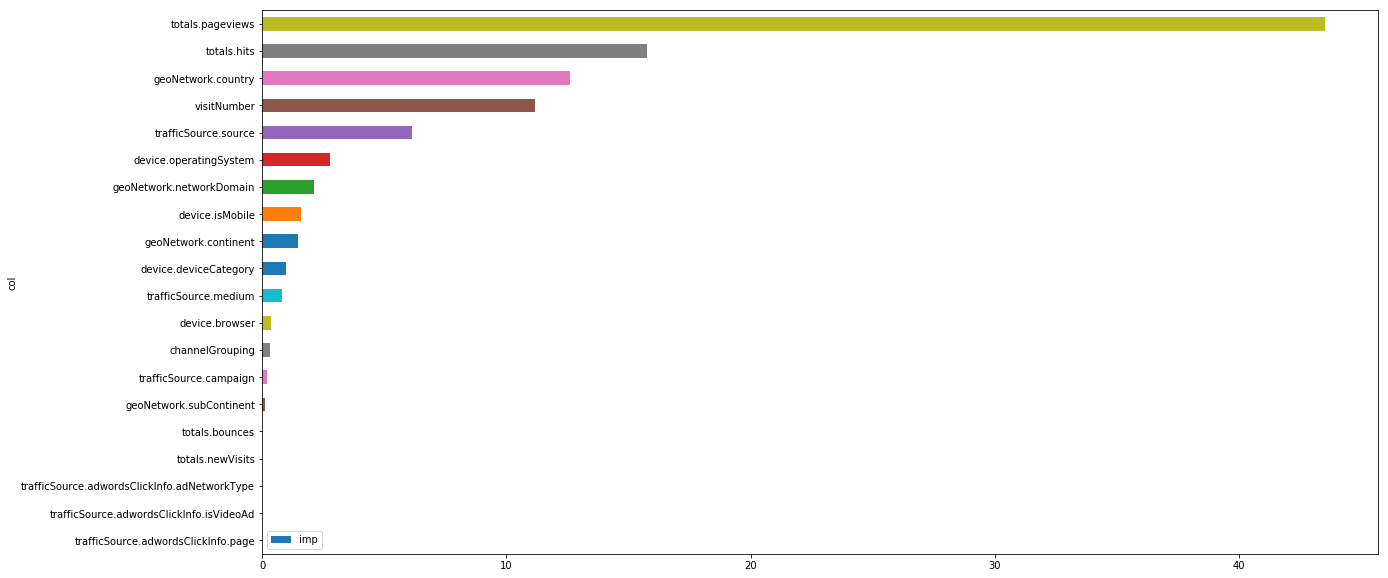

In [61]:
# # Feature Importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': df1_dev_X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
#plt.savefig('catboost_feature_importance.png')

In [45]:
### Final model validation, evaluation metrics with different random seeds and 3 fold cv
## 3 fold cv
import catboost as cb
params = {'depth': [10],
          'learning_rate' : [0.2],
         'l2_leaf_reg': [1],
         'iterations': [300]}

cb = cb.CatBoostRegressor(task_type = "GPU",eval_metric="RMSE")
cb_model = GridSearchCV(cb, params, cv = 3)
cb_model.fit(df2_dev_X,df2_dev_y)
pred_val = cb_model.predict(df2_val_X)
rmse1(pred_val)

0:	learn: 1.8598684	total: 49.8ms	remaining: 14.9s
1:	learn: 1.7889835	total: 95.5ms	remaining: 14.2s
2:	learn: 1.7405609	total: 143ms	remaining: 14.2s
3:	learn: 1.7064191	total: 188ms	remaining: 13.9s
4:	learn: 1.6829018	total: 236ms	remaining: 13.9s
5:	learn: 1.6657124	total: 356ms	remaining: 17.5s
6:	learn: 1.6526852	total: 408ms	remaining: 17.1s
7:	learn: 1.6431278	total: 464ms	remaining: 16.9s
8:	learn: 1.6364224	total: 515ms	remaining: 16.6s
9:	learn: 1.6308512	total: 670ms	remaining: 19.4s
10:	learn: 1.6260253	total: 702ms	remaining: 18.5s
11:	learn: 1.6213556	total: 732ms	remaining: 17.6s
12:	learn: 1.6171473	total: 756ms	remaining: 16.7s
13:	learn: 1.6137781	total: 781ms	remaining: 16s
14:	learn: 1.6104118	total: 806ms	remaining: 15.3s
15:	learn: 1.6072820	total: 831ms	remaining: 14.7s
16:	learn: 1.6043070	total: 855ms	remaining: 14.2s
17:	learn: 1.6018168	total: 883ms	remaining: 13.8s
18:	learn: 1.5994342	total: 907ms	remaining: 13.4s
19:	learn: 1.5978101	total: 929ms	remaini

167:	learn: 1.4271125	total: 4.52s	remaining: 3.55s
168:	learn: 1.4265820	total: 4.54s	remaining: 3.52s
169:	learn: 1.4258428	total: 4.56s	remaining: 3.49s
170:	learn: 1.4253138	total: 4.59s	remaining: 3.46s
171:	learn: 1.4246959	total: 4.61s	remaining: 3.43s
172:	learn: 1.4239521	total: 4.63s	remaining: 3.4s
173:	learn: 1.4228102	total: 4.66s	remaining: 3.37s
174:	learn: 1.4222121	total: 4.68s	remaining: 3.34s
175:	learn: 1.4216217	total: 4.7s	remaining: 3.31s
176:	learn: 1.4211709	total: 4.72s	remaining: 3.28s
177:	learn: 1.4198684	total: 4.75s	remaining: 3.25s
178:	learn: 1.4190359	total: 4.77s	remaining: 3.23s
179:	learn: 1.4186289	total: 4.79s	remaining: 3.2s
180:	learn: 1.4181650	total: 4.82s	remaining: 3.17s
181:	learn: 1.4170745	total: 4.84s	remaining: 3.14s
182:	learn: 1.4159575	total: 4.87s	remaining: 3.11s
183:	learn: 1.4152179	total: 4.89s	remaining: 3.08s
184:	learn: 1.4146812	total: 4.91s	remaining: 3.05s
185:	learn: 1.4139648	total: 4.94s	remaining: 3.03s
186:	learn: 1.4

27:	learn: 1.5622868	total: 689ms	remaining: 6.69s
28:	learn: 1.5609028	total: 713ms	remaining: 6.66s
29:	learn: 1.5573551	total: 736ms	remaining: 6.63s
30:	learn: 1.5561719	total: 759ms	remaining: 6.58s
31:	learn: 1.5548947	total: 783ms	remaining: 6.56s
32:	learn: 1.5538782	total: 807ms	remaining: 6.53s
33:	learn: 1.5529584	total: 832ms	remaining: 6.51s
34:	learn: 1.5505822	total: 858ms	remaining: 6.49s
35:	learn: 1.5486801	total: 882ms	remaining: 6.47s
36:	learn: 1.5468037	total: 910ms	remaining: 6.47s
37:	learn: 1.5442887	total: 936ms	remaining: 6.45s
38:	learn: 1.5422021	total: 959ms	remaining: 6.42s
39:	learn: 1.5390730	total: 984ms	remaining: 6.4s
40:	learn: 1.5373996	total: 1.01s	remaining: 6.37s
41:	learn: 1.5365806	total: 1.03s	remaining: 6.33s
42:	learn: 1.5342905	total: 1.05s	remaining: 6.29s
43:	learn: 1.5326928	total: 1.07s	remaining: 6.25s
44:	learn: 1.5304234	total: 1.1s	remaining: 6.22s
45:	learn: 1.5283717	total: 1.13s	remaining: 6.23s
46:	learn: 1.5269044	total: 1.15s

188:	learn: 1.3875184	total: 4.7s	remaining: 2.76s
189:	learn: 1.3863586	total: 4.73s	remaining: 2.74s
190:	learn: 1.3853426	total: 4.75s	remaining: 2.71s
191:	learn: 1.3845030	total: 4.77s	remaining: 2.69s
192:	learn: 1.3831367	total: 4.8s	remaining: 2.66s
193:	learn: 1.3819035	total: 4.82s	remaining: 2.63s
194:	learn: 1.3814639	total: 4.84s	remaining: 2.61s
195:	learn: 1.3811265	total: 4.87s	remaining: 2.58s
196:	learn: 1.3807404	total: 4.89s	remaining: 2.56s
197:	learn: 1.3804341	total: 4.92s	remaining: 2.53s
198:	learn: 1.3800012	total: 4.94s	remaining: 2.51s
199:	learn: 1.3792068	total: 4.96s	remaining: 2.48s
200:	learn: 1.3782097	total: 4.99s	remaining: 2.46s
201:	learn: 1.3776578	total: 5.01s	remaining: 2.43s
202:	learn: 1.3772798	total: 5.03s	remaining: 2.4s
203:	learn: 1.3766603	total: 5.06s	remaining: 2.38s
204:	learn: 1.3762236	total: 5.08s	remaining: 2.35s
205:	learn: 1.3753939	total: 5.1s	remaining: 2.33s
206:	learn: 1.3744553	total: 5.13s	remaining: 2.31s
207:	learn: 1.37

52:	learn: 1.5371582	total: 1.31s	remaining: 6.11s
53:	learn: 1.5353270	total: 1.34s	remaining: 6.11s
54:	learn: 1.5336960	total: 1.37s	remaining: 6.09s
55:	learn: 1.5318298	total: 1.39s	remaining: 6.08s
56:	learn: 1.5304492	total: 1.42s	remaining: 6.06s
57:	learn: 1.5290327	total: 1.45s	remaining: 6.04s
58:	learn: 1.5275322	total: 1.47s	remaining: 6.01s
59:	learn: 1.5263819	total: 1.49s	remaining: 5.97s
60:	learn: 1.5244138	total: 1.52s	remaining: 5.95s
61:	learn: 1.5239667	total: 1.54s	remaining: 5.91s
62:	learn: 1.5223348	total: 1.56s	remaining: 5.88s
63:	learn: 1.5210135	total: 1.59s	remaining: 5.85s
64:	learn: 1.5194655	total: 1.61s	remaining: 5.82s
65:	learn: 1.5177753	total: 1.63s	remaining: 5.79s
66:	learn: 1.5163235	total: 1.66s	remaining: 5.75s
67:	learn: 1.5146642	total: 1.68s	remaining: 5.72s
68:	learn: 1.5140310	total: 1.7s	remaining: 5.69s
69:	learn: 1.5129551	total: 1.72s	remaining: 5.66s
70:	learn: 1.5119076	total: 1.75s	remaining: 5.63s
71:	learn: 1.5102616	total: 1.77

213:	learn: 1.3863193	total: 5.14s	remaining: 2.06s
214:	learn: 1.3852120	total: 5.16s	remaining: 2.04s
215:	learn: 1.3849590	total: 5.19s	remaining: 2.02s
216:	learn: 1.3838788	total: 5.21s	remaining: 1.99s
217:	learn: 1.3831183	total: 5.24s	remaining: 1.97s
218:	learn: 1.3817694	total: 5.26s	remaining: 1.95s
219:	learn: 1.3811694	total: 5.29s	remaining: 1.92s
220:	learn: 1.3804194	total: 5.31s	remaining: 1.9s
221:	learn: 1.3794580	total: 5.33s	remaining: 1.87s
222:	learn: 1.3782642	total: 5.36s	remaining: 1.85s
223:	learn: 1.3777148	total: 5.38s	remaining: 1.83s
224:	learn: 1.3770091	total: 5.41s	remaining: 1.8s
225:	learn: 1.3763496	total: 5.43s	remaining: 1.78s
226:	learn: 1.3752618	total: 5.46s	remaining: 1.75s
227:	learn: 1.3746989	total: 5.48s	remaining: 1.73s
228:	learn: 1.3740646	total: 5.5s	remaining: 1.71s
229:	learn: 1.3728132	total: 5.53s	remaining: 1.68s
230:	learn: 1.3722225	total: 5.55s	remaining: 1.66s
231:	learn: 1.3715777	total: 5.58s	remaining: 1.63s
232:	learn: 1.3

75:	learn: 1.5273359	total: 2.36s	remaining: 6.95s
76:	learn: 1.5269833	total: 2.39s	remaining: 6.92s
77:	learn: 1.5259262	total: 2.42s	remaining: 6.89s
78:	learn: 1.5254049	total: 2.45s	remaining: 6.86s
79:	learn: 1.5245426	total: 2.48s	remaining: 6.82s
80:	learn: 1.5237611	total: 2.51s	remaining: 6.79s
81:	learn: 1.5229025	total: 2.54s	remaining: 6.76s
82:	learn: 1.5219914	total: 2.58s	remaining: 6.73s
83:	learn: 1.5211145	total: 2.61s	remaining: 6.71s
84:	learn: 1.5196990	total: 2.64s	remaining: 6.68s
85:	learn: 1.5185163	total: 2.67s	remaining: 6.65s
86:	learn: 1.5172159	total: 2.7s	remaining: 6.62s
87:	learn: 1.5165605	total: 2.74s	remaining: 6.59s
88:	learn: 1.5156647	total: 2.77s	remaining: 6.57s
89:	learn: 1.5152317	total: 2.8s	remaining: 6.54s
90:	learn: 1.5147945	total: 2.83s	remaining: 6.5s
91:	learn: 1.5140648	total: 2.86s	remaining: 6.47s
92:	learn: 1.5135017	total: 2.89s	remaining: 6.44s
93:	learn: 1.5127288	total: 2.92s	remaining: 6.4s
94:	learn: 1.5120402	total: 2.95s	r

239:	learn: 1.4228787	total: 7.29s	remaining: 1.82s
240:	learn: 1.4221696	total: 7.32s	remaining: 1.79s
241:	learn: 1.4214094	total: 7.35s	remaining: 1.76s
242:	learn: 1.4210227	total: 7.38s	remaining: 1.73s
243:	learn: 1.4206278	total: 7.41s	remaining: 1.7s
244:	learn: 1.4203183	total: 7.43s	remaining: 1.67s
245:	learn: 1.4196197	total: 7.46s	remaining: 1.64s
246:	learn: 1.4190628	total: 7.49s	remaining: 1.61s
247:	learn: 1.4187112	total: 7.52s	remaining: 1.58s
248:	learn: 1.4182614	total: 7.55s	remaining: 1.54s
249:	learn: 1.4180583	total: 7.57s	remaining: 1.51s
250:	learn: 1.4177937	total: 7.6s	remaining: 1.48s
251:	learn: 1.4175919	total: 7.63s	remaining: 1.45s
252:	learn: 1.4173764	total: 7.66s	remaining: 1.42s
253:	learn: 1.4168867	total: 7.68s	remaining: 1.39s
254:	learn: 1.4156253	total: 7.71s	remaining: 1.36s
255:	learn: 1.4153133	total: 7.74s	remaining: 1.33s
256:	learn: 1.4145195	total: 7.78s	remaining: 1.3s
257:	learn: 1.4141816	total: 7.8s	remaining: 1.27s
258:	learn: 1.41

In [46]:
### random state 999
import catboost as cb
clf = cb.CatBoostRegressor(eval_metric="RMSE", 
                            depth=10, iterations = 300, l2_leaf_reg= 1, learning_rate= 0.2,task_type = "GPU",random_state=999)
model.fit(df2_dev_X, df2_dev_y)
pred_val = model.predict(df2_val_X)
rmse1(pred_val)

0:	learn: 1.9419497	total: 36.3ms	remaining: 36.3s
1:	learn: 1.9269298	total: 72.9ms	remaining: 36.4s
2:	learn: 1.9126887	total: 106ms	remaining: 35.1s
3:	learn: 1.8991567	total: 141ms	remaining: 35.1s
4:	learn: 1.8863329	total: 175ms	remaining: 34.9s
5:	learn: 1.8741362	total: 228ms	remaining: 37.9s
6:	learn: 1.8625371	total: 287ms	remaining: 40.7s
7:	learn: 1.8515848	total: 332ms	remaining: 41.2s
8:	learn: 1.8412046	total: 375ms	remaining: 41.2s
9:	learn: 1.8312621	total: 495ms	remaining: 49s
10:	learn: 1.8219661	total: 542ms	remaining: 48.7s
11:	learn: 1.8131139	total: 562ms	remaining: 46.3s
12:	learn: 1.8045938	total: 582ms	remaining: 44.2s
13:	learn: 1.7966023	total: 601ms	remaining: 42.4s
14:	learn: 1.7890499	total: 620ms	remaining: 40.7s
15:	learn: 1.7818190	total: 639ms	remaining: 39.3s
16:	learn: 1.7750402	total: 658ms	remaining: 38.1s
17:	learn: 1.7685691	total: 676ms	remaining: 36.9s
18:	learn: 1.7625038	total: 696ms	remaining: 35.9s
19:	learn: 1.7566860	total: 714ms	remaini

170:	learn: 1.6232975	total: 3.38s	remaining: 16.4s
171:	learn: 1.6230966	total: 3.42s	remaining: 16.5s
172:	learn: 1.6230448	total: 3.44s	remaining: 16.5s
173:	learn: 1.6228805	total: 3.46s	remaining: 16.4s
174:	learn: 1.6227843	total: 3.48s	remaining: 16.4s
175:	learn: 1.6227129	total: 3.51s	remaining: 16.4s
176:	learn: 1.6225955	total: 3.53s	remaining: 16.4s
177:	learn: 1.6225152	total: 3.55s	remaining: 16.4s
178:	learn: 1.6224021	total: 3.57s	remaining: 16.4s
179:	learn: 1.6223182	total: 3.59s	remaining: 16.4s
180:	learn: 1.6221829	total: 3.61s	remaining: 16.3s
181:	learn: 1.6220946	total: 3.62s	remaining: 16.3s
182:	learn: 1.6220204	total: 3.64s	remaining: 16.3s
183:	learn: 1.6218723	total: 3.66s	remaining: 16.2s
184:	learn: 1.6216602	total: 3.67s	remaining: 16.2s
185:	learn: 1.6215201	total: 3.69s	remaining: 16.1s
186:	learn: 1.6213394	total: 3.7s	remaining: 16.1s
187:	learn: 1.6211365	total: 3.72s	remaining: 16.1s
188:	learn: 1.6209201	total: 3.74s	remaining: 16s
189:	learn: 1.6

329:	learn: 1.6046976	total: 6.41s	remaining: 13s
330:	learn: 1.6045701	total: 6.43s	remaining: 13s
331:	learn: 1.6045171	total: 6.45s	remaining: 13s
332:	learn: 1.6044266	total: 6.47s	remaining: 13s
333:	learn: 1.6042642	total: 6.49s	remaining: 12.9s
334:	learn: 1.6042078	total: 6.51s	remaining: 12.9s
335:	learn: 1.6041635	total: 6.53s	remaining: 12.9s
336:	learn: 1.6040049	total: 6.55s	remaining: 12.9s
337:	learn: 1.6039154	total: 6.57s	remaining: 12.9s
338:	learn: 1.6037955	total: 6.58s	remaining: 12.8s
339:	learn: 1.6036817	total: 6.6s	remaining: 12.8s
340:	learn: 1.6036277	total: 6.62s	remaining: 12.8s
341:	learn: 1.6035539	total: 6.64s	remaining: 12.8s
342:	learn: 1.6034613	total: 6.66s	remaining: 12.8s
343:	learn: 1.6034171	total: 6.68s	remaining: 12.7s
344:	learn: 1.6033742	total: 6.7s	remaining: 12.7s
345:	learn: 1.6033361	total: 6.72s	remaining: 12.7s
346:	learn: 1.6031676	total: 6.74s	remaining: 12.7s
347:	learn: 1.6030324	total: 6.75s	remaining: 12.7s
348:	learn: 1.6028798	

490:	learn: 1.5925183	total: 9.49s	remaining: 9.84s
491:	learn: 1.5924889	total: 9.51s	remaining: 9.82s
492:	learn: 1.5924556	total: 9.53s	remaining: 9.8s
493:	learn: 1.5923773	total: 9.55s	remaining: 9.78s
494:	learn: 1.5923154	total: 9.57s	remaining: 9.76s
495:	learn: 1.5922557	total: 9.59s	remaining: 9.74s
496:	learn: 1.5921984	total: 9.6s	remaining: 9.72s
497:	learn: 1.5921413	total: 9.62s	remaining: 9.7s
498:	learn: 1.5921033	total: 9.64s	remaining: 9.68s
499:	learn: 1.5920402	total: 9.66s	remaining: 9.66s
500:	learn: 1.5919524	total: 9.68s	remaining: 9.64s
501:	learn: 1.5918735	total: 9.7s	remaining: 9.62s
502:	learn: 1.5917765	total: 9.72s	remaining: 9.61s
503:	learn: 1.5917168	total: 9.74s	remaining: 9.59s
504:	learn: 1.5916513	total: 9.76s	remaining: 9.57s
505:	learn: 1.5915943	total: 9.78s	remaining: 9.55s
506:	learn: 1.5915311	total: 9.79s	remaining: 9.52s
507:	learn: 1.5914379	total: 9.81s	remaining: 9.5s
508:	learn: 1.5913537	total: 9.83s	remaining: 9.48s
509:	learn: 1.591

654:	learn: 1.5830924	total: 12.3s	remaining: 6.49s
655:	learn: 1.5830634	total: 12.3s	remaining: 6.47s
656:	learn: 1.5830187	total: 12.4s	remaining: 6.45s
657:	learn: 1.5829178	total: 12.4s	remaining: 6.43s
658:	learn: 1.5828833	total: 12.4s	remaining: 6.41s
659:	learn: 1.5828460	total: 12.4s	remaining: 6.39s
660:	learn: 1.5827779	total: 12.4s	remaining: 6.37s
661:	learn: 1.5827598	total: 12.4s	remaining: 6.35s
662:	learn: 1.5826991	total: 12.5s	remaining: 6.33s
663:	learn: 1.5826749	total: 12.5s	remaining: 6.31s
664:	learn: 1.5825856	total: 12.5s	remaining: 6.29s
665:	learn: 1.5825228	total: 12.5s	remaining: 6.27s
666:	learn: 1.5824706	total: 12.5s	remaining: 6.25s
667:	learn: 1.5824214	total: 12.5s	remaining: 6.23s
668:	learn: 1.5823791	total: 12.6s	remaining: 6.21s
669:	learn: 1.5823291	total: 12.6s	remaining: 6.19s
670:	learn: 1.5823045	total: 12.6s	remaining: 6.17s
671:	learn: 1.5822229	total: 12.6s	remaining: 6.15s
672:	learn: 1.5821696	total: 12.6s	remaining: 6.13s
673:	learn: 

820:	learn: 1.5755612	total: 15.2s	remaining: 3.3s
821:	learn: 1.5755010	total: 15.2s	remaining: 3.29s
822:	learn: 1.5754652	total: 15.2s	remaining: 3.27s
823:	learn: 1.5754250	total: 15.2s	remaining: 3.25s
824:	learn: 1.5753548	total: 15.2s	remaining: 3.23s
825:	learn: 1.5753371	total: 15.2s	remaining: 3.21s
826:	learn: 1.5752804	total: 15.3s	remaining: 3.19s
827:	learn: 1.5752349	total: 15.3s	remaining: 3.17s
828:	learn: 1.5752018	total: 15.3s	remaining: 3.15s
829:	learn: 1.5751498	total: 15.3s	remaining: 3.14s
830:	learn: 1.5751215	total: 15.3s	remaining: 3.12s
831:	learn: 1.5750750	total: 15.3s	remaining: 3.1s
832:	learn: 1.5750559	total: 15.4s	remaining: 3.08s
833:	learn: 1.5750366	total: 15.4s	remaining: 3.06s
834:	learn: 1.5750002	total: 15.4s	remaining: 3.04s
835:	learn: 1.5749520	total: 15.4s	remaining: 3.02s
836:	learn: 1.5749173	total: 15.4s	remaining: 3s
837:	learn: 1.5748592	total: 15.4s	remaining: 2.98s
838:	learn: 1.5748371	total: 15.5s	remaining: 2.97s
839:	learn: 1.574

981:	learn: 1.5694240	total: 18s	remaining: 330ms
982:	learn: 1.5693763	total: 18s	remaining: 312ms
983:	learn: 1.5693451	total: 18.1s	remaining: 294ms
984:	learn: 1.5692915	total: 18.1s	remaining: 275ms
985:	learn: 1.5692646	total: 18.1s	remaining: 257ms
986:	learn: 1.5692497	total: 18.1s	remaining: 239ms
987:	learn: 1.5692210	total: 18.1s	remaining: 220ms
988:	learn: 1.5691763	total: 18.1s	remaining: 202ms
989:	learn: 1.5691474	total: 18.2s	remaining: 183ms
990:	learn: 1.5690864	total: 18.2s	remaining: 165ms
991:	learn: 1.5690326	total: 18.2s	remaining: 147ms
992:	learn: 1.5689797	total: 18.2s	remaining: 128ms
993:	learn: 1.5689169	total: 18.2s	remaining: 110ms
994:	learn: 1.5689046	total: 18.2s	remaining: 91.7ms
995:	learn: 1.5688489	total: 18.3s	remaining: 73.3ms
996:	learn: 1.5687988	total: 18.3s	remaining: 55ms
997:	learn: 1.5687546	total: 18.3s	remaining: 36.6ms
998:	learn: 1.5687020	total: 18.3s	remaining: 18.3ms
999:	learn: 1.5686767	total: 18.3s	remaining: 0us
RMSE 1.85542605

In [47]:
##Random state 111
import catboost as cb
clf = cb.CatBoostRegressor(eval_metric="RMSE", 
                            depth=10, iterations = 300, l2_leaf_reg= 1, learning_rate= 0.2,task_type = "GPU",random_state=111)
model.fit(df2_dev_X, df2_dev_y)
pred_val = model.predict(df2_val_X)
rmse1(pred_val)

0:	learn: 1.9419137	total: 18.1ms	remaining: 18s
1:	learn: 1.9269746	total: 35.1ms	remaining: 17.5s
2:	learn: 1.9127111	total: 51.6ms	remaining: 17.1s
3:	learn: 1.8991945	total: 69.4ms	remaining: 17.3s
4:	learn: 1.8863542	total: 85.6ms	remaining: 17s
5:	learn: 1.8741959	total: 102ms	remaining: 16.9s
6:	learn: 1.8626634	total: 120ms	remaining: 17s
7:	learn: 1.8516993	total: 136ms	remaining: 16.9s
8:	learn: 1.8412380	total: 155ms	remaining: 17.1s
9:	learn: 1.8313255	total: 173ms	remaining: 17.2s
10:	learn: 1.8219246	total: 191ms	remaining: 17.2s
11:	learn: 1.8129948	total: 209ms	remaining: 17.2s
12:	learn: 1.8045546	total: 229ms	remaining: 17.4s
13:	learn: 1.7965814	total: 249ms	remaining: 17.6s
14:	learn: 1.7889864	total: 269ms	remaining: 17.7s
15:	learn: 1.7818722	total: 289ms	remaining: 17.8s
16:	learn: 1.7750742	total: 308ms	remaining: 17.8s
17:	learn: 1.7685649	total: 327ms	remaining: 17.8s
18:	learn: 1.7624499	total: 345ms	remaining: 17.8s
19:	learn: 1.7566210	total: 364ms	remainin

166:	learn: 1.6243873	total: 3.1s	remaining: 15.5s
167:	learn: 1.6243035	total: 3.12s	remaining: 15.5s
168:	learn: 1.6241621	total: 3.14s	remaining: 15.4s
169:	learn: 1.6239807	total: 3.16s	remaining: 15.4s
170:	learn: 1.6238206	total: 3.17s	remaining: 15.4s
171:	learn: 1.6236506	total: 3.19s	remaining: 15.4s
172:	learn: 1.6234934	total: 3.21s	remaining: 15.3s
173:	learn: 1.6233028	total: 3.22s	remaining: 15.3s
174:	learn: 1.6230680	total: 3.24s	remaining: 15.3s
175:	learn: 1.6228830	total: 3.26s	remaining: 15.2s
176:	learn: 1.6227427	total: 3.28s	remaining: 15.2s
177:	learn: 1.6225807	total: 3.3s	remaining: 15.2s
178:	learn: 1.6225158	total: 3.32s	remaining: 15.2s
179:	learn: 1.6223338	total: 3.34s	remaining: 15.2s
180:	learn: 1.6222062	total: 3.36s	remaining: 15.2s
181:	learn: 1.6219898	total: 3.38s	remaining: 15.2s
182:	learn: 1.6218420	total: 3.4s	remaining: 15.2s
183:	learn: 1.6217279	total: 3.42s	remaining: 15.2s
184:	learn: 1.6215855	total: 3.44s	remaining: 15.1s
185:	learn: 1.6

334:	learn: 1.6047820	total: 6.14s	remaining: 12.2s
335:	learn: 1.6047392	total: 6.16s	remaining: 12.2s
336:	learn: 1.6046380	total: 6.18s	remaining: 12.2s
337:	learn: 1.6045907	total: 6.2s	remaining: 12.1s
338:	learn: 1.6044456	total: 6.22s	remaining: 12.1s
339:	learn: 1.6043762	total: 6.24s	remaining: 12.1s
340:	learn: 1.6042878	total: 6.25s	remaining: 12.1s
341:	learn: 1.6042170	total: 6.27s	remaining: 12.1s
342:	learn: 1.6040378	total: 6.29s	remaining: 12.1s
343:	learn: 1.6039878	total: 6.31s	remaining: 12s
344:	learn: 1.6039038	total: 6.33s	remaining: 12s
345:	learn: 1.6038126	total: 6.35s	remaining: 12s
346:	learn: 1.6036883	total: 6.37s	remaining: 12s
347:	learn: 1.6036178	total: 6.39s	remaining: 12s
348:	learn: 1.6034768	total: 6.41s	remaining: 12s
349:	learn: 1.6033629	total: 6.43s	remaining: 11.9s
350:	learn: 1.6032643	total: 6.45s	remaining: 11.9s
351:	learn: 1.6031740	total: 6.47s	remaining: 11.9s
352:	learn: 1.6030293	total: 6.49s	remaining: 11.9s
353:	learn: 1.6029661	tot

494:	learn: 1.5922553	total: 8.99s	remaining: 9.17s
495:	learn: 1.5921717	total: 9s	remaining: 9.15s
496:	learn: 1.5920723	total: 9.02s	remaining: 9.13s
497:	learn: 1.5919956	total: 9.04s	remaining: 9.11s
498:	learn: 1.5919176	total: 9.05s	remaining: 9.09s
499:	learn: 1.5918101	total: 9.07s	remaining: 9.07s
500:	learn: 1.5917405	total: 9.09s	remaining: 9.05s
501:	learn: 1.5916850	total: 9.1s	remaining: 9.03s
502:	learn: 1.5916137	total: 9.12s	remaining: 9.01s
503:	learn: 1.5915936	total: 9.13s	remaining: 8.99s
504:	learn: 1.5915314	total: 9.15s	remaining: 8.97s
505:	learn: 1.5914579	total: 9.17s	remaining: 8.95s
506:	learn: 1.5914288	total: 9.19s	remaining: 8.93s
507:	learn: 1.5913425	total: 9.2s	remaining: 8.91s
508:	learn: 1.5912723	total: 9.22s	remaining: 8.89s
509:	learn: 1.5912198	total: 9.23s	remaining: 8.87s
510:	learn: 1.5911688	total: 9.25s	remaining: 8.85s
511:	learn: 1.5910531	total: 9.27s	remaining: 8.83s
512:	learn: 1.5909843	total: 9.28s	remaining: 8.81s
513:	learn: 1.590

656:	learn: 1.5829629	total: 11.8s	remaining: 6.16s
657:	learn: 1.5828819	total: 11.8s	remaining: 6.14s
658:	learn: 1.5828252	total: 11.8s	remaining: 6.13s
659:	learn: 1.5827917	total: 11.9s	remaining: 6.11s
660:	learn: 1.5827578	total: 11.9s	remaining: 6.09s
661:	learn: 1.5827238	total: 11.9s	remaining: 6.07s
662:	learn: 1.5826737	total: 11.9s	remaining: 6.05s
663:	learn: 1.5825935	total: 11.9s	remaining: 6.03s
664:	learn: 1.5825491	total: 11.9s	remaining: 6.02s
665:	learn: 1.5825141	total: 12s	remaining: 6s
666:	learn: 1.5824630	total: 12s	remaining: 5.98s
667:	learn: 1.5823957	total: 12s	remaining: 5.96s
668:	learn: 1.5823143	total: 12s	remaining: 5.94s
669:	learn: 1.5822272	total: 12s	remaining: 5.92s
670:	learn: 1.5821589	total: 12s	remaining: 5.9s
671:	learn: 1.5820831	total: 12.1s	remaining: 5.89s
672:	learn: 1.5820400	total: 12.1s	remaining: 5.87s
673:	learn: 1.5820192	total: 12.1s	remaining: 5.85s
674:	learn: 1.5819652	total: 12.1s	remaining: 5.83s
675:	learn: 1.5819212	total:

821:	learn: 1.5751988	total: 14.6s	remaining: 3.17s
822:	learn: 1.5751796	total: 14.7s	remaining: 3.15s
823:	learn: 1.5751449	total: 14.7s	remaining: 3.13s
824:	learn: 1.5750956	total: 14.7s	remaining: 3.12s
825:	learn: 1.5750473	total: 14.7s	remaining: 3.1s
826:	learn: 1.5750202	total: 14.7s	remaining: 3.08s
827:	learn: 1.5749396	total: 14.7s	remaining: 3.06s
828:	learn: 1.5749154	total: 14.8s	remaining: 3.04s
829:	learn: 1.5748982	total: 14.8s	remaining: 3.02s
830:	learn: 1.5748487	total: 14.8s	remaining: 3.01s
831:	learn: 1.5747915	total: 14.8s	remaining: 2.99s
832:	learn: 1.5747715	total: 14.8s	remaining: 2.97s
833:	learn: 1.5747426	total: 14.8s	remaining: 2.95s
834:	learn: 1.5746994	total: 14.8s	remaining: 2.93s
835:	learn: 1.5746532	total: 14.9s	remaining: 2.92s
836:	learn: 1.5746061	total: 14.9s	remaining: 2.9s
837:	learn: 1.5745724	total: 14.9s	remaining: 2.88s
838:	learn: 1.5745223	total: 14.9s	remaining: 2.86s
839:	learn: 1.5744789	total: 14.9s	remaining: 2.84s
840:	learn: 1.

989:	learn: 1.5685508	total: 17.5s	remaining: 176ms
990:	learn: 1.5685164	total: 17.5s	remaining: 159ms
991:	learn: 1.5685044	total: 17.5s	remaining: 141ms
992:	learn: 1.5684622	total: 17.5s	remaining: 123ms
993:	learn: 1.5683964	total: 17.5s	remaining: 106ms
994:	learn: 1.5683729	total: 17.6s	remaining: 88.2ms
995:	learn: 1.5683476	total: 17.6s	remaining: 70.6ms
996:	learn: 1.5683027	total: 17.6s	remaining: 52.9ms
997:	learn: 1.5682813	total: 17.6s	remaining: 35.3ms
998:	learn: 1.5682240	total: 17.6s	remaining: 17.6ms
999:	learn: 1.5681820	total: 17.6s	remaining: 0us
RMSE 1.8557549695181563
r2_score 0.37152863542597037
